In [1]:
import joblib
import optuna
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
py.init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import optuna.visualization as vis
import shap
from joblib import Parallel, delayed
from joblib import parallel_backend
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
#knn
def compute_shap_values(model, data, num_cores):
    explainer = shap.KernelExplainer(model.predict, data)
    shap_values = Parallel(n_jobs=num_cores)(delayed(explainer.shap_values)(instance) for instance in data)
    return np.array(shap_values)


# 4. Modeling

## 4.1 Model preparation

### 4.1.1 Train-Test Split

In [3]:
df = pd.read_csv("data_resampled_10.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,6.000000,148.000000,72.000000,35.000000,206.846154,33.600000,0.627000,50.000000,1
1,1.000000,85.000000,66.000000,29.000000,130.287879,26.600000,0.351000,31.000000,0
2,8.000000,183.000000,64.000000,33.000000,206.846154,23.300000,0.672000,32.000000,1
3,1.000000,89.000000,66.000000,23.000000,94.000000,28.100000,0.167000,21.000000,0
4,0.000000,137.000000,40.000000,35.000000,168.000000,43.100000,1.205000,33.000000,1
...,...,...,...,...,...,...,...,...,...
2759,1.678826,128.678826,78.832146,17.905101,179.153321,28.767141,0.125182,23.357652,0
2760,4.938718,111.374188,77.374188,40.677963,130.287879,39.107954,0.229950,38.730114,0
2761,6.866000,102.567000,72.866000,35.139249,187.835001,36.660800,0.290876,56.731999,0
2762,1.300295,98.198231,73.201179,13.801769,68.798821,27.191857,0.655297,26.498526,0


### 4.1.3 Cross Vallidation

In [4]:
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)


## Basic Structure of an Optuna Optimization Script

The overall process works differently from the brute-force approach of GridSearchCV. Because of this, let's cover off the different components of the process:

1. Defining the objective function
2. Creating a Study Object
3. Running the Optimization Process

The objective function is at the core of how Optuna optimizes the hyperparameter selections. While a brute-force grid search also seeks to minimize an objective function, it doesn't actually take into account what combination of hyperparameters is doing well or not.

## 4.2 KNN (K-Nearest Neighbors Algorithm)

In [5]:
# Creating an Objective Function

def objective_knn(trial):
    
    # Define hyperparameters
    param_knn = {'n_neighbors' : trial.suggest_int('n_neighbors', 1, 100)
    ,'weights' : trial.suggest_categorical('weights', ['uniform', 'distance']),
    'metric' : trial.suggest_categorical('metric', ['euclidean', 'manhattan','minkowski']),
    'p' : trial.suggest_int('p', 1, 50),
    'algorithm' : trial.suggest_categorical('algorithm',['auto','ball_tree', 'kd_tree', 'brute']),
    'leaf_size' : trial.suggest_int('leaf_size', 1, 100)}

    # Create and train the model
    knn = KNeighborsClassifier(**param_knn)
    knn.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(knn, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

In [6]:
def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))

## Modelling and shap 

[I 2024-08-26 17:36:34,983] A new study created in memory with name: KNN
[I 2024-08-26 17:36:37,575] Trial 5 finished with value: 0.6923295429242868 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'manhattan', 'p': 43, 'algorithm': 'brute', 'leaf_size': 61}. Best is trial 5 with value: 0.6923295429242868.
[I 2024-08-26 17:36:37,636] Trial 4 finished with value: 0.563417483761427 and parameters: {'n_neighbors': 34, 'weights': 'uniform', 'metric': 'manhattan', 'p': 17, 'algorithm': 'kd_tree', 'leaf_size': 32}. Best is trial 5 with value: 0.6923295429242868.
[I 2024-08-26 17:36:37,863] Trial 3 finished with value: 0.4880385129538449 and parameters: {'n_neighbors': 75, 'weights': 'uniform', 'metric': 'manhattan', 'p': 35, 'algorithm': 'kd_tree', 'leaf_size': 57}. Best is trial 5 with value: 0.6923295429242868.
[I 2024-08-26 17:36:38,286] Trial 1 finished with value: 0.5027470339445922 and parameters: {'n_neighbors': 52, 'weights': 'uniform', 'metric': 'minkowski', 'p': 

Best trial: 5
Best accuracy: 0.6923295429242868
Best hyperparameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'manhattan', 'p': 43, 'algorithm': 'brute', 'leaf_size': 61}
              precision    recall  f1-score   support

           0       0.62      1.00      0.76        50
           1       1.00      0.38      0.55        50

    accuracy                           0.69       100
   macro avg       0.81      0.69      0.66       100
weighted avg       0.81      0.69      0.66       100



[I 2024-08-26 17:37:32,582] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.025679  0.029726       0.000798       0.033655  0.063917  0.014655   
1      0.082774  0.004988       0.009464       0.016179  0.091488  0.003440   
2      0.006905  0.074214       0.001381       0.038929  0.075214  0.004071   
3      0.044881  0.015643       0.000048       0.021881  0.083143  0.003810   
4      0.007893  0.028893       0.016512       0.036417  0.082988  0.006893   
..          ...       ...            ...            ...       ...       ...   
95     0.015440  0.051560       0.008036       0.056131  0.053060  0.023964   
96     0.006202  0.278060       0.019798       0.207607  0.310774  0.013512   
97     0.140595  0.071881       0.010952       0.039476  0.044167  0.013214   
98     0.053274  0.182512       0.015774       0.205060  0.260131  0.026607   
99     0.110310  0.014929       0.081762       0.180286  0.221429  0.037548   

         DPF       Age  Outcome  
0   0.003155  0.0

[I 2024-08-26 17:37:33,620] Trial 1 finished with value: 0.48538427009138607 and parameters: {'n_neighbors': 87, 'weights': 'distance', 'metric': 'manhattan', 'p': 47, 'algorithm': 'brute', 'leaf_size': 91}. Best is trial 1 with value: 0.48538427009138607.
[I 2024-08-26 17:37:33,933] Trial 5 finished with value: 0.5737382383765263 and parameters: {'n_neighbors': 18, 'weights': 'uniform', 'metric': 'euclidean', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 79}. Best is trial 5 with value: 0.5737382383765263.
[I 2024-08-26 17:37:34,469] Trial 6 finished with value: 0.49775073921933166 and parameters: {'n_neighbors': 72, 'weights': 'distance', 'metric': 'euclidean', 'p': 4, 'algorithm': 'kd_tree', 'leaf_size': 89}. Best is trial 5 with value: 0.5737382383765263.
[I 2024-08-26 17:37:34,574] Trial 4 finished with value: 0.4847668386393698 and parameters: {'n_neighbors': 98, 'weights': 'uniform', 'metric': 'euclidean', 'p': 22, 'algorithm': 'brute', 'leaf_size': 7}. Best is trial 5 with val

Best trial: 2
Best accuracy: 0.6831143371717807
Best hyperparameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'minkowski', 'p': 37, 'algorithm': 'ball_tree', 'leaf_size': 32}
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        50
           1       1.00      0.26      0.41        50

    accuracy                           0.63       100
   macro avg       0.79      0.63      0.57       100
weighted avg       0.79      0.63      0.57       100



[I 2024-08-26 17:42:17,914] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.018964  0.017298       0.009155       0.040060  0.061560  0.006060   
1      0.069690  0.035714       0.007333       0.008238  0.126667  0.041500   
2      0.003940  0.059631       0.008655       0.004440  0.060774  0.008869   
3      0.029202  0.037702       0.008060       0.022821  0.031631  0.014607   
4      0.005071  0.031524       0.008976       0.016429  0.095500  0.012310   
..          ...       ...            ...            ...       ...       ...   
95     0.003667  0.052595       0.004881       0.005881  0.045905  0.010619   
96     0.076440  0.307917       0.060321       0.058298  0.314464  0.028131   
97     0.115107  0.034750       0.005012       0.022155  0.054583  0.007321   
98     0.132976  0.038595       0.002024       0.006643  0.160143  0.044310   
99     0.101500  0.026786       0.083262       0.093262  0.222405  0.103952   

         DPF       Age  Outcome  
0   0.004202  0.0

[I 2024-08-26 17:42:19,558] Trial 3 finished with value: 0.764204114530219 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'minkowski', 'p': 18, 'algorithm': 'kd_tree', 'leaf_size': 9}. Best is trial 3 with value: 0.764204114530219.
[I 2024-08-26 17:42:19,983] Trial 5 finished with value: 0.5342226524491152 and parameters: {'n_neighbors': 38, 'weights': 'distance', 'metric': 'euclidean', 'p': 17, 'algorithm': 'auto', 'leaf_size': 37}. Best is trial 3 with value: 0.764204114530219.
[I 2024-08-26 17:42:20,740] Trial 0 finished with value: 0.5218741747246254 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'euclidean', 'p': 43, 'algorithm': 'auto', 'leaf_size': 42}. Best is trial 3 with value: 0.764204114530219.
[I 2024-08-26 17:42:20,960] Trial 4 finished with value: 0.5104114634734483 and parameters: {'n_neighbors': 49, 'weights': 'uniform', 'metric': 'euclidean', 'p': 22, 'algorithm': 'auto', 'leaf_size': 100}. Best is trial 3 with value: 0.7642041

Best trial: 3
Best accuracy: 0.764204114530219
Best hyperparameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'minkowski', 'p': 18, 'algorithm': 'kd_tree', 'leaf_size': 9}
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100



[I 2024-08-26 17:42:59,559] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020512  0.071655       0.013964       0.032369  0.086988  0.000798   
1      0.070762  0.115000       0.076619       0.014976  0.233571  0.020405   
2      0.010179  0.113179       0.000964       0.024940  0.132583  0.005583   
3      0.015429  0.005524       0.032524       0.001738  0.119905  0.041500   
4      0.005226  0.056060       0.014512       0.000488  0.158083  0.002369   
..          ...       ...            ...            ...       ...       ...   
95     0.058083  0.071940       0.058179       0.096679  0.114226  0.041726   
96     0.065952  0.289095       0.005738       0.020238  0.337667  0.028095   
97     0.152964  0.148774       0.076964       0.051488  0.147155  0.010155   
98     0.013583  0.164488       0.087560       0.082821  0.302774  0.063536   
99     0.092714  0.001810       0.039929       0.115167  0.258786  0.016452   

         DPF       Age  Outcome  
0   0.000298  0.0

[I 2024-08-26 17:43:00,562] Trial 1 finished with value: 0.536265180616681 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'euclidean', 'p': 21, 'algorithm': 'kd_tree', 'leaf_size': 44}. Best is trial 1 with value: 0.536265180616681.
[I 2024-08-26 17:43:00,835] Trial 2 finished with value: 0.7117744621073218 and parameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean', 'p': 33, 'algorithm': 'brute', 'leaf_size': 79}. Best is trial 2 with value: 0.7117744621073218.
[I 2024-08-26 17:43:00,881] Trial 4 finished with value: 0.4817836603233468 and parameters: {'n_neighbors': 95, 'weights': 'distance', 'metric': 'manhattan', 'p': 43, 'algorithm': 'ball_tree', 'leaf_size': 16}. Best is trial 2 with value: 0.7117744621073218.
[I 2024-08-26 17:43:00,983] Trial 0 finished with value: 0.5103293133508118 and parameters: {'n_neighbors': 56, 'weights': 'distance', 'metric': 'euclidean', 'p': 43, 'algorithm': 'brute', 'leaf_size': 67}. Best is trial 2 with valu

Best trial: 2
Best accuracy: 0.7117744621073218
Best hyperparameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'euclidean', 'p': 33, 'algorithm': 'brute', 'leaf_size': 79}
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        50
           1       1.00      0.40      0.57        50

    accuracy                           0.70       100
   macro avg       0.81      0.70      0.67       100
weighted avg       0.81      0.70      0.67       100



[I 2024-08-26 17:43:51,139] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.009036  0.064536       0.007560       0.030655  0.086012  0.005083   
1      0.083917  0.027774       0.005345       0.007988  0.138131  0.031226   
2      0.006881  0.079833       0.000214       0.025048  0.093357  0.002143   
3      0.046238  0.031286       0.000429       0.010619  0.092762  0.001690   
4      0.011429  0.033548       0.011167       0.014024  0.120881  0.001524   
..          ...       ...            ...            ...       ...       ...   
95     0.013119  0.120833       0.009667       0.030238  0.028667  0.020024   
96     0.040202  0.329488       0.001583       0.110917  0.309988  0.001893   
97     0.157048  0.071952       0.011071       0.036214  0.063452  0.015452   
98     0.000714  0.183667       0.055429       0.113357  0.291548  0.075833   
99     0.025345  0.088464       0.065155       0.042012  0.122155  0.088869   

         DPF       Age  Outcome  
0   0.004845  0.0

[I 2024-08-26 17:43:52,242] Trial 2 finished with value: 0.657351198216364 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'euclidean', 'p': 33, 'algorithm': 'kd_tree', 'leaf_size': 92}. Best is trial 2 with value: 0.657351198216364.
[I 2024-08-26 17:43:54,009] Trial 6 finished with value: 0.492048660265895 and parameters: {'n_neighbors': 77, 'weights': 'uniform', 'metric': 'euclidean', 'p': 4, 'algorithm': 'brute', 'leaf_size': 20}. Best is trial 2 with value: 0.657351198216364.
[I 2024-08-26 17:43:55,198] Trial 5 finished with value: 0.5805505647909136 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'minkowski', 'p': 5, 'algorithm': 'kd_tree', 'leaf_size': 45}. Best is trial 2 with value: 0.657351198216364.
[I 2024-08-26 17:43:56,689] Trial 0 finished with value: 0.5097302828630699 and parameters: {'n_neighbors': 51, 'weights': 'uniform', 'metric': 'minkowski', 'p': 22, 'algorithm': 'auto', 'leaf_size': 44}. Best is trial 2 with value: 0.65735

Best trial: 2
Best accuracy: 0.657351198216364
Best hyperparameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'euclidean', 'p': 33, 'algorithm': 'kd_tree', 'leaf_size': 92}
              precision    recall  f1-score   support

           0       0.60      1.00      0.75        50
           1       1.00      0.34      0.51        50

    accuracy                           0.67       100
   macro avg       0.80      0.67      0.63       100
weighted avg       0.80      0.67      0.63       100



[I 2024-08-26 17:44:27,518] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.015214  0.031286       0.004452       0.037738  0.068571  0.009976   
1      0.098607  0.009060       0.000155       0.012464  0.073012  0.020845   
2      0.006333  0.066952       0.001952       0.029381  0.070571  0.005952   
3      0.046786  0.029810       0.004000       0.004786  0.072452  0.005786   
4      0.010071  0.028857       0.016310       0.016762  0.088119  0.007929   
..          ...       ...            ...            ...       ...       ...   
95     0.009583  0.092655       0.037464       0.026083  0.001250  0.023750   
96     0.046369  0.313179       0.014583       0.139226  0.293988  0.006488   
97     0.094655  0.072321       0.010893       0.020726  0.029131  0.004821   
98     0.012452  0.164143       0.053619       0.141667  0.266714  0.101238   
99     0.048310  0.086024       0.000667       0.028119  0.076024  0.041714   

         DPF       Age  Outcome  
0   0.000857  0.0

[I 2024-08-26 17:44:28,839] Trial 4 finished with value: 0.5448998203937507 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'metric': 'euclidean', 'p': 33, 'algorithm': 'ball_tree', 'leaf_size': 15}. Best is trial 4 with value: 0.5448998203937507.
[I 2024-08-26 17:44:29,188] Trial 1 finished with value: 0.5857046318005572 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'metric': 'euclidean', 'p': 12, 'algorithm': 'kd_tree', 'leaf_size': 55}. Best is trial 1 with value: 0.5857046318005572.
[I 2024-08-26 17:44:29,302] Trial 2 finished with value: 0.4817836603233468 and parameters: {'n_neighbors': 100, 'weights': 'distance', 'metric': 'manhattan', 'p': 34, 'algorithm': 'brute', 'leaf_size': 19}. Best is trial 1 with value: 0.5857046318005572.
[I 2024-08-26 17:44:31,439] Trial 7 finished with value: 0.5317162835465542 and parameters: {'n_neighbors': 28, 'weights': 'uniform', 'metric': 'euclidean', 'p': 18, 'algorithm': 'ball_tree', 'leaf_size': 53}. Best is trial 1 wit

Best trial: 8
Best accuracy: 0.6616011517895908
Best hyperparameters: {'n_neighbors': 4, 'weights': 'uniform', 'metric': 'minkowski', 'p': 40, 'algorithm': 'auto', 'leaf_size': 54}
              precision    recall  f1-score   support

           0       0.59      1.00      0.74        50
           1       1.00      0.30      0.46        50

    accuracy                           0.65       100
   macro avg       0.79      0.65      0.60       100
weighted avg       0.79      0.65      0.60       100



[I 2024-08-26 17:46:16,323] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019155  0.034369       0.006940       0.035679  0.058369  0.004655   
1      0.055929  0.044714       0.007262       0.012881  0.169881  0.022167   
2      0.002762  0.061595       0.002476       0.007000  0.059643  0.005452   
3      0.026274  0.023369       0.005250       0.027274  0.033369  0.007107   
4      0.009750  0.028488       0.016274       0.012083  0.087845  0.013560   
..          ...       ...            ...            ...       ...       ...   
95     0.001917  0.075131       0.000440       0.008131  0.038798  0.013560   
96     0.074155  0.340869       0.053083       0.064083  0.293131  0.020583   
97     0.110179  0.073393       0.003750       0.022083  0.061679  0.000202   
98     0.123321  0.025679       0.020583       0.001179  0.171107  0.055607   
99     0.128738  0.032929       0.071476       0.091786  0.211476  0.094214   

         DPF       Age  Outcome  
0   0.008298  0.0

[I 2024-08-26 17:46:19,107] Trial 2 finished with value: 0.5095777793761653 and parameters: {'n_neighbors': 48, 'weights': 'uniform', 'metric': 'manhattan', 'p': 17, 'algorithm': 'ball_tree', 'leaf_size': 27}. Best is trial 2 with value: 0.5095777793761653.
[I 2024-08-26 17:46:19,182] Trial 5 finished with value: 0.49396660353347044 and parameters: {'n_neighbors': 67, 'weights': 'uniform', 'metric': 'euclidean', 'p': 17, 'algorithm': 'ball_tree', 'leaf_size': 81}. Best is trial 2 with value: 0.5095777793761653.
[I 2024-08-26 17:46:19,330] Trial 1 finished with value: 0.48775685205592795 and parameters: {'n_neighbors': 86, 'weights': 'uniform', 'metric': 'euclidean', 'p': 30, 'algorithm': 'kd_tree', 'leaf_size': 33}. Best is trial 2 with value: 0.5095777793761653.
[I 2024-08-26 17:46:19,405] Trial 4 finished with value: 0.5075367899613668 and parameters: {'n_neighbors': 48, 'weights': 'uniform', 'metric': 'euclidean', 'p': 40, 'algorithm': 'brute', 'leaf_size': 83}. Best is trial 2 with

Best trial: 6
Best accuracy: 0.6758992937740297
Best hyperparameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'minkowski', 'p': 26, 'algorithm': 'ball_tree', 'leaf_size': 1}
              precision    recall  f1-score   support

           0       0.56      1.00      0.72        50
           1       1.00      0.22      0.36        50

    accuracy                           0.61       100
   macro avg       0.78      0.61      0.54       100
weighted avg       0.78      0.61      0.54       100



[I 2024-08-26 17:51:20,932] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.017619  0.015357       0.008238       0.037048  0.055024  0.005857   
1      0.071940  0.038012       0.003250       0.009821  0.108655  0.038702   
2      0.008417  0.053798       0.005512       0.004321  0.053560  0.007583   
3      0.025929  0.033238       0.007357       0.019714  0.026143  0.015000   
4      0.004452  0.021714       0.000190       0.023476  0.132905  0.005048   
..          ...       ...            ...            ...       ...       ...   
95     0.007202  0.051464       0.006345       0.005798  0.034345  0.009750   
96     0.090060  0.298536       0.063845       0.061298  0.311083  0.024631   
97     0.106143  0.031690       0.002595       0.022857  0.052405  0.007524   
98     0.129810  0.042167       0.006167       0.006571  0.162262  0.032190   
99     0.053655  0.103321       0.032536       0.017488  0.120845  0.001679   

         DPF       Age  Outcome  
0   0.005024  0.0

[I 2024-08-26 17:51:22,241] Trial 4 finished with value: 0.6316587162827356 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'metric': 'manhattan', 'p': 50, 'algorithm': 'kd_tree', 'leaf_size': 26}. Best is trial 4 with value: 0.6316587162827356.
[I 2024-08-26 17:51:22,279] Trial 1 finished with value: 0.7147581846909528 and parameters: {'n_neighbors': 15, 'weights': 'distance', 'metric': 'manhattan', 'p': 43, 'algorithm': 'brute', 'leaf_size': 62}. Best is trial 1 with value: 0.7147581846909528.
[I 2024-08-26 17:51:22,407] Trial 3 finished with value: 0.4817836603233468 and parameters: {'n_neighbors': 99, 'weights': 'distance', 'metric': 'manhattan', 'p': 27, 'algorithm': 'ball_tree', 'leaf_size': 22}. Best is trial 1 with value: 0.7147581846909528.
[I 2024-08-26 17:51:22,821] Trial 2 finished with value: 0.536348691045023 and parameters: {'n_neighbors': 43, 'weights': 'uniform', 'metric': 'manhattan', 'p': 5, 'algorithm': 'auto', 'leaf_size': 83}. Best is trial 1 with value

Best trial: 9
Best accuracy: 0.7547939593252018
Best hyperparameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'manhattan', 'p': 29, 'algorithm': 'kd_tree', 'leaf_size': 27}
              precision    recall  f1-score   support

           0       0.63      1.00      0.78        50
           1       1.00      0.42      0.59        50

    accuracy                           0.71       100
   macro avg       0.82      0.71      0.68       100
weighted avg       0.82      0.71      0.68       100



[I 2024-08-26 17:51:43,911] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.018000  0.040214       0.005048       0.035667  0.097095  0.004524   
1      0.065917  0.023202       0.001036       0.019726  0.156179  0.013964   
2      0.009512  0.083226       0.000321       0.029226  0.104607  0.004583   
3      0.041060  0.018798       0.004202       0.024798  0.112583  0.005060   
4      0.002345  0.030250       0.008702       0.027869  0.138893  0.001679   
..          ...       ...            ...            ...       ...       ...   
95     0.014833  0.086048       0.001714       0.048476  0.072643  0.032571   
96     0.013107  0.201417       0.009083       0.156131  0.328750  0.021440   
97     0.187083  0.065655       0.012036       0.062179  0.080821  0.014274   
98     0.020726  0.172345       0.001179       0.162583  0.312345  0.033155   
99     0.025714  0.040929       0.052619       0.222143  0.288667  0.037619   

         DPF       Age  Outcome  
0   0.006810  0.0

[I 2024-08-26 17:51:45,950] Trial 4 finished with value: 0.5177564563317266 and parameters: {'n_neighbors': 50, 'weights': 'distance', 'metric': 'euclidean', 'p': 43, 'algorithm': 'kd_tree', 'leaf_size': 12}. Best is trial 4 with value: 0.5177564563317266.
[I 2024-08-26 17:51:46,025] Trial 3 finished with value: 0.49509652768526763 and parameters: {'n_neighbors': 76, 'weights': 'distance', 'metric': 'euclidean', 'p': 47, 'algorithm': 'kd_tree', 'leaf_size': 70}. Best is trial 4 with value: 0.5177564563317266.
[I 2024-08-26 17:51:46,129] Trial 5 finished with value: 0.638772926702383 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'metric': 'manhattan', 'p': 33, 'algorithm': 'kd_tree', 'leaf_size': 81}. Best is trial 5 with value: 0.638772926702383.
[I 2024-08-26 17:51:47,049] Trial 2 finished with value: 0.5027470339445922 and parameters: {'n_neighbors': 52, 'weights': 'uniform', 'metric': 'euclidean', 'p': 3, 'algorithm': 'ball_tree', 'leaf_size': 63}. Best is trial 5 with v

Best trial: 5
Best accuracy: 0.638772926702383
Best hyperparameters: {'n_neighbors': 25, 'weights': 'uniform', 'metric': 'manhattan', 'p': 33, 'algorithm': 'kd_tree', 'leaf_size': 81}
              precision    recall  f1-score   support

           0       0.58      1.00      0.74        50
           1       1.00      0.28      0.44        50

    accuracy                           0.64       100
   macro avg       0.79      0.64      0.59       100
weighted avg       0.79      0.64      0.59       100



[I 2024-08-26 17:52:20,330] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019369  0.023298       0.000940       0.030798  0.045202  0.011107   
1      0.076631  0.005798       0.014274       0.022179  0.079845  0.019940   
2      0.011333  0.059952       0.000976       0.040738  0.058619  0.002881   
3      0.041238  0.013262       0.002048       0.015857  0.066571  0.012524   
4      0.004119  0.031381       0.006667       0.028381  0.055690  0.004905   
..          ...       ...            ...            ...       ...       ...   
95     0.029179  0.037345       0.001417       0.064512  0.043369  0.023774   
96     0.084548  0.167643       0.115714       0.088238  0.171500  0.125238   
97     0.130440  0.052369       0.000583       0.036107  0.032702  0.015179   
98     0.064333  0.200095       0.013024       0.212857  0.224976  0.044024   
99     0.015048  0.032619       0.103667       0.186143  0.191190  0.099571   

         DPF       Age  Outcome  
0   0.000821  0.0

[I 2024-08-26 17:52:21,862] Trial 1 finished with value: 0.7285797824919519 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'p': 21, 'algorithm': 'brute', 'leaf_size': 62}. Best is trial 1 with value: 0.7285797824919519.
[I 2024-08-26 17:52:23,311] Trial 4 finished with value: 0.6032415310864576 and parameters: {'n_neighbors': 14, 'weights': 'uniform', 'metric': 'minkowski', 'p': 2, 'algorithm': 'auto', 'leaf_size': 66}. Best is trial 1 with value: 0.7285797824919519.
[I 2024-08-26 17:52:23,503] Trial 6 finished with value: 0.5068006474801564 and parameters: {'n_neighbors': 57, 'weights': 'distance', 'metric': 'euclidean', 'p': 27, 'algorithm': 'ball_tree', 'leaf_size': 67}. Best is trial 1 with value: 0.7285797824919519.
[I 2024-08-26 17:52:23,624] Trial 2 finished with value: 0.5335320521885716 and parameters: {'n_neighbors': 26, 'weights': 'uniform', 'metric': 'euclidean', 'p': 28, 'algorithm': 'auto', 'leaf_size': 57}. Best is trial 1 with value: 0.

Best trial: 8
Best accuracy: 0.8120484329150887
Best hyperparameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean', 'p': 5, 'algorithm': 'brute', 'leaf_size': 97}
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100



[I 2024-08-26 17:53:18,433] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.002714  0.083310       0.010286       0.021190  0.085952  0.016690   
1      0.042440  0.096893       0.020179       0.017821  0.286798  0.034417   
2      0.015786  0.120881       0.003214       0.037619  0.101310  0.004643   
3      0.002619  0.004786       0.044548       0.011214  0.153476  0.048738   
4      0.018929  0.044905       0.000810       0.013476  0.152357  0.005262   
..          ...       ...            ...            ...       ...       ...   
95     0.104583  0.089726       0.018774       0.033655  0.043560  0.077536   
96     0.036369  0.250536       0.011774       0.069821  0.344440  0.025321   
97     0.034417  0.021631       0.057988       0.104107  0.264226  0.141655   
98     0.007143  0.217714       0.056548       0.077929  0.255190  0.037071   
99     0.074845  0.001798       0.012607       0.100726  0.319321  0.047107   

         DPF       Age  Outcome  
0   0.001381  0.0

[I 2024-08-26 17:53:21,647] Trial 1 finished with value: 0.7073439358800117 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan', 'p': 37, 'algorithm': 'brute', 'leaf_size': 21}. Best is trial 1 with value: 0.7073439358800117.
[I 2024-08-26 17:53:21,940] Trial 2 finished with value: 0.490607461200271 and parameters: {'n_neighbors': 73, 'weights': 'uniform', 'metric': 'manhattan', 'p': 16, 'algorithm': 'kd_tree', 'leaf_size': 73}. Best is trial 1 with value: 0.7073439358800117.
[I 2024-08-26 17:53:22,201] Trial 4 finished with value: 0.492048660265895 and parameters: {'n_neighbors': 79, 'weights': 'uniform', 'metric': 'euclidean', 'p': 45, 'algorithm': 'auto', 'leaf_size': 63}. Best is trial 1 with value: 0.7073439358800117.
[I 2024-08-26 17:53:22,390] Trial 0 finished with value: 0.4900925384998216 and parameters: {'n_neighbors': 84, 'weights': 'uniform', 'metric': 'euclidean', 'p': 2, 'algorithm': 'brute', 'leaf_size': 10}. Best is trial 1 with value: 0.70734

Best trial: 1
Best accuracy: 0.7073439358800117
Best hyperparameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan', 'p': 37, 'algorithm': 'brute', 'leaf_size': 21}
              precision    recall  f1-score   support

           0       0.63      1.00      0.78        50
           1       1.00      0.42      0.59        50

    accuracy                           0.71       100
   macro avg       0.82      0.71      0.68       100
weighted avg       0.82      0.71      0.68       100



[I 2024-08-26 17:54:12,798] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.025429  0.034405       0.001119       0.034690  0.079690  0.011881   
1      0.072929  0.000095       0.005762       0.015762  0.111857  0.004571   
2      0.005631  0.078298       0.004750       0.034369  0.088131  0.005536   
3      0.044655  0.021893       0.002583       0.023036  0.096393  0.000940   
4      0.011345  0.032845       0.013774       0.032583  0.107774  0.005583   
..          ...       ...            ...            ...       ...       ...   
95     0.015202  0.072940       0.002750       0.056274  0.062560  0.020226   
96     0.022286  0.242548       0.000452       0.198119  0.294976  0.002690   
97     0.161560  0.066488       0.007083       0.048298  0.056774  0.014560   
98     0.033917  0.155917       0.018631       0.222583  0.287417  0.042345   
99     0.109702  0.061655       0.036417       0.181440  0.234607  0.023345   

         DPF       Age  Outcome  
0   0.001167  0.0

[I 2024-08-26 17:54:14,232] Trial 5 finished with value: 0.5153577851091593 and parameters: {'n_neighbors': 48, 'weights': 'distance', 'metric': 'euclidean', 'p': 44, 'algorithm': 'kd_tree', 'leaf_size': 66}. Best is trial 5 with value: 0.5153577851091593.
[I 2024-08-26 17:54:14,251] Trial 2 finished with value: 0.5403858214648927 and parameters: {'n_neighbors': 34, 'weights': 'distance', 'metric': 'euclidean', 'p': 15, 'algorithm': 'ball_tree', 'leaf_size': 10}. Best is trial 2 with value: 0.5403858214648927.
[I 2024-08-26 17:54:14,322] Trial 3 finished with value: 0.5142264487745066 and parameters: {'n_neighbors': 52, 'weights': 'distance', 'metric': 'euclidean', 'p': 49, 'algorithm': 'kd_tree', 'leaf_size': 54}. Best is trial 2 with value: 0.5403858214648927.
[I 2024-08-26 17:54:14,449] Trial 4 finished with value: 0.492048660265895 and parameters: {'n_neighbors': 85, 'weights': 'distance', 'metric': 'euclidean', 'p': 2, 'algorithm': 'ball_tree', 'leaf_size': 68}. Best is trial 2 wi

Best trial: 1
Best accuracy: 0.5592164513968365
Best hyperparameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'manhattan', 'p': 29, 'algorithm': 'auto', 'leaf_size': 15}
              precision    recall  f1-score   support

           0       0.56      1.00      0.72        50
           1       1.00      0.22      0.36        50

    accuracy                           0.61       100
   macro avg       0.78      0.61      0.54       100
weighted avg       0.78      0.61      0.54       100



[I 2024-08-26 17:54:49,602] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.012952  0.020024       0.007238       0.025071  0.028976  0.011500   
1      0.055976  0.005762       0.003571       0.021905  0.063690  0.025714   
2      0.009714  0.045095       0.001881       0.038357  0.045167  0.000571   
3      0.026560  0.016417       0.000798       0.010012  0.047917  0.014369   
4      0.005060  0.025821       0.007536       0.017940  0.035036  0.006369   
..          ...       ...            ...            ...       ...       ...   
95     0.021286  0.032976       0.010738       0.051786  0.032667  0.024881   
96     0.067619  0.165548       0.108595       0.055571  0.122429  0.118452   
97     0.095500  0.047810       0.005524       0.031190  0.024000  0.005952   
98     0.035095  0.213714       0.007262       0.213857  0.200643  0.055476   
99     0.061107  0.104679       0.019536       0.052726  0.065488  0.041726   

         DPF       Age  Outcome  
0   0.007262  0.0

[I 2024-08-26 17:54:51,034] Trial 1 finished with value: 0.6174335547671912 and parameters: {'n_neighbors': 18, 'weights': 'distance', 'metric': 'euclidean', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 52}. Best is trial 1 with value: 0.6174335547671912.
[I 2024-08-26 17:54:51,128] Trial 3 finished with value: 0.5153577851091593 and parameters: {'n_neighbors': 48, 'weights': 'distance', 'metric': 'euclidean', 'p': 35, 'algorithm': 'ball_tree', 'leaf_size': 63}. Best is trial 1 with value: 0.6174335547671912.
[I 2024-08-26 17:54:51,867] Trial 5 finished with value: 0.6785135527301293 and parameters: {'n_neighbors': 16, 'weights': 'uniform', 'metric': 'manhattan', 'p': 33, 'algorithm': 'auto', 'leaf_size': 38}. Best is trial 5 with value: 0.6785135527301293.
[I 2024-08-26 17:54:52,863] Trial 0 finished with value: 0.492048660265895 and parameters: {'n_neighbors': 80, 'weights': 'uniform', 'metric': 'euclidean', 'p': 35, 'algorithm': 'ball_tree', 'leaf_size': 17}. Best is trial 5 with 

Best trial: 4
Best accuracy: 0.6997645971889501
Best hyperparameters: {'n_neighbors': 8, 'weights': 'distance', 'metric': 'minkowski', 'p': 8, 'algorithm': 'auto', 'leaf_size': 58}
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        50
           1       1.00      0.36      0.53        50

    accuracy                           0.68       100
   macro avg       0.80      0.68      0.64       100
weighted avg       0.80      0.68      0.64       100



[I 2024-08-26 17:56:45,350] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.022417  0.027155       0.000345       0.047488  0.071131  0.002750   
1      0.086333  0.028905       0.023952       0.000310  0.096476  0.027286   
2      0.002179  0.068750       0.003655       0.015107  0.074179  0.008036   
3      0.034310  0.042238       0.005000       0.030786  0.046619  0.006714   
4      0.006905  0.040929       0.018476       0.005262  0.108357  0.013381   
..          ...       ...            ...            ...       ...       ...   
95     0.006821  0.071893       0.003893       0.013274  0.041845  0.022298   
96     0.069012  0.296607       0.066560       0.063274  0.311131  0.012488   
97     0.112917  0.042940       0.013940       0.017488  0.052869  0.007131   
98     0.042012  0.160940       0.110393       0.112179  0.272417  0.090012   
99     0.088750  0.009679       0.069869       0.115417  0.218083  0.102536   

         DPF       Age  Outcome  
0   0.000750  0.0

[I 2024-08-26 17:56:47,125] Trial 2 finished with value: 0.5130686981369652 and parameters: {'n_neighbors': 62, 'weights': 'distance', 'metric': 'manhattan', 'p': 22, 'algorithm': 'auto', 'leaf_size': 13}. Best is trial 2 with value: 0.5130686981369652.
[I 2024-08-26 17:56:48,931] Trial 1 finished with value: 0.542625685993126 and parameters: {'n_neighbors': 41, 'weights': 'uniform', 'metric': 'manhattan', 'p': 16, 'algorithm': 'brute', 'leaf_size': 83}. Best is trial 1 with value: 0.542625685993126.
[I 2024-08-26 17:56:49,719] Trial 5 finished with value: 0.48565520273191043 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'euclidean', 'p': 34, 'algorithm': 'auto', 'leaf_size': 80}. Best is trial 1 with value: 0.542625685993126.
[I 2024-08-26 17:56:50,045] Trial 3 finished with value: 0.4806537361715496 and parameters: {'n_neighbors': 98, 'weights': 'uniform', 'metric': 'manhattan', 'p': 42, 'algorithm': 'brute', 'leaf_size': 75}. Best is trial 1 with value: 0.54262

Best trial: 1
Best accuracy: 0.542625685993126
Best hyperparameters: {'n_neighbors': 41, 'weights': 'uniform', 'metric': 'manhattan', 'p': 16, 'algorithm': 'brute', 'leaf_size': 83}
              precision    recall  f1-score   support

           0       0.56      1.00      0.71        50
           1       1.00      0.20      0.33        50

    accuracy                           0.60       100
   macro avg       0.78      0.60      0.52       100
weighted avg       0.78      0.60      0.52       100



[I 2024-08-26 17:57:40,558] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.011060  0.020202       0.005107       0.020893  0.023964  0.011655   
1      0.048560  0.004845       0.000345       0.022631  0.059345  0.025679   
2      0.011667  0.039905       0.003452       0.034476  0.039905  0.004333   
3      0.025738  0.018714       0.002429       0.009024  0.041833  0.016286   
4      0.006845  0.023012       0.004893       0.019012  0.028179  0.007131   
..          ...       ...            ...            ...       ...       ...   
95     0.017964  0.032369       0.007655       0.045321  0.029012  0.022488   
96     0.045071  0.167929       0.108881       0.079500  0.107643  0.118952   
97     0.078262  0.050500       0.003667       0.026071  0.020714  0.004881   
98     0.033940  0.217250       0.007964       0.206250  0.197036  0.066869   
99     0.037595  0.087738       0.002095       0.035690  0.047071  0.060119   

         DPF       Age  Outcome  
0   0.006798  0.0

[I 2024-08-26 17:57:41,466] Trial 1 finished with value: 0.5899208049556677 and parameters: {'n_neighbors': 38, 'weights': 'distance', 'metric': 'manhattan', 'p': 9, 'algorithm': 'ball_tree', 'leaf_size': 66}. Best is trial 1 with value: 0.5899208049556677.
[I 2024-08-26 17:57:41,567] Trial 3 finished with value: 0.6510653904590396 and parameters: {'n_neighbors': 27, 'weights': 'distance', 'metric': 'manhattan', 'p': 1, 'algorithm': 'brute', 'leaf_size': 39}. Best is trial 3 with value: 0.6510653904590396.
[I 2024-08-26 17:57:42,470] Trial 0 finished with value: 0.5448998203937507 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'metric': 'euclidean', 'p': 20, 'algorithm': 'auto', 'leaf_size': 4}. Best is trial 3 with value: 0.6510653904590396.
[I 2024-08-26 17:57:42,923] Trial 6 finished with value: 0.5053558622511403 and parameters: {'n_neighbors': 50, 'weights': 'uniform', 'metric': 'euclidean', 'p': 28, 'algorithm': 'kd_tree', 'leaf_size': 56}. Best is trial 3 with value:

Best trial: 5
Best accuracy: 0.7935615699542059
Best hyperparameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'minkowski', 'p': 5, 'algorithm': 'ball_tree', 'leaf_size': 27}
              precision    recall  f1-score   support

           0       0.68      1.00      0.81        50
           1       1.00      0.52      0.68        50

    accuracy                           0.76       100
   macro avg       0.84      0.76      0.75       100
weighted avg       0.84      0.76      0.75       100



[I 2024-08-26 18:02:19,406] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.016810  0.073690       0.012167       0.030714  0.085476  0.002929   
1      0.058964  0.099560       0.046750       0.005869  0.250774  0.021869   
2      0.006298  0.107655       0.001869       0.029940  0.118464  0.000131   
3      0.009333  0.002524       0.031357       0.004786  0.139429  0.043524   
4      0.001036  0.049345       0.007417       0.006179  0.156321  0.007702   
..          ...       ...            ...            ...       ...       ...   
95     0.041131  0.059321       0.054774       0.115060  0.117821  0.044345   
96     0.075155  0.283131       0.001179       0.025226  0.338536  0.022893   
97     0.130524  0.133548       0.075476       0.004333  0.148095  0.008238   
98     0.007393  0.174845       0.079179       0.090631  0.287226  0.041250   
99     0.084774  0.001012       0.039560       0.083107  0.289774  0.025964   

         DPF       Age  Outcome  
0   0.000690  0.1

[I 2024-08-26 18:02:20,525] Trial 1 finished with value: 0.5145753977285458 and parameters: {'n_neighbors': 49, 'weights': 'uniform', 'metric': 'manhattan', 'p': 47, 'algorithm': 'ball_tree', 'leaf_size': 43}. Best is trial 1 with value: 0.5145753977285458.
[I 2024-08-26 18:02:20,873] Trial 2 finished with value: 0.6938174563798576 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean', 'p': 22, 'algorithm': 'brute', 'leaf_size': 43}. Best is trial 2 with value: 0.6938174563798576.
[I 2024-08-26 18:02:22,052] Trial 7 finished with value: 0.4806537361715496 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'manhattan', 'p': 42, 'algorithm': 'kd_tree', 'leaf_size': 48}. Best is trial 2 with value: 0.6938174563798576.
[I 2024-08-26 18:02:22,948] Trial 8 finished with value: 0.6935129309377444 and parameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'euclidean', 'p': 41, 'algorithm': 'ball_tree', 'leaf_size': 60}. Best is trial 2 with v

Best trial: 2
Best accuracy: 0.6938174563798576
Best hyperparameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean', 'p': 22, 'algorithm': 'brute', 'leaf_size': 43}
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        50
           1       1.00      0.40      0.57        50

    accuracy                           0.70       100
   macro avg       0.81      0.70      0.67       100
weighted avg       0.81      0.70      0.67       100



[I 2024-08-26 18:03:10,107] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.017036  0.037179       0.001131       0.041083  0.079845  0.005964   
1      0.090607  0.010202       0.011845       0.007726  0.100893  0.024940   
2      0.006250  0.076012       0.005131       0.030179  0.084583  0.000560   
3      0.048667  0.034643       0.002738       0.010452  0.083357  0.000857   
4      0.012571  0.032762       0.013333       0.019643  0.106690  0.006786   
..          ...       ...            ...            ...       ...       ...   
95     0.014810  0.114143       0.016881       0.030286  0.012738  0.020429   
96     0.038190  0.331524       0.001405       0.137357  0.301571  0.008357   
97     0.133000  0.073571       0.009119       0.025167  0.044238  0.006833   
98     0.010095  0.179905       0.064905       0.119952  0.282024  0.082071   
99     0.035310  0.091595       0.035476       0.034452  0.099071  0.043786   

         DPF       Age  Outcome  
0   0.001393  0.0

[I 2024-08-26 18:03:11,724] Trial 2 finished with value: 0.5252135575642399 and parameters: {'n_neighbors': 42, 'weights': 'distance', 'metric': 'euclidean', 'p': 2, 'algorithm': 'auto', 'leaf_size': 46}. Best is trial 2 with value: 0.5252135575642399.
[I 2024-08-26 18:03:11,766] Trial 1 finished with value: 0.5523969363957518 and parameters: {'n_neighbors': 48, 'weights': 'distance', 'metric': 'manhattan', 'p': 15, 'algorithm': 'kd_tree', 'leaf_size': 98}. Best is trial 1 with value: 0.5523969363957518.
[I 2024-08-26 18:03:12,320] Trial 4 finished with value: 0.638772926702383 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'metric': 'manhattan', 'p': 40, 'algorithm': 'kd_tree', 'leaf_size': 86}. Best is trial 4 with value: 0.638772926702383.
[I 2024-08-26 18:03:13,209] Trial 3 finished with value: 0.48565520273191043 and parameters: {'n_neighbors': 90, 'weights': 'uniform', 'metric': 'euclidean', 'p': 49, 'algorithm': 'ball_tree', 'leaf_size': 4}. Best is trial 4 with value

Best trial: 5
Best accuracy: 0.6881180846447063
Best hyperparameters: {'n_neighbors': 2, 'weights': 'uniform', 'metric': 'minkowski', 'p': 43, 'algorithm': 'ball_tree', 'leaf_size': 98}
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        50
           1       1.00      0.26      0.41        50

    accuracy                           0.63       100
   macro avg       0.79      0.63      0.57       100
weighted avg       0.79      0.63      0.57       100



[I 2024-08-26 18:08:20,362] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.003917  0.052869       0.005988       0.019679  0.067202  0.012798   
1      0.053786  0.062238       0.003214       0.019762  0.192643  0.028952   
2      0.002869  0.066893       0.005155       0.000893  0.068250  0.000893   
3      0.022381  0.032976       0.008476       0.023952  0.040310  0.013667   
4      0.009679  0.036417       0.011202       0.011226  0.104464  0.000155   
..          ...       ...            ...            ...       ...       ...   
95     0.021488  0.060012       0.002512       0.011583  0.094893  0.003893   
96     0.093762  0.364214       0.022786       0.032071  0.308595  0.034095   
97     0.120560  0.068440       0.001893       0.033226  0.071702  0.002679   
98     0.094000  0.021238       0.011238       0.026619  0.175476  0.032190   
99     0.031476  0.087048       0.101143       0.015667  0.111690  0.040667   

         DPF       Age  Outcome  
0   0.009964  0.0

[I 2024-08-26 18:08:21,560] Trial 2 finished with value: 0.49283667938167325 and parameters: {'n_neighbors': 82, 'weights': 'distance', 'metric': 'euclidean', 'p': 34, 'algorithm': 'ball_tree', 'leaf_size': 32}. Best is trial 2 with value: 0.49283667938167325.
[I 2024-08-26 18:08:22,092] Trial 1 finished with value: 0.501094757213192 and parameters: {'n_neighbors': 66, 'weights': 'distance', 'metric': 'euclidean', 'p': 9, 'algorithm': 'kd_tree', 'leaf_size': 5}. Best is trial 1 with value: 0.501094757213192.
[I 2024-08-26 18:08:24,212] Trial 3 finished with value: 0.5213223328424843 and parameters: {'n_neighbors': 36, 'weights': 'distance', 'metric': 'minkowski', 'p': 38, 'algorithm': 'kd_tree', 'leaf_size': 37}. Best is trial 3 with value: 0.5213223328424843.
[I 2024-08-26 18:08:24,607] Trial 4 finished with value: 0.5590002372576224 and parameters: {'n_neighbors': 19, 'weights': 'uniform', 'metric': 'minkowski', 'p': 10, 'algorithm': 'auto', 'leaf_size': 39}. Best is trial 4 with val

Best trial: 9
Best accuracy: 0.7691980638704565
Best hyperparameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'minkowski', 'p': 39, 'algorithm': 'kd_tree', 'leaf_size': 6}
              precision    recall  f1-score   support

           0       0.66      1.00      0.79        50
           1       1.00      0.48      0.65        50

    accuracy                           0.74       100
   macro avg       0.83      0.74      0.72       100
weighted avg       0.83      0.74      0.72       100



[I 2024-08-26 18:09:02,104] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.023917  0.069583       0.014440       0.034298  0.083440  0.002893   
1      0.066060  0.122869       0.075940       0.013345  0.234036  0.017464   
2      0.013786  0.104929       0.004857       0.021024  0.140452  0.006929   
3      0.014774  0.005679       0.031726       0.004417  0.114440  0.043940   
4      0.008464  0.054202       0.015345       0.002417  0.156179  0.001512   
..          ...       ...            ...            ...       ...       ...   
95     0.061762  0.073714       0.059667       0.100262  0.113667  0.037381   
96     0.067952  0.293929       0.006143       0.017143  0.336929  0.026500   
97     0.153119  0.147667       0.070000       0.052357  0.144476  0.006119   
98     0.017833  0.148929       0.099905       0.080548  0.300524  0.070000   
99     0.096167  0.004190       0.031024       0.118000  0.259262  0.017857   

         DPF       Age  Outcome  
0   0.003393  0.0

[I 2024-08-26 18:09:04,052] Trial 0 finished with value: 0.7026107727327697 and parameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'manhattan', 'p': 33, 'algorithm': 'auto', 'leaf_size': 35}. Best is trial 0 with value: 0.7026107727327697.
[I 2024-08-26 18:09:04,285] Trial 5 finished with value: 0.6459327120315642 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'manhattan', 'p': 47, 'algorithm': 'auto', 'leaf_size': 2}. Best is trial 0 with value: 0.7026107727327697.
[I 2024-08-26 18:09:05,512] Trial 6 finished with value: 0.6840076482803868 and parameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'manhattan', 'p': 41, 'algorithm': 'auto', 'leaf_size': 98}. Best is trial 0 with value: 0.7026107727327697.
[I 2024-08-26 18:09:05,762] Trial 3 finished with value: 0.48767403015694866 and parameters: {'n_neighbors': 88, 'weights': 'uniform', 'metric': 'minkowski', 'p': 2, 'algorithm': 'ball_tree', 'leaf_size': 80}. Best is trial 0 with value: 0.

Best trial: 0
Best accuracy: 0.7026107727327697
Best hyperparameters: {'n_neighbors': 15, 'weights': 'uniform', 'metric': 'manhattan', 'p': 33, 'algorithm': 'auto', 'leaf_size': 35}
              precision    recall  f1-score   support

           0       0.63      1.00      0.78        50
           1       1.00      0.42      0.59        50

    accuracy                           0.71       100
   macro avg       0.82      0.71      0.68       100
weighted avg       0.82      0.71      0.68       100



[I 2024-08-26 18:09:40,705] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.027417  0.030750       0.000869       0.037917  0.072202  0.017488   
1      0.088798  0.006107       0.006750       0.018750  0.100036  0.005417   
2      0.008500  0.084786       0.004714       0.042548  0.084595  0.004619   
3      0.049452  0.017190       0.002310       0.023810  0.089929  0.005119   
4      0.008357  0.032500       0.016357       0.037738  0.091952  0.007452   
..          ...       ...            ...            ...       ...       ...   
95     0.018500  0.059905       0.005786       0.064619  0.056452  0.031262   
96     0.003583  0.274012       0.023726       0.207607  0.320179  0.015012   
97     0.151988  0.076488       0.015107       0.042321  0.048512  0.010298   
98     0.058190  0.176643       0.019976       0.205667  0.267667  0.018119   
99     0.075524  0.025643       0.082619       0.197476  0.244667  0.032929   

         DPF       Age  Outcome  
0   0.003988  0.0

[I 2024-08-26 18:09:42,785] Trial 1 finished with value: 0.5058294614886365 and parameters: {'n_neighbors': 59, 'weights': 'distance', 'metric': 'euclidean', 'p': 18, 'algorithm': 'auto', 'leaf_size': 12}. Best is trial 1 with value: 0.5058294614886365.
[I 2024-08-26 18:09:43,342] Trial 2 finished with value: 0.4806537361715496 and parameters: {'n_neighbors': 95, 'weights': 'uniform', 'metric': 'manhattan', 'p': 30, 'algorithm': 'kd_tree', 'leaf_size': 44}. Best is trial 1 with value: 0.5058294614886365.
[I 2024-08-26 18:09:43,394] Trial 0 finished with value: 0.48565520273191043 and parameters: {'n_neighbors': 97, 'weights': 'uniform', 'metric': 'euclidean', 'p': 26, 'algorithm': 'auto', 'leaf_size': 47}. Best is trial 1 with value: 0.5058294614886365.
[I 2024-08-26 18:09:44,139] Trial 6 finished with value: 0.5304191822015927 and parameters: {'n_neighbors': 54, 'weights': 'distance', 'metric': 'manhattan', 'p': 10, 'algorithm': 'kd_tree', 'leaf_size': 83}. Best is trial 6 with value:

Best trial: 7
Best accuracy: 0.5783102648565336
Best hyperparameters: {'n_neighbors': 32, 'weights': 'uniform', 'metric': 'manhattan', 'p': 12, 'algorithm': 'brute', 'leaf_size': 100}
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        50
           1       1.00      0.26      0.41        50

    accuracy                           0.63       100
   macro avg       0.79      0.63      0.57       100
weighted avg       0.79      0.63      0.57       100



[I 2024-08-26 18:10:32,476] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.017512  0.022060       0.001321       0.024679  0.032774  0.011417   
1      0.061488  0.003369       0.004202       0.019726  0.064464  0.019298   
2      0.009357  0.046857       0.002548       0.037762  0.046857  0.002643   
3      0.032560  0.014107       0.000607       0.011964  0.052964  0.012702   
4      0.007917  0.025155       0.009155       0.023869  0.038369  0.009274   
..          ...       ...            ...            ...       ...       ...   
95     0.017464  0.031012       0.000274       0.054631  0.036869  0.026964   
96     0.073774  0.149321       0.095321       0.058417  0.124226  0.135012   
97     0.098857  0.051500       0.002048       0.030214  0.020905  0.000024   
98     0.040405  0.210310       0.011381       0.209881  0.198571  0.056833   
99     0.069286  0.031357       0.121000       0.152048  0.159190  0.085024   

         DPF       Age  Outcome  
0   0.008845  0.0

[I 2024-08-26 18:10:34,169] Trial 3 finished with value: 0.4948944964839259 and parameters: {'n_neighbors': 80, 'weights': 'distance', 'metric': 'euclidean', 'p': 40, 'algorithm': 'auto', 'leaf_size': 64}. Best is trial 3 with value: 0.4948944964839259.
[I 2024-08-26 18:10:34,189] Trial 0 finished with value: 0.7382374007867577 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'p': 32, 'algorithm': 'brute', 'leaf_size': 79}. Best is trial 0 with value: 0.7382374007867577.
[I 2024-08-26 18:10:34,253] Trial 1 finished with value: 0.7129144093692038 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'manhattan', 'p': 15, 'algorithm': 'kd_tree', 'leaf_size': 3}. Best is trial 0 with value: 0.7382374007867577.
[I 2024-08-26 18:10:35,870] Trial 6 finished with value: 0.535708287657259 and parameters: {'n_neighbors': 53, 'weights': 'distance', 'metric': 'manhattan', 'p': 44, 'algorithm': 'auto', 'leaf_size': 94}. Best is trial 0 with value: 0.73

Best trial: 0
Best accuracy: 0.7382374007867577
Best hyperparameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'p': 32, 'algorithm': 'brute', 'leaf_size': 79}
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        50
           1       1.00      0.44      0.61        50

    accuracy                           0.72       100
   macro avg       0.82      0.72      0.70       100
weighted avg       0.82      0.72      0.70       100



[I 2024-08-26 18:11:13,475] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.026869  0.037940       0.001940       0.037536  0.091845  0.008274   
1      0.078786  0.014238       0.000238       0.020000  0.135405  0.007714   
2      0.007000  0.087310       0.001643       0.035381  0.097857  0.006048   
3      0.047274  0.018750       0.003393       0.026298  0.108702  0.000536   
4      0.008190  0.032024       0.012429       0.034952  0.128786  0.001143   
..          ...       ...            ...            ...       ...       ...   
95     0.020345  0.074607       0.004536       0.060298  0.069917  0.038631   
96     0.007429  0.212833       0.002048       0.186167  0.317929  0.013619   
97     0.171988  0.068417       0.013298       0.056417  0.069488  0.016726   
98     0.035571  0.166810       0.004143       0.169905  0.316286  0.035095   
99     0.034012  0.040298       0.053988       0.221750  0.271940  0.034798   

         DPF       Age  Outcome  
0   0.003202  0.0

[I 2024-08-26 18:11:14,586] Trial 3 finished with value: 0.6193233657606438 and parameters: {'n_neighbors': 32, 'weights': 'distance', 'metric': 'manhattan', 'p': 10, 'algorithm': 'auto', 'leaf_size': 76}. Best is trial 3 with value: 0.6193233657606438.
[I 2024-08-26 18:11:14,855] Trial 4 finished with value: 0.6196814925600244 and parameters: {'n_neighbors': 33, 'weights': 'distance', 'metric': 'manhattan', 'p': 28, 'algorithm': 'brute', 'leaf_size': 4}. Best is trial 4 with value: 0.6196814925600244.
[I 2024-08-26 18:11:15,759] Trial 2 finished with value: 0.4991822386531764 and parameters: {'n_neighbors': 63, 'weights': 'uniform', 'metric': 'manhattan', 'p': 35, 'algorithm': 'brute', 'leaf_size': 61}. Best is trial 4 with value: 0.6196814925600244.
[I 2024-08-26 18:11:17,361] Trial 6 finished with value: 0.5119468940834296 and parameters: {'n_neighbors': 53, 'weights': 'uniform', 'metric': 'manhattan', 'p': 33, 'algorithm': 'kd_tree', 'leaf_size': 39}. Best is trial 4 with value: 0.

Best trial: 5
Best accuracy: 0.7691980638704565
Best hyperparameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'minkowski', 'p': 42, 'algorithm': 'ball_tree', 'leaf_size': 6}
              precision    recall  f1-score   support

           0       0.66      1.00      0.79        50
           1       1.00      0.48      0.65        50

    accuracy                           0.74       100
   macro avg       0.83      0.74      0.72       100
weighted avg       0.83      0.74      0.72       100



[I 2024-08-26 18:15:23,529] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.024000  0.070048       0.014214       0.035024  0.082833  0.002286   
1      0.065476  0.122619       0.076357       0.013690  0.234119  0.016786   
2      0.021821  0.095464       0.007583       0.019726  0.182012  0.007964   
3      0.014524  0.006500       0.030548       0.005143  0.114952  0.043214   
4      0.008345  0.054083       0.015226       0.002298  0.156536  0.001393   
..          ...       ...            ...            ...       ...       ...   
95     0.061429  0.073762       0.059333       0.100595  0.114095  0.037643   
96     0.067786  0.293762       0.005643       0.017143  0.338429  0.026500   
97     0.154012  0.147845       0.069917       0.052036  0.146321  0.006274   
98     0.017250  0.148845       0.100083       0.080036  0.302155  0.069821   
99     0.095929  0.004214       0.030762       0.117738  0.261071  0.017429   

         DPF       Age  Outcome  
0   0.003571  0.0

[I 2024-08-26 18:15:25,495] Trial 4 finished with value: 0.5018031186040537 and parameters: {'n_neighbors': 64, 'weights': 'distance', 'metric': 'euclidean', 'p': 3, 'algorithm': 'kd_tree', 'leaf_size': 86}. Best is trial 4 with value: 0.5018031186040537.
[I 2024-08-26 18:15:26,513] Trial 5 finished with value: 0.4922714342209463 and parameters: {'n_neighbors': 69, 'weights': 'uniform', 'metric': 'manhattan', 'p': 9, 'algorithm': 'auto', 'leaf_size': 25}. Best is trial 4 with value: 0.5018031186040537.
[I 2024-08-26 18:15:26,656] Trial 1 finished with value: 0.4893934817487897 and parameters: {'n_neighbors': 77, 'weights': 'uniform', 'metric': 'manhattan', 'p': 17, 'algorithm': 'kd_tree', 'leaf_size': 39}. Best is trial 4 with value: 0.5018031186040537.
[I 2024-08-26 18:15:26,671] Trial 0 finished with value: 0.4806537361715496 and parameters: {'n_neighbors': 100, 'weights': 'uniform', 'metric': 'manhattan', 'p': 22, 'algorithm': 'kd_tree', 'leaf_size': 83}. Best is trial 4 with value:

Best trial: 7
Best accuracy: 0.6502139952617288
Best hyperparameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'manhattan', 'p': 17, 'algorithm': 'ball_tree', 'leaf_size': 92}
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        50
           1       1.00      0.36      0.53        50

    accuracy                           0.68       100
   macro avg       0.80      0.68      0.64       100
weighted avg       0.80      0.68      0.64       100



[I 2024-08-26 18:15:55,297] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.023048  0.025833       0.003381       0.036143  0.053500  0.017381   
1      0.076321  0.002417       0.006036       0.017940  0.087750  0.013131   
2      0.008131  0.067440       0.005179       0.044345  0.066179  0.006179   
3      0.044214  0.021881       0.002381       0.019857  0.076095  0.008500   
4      0.005607  0.031821       0.014274       0.036321  0.066202  0.005583   
..          ...       ...            ...            ...       ...       ...   
95     0.024571  0.041929       0.007810       0.068976  0.050786  0.030786   
96     0.015357  0.295357       0.012310       0.215071  0.286167  0.006810   
97     0.138107  0.055940       0.010464       0.035464  0.033583  0.009750   
98     0.067726  0.190798       0.019131       0.211607  0.231107  0.038179   
99     0.011905  0.036476       0.102500       0.196214  0.200762  0.071024   

         DPF       Age  Outcome  
0   0.004833  0.0

[I 2024-08-26 18:15:56,658] Trial 3 finished with value: 0.5153577851091593 and parameters: {'n_neighbors': 48, 'weights': 'distance', 'metric': 'euclidean', 'p': 5, 'algorithm': 'ball_tree', 'leaf_size': 23}. Best is trial 3 with value: 0.5153577851091593.
[I 2024-08-26 18:15:56,939] Trial 5 finished with value: 0.5315393627279031 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'euclidean', 'p': 42, 'algorithm': 'brute', 'leaf_size': 92}. Best is trial 5 with value: 0.5315393627279031.
[I 2024-08-26 18:15:57,640] Trial 1 finished with value: 0.4991822386531764 and parameters: {'n_neighbors': 63, 'weights': 'uniform', 'metric': 'manhattan', 'p': 45, 'algorithm': 'ball_tree', 'leaf_size': 28}. Best is trial 5 with value: 0.5315393627279031.
[I 2024-08-26 18:15:58,103] Trial 4 finished with value: 0.48393239234551433 and parameters: {'n_neighbors': 83, 'weights': 'uniform', 'metric': 'manhattan', 'p': 20, 'algorithm': 'brute', 'leaf_size': 39}. Best is trial 5 with v

Best trial: 8
Best accuracy: 0.6332837534336965
Best hyperparameters: {'n_neighbors': 24, 'weights': 'uniform', 'metric': 'manhattan', 'p': 37, 'algorithm': 'brute', 'leaf_size': 12}
              precision    recall  f1-score   support

           0       0.58      1.00      0.74        50
           1       1.00      0.28      0.44        50

    accuracy                           0.64       100
   macro avg       0.79      0.64      0.59       100
weighted avg       0.79      0.64      0.59       100



[I 2024-08-26 18:16:48,263] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020107  0.023417       0.001869       0.029583  0.042679  0.010726   
1      0.072321  0.005655       0.013298       0.019417  0.075655  0.014107   
2      0.009107  0.056345       0.000798       0.040107  0.056512  0.001512   
3      0.040488  0.012440       0.002726       0.017107  0.064917  0.010988   
4      0.003690  0.030452       0.008929       0.026405  0.051952  0.007095   
..          ...       ...            ...            ...       ...       ...   
95     0.023952  0.037357       0.003357       0.059071  0.041357  0.023452   
96     0.072548  0.155810       0.106024       0.075548  0.156381  0.129714   
97     0.124131  0.053417       0.000250       0.033036  0.030536  0.011369   
98     0.061512  0.203107       0.012893       0.212083  0.219417  0.048107   
99     0.010786  0.032976       0.109405       0.182643  0.186000  0.099881   

         DPF       Age  Outcome  
0   0.002512  0.0

[I 2024-08-26 18:16:49,467] Trial 0 finished with value: 0.6994517683883233 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 6, 'algorithm': 'auto', 'leaf_size': 98}. Best is trial 0 with value: 0.6994517683883233.
[I 2024-08-26 18:16:49,572] Trial 5 finished with value: 0.5000926748609628 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'metric': 'euclidean', 'p': 22, 'algorithm': 'ball_tree', 'leaf_size': 88}. Best is trial 0 with value: 0.6994517683883233.
[I 2024-08-26 18:16:50,835] Trial 6 finished with value: 0.6689118884039493 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'metric': 'manhattan', 'p': 1, 'algorithm': 'auto', 'leaf_size': 45}. Best is trial 0 with value: 0.6994517683883233.
[I 2024-08-26 18:16:50,905] Trial 1 finished with value: 0.49093804529373913 and parameters: {'n_neighbors': 64, 'weights': 'uniform', 'metric': 'manhattan', 'p': 48, 'algorithm': 'brute', 'leaf_size': 13}. Best is trial 0 with value: 

Best trial: 0
Best accuracy: 0.6994517683883233
Best hyperparameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 6, 'algorithm': 'auto', 'leaf_size': 98}
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        50
           1       1.00      0.44      0.61        50

    accuracy                           0.72       100
   macro avg       0.82      0.72      0.70       100
weighted avg       0.82      0.72      0.70       100



[I 2024-08-26 18:17:16,976] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.024833  0.031786       0.001524       0.040452  0.074095  0.018786   
1      0.085190  0.001952       0.004571       0.016643  0.105595  0.006071   
2      0.006476  0.085714       0.006810       0.042571  0.085190  0.002548   
3      0.047940  0.022726       0.000250       0.024202  0.094774  0.002726   
4      0.012881  0.036452       0.018286       0.038405  0.093476  0.005738   
..          ...       ...            ...            ...       ...       ...   
95     0.019381  0.056857       0.004714       0.066452  0.061119  0.034000   
96     0.001119  0.273310       0.018833       0.210714  0.310167  0.011452   
97     0.147952  0.073405       0.016857       0.040429  0.046548  0.007833   
98     0.065024  0.175310       0.020619       0.224643  0.267048  0.016929   
99     0.021976  0.035333       0.093548       0.205095  0.246024  0.030595   

         DPF       Age  Outcome  
0   0.007262  0.0

[I 2024-08-26 18:17:18,598] Trial 3 finished with value: 0.6316587162827356 and parameters: {'n_neighbors': 30, 'weights': 'distance', 'metric': 'manhattan', 'p': 17, 'algorithm': 'auto', 'leaf_size': 80}. Best is trial 3 with value: 0.6316587162827356.
[I 2024-08-26 18:17:18,625] Trial 0 finished with value: 0.5342226524491152 and parameters: {'n_neighbors': 38, 'weights': 'distance', 'metric': 'euclidean', 'p': 41, 'algorithm': 'auto', 'leaf_size': 31}. Best is trial 3 with value: 0.6316587162827356.
[I 2024-08-26 18:17:18,671] Trial 2 finished with value: 0.48459625097560777 and parameters: {'n_neighbors': 89, 'weights': 'distance', 'metric': 'manhattan', 'p': 42, 'algorithm': 'ball_tree', 'leaf_size': 20}. Best is trial 3 with value: 0.6316587162827356.
[I 2024-08-26 18:17:20,364] Trial 5 finished with value: 0.490607461200271 and parameters: {'n_neighbors': 73, 'weights': 'uniform', 'metric': 'manhattan', 'p': 21, 'algorithm': 'kd_tree', 'leaf_size': 53}. Best is trial 3 with valu

Best trial: 3
Best accuracy: 0.6316587162827356
Best hyperparameters: {'n_neighbors': 30, 'weights': 'distance', 'metric': 'manhattan', 'p': 17, 'algorithm': 'auto', 'leaf_size': 80}
              precision    recall  f1-score   support

           0       0.58      1.00      0.74        50
           1       1.00      0.28      0.44        50

    accuracy                           0.64       100
   macro avg       0.79      0.64      0.59       100
weighted avg       0.79      0.64      0.59       100



[I 2024-08-26 18:17:43,591] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.018083  0.025250       0.002512       0.029869  0.042917  0.010512   
1      0.072060  0.005798       0.009345       0.019750  0.078464  0.018774   
2      0.012774  0.058845       0.000464       0.041369  0.058940  0.001869   
3      0.037952  0.016619       0.007286       0.016024  0.067476  0.011452   
4      0.006262  0.027738       0.008333       0.029048  0.055500  0.002810   
..          ...       ...            ...            ...       ...       ...   
95     0.028131  0.036202       0.000202       0.062988  0.046798  0.026488   
96     0.108690  0.167333       0.115619       0.096476  0.180738  0.109714   
97     0.130155  0.048488       0.001631       0.035917  0.032131  0.015750   
98     0.056714  0.209833       0.013262       0.211786  0.217238  0.042095   
99     0.011048  0.037452       0.099905       0.186357  0.193024  0.088262   

         DPF       Age  Outcome  
0   0.004917  0.0

[I 2024-08-26 18:17:45,154] Trial 1 finished with value: 0.5410124103108196 and parameters: {'n_neighbors': 35, 'weights': 'distance', 'metric': 'euclidean', 'p': 5, 'algorithm': 'auto', 'leaf_size': 70}. Best is trial 1 with value: 0.5410124103108196.
[I 2024-08-26 18:17:45,595] Trial 3 finished with value: 0.5184864359024854 and parameters: {'n_neighbors': 46, 'weights': 'distance', 'metric': 'euclidean', 'p': 12, 'algorithm': 'brute', 'leaf_size': 100}. Best is trial 1 with value: 0.5410124103108196.
[I 2024-08-26 18:17:46,363] Trial 4 finished with value: 0.636119572502378 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'euclidean', 'p': 11, 'algorithm': 'auto', 'leaf_size': 42}. Best is trial 4 with value: 0.636119572502378.
[I 2024-08-26 18:17:46,808] Trial 0 finished with value: 0.5257205988868069 and parameters: {'n_neighbors': 30, 'weights': 'uniform', 'metric': 'euclidean', 'p': 49, 'algorithm': 'auto', 'leaf_size': 29}. Best is trial 4 with value: 0.63611

Best trial: 4
Best accuracy: 0.636119572502378
Best hyperparameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'euclidean', 'p': 11, 'algorithm': 'auto', 'leaf_size': 42}
              precision    recall  f1-score   support

           0       0.58      1.00      0.74        50
           1       1.00      0.28      0.44        50

    accuracy                           0.64       100
   macro avg       0.79      0.64      0.59       100
weighted avg       0.79      0.64      0.59       100



[I 2024-08-26 18:18:18,388] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.015000  0.026286       0.007024       0.033167  0.058190  0.010381   
1      0.091238  0.005595       0.001310       0.015119  0.059071  0.019738   
2      0.003762  0.057500       0.003881       0.022143  0.059619  0.002476   
3      0.038857  0.028286       0.001262       0.004262  0.062667  0.005286   
4      0.010964  0.026012       0.011821       0.011345  0.075464  0.009036   
..          ...       ...            ...            ...       ...       ...   
95     0.005321  0.083250       0.006202       0.020202  0.002393  0.024893   
96     0.035655  0.329631       0.032060       0.142155  0.278440  0.011774   
97     0.069869  0.069845       0.009679       0.021393  0.023083  0.008464   
98     0.008024  0.148714       0.067881       0.138810  0.244690  0.098857   
99     0.037500  0.080238       0.004690       0.017643  0.055262  0.030071   

         DPF       Age  Outcome  
0   0.006905  0.0

[I 2024-08-26 18:18:19,838] Trial 4 finished with value: 0.59675138489226 and parameters: {'n_neighbors': 20, 'weights': 'distance', 'metric': 'euclidean', 'p': 37, 'algorithm': 'auto', 'leaf_size': 14}. Best is trial 4 with value: 0.59675138489226.
[I 2024-08-26 18:18:19,874] Trial 2 finished with value: 0.5002297141742458 and parameters: {'n_neighbors': 69, 'weights': 'distance', 'metric': 'manhattan', 'p': 25, 'algorithm': 'auto', 'leaf_size': 89}. Best is trial 4 with value: 0.59675138489226.
[I 2024-08-26 18:18:19,879] Trial 0 finished with value: 0.5453831073559546 and parameters: {'n_neighbors': 49, 'weights': 'distance', 'metric': 'manhattan', 'p': 34, 'algorithm': 'kd_tree', 'leaf_size': 69}. Best is trial 4 with value: 0.59675138489226.
[I 2024-08-26 18:18:19,928] Trial 1 finished with value: 0.5009909425320621 and parameters: {'n_neighbors': 70, 'weights': 'distance', 'metric': 'manhattan', 'p': 42, 'algorithm': 'auto', 'leaf_size': 15}. Best is trial 4 with value: 0.5967513

Best trial: 8
Best accuracy: 0.7020706813294331
Best hyperparameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'euclidean', 'p': 46, 'algorithm': 'kd_tree', 'leaf_size': 49}
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        50
           1       1.00      0.40      0.57        50

    accuracy                           0.70       100
   macro avg       0.81      0.70      0.67       100
weighted avg       0.81      0.70      0.67       100



[I 2024-08-26 18:18:39,536] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.010667  0.054571       0.005405       0.036524  0.084167  0.006690   
1      0.081738  0.028952       0.000190       0.008429  0.170833  0.040881   
2      0.007131  0.077107       0.001417       0.023631  0.091417  0.003464   
3      0.045738  0.032524       0.001976       0.008405  0.091524  0.002833   
4      0.010798  0.031369       0.010750       0.016821  0.121679  0.001726   
..          ...       ...            ...            ...       ...       ...   
95     0.017750  0.141869       0.014726       0.027607  0.015369  0.016964   
96     0.035048  0.314167       0.028119       0.123405  0.294262  0.000429   
97     0.141798  0.075464       0.011631       0.031560  0.061750  0.013226   
98     0.021119  0.168238       0.047786       0.129000  0.290667  0.070929   
99     0.087988  0.057940       0.060583       0.152679  0.218845  0.083631   

         DPF       Age  Outcome  
0   0.002952  0.0

[I 2024-08-26 18:18:41,595] Trial 1 finished with value: 0.7073439358800117 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan', 'p': 47, 'algorithm': 'auto', 'leaf_size': 41}. Best is trial 1 with value: 0.7073439358800117.
[I 2024-08-26 18:18:41,636] Trial 3 finished with value: 0.5817590347990905 and parameters: {'n_neighbors': 41, 'weights': 'distance', 'metric': 'manhattan', 'p': 22, 'algorithm': 'ball_tree', 'leaf_size': 50}. Best is trial 1 with value: 0.7073439358800117.
[I 2024-08-26 18:18:42,162] Trial 2 finished with value: 0.4873746543237514 and parameters: {'n_neighbors': 76, 'weights': 'uniform', 'metric': 'manhattan', 'p': 14, 'algorithm': 'auto', 'leaf_size': 69}. Best is trial 1 with value: 0.7073439358800117.
[I 2024-08-26 18:18:42,243] Trial 0 finished with value: 0.4847668386393698 and parameters: {'n_neighbors': 98, 'weights': 'uniform', 'metric': 'euclidean', 'p': 6, 'algorithm': 'ball_tree', 'leaf_size': 42}. Best is trial 1 with value:

Best trial: 1
Best accuracy: 0.7073439358800117
Best hyperparameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan', 'p': 47, 'algorithm': 'auto', 'leaf_size': 41}
              precision    recall  f1-score   support

           0       0.63      1.00      0.78        50
           1       1.00      0.42      0.59        50

    accuracy                           0.71       100
   macro avg       0.82      0.71      0.68       100
weighted avg       0.82      0.71      0.68       100



[I 2024-08-26 18:19:16,569] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.025429  0.034405       0.001119       0.034690  0.079690  0.011881   
1      0.072929  0.000095       0.005762       0.015762  0.111857  0.004571   
2      0.005631  0.078298       0.004750       0.034369  0.088131  0.005536   
3      0.044655  0.021893       0.002583       0.023036  0.096393  0.000940   
4      0.011345  0.032845       0.013774       0.032583  0.107774  0.005583   
..          ...       ...            ...            ...       ...       ...   
95     0.015202  0.072940       0.002750       0.056274  0.062560  0.020226   
96     0.022286  0.242548       0.000452       0.198119  0.294976  0.002690   
97     0.161560  0.066488       0.007083       0.048298  0.056774  0.014560   
98     0.033917  0.155917       0.018631       0.222583  0.287417  0.042345   
99     0.109702  0.061655       0.036417       0.181440  0.234607  0.023345   

         DPF       Age  Outcome  
0   0.001167  0.0

[I 2024-08-26 18:19:18,047] Trial 0 finished with value: 0.7225647532775864 and parameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'p': 30, 'algorithm': 'brute', 'leaf_size': 35}. Best is trial 0 with value: 0.7225647532775864.
[I 2024-08-26 18:19:18,110] Trial 3 finished with value: 0.48393239234551433 and parameters: {'n_neighbors': 92, 'weights': 'distance', 'metric': 'manhattan', 'p': 11, 'algorithm': 'auto', 'leaf_size': 81}. Best is trial 0 with value: 0.7225647532775864.
[I 2024-08-26 18:19:19,565] Trial 5 finished with value: 0.4806537361715496 and parameters: {'n_neighbors': 92, 'weights': 'uniform', 'metric': 'manhattan', 'p': 15, 'algorithm': 'ball_tree', 'leaf_size': 55}. Best is trial 0 with value: 0.7225647532775864.
[I 2024-08-26 18:19:19,807] Trial 4 finished with value: 0.4922901277007348 and parameters: {'n_neighbors': 66, 'weights': 'uniform', 'metric': 'manhattan', 'p': 16, 'algorithm': 'ball_tree', 'leaf_size': 60}. Best is trial 0 with v

Best trial: 0
Best accuracy: 0.7225647532775864
Best hyperparameters: {'n_neighbors': 14, 'weights': 'distance', 'metric': 'manhattan', 'p': 30, 'algorithm': 'brute', 'leaf_size': 35}
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        50
           1       1.00      0.44      0.61        50

    accuracy                           0.72       100
   macro avg       0.82      0.72      0.70       100
weighted avg       0.82      0.72      0.70       100



[I 2024-08-26 18:19:56,599] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.028929  0.030405       0.002167       0.042643  0.081548  0.015286   
1      0.086321  0.007631       0.004940       0.016345  0.112131  0.003321   
2      0.005929  0.087976       0.002452       0.039690  0.090833  0.002048   
3      0.049595  0.020310       0.001976       0.021738  0.098452  0.003119   
4      0.008298  0.034702       0.016298       0.039655  0.108488  0.005583   
..          ...       ...            ...            ...       ...       ...   
95     0.018560  0.067726       0.000583       0.066726  0.068536  0.031250   
96     0.003250  0.235250       0.011536       0.211083  0.313012  0.002226   
97     0.154500  0.072238       0.015690       0.047762  0.054262  0.006667   
98     0.050357  0.185643       0.012452       0.185548  0.289262  0.018548   
99     0.026952  0.034690       0.089833       0.217214  0.251286  0.033929   

         DPF       Age  Outcome  
0   0.001429  0.0

[I 2024-08-26 18:19:58,349] Trial 4 finished with value: 0.5965951124726823 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'metric': 'euclidean', 'p': 50, 'algorithm': 'auto', 'leaf_size': 37}. Best is trial 4 with value: 0.5965951124726823.
[I 2024-08-26 18:19:58,430] Trial 0 finished with value: 0.5912527119777987 and parameters: {'n_neighbors': 37, 'weights': 'distance', 'metric': 'manhattan', 'p': 50, 'algorithm': 'ball_tree', 'leaf_size': 60}. Best is trial 4 with value: 0.5965951124726823.
[I 2024-08-26 18:19:58,517] Trial 3 finished with value: 0.49775073921933166 and parameters: {'n_neighbors': 72, 'weights': 'distance', 'metric': 'euclidean', 'p': 17, 'algorithm': 'ball_tree', 'leaf_size': 44}. Best is trial 4 with value: 0.5965951124726823.
[I 2024-08-26 18:19:58,623] Trial 5 finished with value: 0.5423839501281298 and parameters: {'n_neighbors': 22, 'weights': 'uniform', 'metric': 'euclidean', 'p': 27, 'algorithm': 'auto', 'leaf_size': 66}. Best is trial 4 with v

Best trial: 6
Best accuracy: 0.7451307511072105
Best hyperparameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'brute', 'leaf_size': 54}
              precision    recall  f1-score   support

           0       0.63      1.00      0.78        50
           1       1.00      0.42      0.59        50

    accuracy                           0.71       100
   macro avg       0.82      0.71      0.68       100
weighted avg       0.82      0.71      0.68       100



[I 2024-08-26 18:20:36,750] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.022595  0.036429       0.003357       0.034690  0.092690  0.005048   
1      0.063548  0.016357       0.001095       0.019500  0.148929  0.007143   
2      0.007143  0.081881       0.001405       0.032595  0.100452  0.005905   
3      0.040369  0.021607       0.003393       0.022702  0.109607  0.000631   
4      0.001262  0.030976       0.012929       0.030500  0.130929  0.000810   
..          ...       ...            ...            ...       ...       ...   
95     0.004500  0.086286       0.002238       0.048833  0.067524  0.012738   
96     0.005286  0.226643       0.009952       0.151810  0.326952  0.017048   
97     0.186167  0.061810       0.010429       0.058929  0.079381  0.010500   
98     0.021714  0.159095       0.008857       0.181738  0.310667  0.040810   
99     0.020833  0.063905       0.051786       0.216714  0.289000  0.024262   

         DPF       Age  Outcome  
0   0.001619  0.0

[I 2024-08-26 18:20:38,271] Trial 1 finished with value: 0.5817590347990905 and parameters: {'n_neighbors': 41, 'weights': 'distance', 'metric': 'manhattan', 'p': 2, 'algorithm': 'ball_tree', 'leaf_size': 61}. Best is trial 1 with value: 0.5817590347990905.
[I 2024-08-26 18:20:38,392] Trial 2 finished with value: 0.4817836603233468 and parameters: {'n_neighbors': 95, 'weights': 'distance', 'metric': 'manhattan', 'p': 4, 'algorithm': 'auto', 'leaf_size': 98}. Best is trial 1 with value: 0.5817590347990905.
[I 2024-08-26 18:20:38,420] Trial 3 finished with value: 0.4979064457757302 and parameters: {'n_neighbors': 71, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'ball_tree', 'leaf_size': 95}. Best is trial 1 with value: 0.5817590347990905.
[I 2024-08-26 18:20:38,507] Trial 4 finished with value: 0.5009909425320621 and parameters: {'n_neighbors': 70, 'weights': 'distance', 'metric': 'manhattan', 'p': 14, 'algorithm': 'brute', 'leaf_size': 74}. Best is trial 1 with va

Best trial: 6
Best accuracy: 0.7233561428587402
Best hyperparameters: {'n_neighbors': 13, 'weights': 'distance', 'metric': 'manhattan', 'p': 38, 'algorithm': 'ball_tree', 'leaf_size': 94}
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        50
           1       1.00      0.44      0.61        50

    accuracy                           0.72       100
   macro avg       0.82      0.72      0.70       100
weighted avg       0.82      0.72      0.70       100



[I 2024-08-26 18:21:05,405] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.028750  0.032274       0.002345       0.041464  0.082036  0.015488   
1      0.086786  0.007119       0.004071       0.018000  0.116000  0.004190   
2      0.003619  0.086048       0.000833       0.041262  0.090119  0.005190   
3      0.048107  0.020655       0.001750       0.025679  0.098940  0.001583   
4      0.008679  0.035440       0.014202       0.040964  0.110821  0.003107   
..          ...       ...            ...            ...       ...       ...   
95     0.020274  0.064702       0.001536       0.065702  0.067655  0.030583   
96     0.002095  0.230857       0.014595       0.211738  0.320238  0.001071   
97     0.150512  0.072702       0.014750       0.047155  0.056012  0.010702   
98     0.046595  0.164167       0.009024       0.196071  0.287071  0.028405   
99     0.011940  0.032750       0.095488       0.214893  0.254988  0.025393   

         DPF       Age  Outcome  
0   0.001107  0.0

[I 2024-08-26 18:21:06,490] Trial 1 finished with value: 0.6938174563798576 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean', 'p': 46, 'algorithm': 'kd_tree', 'leaf_size': 88}. Best is trial 1 with value: 0.6938174563798576.
[I 2024-08-26 18:21:07,051] Trial 4 finished with value: 0.5965951124726823 and parameters: {'n_neighbors': 19, 'weights': 'distance', 'metric': 'euclidean', 'p': 6, 'algorithm': 'brute', 'leaf_size': 58}. Best is trial 1 with value: 0.6938174563798576.
[I 2024-08-26 18:21:07,096] Trial 5 finished with value: 0.48291358447514393 and parameters: {'n_neighbors': 93, 'weights': 'distance', 'metric': 'manhattan', 'p': 36, 'algorithm': 'ball_tree', 'leaf_size': 47}. Best is trial 1 with value: 0.6938174563798576.
[I 2024-08-26 18:21:07,916] Trial 2 finished with value: 0.657351198216364 and parameters: {'n_neighbors': 11, 'weights': 'uniform', 'metric': 'euclidean', 'p': 1, 'algorithm': 'ball_tree', 'leaf_size': 5}. Best is trial 1 with v

Best trial: 1
Best accuracy: 0.6938174563798576
Best hyperparameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean', 'p': 46, 'algorithm': 'kd_tree', 'leaf_size': 88}
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        50
           1       1.00      0.40      0.57        50

    accuracy                           0.70       100
   macro avg       0.81      0.70      0.67       100
weighted avg       0.81      0.70      0.67       100



[I 2024-08-26 18:21:25,474] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.017036  0.037179       0.001131       0.041083  0.079845  0.005964   
1      0.090607  0.010202       0.011845       0.007726  0.100893  0.024940   
2      0.006250  0.076012       0.005131       0.030179  0.084583  0.000560   
3      0.048667  0.034643       0.002738       0.010452  0.083357  0.000857   
4      0.012571  0.032762       0.013333       0.019643  0.106690  0.006786   
..          ...       ...            ...            ...       ...       ...   
95     0.014810  0.114143       0.016881       0.030286  0.012738  0.020429   
96     0.038190  0.331524       0.001405       0.137357  0.301571  0.008357   
97     0.133000  0.073571       0.009119       0.025167  0.044238  0.006833   
98     0.010095  0.179905       0.064905       0.119952  0.282024  0.082071   
99     0.035310  0.091595       0.035476       0.034452  0.099071  0.043786   

         DPF       Age  Outcome  
0   0.001393  0.0

[I 2024-08-26 18:21:27,275] Trial 5 finished with value: 0.5000926748609628 and parameters: {'n_neighbors': 67, 'weights': 'distance', 'metric': 'euclidean', 'p': 1, 'algorithm': 'auto', 'leaf_size': 66}. Best is trial 5 with value: 0.5000926748609628.
[I 2024-08-26 18:21:27,509] Trial 1 finished with value: 0.49162528133226624 and parameters: {'n_neighbors': 80, 'weights': 'distance', 'metric': 'manhattan', 'p': 47, 'algorithm': 'brute', 'leaf_size': 65}. Best is trial 5 with value: 0.5000926748609628.
[I 2024-08-26 18:21:27,731] Trial 2 finished with value: 0.6718620306895338 and parameters: {'n_neighbors': 21, 'weights': 'uniform', 'metric': 'manhattan', 'p': 4, 'algorithm': 'ball_tree', 'leaf_size': 11}. Best is trial 2 with value: 0.6718620306895338.
[I 2024-08-26 18:21:28,983] Trial 3 finished with value: 0.48167254404191995 and parameters: {'n_neighbors': 85, 'weights': 'uniform', 'metric': 'manhattan', 'p': 21, 'algorithm': 'auto', 'leaf_size': 57}. Best is trial 2 with value: 

Best trial: 7
Best accuracy: 0.6736609252120163
Best hyperparameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'minkowski', 'p': 47, 'algorithm': 'brute', 'leaf_size': 83}
              precision    recall  f1-score   support

           0       0.56      1.00      0.72        50
           1       1.00      0.22      0.36        50

    accuracy                           0.61       100
   macro avg       0.78      0.61      0.54       100
weighted avg       0.78      0.61      0.54       100



[I 2024-08-26 18:27:15,462] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.018333  0.014524       0.008238       0.036738  0.055262  0.004857   
1      0.066857  0.035476       0.004310       0.009357  0.111833  0.039262   
2      0.008964  0.053250       0.005821       0.004274  0.054869  0.007440   
3      0.025738  0.031952       0.008190       0.020333  0.027310  0.014786   
4      0.003190  0.019786       0.000000       0.023667  0.134000  0.005024   
..          ...       ...            ...            ...       ...       ...   
95     0.003012  0.042869       0.006298       0.006060  0.035726  0.006393   
96     0.092119  0.293762       0.063905       0.062976  0.310905  0.024881   
97     0.108905  0.024881       0.002238       0.022619  0.051833  0.008762   
98     0.132286  0.038167       0.006643       0.008429  0.161071  0.030714   
99     0.062821  0.100940       0.031107       0.018798  0.120250  0.001464   

         DPF       Age  Outcome  
0   0.006524  0.0

[I 2024-08-26 18:27:16,614] Trial 2 finished with value: 0.501094757213192 and parameters: {'n_neighbors': 66, 'weights': 'distance', 'metric': 'euclidean', 'p': 26, 'algorithm': 'kd_tree', 'leaf_size': 83}. Best is trial 2 with value: 0.501094757213192.
[I 2024-08-26 18:27:17,440] Trial 3 finished with value: 0.5539807379721883 and parameters: {'n_neighbors': 36, 'weights': 'uniform', 'metric': 'manhattan', 'p': 30, 'algorithm': 'ball_tree', 'leaf_size': 17}. Best is trial 3 with value: 0.5539807379721883.
[I 2024-08-26 18:27:17,503] Trial 6 finished with value: 0.7285797824919519 and parameters: {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean', 'p': 14, 'algorithm': 'kd_tree', 'leaf_size': 93}. Best is trial 6 with value: 0.7285797824919519.
[I 2024-08-26 18:27:17,723] Trial 1 finished with value: 0.5117433700626028 and parameters: {'n_neighbors': 47, 'weights': 'uniform', 'metric': 'euclidean', 'p': 28, 'algorithm': 'brute', 'leaf_size': 91}. Best is trial 6 with valu

Best trial: 4
Best accuracy: 0.7682798600631728
Best hyperparameters: {'n_neighbors': 2, 'weights': 'distance', 'metric': 'minkowski', 'p': 46, 'algorithm': 'brute', 'leaf_size': 98}
              precision    recall  f1-score   support

           0       0.66      1.00      0.79        50
           1       1.00      0.48      0.65        50

    accuracy                           0.74       100
   macro avg       0.83      0.74      0.72       100
weighted avg       0.83      0.74      0.72       100



[I 2024-08-26 18:32:46,797] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.023881  0.070357       0.014143       0.036071  0.081381  0.002000   
1      0.065381  0.122143       0.076905       0.013452  0.233524  0.017405   
2      0.022060  0.095393       0.007226       0.019821  0.181845  0.008274   
3      0.013952  0.006024       0.030548       0.005405  0.114952  0.042786   
4      0.008024  0.054048       0.015214       0.002286  0.156429  0.001286   
..          ...       ...            ...            ...       ...       ...   
95     0.061893  0.073607       0.059298       0.100798  0.112726  0.038107   
96     0.069071  0.293548       0.005905       0.016857  0.338357  0.027262   
97     0.154143  0.147786       0.069929       0.051762  0.146214  0.006357   
98     0.015548  0.148310       0.100524       0.079667  0.302452  0.069952   
99     0.095762  0.004048       0.031190       0.118071  0.261405  0.016095   

         DPF       Age  Outcome  
0   0.003262  0.0

[I 2024-08-26 18:32:48,618] Trial 3 finished with value: 0.5540762003735131 and parameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'euclidean', 'p': 46, 'algorithm': 'kd_tree', 'leaf_size': 81}. Best is trial 3 with value: 0.5540762003735131.
[I 2024-08-26 18:32:48,673] Trial 5 finished with value: 0.5002297141742458 and parameters: {'n_neighbors': 69, 'weights': 'distance', 'metric': 'manhattan', 'p': 12, 'algorithm': 'auto', 'leaf_size': 39}. Best is trial 3 with value: 0.5540762003735131.
[I 2024-08-26 18:32:49,604] Trial 4 finished with value: 0.5218741747246254 and parameters: {'n_neighbors': 37, 'weights': 'uniform', 'metric': 'euclidean', 'p': 42, 'algorithm': 'kd_tree', 'leaf_size': 30}. Best is trial 3 with value: 0.5540762003735131.
[I 2024-08-26 18:32:50,631] Trial 0 finished with value: 0.48393239234551433 and parameters: {'n_neighbors': 82, 'weights': 'uniform', 'metric': 'manhattan', 'p': 42, 'algorithm': 'auto', 'leaf_size': 18}. Best is trial 3 with value:

Best trial: 3
Best accuracy: 0.5540762003735131
Best hyperparameters: {'n_neighbors': 26, 'weights': 'distance', 'metric': 'euclidean', 'p': 46, 'algorithm': 'kd_tree', 'leaf_size': 81}
              precision    recall  f1-score   support

           0       0.56      1.00      0.72        50
           1       1.00      0.22      0.36        50

    accuracy                           0.61       100
   macro avg       0.78      0.61      0.54       100
weighted avg       0.78      0.61      0.54       100



[I 2024-08-26 18:33:14,145] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.014179  0.018964       0.001774       0.023179  0.030369  0.012798   
1      0.088369  0.001274       0.013655       0.010607  0.016488  0.015655   
2      0.008250  0.041893       0.000036       0.026345  0.039393  0.012560   
3      0.038417  0.021845       0.000393       0.005393  0.045083  0.010679   
4      0.004179  0.023345       0.006655       0.010321  0.038869  0.017298   
..          ...       ...            ...            ...       ...       ...   
95     0.013179  0.060488       0.038274       0.030250  0.032512  0.035464   
96     0.084476  0.312071       0.079810       0.116262  0.195786  0.009619   
97     0.051893  0.033750       0.002393       0.008774  0.003560  0.014250   
98     0.128500  0.046024       0.081024       0.049167  0.057190  0.034476   
99     0.043952  0.056238       0.003357       0.010357  0.010357  0.034571   

         DPF       Age  Outcome  
0   0.000274  0.0

[I 2024-08-26 18:33:15,268] Trial 0 finished with value: 0.5107695073470371 and parameters: {'n_neighbors': 54, 'weights': 'distance', 'metric': 'euclidean', 'p': 42, 'algorithm': 'kd_tree', 'leaf_size': 57}. Best is trial 0 with value: 0.5107695073470371.
[I 2024-08-26 18:33:15,401] Trial 2 finished with value: 0.4879872047334548 and parameters: {'n_neighbors': 98, 'weights': 'distance', 'metric': 'euclidean', 'p': 9, 'algorithm': 'ball_tree', 'leaf_size': 46}. Best is trial 0 with value: 0.5107695073470371.
[I 2024-08-26 18:33:15,511] Trial 5 finished with value: 0.4817836603233468 and parameters: {'n_neighbors': 100, 'weights': 'distance', 'metric': 'manhattan', 'p': 2, 'algorithm': 'brute', 'leaf_size': 44}. Best is trial 0 with value: 0.5107695073470371.
[I 2024-08-26 18:33:15,737] Trial 1 finished with value: 0.5020386725537306 and parameters: {'n_neighbors': 54, 'weights': 'uniform', 'metric': 'euclidean', 'p': 12, 'algorithm': 'kd_tree', 'leaf_size': 89}. Best is trial 0 with v

Best trial: 7
Best accuracy: 0.5584981518564276
Best hyperparameters: {'n_neighbors': 21, 'weights': 'distance', 'metric': 'minkowski', 'p': 36, 'algorithm': 'brute', 'leaf_size': 5}
              precision    recall  f1-score   support

           0       0.54      1.00      0.70        50
           1       1.00      0.16      0.28        50

    accuracy                           0.58       100
   macro avg       0.77      0.58      0.49       100
weighted avg       0.77      0.58      0.49       100



[I 2024-08-26 18:38:53,964] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.014893  0.002702       0.000821       0.015226  0.022060  0.010940   
1      0.065821  0.010060       0.000298       0.002964  0.011107  0.021417   
2      0.010012  0.003107       0.002726       0.021488  0.042393  0.009798   
3      0.026929  0.030214       0.007690       0.012095  0.012381  0.001167   
4      0.002571  0.009119       0.002048       0.002071  0.027238  0.021762   
..          ...       ...            ...            ...       ...       ...   
95     0.000071  0.017024       0.017905       0.002286  0.026119  0.029452   
96     0.082607  0.095512       0.029012       0.026964  0.077774  0.134179   
97     0.030845  0.000726       0.000536       0.003750  0.000060  0.014964   
98     0.110690  0.008095       0.011119       0.002286  0.020571  0.021762   
99     0.023440  0.072417       0.023488       0.001107  0.019821  0.040393   

         DPF       Age  Outcome  
0   0.000440  0.0

[I 2024-08-26 18:38:55,345] Trial 3 finished with value: 0.676936713253007 and parameters: {'n_neighbors': 23, 'weights': 'distance', 'metric': 'manhattan', 'p': 6, 'algorithm': 'kd_tree', 'leaf_size': 53}. Best is trial 3 with value: 0.676936713253007.
[I 2024-08-26 18:38:55,581] Trial 0 finished with value: 0.4879872047334548 and parameters: {'n_neighbors': 95, 'weights': 'distance', 'metric': 'euclidean', 'p': 39, 'algorithm': 'kd_tree', 'leaf_size': 68}. Best is trial 3 with value: 0.676936713253007.
[I 2024-08-26 18:38:56,176] Trial 4 finished with value: 0.6285909392041609 and parameters: {'n_neighbors': 11, 'weights': 'distance', 'metric': 'minkowski', 'p': 28, 'algorithm': 'kd_tree', 'leaf_size': 9}. Best is trial 3 with value: 0.676936713253007.
[I 2024-08-26 18:38:57,148] Trial 5 finished with value: 0.4806537361715496 and parameters: {'n_neighbors': 89, 'weights': 'uniform', 'metric': 'manhattan', 'p': 5, 'algorithm': 'brute', 'leaf_size': 56}. Best is trial 3 with value: 0.

Best trial: 3
Best accuracy: 0.676936713253007
Best hyperparameters: {'n_neighbors': 23, 'weights': 'distance', 'metric': 'manhattan', 'p': 6, 'algorithm': 'kd_tree', 'leaf_size': 53}
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        50
           1       1.00      0.36      0.53        50

    accuracy                           0.68       100
   macro avg       0.80      0.68      0.64       100
weighted avg       0.80      0.68      0.64       100



[I 2024-08-26 18:39:20,307] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.023976  0.028500       0.002571       0.036048  0.057262  0.014690   
1      0.078667  0.002405       0.010024       0.013952  0.085810  0.010310   
2      0.009667  0.071119       0.004619       0.039810  0.071190  0.004571   
3      0.042631  0.019798       0.000179       0.020107  0.079964  0.010321   
4      0.007333  0.032381       0.013190       0.036214  0.072405  0.006429   
..          ...       ...            ...            ...       ...       ...   
95     0.026048  0.043381       0.006500       0.067548  0.049262  0.030667   
96     0.016524  0.295143       0.008262       0.217762  0.298881  0.008905   
97     0.142226  0.062298       0.009821       0.037774  0.040131  0.014869   
98     0.062095  0.194643       0.018429       0.213690  0.247238  0.023524   
99     0.001595  0.050952       0.101167       0.188381  0.215333  0.047690   

         DPF       Age  Outcome  
0   0.000381  0.0

[I 2024-08-26 18:39:21,197] Trial 2 finished with value: 0.8283443471251363 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'p': 46, 'algorithm': 'kd_tree', 'leaf_size': 39}. Best is trial 2 with value: 0.8283443471251363.
[I 2024-08-26 18:39:21,708] Trial 1 finished with value: 0.5477204419873482 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'euclidean', 'p': 18, 'algorithm': 'auto', 'leaf_size': 52}. Best is trial 2 with value: 0.8283443471251363.
[I 2024-08-26 18:39:21,863] Trial 5 finished with value: 0.4974605989679995 and parameters: {'n_neighbors': 74, 'weights': 'distance', 'metric': 'manhattan', 'p': 50, 'algorithm': 'ball_tree', 'leaf_size': 13}. Best is trial 2 with value: 0.8283443471251363.
[I 2024-08-26 18:39:21,919] Trial 0 finished with value: 0.4860697085892172 and parameters: {'n_neighbors': 85, 'weights': 'distance', 'metric': 'manhattan', 'p': 8, 'algorithm': 'ball_tree', 'leaf_size': 47}. Best is trial 2 with 

Best trial: 2
Best accuracy: 0.8283443471251363
Best hyperparameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'manhattan', 'p': 46, 'algorithm': 'kd_tree', 'leaf_size': 39}
              precision    recall  f1-score   support

           0       0.70      1.00      0.83        50
           1       1.00      0.58      0.73        50

    accuracy                           0.79       100
   macro avg       0.85      0.79      0.78       100
weighted avg       0.85      0.79      0.78       100



[I 2024-08-26 18:39:40,249] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.015881  0.098976       0.006738       0.021357  0.094405  0.004619   
1      0.025988  0.087417       0.005321       0.027155  0.346750  0.028702   
2      0.010369  0.139607       0.003655       0.033964  0.110869  0.000107   
3      0.014190  0.002929       0.050286       0.020548  0.194762  0.028881   
4      0.016667  0.044167       0.003167       0.031381  0.149119  0.002857   
..          ...       ...            ...            ...       ...       ...   
95     0.013429  0.100500       0.001952       0.100714  0.107690  0.035571   
96     0.022512  0.189607       0.016798       0.096631  0.337083  0.020512   
97     0.026024  0.043667       0.112690       0.100476  0.283667  0.083571   
98     0.005179  0.176226       0.010774       0.127036  0.258274  0.025107   
99     0.015845  0.032060       0.016417       0.118440  0.285345  0.059560   

         DPF       Age  Outcome  
0   0.004143  0.0

[I 2024-08-26 18:39:41,374] Trial 2 finished with value: 0.7382374007867577 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'auto', 'leaf_size': 32}. Best is trial 2 with value: 0.7382374007867577.
[I 2024-08-26 18:39:41,696] Trial 3 finished with value: 0.4967331582666503 and parameters: {'n_neighbors': 78, 'weights': 'distance', 'metric': 'manhattan', 'p': 41, 'algorithm': 'brute', 'leaf_size': 95}. Best is trial 2 with value: 0.7382374007867577.
[I 2024-08-26 18:39:41,767] Trial 5 finished with value: 0.48538427009138607 and parameters: {'n_neighbors': 87, 'weights': 'distance', 'metric': 'manhattan', 'p': 38, 'algorithm': 'brute', 'leaf_size': 60}. Best is trial 2 with value: 0.7382374007867577.
[I 2024-08-26 18:39:41,853] Trial 0 finished with value: 0.504407878846343 and parameters: {'n_neighbors': 63, 'weights': 'distance', 'metric': 'euclidean', 'p': 15, 'algorithm': 'brute', 'leaf_size': 95}. Best is trial 2 with value: 0

Best trial: 2
Best accuracy: 0.7382374007867577
Best hyperparameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'manhattan', 'p': 19, 'algorithm': 'auto', 'leaf_size': 32}
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        50
           1       1.00      0.44      0.61        50

    accuracy                           0.72       100
   macro avg       0.82      0.72      0.70       100
weighted avg       0.82      0.72      0.70       100



[I 2024-08-26 18:40:00,511] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.026869  0.037940       0.001940       0.037536  0.091845  0.008274   
1      0.078786  0.014238       0.000238       0.020000  0.135405  0.007714   
2      0.007000  0.087310       0.001643       0.035381  0.097857  0.006048   
3      0.047274  0.018750       0.003393       0.026298  0.108702  0.000536   
4      0.008190  0.032024       0.012429       0.034952  0.128786  0.001143   
..          ...       ...            ...            ...       ...       ...   
95     0.020345  0.074607       0.004536       0.060298  0.069917  0.038631   
96     0.007429  0.212833       0.002048       0.186167  0.317929  0.013619   
97     0.171988  0.068417       0.013298       0.056417  0.069488  0.016726   
98     0.035571  0.166810       0.004143       0.169905  0.316286  0.035095   
99     0.034012  0.040298       0.053988       0.221750  0.271940  0.034798   

         DPF       Age  Outcome  
0   0.003202  0.0

[I 2024-08-26 18:40:01,669] Trial 1 finished with value: 0.7707739396217701 and parameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'minkowski', 'p': 11, 'algorithm': 'auto', 'leaf_size': 8}. Best is trial 1 with value: 0.7707739396217701.
[I 2024-08-26 18:40:02,118] Trial 0 finished with value: 0.6994517683883233 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'manhattan', 'p': 35, 'algorithm': 'auto', 'leaf_size': 57}. Best is trial 1 with value: 0.7707739396217701.
[I 2024-08-26 18:40:02,386] Trial 2 finished with value: 0.556649923324071 and parameters: {'n_neighbors': 45, 'weights': 'distance', 'metric': 'manhattan', 'p': 3, 'algorithm': 'auto', 'leaf_size': 8}. Best is trial 1 with value: 0.7707739396217701.
[I 2024-08-26 18:40:03,021] Trial 4 finished with value: 0.5247416129453201 and parameters: {'n_neighbors': 35, 'weights': 'uniform', 'metric': 'euclidean', 'p': 10, 'algorithm': 'kd_tree', 'leaf_size': 52}. Best is trial 1 with value: 0.77077

Best trial: 1
Best accuracy: 0.7707739396217701
Best hyperparameters: {'n_neighbors': 1, 'weights': 'distance', 'metric': 'minkowski', 'p': 11, 'algorithm': 'auto', 'leaf_size': 8}
              precision    recall  f1-score   support

           0       0.66      1.00      0.79        50
           1       1.00      0.48      0.65        50

    accuracy                           0.74       100
   macro avg       0.83      0.74      0.72       100
weighted avg       0.83      0.74      0.72       100



[I 2024-08-26 18:40:33,934] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.017762  0.068071       0.012548       0.030286  0.083238  0.006452   
1      0.074274  0.118821       0.074274       0.017726  0.230274  0.021798   
2      0.008952  0.109810       0.004310       0.022690  0.123429  0.005262   
3      0.013476  0.003952       0.031452       0.003024  0.119786  0.042595   
4      0.006310  0.053714       0.011238       0.001357  0.158167  0.002810   
..          ...       ...            ...            ...       ...       ...   
95     0.057952  0.072429       0.057762       0.096238  0.117571  0.042095   
96     0.067881  0.290500       0.006500       0.022571  0.340357  0.026595   
97     0.148226  0.143155       0.081345       0.053250  0.149155  0.009131   
98     0.013357  0.167905       0.085190       0.112976  0.303571  0.044167   
99     0.094131  0.004345       0.039345       0.112655  0.263750  0.017179   

         DPF       Age  Outcome  
0   0.003714  0.0

[I 2024-08-26 18:40:35,176] Trial 0 finished with value: 0.48538427009138607 and parameters: {'n_neighbors': 88, 'weights': 'distance', 'metric': 'manhattan', 'p': 40, 'algorithm': 'kd_tree', 'leaf_size': 56}. Best is trial 0 with value: 0.48538427009138607.
[I 2024-08-26 18:40:35,344] Trial 4 finished with value: 0.5315393627279031 and parameters: {'n_neighbors': 40, 'weights': 'distance', 'metric': 'euclidean', 'p': 44, 'algorithm': 'brute', 'leaf_size': 4}. Best is trial 4 with value: 0.5315393627279031.
[I 2024-08-26 18:40:36,337] Trial 5 finished with value: 0.4922714342209463 and parameters: {'n_neighbors': 69, 'weights': 'uniform', 'metric': 'manhattan', 'p': 1, 'algorithm': 'brute', 'leaf_size': 77}. Best is trial 4 with value: 0.5315393627279031.
[I 2024-08-26 18:40:36,399] Trial 2 finished with value: 0.4806537361715496 and parameters: {'n_neighbors': 100, 'weights': 'uniform', 'metric': 'manhattan', 'p': 27, 'algorithm': 'kd_tree', 'leaf_size': 60}. Best is trial 4 with valu

Best trial: 9
Best accuracy: 0.6718620306895338
Best hyperparameters: {'n_neighbors': 21, 'weights': 'uniform', 'metric': 'manhattan', 'p': 17, 'algorithm': 'brute', 'leaf_size': 93}
              precision    recall  f1-score   support

           0       0.62      1.00      0.76        50
           1       1.00      0.38      0.55        50

    accuracy                           0.69       100
   macro avg       0.81      0.69      0.66       100
weighted avg       0.81      0.69      0.66       100



[I 2024-08-26 18:41:24,402] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.026333  0.029667       0.003310       0.037929  0.056714  0.015381   
1      0.082083  0.002821       0.006726       0.018083  0.086893  0.010655   
2      0.010369  0.072083       0.007512       0.044202  0.069298  0.006893   
3      0.045262  0.020881       0.002810       0.019952  0.077833  0.008238   
4      0.009595  0.035881       0.013881       0.035476  0.069143  0.009238   
..          ...       ...            ...            ...       ...       ...   
95     0.024429  0.044310       0.007714       0.068262  0.049357  0.033476   
96     0.034607  0.287988       0.005131       0.204155  0.289060  0.021131   
97     0.134369  0.062821       0.016345       0.033536  0.038750  0.009845   
98     0.059679  0.182464       0.021369       0.212440  0.243655  0.025726   
99     0.012833  0.054762       0.102619       0.167952  0.213000  0.061929   

         DPF       Age  Outcome  
0   0.000905  0.0

[I 2024-08-26 18:41:25,824] Trial 1 finished with value: 0.6938174563798576 and parameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'euclidean', 'p': 47, 'algorithm': 'auto', 'leaf_size': 56}. Best is trial 1 with value: 0.6938174563798576.
[I 2024-08-26 18:41:26,249] Trial 0 finished with value: 0.7040821445370073 and parameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'manhattan', 'p': 49, 'algorithm': 'auto', 'leaf_size': 3}. Best is trial 0 with value: 0.7040821445370073.
[I 2024-08-26 18:41:26,617] Trial 2 finished with value: 0.4967331582666503 and parameters: {'n_neighbors': 78, 'weights': 'distance', 'metric': 'manhattan', 'p': 2, 'algorithm': 'brute', 'leaf_size': 53}. Best is trial 0 with value: 0.7040821445370073.
[I 2024-08-26 18:41:27,103] Trial 6 finished with value: 0.5457243161410941 and parameters: {'n_neighbors': 31, 'weights': 'distance', 'metric': 'euclidean', 'p': 29, 'algorithm': 'ball_tree', 'leaf_size': 80}. Best is trial 0 with value: 0

Best trial: 0
Best accuracy: 0.7040821445370073
Best hyperparameters: {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'manhattan', 'p': 49, 'algorithm': 'auto', 'leaf_size': 3}
              precision    recall  f1-score   support

           0       0.62      1.00      0.77        50
           1       1.00      0.40      0.57        50

    accuracy                           0.70       100
   macro avg       0.81      0.70      0.67       100
weighted avg       0.81      0.70      0.67       100



[I 2024-08-26 18:42:00,565] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.025917  0.031964       0.001869       0.035202  0.075369  0.010702   
1      0.081393  0.003845       0.009798       0.012298  0.101917  0.000917   
2      0.001881  0.076000       0.003738       0.035976  0.081619  0.004357   
3      0.042952  0.018167       0.001833       0.024810  0.093119  0.000452   
4      0.010667  0.028024       0.012929       0.037214  0.102095  0.003310   
..          ...       ...            ...            ...       ...       ...   
95     0.014750  0.057940       0.003750       0.058107  0.059869  0.023560   
96     0.014464  0.252488       0.021964       0.205250  0.310631  0.014512   
97     0.140143  0.071643       0.010738       0.043190  0.051190  0.006381   
98     0.045238  0.179571       0.010476       0.194548  0.285571  0.035929   
99     0.107143  0.048571       0.080929       0.182143  0.232190  0.039881   

         DPF       Age  Outcome  
0   0.002679  0.0

[I 2024-08-26 18:42:02,097] Trial 0 finished with value: 0.6272666909808771 and parameters: {'n_neighbors': 17, 'weights': 'distance', 'metric': 'euclidean', 'p': 2, 'algorithm': 'auto', 'leaf_size': 59}. Best is trial 0 with value: 0.6272666909808771.
[I 2024-08-26 18:42:02,927] Trial 1 finished with value: 0.4931785844176922 and parameters: {'n_neighbors': 68, 'weights': 'uniform', 'metric': 'euclidean', 'p': 24, 'algorithm': 'auto', 'leaf_size': 85}. Best is trial 0 with value: 0.6272666909808771.
[I 2024-08-26 18:42:02,979] Trial 4 finished with value: 0.49396660353347044 and parameters: {'n_neighbors': 66, 'weights': 'uniform', 'metric': 'minkowski', 'p': 2, 'algorithm': 'auto', 'leaf_size': 42}. Best is trial 0 with value: 0.6272666909808771.
[I 2024-08-26 18:42:03,625] Trial 6 finished with value: 0.49775073921933166 and parameters: {'n_neighbors': 70, 'weights': 'distance', 'metric': 'euclidean', 'p': 25, 'algorithm': 'kd_tree', 'leaf_size': 20}. Best is trial 0 with value: 0.6

Best trial: 7
Best accuracy: 0.6316587162827356
Best hyperparameters: {'n_neighbors': 30, 'weights': 'distance', 'metric': 'manhattan', 'p': 33, 'algorithm': 'auto', 'leaf_size': 64}
              precision    recall  f1-score   support

           0       0.58      1.00      0.74        50
           1       1.00      0.28      0.44        50

    accuracy                           0.64       100
   macro avg       0.79      0.64      0.59       100
weighted avg       0.79      0.64      0.59       100



[I 2024-08-26 18:42:28,852] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.018083  0.025250       0.002512       0.029869  0.042917  0.010512   
1      0.072060  0.005798       0.009345       0.019750  0.078464  0.018774   
2      0.012774  0.058845       0.000464       0.041369  0.058940  0.001869   
3      0.037952  0.016619       0.007286       0.016024  0.067476  0.011452   
4      0.006262  0.027738       0.008333       0.029048  0.055500  0.002810   
..          ...       ...            ...            ...       ...       ...   
95     0.028131  0.036202       0.000202       0.062988  0.046798  0.026488   
96     0.108690  0.167333       0.115619       0.096476  0.180738  0.109714   
97     0.130155  0.048488       0.001631       0.035917  0.032131  0.015750   
98     0.056714  0.209833       0.013262       0.211786  0.217238  0.042095   
99     0.011048  0.037452       0.099905       0.186357  0.193024  0.088262   

         DPF       Age  Outcome  
0   0.004917  0.0

[I 2024-08-26 18:42:30,254] Trial 0 finished with value: 0.5474816379753524 and parameters: {'n_neighbors': 29, 'weights': 'distance', 'metric': 'euclidean', 'p': 16, 'algorithm': 'auto', 'leaf_size': 98}. Best is trial 0 with value: 0.5474816379753524.
[I 2024-08-26 18:42:30,332] Trial 1 finished with value: 0.5899208049556677 and parameters: {'n_neighbors': 38, 'weights': 'distance', 'metric': 'manhattan', 'p': 2, 'algorithm': 'auto', 'leaf_size': 84}. Best is trial 1 with value: 0.5899208049556677.
[I 2024-08-26 18:42:30,372] Trial 5 finished with value: 0.49396660353347044 and parameters: {'n_neighbors': 78, 'weights': 'distance', 'metric': 'euclidean', 'p': 2, 'algorithm': 'kd_tree', 'leaf_size': 94}. Best is trial 1 with value: 0.5899208049556677.
[I 2024-08-26 18:42:31,781] Trial 3 finished with value: 0.5095777793761653 and parameters: {'n_neighbors': 48, 'weights': 'uniform', 'metric': 'manhattan', 'p': 49, 'algorithm': 'ball_tree', 'leaf_size': 87}. Best is trial 1 with value

Best trial: 9
Best accuracy: 0.6935129309377444
Best hyperparameters: {'n_neighbors': 7, 'weights': 'uniform', 'metric': 'euclidean', 'p': 39, 'algorithm': 'ball_tree', 'leaf_size': 85}
              precision    recall  f1-score   support

           0       0.62      1.00      0.76        50
           1       1.00      0.38      0.55        50

    accuracy                           0.69       100
   macro avg       0.81      0.69      0.66       100
weighted avg       0.81      0.69      0.66       100



[I 2024-08-26 18:43:03,902] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.010512  0.052250       0.004988       0.034536  0.081845  0.006798   
1      0.088643  0.024024       0.003095       0.007571  0.126643  0.032286   
2      0.008786  0.073333       0.001905       0.020119  0.088786  0.004238   
3      0.045821  0.032060       0.000631       0.008298  0.087107  0.001988   
4      0.011571  0.029595       0.008929       0.015952  0.118286  0.001095   
..          ...       ...            ...            ...       ...       ...   
95     0.019238  0.139024       0.015024       0.023310  0.014048  0.016619   
96     0.030833  0.325167       0.025857       0.121952  0.305333  0.002881   
97     0.140738  0.071071       0.010286       0.032429  0.058381  0.013571   
98     0.020571  0.169238       0.047857       0.129810  0.287690  0.074810   
99     0.031917  0.085702       0.055060       0.036940  0.111393  0.035036   

         DPF       Age  Outcome  
0   0.004560  0.0

[I 2024-08-26 18:43:05,271] Trial 4 finished with value: 0.4817836603233468 and parameters: {'n_neighbors': 98, 'weights': 'distance', 'metric': 'manhattan', 'p': 47, 'algorithm': 'auto', 'leaf_size': 53}. Best is trial 4 with value: 0.4817836603233468.
[I 2024-08-26 18:43:05,340] Trial 0 finished with value: 0.4860697085892172 and parameters: {'n_neighbors': 86, 'weights': 'distance', 'metric': 'manhattan', 'p': 33, 'algorithm': 'brute', 'leaf_size': 75}. Best is trial 0 with value: 0.4860697085892172.
[I 2024-08-26 18:43:05,698] Trial 1 finished with value: 0.492048660265895 and parameters: {'n_neighbors': 80, 'weights': 'uniform', 'metric': 'euclidean', 'p': 35, 'algorithm': 'kd_tree', 'leaf_size': 33}. Best is trial 1 with value: 0.492048660265895.
[I 2024-08-26 18:43:06,994] Trial 8 finished with value: 0.5247416129453201 and parameters: {'n_neighbors': 35, 'weights': 'uniform', 'metric': 'euclidean', 'p': 23, 'algorithm': 'ball_tree', 'leaf_size': 31}. Best is trial 8 with value:

Best trial: 7
Best accuracy: 0.6602379582818066
Best hyperparameters: {'n_neighbors': 10, 'weights': 'distance', 'metric': 'minkowski', 'p': 10, 'algorithm': 'auto', 'leaf_size': 30}
              precision    recall  f1-score   support

           0       0.59      1.00      0.74        50
           1       1.00      0.30      0.46        50

    accuracy                           0.65       100
   macro avg       0.79      0.65      0.60       100
weighted avg       0.79      0.65      0.60       100



[I 2024-08-26 18:44:42,750] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.018810  0.019167       0.001167       0.043571  0.056905  0.000667   
1      0.085143  0.019881       0.009310       0.001119  0.069690  0.024643   
2      0.000060  0.054488       0.004345       0.016607  0.068726  0.002940   
3      0.030524  0.037810       0.001952       0.020833  0.039214  0.006881   
4      0.005810  0.037310       0.012929       0.007952  0.091476  0.010024   
..          ...       ...            ...            ...       ...       ...   
95     0.000083  0.054298       0.007393       0.011440  0.025821  0.018893   
96     0.071107  0.284560       0.059250       0.085964  0.295440  0.040774   
97     0.095571  0.028452       0.010571       0.013690  0.041548  0.006643   
98     0.041952  0.205119       0.098667       0.102952  0.239905  0.095143   
99     0.075000  0.020476       0.111643       0.092071  0.206690  0.099714   

         DPF       Age  Outcome  
0   0.001214  0.0

[I 2024-08-26 18:44:44,307] Trial 1 finished with value: 0.4995890247619905 and parameters: {'n_neighbors': 68, 'weights': 'distance', 'metric': 'euclidean', 'p': 23, 'algorithm': 'ball_tree', 'leaf_size': 94}. Best is trial 1 with value: 0.4995890247619905.
[I 2024-08-26 18:44:44,518] Trial 5 finished with value: 0.5050212832692655 and parameters: {'n_neighbors': 60, 'weights': 'distance', 'metric': 'euclidean', 'p': 3, 'algorithm': 'brute', 'leaf_size': 87}. Best is trial 5 with value: 0.5050212832692655.
[I 2024-08-26 18:44:46,557] Trial 0 finished with value: 0.5483530154685178 and parameters: {'n_neighbors': 25, 'weights': 'uniform', 'metric': 'euclidean', 'p': 26, 'algorithm': 'auto', 'leaf_size': 35}. Best is trial 0 with value: 0.5483530154685178.
[I 2024-08-26 18:44:46,578] Trial 3 finished with value: 0.6583758142584564 and parameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'manhattan', 'p': 48, 'algorithm': 'kd_tree', 'leaf_size': 57}. Best is trial 3 with value

Best trial: 3
Best accuracy: 0.6583758142584564
Best hyperparameters: {'n_neighbors': 20, 'weights': 'uniform', 'metric': 'manhattan', 'p': 48, 'algorithm': 'kd_tree', 'leaf_size': 57}
              precision    recall  f1-score   support

           0       0.61      1.00      0.76        50
           1       1.00      0.36      0.53        50

    accuracy                           0.68       100
   macro avg       0.80      0.68      0.64       100
weighted avg       0.80      0.68      0.64       100



[I 2024-08-26 18:45:17,127] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.023952  0.027667       0.005571       0.034857  0.052476  0.014619   
1      0.077571  0.001071       0.008190       0.013929  0.082048  0.010119   
2      0.008667  0.066452       0.007833       0.043643  0.063667  0.005310   
3      0.042929  0.021929       0.004238       0.017952  0.071167  0.008143   
4      0.007619  0.033952       0.012786       0.033405  0.062976  0.012786   
..          ...       ...            ...            ...       ...       ...   
95     0.023917  0.041702       0.008821       0.061417  0.045988  0.029560   
96     0.042381  0.288571       0.005500       0.195286  0.281071  0.009881   
97     0.129738  0.060000       0.011405       0.031381  0.033952  0.007214   
98     0.063810  0.184262       0.016881       0.220905  0.233714  0.025071   
99     0.046333  0.047619       0.095690       0.154548  0.196643  0.078738   

         DPF       Age  Outcome  
0   0.002405  0.0

[I 2024-08-26 18:45:18,763] Trial 2 finished with value: 0.5202146607997243 and parameters: {'n_neighbors': 58, 'weights': 'distance', 'metric': 'manhattan', 'p': 34, 'algorithm': 'kd_tree', 'leaf_size': 95}. Best is trial 2 with value: 0.5202146607997243.
[I 2024-08-26 18:45:18,860] Trial 1 finished with value: 0.4817836603233468 and parameters: {'n_neighbors': 95, 'weights': 'distance', 'metric': 'manhattan', 'p': 45, 'algorithm': 'auto', 'leaf_size': 43}. Best is trial 2 with value: 0.5202146607997243.
[I 2024-08-26 18:45:19,061] Trial 3 finished with value: 0.5702203631846543 and parameters: {'n_neighbors': 24, 'weights': 'distance', 'metric': 'euclidean', 'p': 29, 'algorithm': 'brute', 'leaf_size': 89}. Best is trial 3 with value: 0.5702203631846543.
[I 2024-08-26 18:45:19,851] Trial 5 finished with value: 0.7073439358800117 and parameters: {'n_neighbors': 8, 'weights': 'uniform', 'metric': 'manhattan', 'p': 20, 'algorithm': 'kd_tree', 'leaf_size': 45}. Best is trial 5 with value:

Best trial: 7
Best accuracy: 0.8283443471251363
Best hyperparameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'manhattan', 'p': 42, 'algorithm': 'brute', 'leaf_size': 79}
              precision    recall  f1-score   support

           0       0.70      1.00      0.83        50
           1       1.00      0.58      0.73        50

    accuracy                           0.79       100
   macro avg       0.85      0.79      0.78       100
weighted avg       0.85      0.79      0.78       100



[I 2024-08-26 18:46:00,605] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.015881  0.098976       0.006738       0.021357  0.094405  0.004619   
1      0.025988  0.087417       0.005321       0.027155  0.346750  0.028702   
2      0.010369  0.139607       0.003655       0.033964  0.110869  0.000107   
3      0.014190  0.002929       0.050286       0.020548  0.194762  0.028881   
4      0.016667  0.044167       0.003167       0.031381  0.149119  0.002857   
..          ...       ...            ...            ...       ...       ...   
95     0.013429  0.100500       0.001952       0.100714  0.107690  0.035571   
96     0.022512  0.189607       0.016798       0.096631  0.337083  0.020512   
97     0.026024  0.043667       0.112690       0.100476  0.283667  0.083571   
98     0.005179  0.176226       0.010774       0.127036  0.258274  0.025107   
99     0.015845  0.032060       0.016417       0.118440  0.285345  0.059560   

         DPF       Age  Outcome  
0   0.004143  0.0

[I 2024-08-26 18:46:02,387] Trial 3 finished with value: 0.5477204419873482 and parameters: {'n_neighbors': 28, 'weights': 'distance', 'metric': 'euclidean', 'p': 32, 'algorithm': 'ball_tree', 'leaf_size': 70}. Best is trial 3 with value: 0.5477204419873482.
[I 2024-08-26 18:46:03,016] Trial 4 finished with value: 0.542625685993126 and parameters: {'n_neighbors': 41, 'weights': 'uniform', 'metric': 'manhattan', 'p': 26, 'algorithm': 'ball_tree', 'leaf_size': 55}. Best is trial 3 with value: 0.5477204419873482.
[I 2024-08-26 18:46:03,430] Trial 1 finished with value: 0.48767403015694866 and parameters: {'n_neighbors': 88, 'weights': 'uniform', 'metric': 'euclidean', 'p': 9, 'algorithm': 'kd_tree', 'leaf_size': 36}. Best is trial 3 with value: 0.5477204419873482.
[I 2024-08-26 18:46:03,821] Trial 0 finished with value: 0.6450739893854783 and parameters: {'n_neighbors': 6, 'weights': 'uniform', 'metric': 'minkowski', 'p': 17, 'algorithm': 'kd_tree', 'leaf_size': 28}. Best is trial 0 with 

Best trial: 6
Best accuracy: 0.7300818553584613
Best hyperparameters: {'n_neighbors': 12, 'weights': 'distance', 'metric': 'manhattan', 'p': 39, 'algorithm': 'brute', 'leaf_size': 89}
              precision    recall  f1-score   support

           0       0.64      1.00      0.78        50
           1       1.00      0.44      0.61        50

    accuracy                           0.72       100
   macro avg       0.82      0.72      0.70       100
weighted avg       0.82      0.72      0.70       100



[I 2024-08-26 18:46:40,177] A new study created in memory with name: KNN


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029560  0.036345       0.006583       0.039774  0.086250  0.011607   
1      0.083250  0.010060       0.003298       0.016583  0.119964  0.001607   
2      0.004417  0.088798       0.000607       0.040821  0.093583  0.003464   
3      0.046560  0.020393       0.001560       0.023893  0.101631  0.002631   
4      0.010869  0.032536       0.012107       0.037988  0.120131  0.000083   
..          ...       ...            ...            ...       ...       ...   
95     0.020976  0.066119       0.004333       0.067952  0.070238  0.023143   
96     0.007548  0.214071       0.008000       0.207881  0.311238  0.010357   
97     0.166048  0.069524       0.010738       0.050595  0.059286  0.014571   
98     0.042952  0.177333       0.000119       0.176905  0.306381  0.031167   
99     0.025048  0.040143       0.079571       0.214071  0.256905  0.035286   

         DPF       Age  Outcome  
0   0.001083  0.0

[I 2024-08-26 18:46:41,590] Trial 2 finished with value: 0.492048660265895 and parameters: {'n_neighbors': 84, 'weights': 'distance', 'metric': 'euclidean', 'p': 45, 'algorithm': 'auto', 'leaf_size': 52}. Best is trial 2 with value: 0.492048660265895.
[I 2024-08-26 18:46:41,933] Trial 1 finished with value: 0.4931785844176922 and parameters: {'n_neighbors': 70, 'weights': 'uniform', 'metric': 'euclidean', 'p': 17, 'algorithm': 'kd_tree', 'leaf_size': 77}. Best is trial 1 with value: 0.4931785844176922.
[I 2024-08-26 18:46:42,766] Trial 6 finished with value: 0.7451307511072105 and parameters: {'n_neighbors': 7, 'weights': 'distance', 'metric': 'manhattan', 'p': 32, 'algorithm': 'ball_tree', 'leaf_size': 80}. Best is trial 6 with value: 0.7451307511072105.
[I 2024-08-26 18:46:43,181] Trial 7 finished with value: 0.8120484329150887 and parameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean', 'p': 15, 'algorithm': 'ball_tree', 'leaf_size': 51}. Best is trial 7 with valu

Best trial: 7
Best accuracy: 0.8120484329150887
Best hyperparameters: {'n_neighbors': 1, 'weights': 'uniform', 'metric': 'euclidean', 'p': 15, 'algorithm': 'ball_tree', 'leaf_size': 51}
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.002714  0.083310       0.010286       0.021190  0.085952  0.016690   
1      0.042440  0.096893       0.020179       0.017821  0.286798  0.034417   
2      0.015786  0.120881       0.003214       0.037619  0.101310  0.004643   
3      0.002619  0.004786       0.044548       0.011214  0.153476  0.048738   
4      0.018929  0.044905       0.000810       0.013476  0.152357  0.005262   
..          .

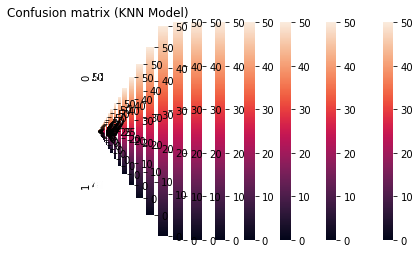

In [7]:
# Initialize variables to store results
shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    
    # Creating and running our optimization

    study_knn = optuna.create_study(direction='maximize',study_name = "KNN")
    with parallel_backend('threading'):
        study_knn.optimize(objective_knn, n_trials=10, n_jobs=-1)
    
    # Evaluating our Optuna Trial
    print("Best trial:", study_knn.best_trial.number)
    print("Best accuracy:", study_knn.best_trial.value)
    print("Best hyperparameters:", study_knn.best_params)
    
    best_param_knn = study_knn.best_params
    KNN = KNeighborsClassifier(**best_param_knn).fit(x_train_,y_train)
    y_pred_knn = KNN.predict(x_test_)

    

    display_results(y_test, y_pred_knn, cm_title = "Confusion matrix (KNN Model)")

    
    # SHAP value computation using parallel processing
    num_cores = -1  # Use all available cores
    shap_values = compute_shap_values(KNN, x_test_, num_cores)


    # Extract SHAP values
    shap_values_array = abs(shap_values)

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)



In [8]:
all_shap_values_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,0.025679,0.029726,0.000798,0.033655,0.063917,0.014655,0.003155,0.018417,0
1,0.082774,0.004988,0.009464,0.016179,0.091488,0.003440,0.003036,0.052845,0
2,0.006905,0.074214,0.001381,0.038929,0.075214,0.004071,0.002000,0.001095,0
3,0.044881,0.015643,0.000048,0.021881,0.083143,0.003810,0.000762,0.029071,0
4,0.007893,0.028893,0.016512,0.036417,0.082988,0.006893,0.007964,0.002440,0
...,...,...,...,...,...,...,...,...,...
4995,0.104583,0.089726,0.018774,0.033655,0.043560,0.077536,0.012940,0.130774,1
4996,0.036369,0.250536,0.011774,0.069821,0.344440,0.025321,0.002155,0.009583,1
4997,0.034417,0.021631,0.057988,0.104107,0.264226,0.141655,0.106417,0.062821,1
4998,0.007143,0.217714,0.056548,0.077929,0.255190,0.037071,0.044452,0.053952,1


# value stabilty

In [9]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]

In [10]:
# Call the add_to_df function to populate valuestability
add_to_df()
# Calculate the sum of each row
row_sums = valuestability.sum(axis=1)

# Calculate the number of columns
num_columns = valuestability.shape[1]

# Calculate the average
valstability = row_sums / num_columns

# Add the new column to the DataFrame
valuestability['valstability'] = valstability
# Save the DataFrame to an Excel file
valuestability.to_excel('10_knn_valuestability.xlsx', index=False)
valuestability


Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,valstability
0,0.344905,0.564767,0.810732,0.213681,0.297315,0.528484,0.747119,0.952232,0.557404
1,0.220589,1.244943,1.520333,0.402883,0.578040,0.580272,0.496548,0.400936,0.680568
2,0.518140,0.331124,0.670994,0.393847,0.370169,0.609064,1.010361,1.342182,0.655735
3,0.403200,0.519313,1.443596,0.485942,0.459373,1.113993,0.976631,0.648330,0.756297
4,0.487686,0.282320,0.456210,0.562432,0.377246,0.782115,0.952515,0.596568,0.562136
...,...,...,...,...,...,...,...,...,...
95,0.934807,0.406061,1.314812,0.572723,0.573717,0.485595,0.510818,1.415290,0.776728
96,0.681878,0.237414,1.138135,0.579158,0.243203,1.232451,1.456395,1.055366,0.828000
97,0.339077,0.505522,1.331841,0.563636,0.915332,1.642148,0.691956,0.582891,0.821551
98,0.813080,0.349332,0.965222,0.502192,0.249208,0.479405,0.630963,0.593427,0.572854


In [11]:
valuestability

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,valstability
0,0.344905,0.564767,0.810732,0.213681,0.297315,0.528484,0.747119,0.952232,0.557404
1,0.220589,1.244943,1.520333,0.402883,0.578040,0.580272,0.496548,0.400936,0.680568
2,0.518140,0.331124,0.670994,0.393847,0.370169,0.609064,1.010361,1.342182,0.655735
3,0.403200,0.519313,1.443596,0.485942,0.459373,1.113993,0.976631,0.648330,0.756297
4,0.487686,0.282320,0.456210,0.562432,0.377246,0.782115,0.952515,0.596568,0.562136
...,...,...,...,...,...,...,...,...,...
95,0.934807,0.406061,1.314812,0.572723,0.573717,0.485595,0.510818,1.415290,0.776728
96,0.681878,0.237414,1.138135,0.579158,0.243203,1.232451,1.456395,1.055366,0.828000
97,0.339077,0.505522,1.331841,0.563636,0.915332,1.642148,0.691956,0.582891,0.821551
98,0.813080,0.349332,0.965222,0.502192,0.249208,0.479405,0.630963,0.593427,0.572854


## 4.3 Logistic Regression

In [12]:
df = pd.read_csv("data_resampled_50.csv")

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

def objective_lr(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }

    # Define hyperparameters
    param_logr = {
        'C': trial.suggest_float("C", 0.001, 10.0, log=True),
        'solver': trial.suggest_categorical('solver', ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]),
        'max_iter': trial.suggest_int("max_iter", 50, 1000),
        'class_weight': class_weight  # Apply custom class weights
    }

    # Create and train the model
    lr = LogisticRegression(**param_logr, random_state=42)
    
    # Evaluate the model using cross-validation with the f1_macro score to handle imbalance
    score = cross_val_score(lr, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score



In [14]:
# Initialize variables to store results
# Clear any existing elements in the lists if they were previously initialized

shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    
    # Creating and running our optimization
    
    # Creating and running our optimization

    study_lr = optuna.create_study(direction='maximize',study_name = "logr")
    with parallel_backend('threading'):
        study_lr.optimize(objective_lr, n_trials=10, n_jobs=-1)

    # Evaluating our Optuna Trial
    print("Best trial:", study_lr.best_trial.number)
    print("Best accuracy:", study_lr.best_trial.value)
    print("Best hyperparameters:", study_lr.best_params)

    # Train the model with the best parameters
    best_param_logr = study_lr.best_params
    LR = LogisticRegression(**best_param_logr, random_state=42).fit(x_train, y_train)


    
    # SHAP value computation using KernelExplainer
    explainer = shap.Explainer(LR, x_train_)
    shap_values = explainer(x_test_)


    # Extract SHAP values
    shap_values_array = abs(shap_values.values)

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)





[I 2024-08-26 18:47:16,290] A new study created in memory with name: logr
[I 2024-08-26 18:47:16,699] Trial 5 finished with value: 0.6981272095539113 and parameters: {'C': 0.0026062613397738387, 'solver': 'liblinear', 'max_iter': 427}. Best is trial 5 with value: 0.6981272095539113.
[I 2024-08-26 18:47:17,242] Trial 4 finished with value: 0.6953247637222756 and parameters: {'C': 0.13194648770953576, 'solver': 'saga', 'max_iter': 104}. Best is trial 5 with value: 0.6981272095539113.
[I 2024-08-26 18:47:17,482] Trial 0 finished with value: 0.6955918797443664 and parameters: {'C': 0.036633283179645475, 'solver': 'saga', 'max_iter': 154}. Best is trial 5 with value: 0.6981272095539113.
[I 2024-08-26 18:47:17,947] Trial 8 finished with value: 0.6981272095539113 and parameters: {'C': 0.0025309964004044936, 'solver': 'liblinear', 'max_iter': 696}. Best is trial 5 with value: 0.6981272095539113.
[I 2024-08-26 18:47:18,380] Trial 1 finished with value: 0.6962154726240357 and parameters: {'C': 1

Best trial: 2
Best accuracy: 0.7888907092086203
Best hyperparameters: {'C': 0.036563267123943435, 'solver': 'newton-cg', 'max_iter': 521}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019636  0.016338       0.000774       0.008443  0.001597  0.051366   
1      0.080925  0.006559       0.002404       0.099313  0.001454  0.015668   
2      0.080925  0.016338       0.013487       0.056907  0.008930  0.094805   
3      0.024862  0.005978       0.007266       0.050812  0.001715  0.033330   
4      0.072298  0.027203       0.009514       0.008443  0.011829  0.041125   
..          ...       ...            ...            ...       ...       ...   
95     0.225521  0.027124       0.007966       0.026617  0.000682  0.032426   
96     0.080925  0.053201       0.000021       0.070311  0.000377  0.090469   
97     0.111570  0.076019       0.003199       0.088485  0.006632  0.010401   
98     0.011009  0.028211       0.003199       0.020559  0.009965  0.050

[I 2024-08-26 18:47:23,252] Trial 1 finished with value: 0.7349834958742693 and parameters: {'C': 0.0486661737435154, 'solver': 'liblinear', 'max_iter': 677}. Best is trial 1 with value: 0.7349834958742693.
[I 2024-08-26 18:47:23,505] Trial 4 finished with value: 0.6955918797443664 and parameters: {'C': 0.42040767879010105, 'solver': 'sag', 'max_iter': 74}. Best is trial 1 with value: 0.7349834958742693.
[I 2024-08-26 18:47:24,328] Trial 7 finished with value: 0.694900095614835 and parameters: {'C': 5.279207287690218, 'solver': 'sag', 'max_iter': 54}. Best is trial 1 with value: 0.7349834958742693.
[I 2024-08-26 18:47:24,652] Trial 0 finished with value: 0.7000635360207086 and parameters: {'C': 6.104537719583884, 'solver': 'sag', 'max_iter': 325}. Best is trial 1 with value: 0.7349834958742693.
[I 2024-08-26 18:47:26,364] Trial 6 finished with value: 0.7058751406296063 and parameters: {'C': 0.2604807366773183, 'solver': 'sag', 'max_iter': 564}. Best is trial 1 with value: 0.73498349587

Best trial: 3
Best accuracy: 0.7947957970442991
Best hyperparameters: {'C': 0.6997119751356102, 'solver': 'lbfgs', 'max_iter': 570}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020887  0.016344       0.000701       0.008360  0.001581  0.049360   
1      0.086081  0.006561       0.002178       0.098335  0.001439  0.015056   
2      0.086081  0.016344       0.012219       0.056346  0.008838  0.091102   
3      0.026446  0.005980       0.006583       0.050311  0.001698  0.032028   
4      0.076904  0.027213       0.008620       0.008360  0.011706  0.039519   
..          ...       ...            ...            ...       ...       ...   
95     0.239890  0.027134       0.007218       0.026355  0.000675  0.031160   
96     0.086081  0.053220       0.000019       0.069619  0.000373  0.086936   
97     0.118678  0.076046       0.002898       0.087614  0.006563  0.009995   
98     0.011710  0.028221       0.002898       0.020356  0.009862  0.048159   

[I 2024-08-26 18:47:32,007] Trial 0 finished with value: 0.7253549593708085 and parameters: {'C': 0.03610951853915817, 'solver': 'liblinear', 'max_iter': 771}. Best is trial 0 with value: 0.7253549593708085.
[I 2024-08-26 18:47:32,835] Trial 1 finished with value: 0.7032986730565789 and parameters: {'C': 0.0019099636914420815, 'solver': 'sag', 'max_iter': 258}. Best is trial 0 with value: 0.7253549593708085.
[I 2024-08-26 18:47:34,752] Trial 2 finished with value: 0.7127997418697477 and parameters: {'C': 0.6208139530059343, 'solver': 'sag', 'max_iter': 734}. Best is trial 0 with value: 0.7253549593708085.
[I 2024-08-26 18:47:34,769] Trial 3 finished with value: 0.7124852124467077 and parameters: {'C': 0.10894742259753037, 'solver': 'sag', 'max_iter': 738}. Best is trial 0 with value: 0.7253549593708085.
[I 2024-08-26 18:47:37,391] Trial 7 finished with value: 0.703536979973806 and parameters: {'C': 2.0501607991193924, 'solver': 'saga', 'max_iter': 935}. Best is trial 0 with value: 0.72

Best trial: 4
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 1.9638844652823633, 'solver': 'lbfgs', 'max_iter': 913}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021051  0.016371       0.000686       0.008353  0.001580  0.049042   
1      0.086759  0.006572       0.002131       0.098253  0.001439  0.014959   
2      0.086759  0.016371       0.011952       0.056300  0.008835  0.090515   
3      0.026654  0.005990       0.006439       0.050270  0.001697  0.031821   
4      0.077509  0.027258       0.008432       0.008353  0.011702  0.039264   
..          ...       ...            ...            ...       ...       ...   
95     0.241777  0.027179       0.007060       0.026333  0.000675  0.030959   
96     0.086759  0.053308       0.000018       0.069561  0.000373  0.086375   
97     0.119612  0.076172       0.002835       0.087541  0.006561  0.009930   
98     0.011802  0.028267       0.002835       0.020340  0.009859  0.047848   

[I 2024-08-26 18:47:44,882] Trial 3 finished with value: 0.7012148371603414 and parameters: {'C': 0.0011199816105812428, 'solver': 'sag', 'max_iter': 297}. Best is trial 3 with value: 0.7012148371603414.
[I 2024-08-26 18:47:47,659] Trial 1 finished with value: 0.7022208214741326 and parameters: {'C': 2.6198239011411766, 'solver': 'saga', 'max_iter': 829}. Best is trial 1 with value: 0.7022208214741326.
[I 2024-08-26 18:47:48,151] Trial 4 finished with value: 0.7035454914312538 and parameters: {'C': 0.3460993984238346, 'solver': 'saga', 'max_iter': 921}. Best is trial 4 with value: 0.7035454914312538.
[I 2024-08-26 18:47:49,448] Trial 6 finished with value: 0.7032524341861418 and parameters: {'C': 2.2582937365908444, 'solver': 'saga', 'max_iter': 892}. Best is trial 4 with value: 0.7035454914312538.
[I 2024-08-26 18:47:50,171] Trial 7 finished with value: 0.6969002485487894 and parameters: {'C': 0.07631555784726811, 'solver': 'saga', 'max_iter': 433}. Best is trial 4 with value: 0.70354

Best trial: 0
Best accuracy: 0.7936980027828217
Best hyperparameters: {'C': 0.26538474347880936, 'solver': 'lbfgs', 'max_iter': 188}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020623  0.016319       0.000727       0.008378  0.001583  0.049950   
1      0.084993  0.006551       0.002259       0.098555  0.001441  0.015236   
2      0.084993  0.016319       0.012672       0.056472  0.008851  0.092192   
3      0.026111  0.005971       0.006827       0.050424  0.001700  0.032411   
4      0.075932  0.027172       0.008939       0.008378  0.011725  0.039991   
..          ...       ...            ...            ...       ...       ...   
95     0.236857  0.027093       0.007485       0.026414  0.000676  0.031533   
96     0.084993  0.053139       0.000019       0.069774  0.000373  0.087976   
97     0.117178  0.075930       0.003006       0.087810  0.006574  0.010114   
98     0.011562  0.028178       0.003006       0.020402  0.009877  0.048735  

[I 2024-08-26 18:47:57,367] Trial 0 finished with value: 0.696922438894905 and parameters: {'C': 1.831419049210256, 'solver': 'saga', 'max_iter': 456}. Best is trial 0 with value: 0.696922438894905.
[I 2024-08-26 18:47:57,729] Trial 6 finished with value: 0.7819556145041834 and parameters: {'C': 0.5366873133895584, 'solver': 'liblinear', 'max_iter': 743}. Best is trial 6 with value: 0.7819556145041834.
[I 2024-08-26 18:47:57,777] Trial 3 finished with value: 0.6984952438307989 and parameters: {'C': 1.2946286882453777, 'solver': 'saga', 'max_iter': 516}. Best is trial 6 with value: 0.7819556145041834.
[I 2024-08-26 18:47:58,152] Trial 7 finished with value: 0.7904573187409365 and parameters: {'C': 2.3348253920540105, 'solver': 'liblinear', 'max_iter': 801}. Best is trial 7 with value: 0.7904573187409365.
[I 2024-08-26 18:47:58,349] Trial 5 finished with value: 0.7020860736649251 and parameters: {'C': 0.012490388147832788, 'solver': 'saga', 'max_iter': 630}. Best is trial 7 with value: 0

Best trial: 4
Best accuracy: 0.7947825028529456
Best hyperparameters: {'C': 0.35854071910367596, 'solver': 'newton-cg', 'max_iter': 700}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020717  0.016324       0.000718       0.008368  0.001582  0.049741   
1      0.085378  0.006553       0.002229       0.098438  0.001440  0.015172   
2      0.085378  0.016324       0.012505       0.056406  0.008845  0.091805   
3      0.026230  0.005973       0.006737       0.050364  0.001699  0.032275   
4      0.076276  0.027180       0.008822       0.008368  0.011716  0.039823   
..          ...       ...            ...            ...       ...       ...   
95     0.237931  0.027101       0.007387       0.026382  0.000675  0.031400   
96     0.085378  0.053156       0.000019       0.069692  0.000373  0.087607   
97     0.117709  0.075954       0.002966       0.087706  0.006569  0.010072   
98     0.011614  0.028187       0.002966       0.020378  0.009870  0.0485

[I 2024-08-26 18:48:01,461] Trial 3 finished with value: 0.702047641889388 and parameters: {'C': 0.00732186425222949, 'solver': 'liblinear', 'max_iter': 537}. Best is trial 3 with value: 0.702047641889388.
[I 2024-08-26 18:48:01,510] Trial 4 finished with value: 0.7922942933355951 and parameters: {'C': 6.936889915966702, 'solver': 'liblinear', 'max_iter': 50}. Best is trial 4 with value: 0.7922942933355951.
[I 2024-08-26 18:48:02,866] Trial 7 finished with value: 0.6981974070804202 and parameters: {'C': 0.27848583867808724, 'solver': 'sag', 'max_iter': 243}. Best is trial 4 with value: 0.7922942933355951.
[I 2024-08-26 18:48:03,492] Trial 6 finished with value: 0.7012406492429746 and parameters: {'C': 0.001706478213321931, 'solver': 'saga', 'max_iter': 399}. Best is trial 4 with value: 0.7922942933355951.
[I 2024-08-26 18:48:03,741] Trial 2 finished with value: 0.7099614585912505 and parameters: {'C': 0.03536001029358139, 'solver': 'sag', 'max_iter': 651}. Best is trial 4 with value: 0

Best trial: 1
Best accuracy: 0.7947957970442991
Best hyperparameters: {'C': 0.7046861306297878, 'solver': 'newton-cg', 'max_iter': 905}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020885  0.016344       0.000701       0.008359  0.001581  0.049355   
1      0.086071  0.006561       0.002178       0.098322  0.001439  0.015054   
2      0.086071  0.016344       0.012218       0.056339  0.008837  0.091093   
3      0.026442  0.005980       0.006582       0.050305  0.001697  0.032025   
4      0.076895  0.027213       0.008619       0.008359  0.011706  0.039515   
..          ...       ...            ...            ...       ...       ...   
95     0.239861  0.027134       0.007217       0.026351  0.000675  0.031157   
96     0.086071  0.053220       0.000019       0.069610  0.000373  0.086927   
97     0.118664  0.076046       0.002898       0.087602  0.006563  0.009994   
98     0.011709  0.028221       0.002898       0.020354  0.009862  0.04815

[I 2024-08-26 18:48:11,345] Trial 2 finished with value: 0.6990049951917784 and parameters: {'C': 0.005235717009646155, 'solver': 'liblinear', 'max_iter': 1000}. Best is trial 2 with value: 0.6990049951917784.
[I 2024-08-26 18:48:11,392] Trial 4 finished with value: 0.7537036559055408 and parameters: {'C': 0.0852020405326299, 'solver': 'liblinear', 'max_iter': 876}. Best is trial 4 with value: 0.7537036559055408.
[I 2024-08-26 18:48:12,408] Trial 1 finished with value: 0.7004507334705034 and parameters: {'C': 0.007982954175871809, 'solver': 'sag', 'max_iter': 253}. Best is trial 4 with value: 0.7537036559055408.
[I 2024-08-26 18:48:12,904] Trial 8 finished with value: 0.7021168394881333 and parameters: {'C': 0.007723859160398161, 'solver': 'liblinear', 'max_iter': 794}. Best is trial 4 with value: 0.7537036559055408.
[I 2024-08-26 18:48:12,938] Trial 0 finished with value: 0.696517317745646 and parameters: {'C': 0.7695077413740898, 'solver': 'saga', 'max_iter': 354}. Best is trial 4 wi

Best trial: 5
Best accuracy: 0.7947170551372086
Best hyperparameters: {'C': 0.28528965443366827, 'solver': 'newton-cg', 'max_iter': 939}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020648  0.016319       0.000724       0.008374  0.001583  0.049909   
1      0.085095  0.006551       0.002251       0.098499  0.001441  0.015223   
2      0.085095  0.016319       0.012625       0.056441  0.008849  0.092115   
3      0.026143  0.005971       0.006802       0.050395  0.001700  0.032384   
4      0.076023  0.027172       0.008906       0.008374  0.011722  0.039958   
..          ...       ...            ...            ...       ...       ...   
95     0.237141  0.027093       0.007457       0.026399  0.000676  0.031506   
96     0.085095  0.053140       0.000019       0.069735  0.000373  0.087902   
97     0.117318  0.075931       0.002994       0.087760  0.006572  0.010106   
98     0.011576  0.028178       0.002994       0.020390  0.009875  0.0486

[I 2024-08-26 18:48:17,952] Trial 5 finished with value: 0.7195453633056672 and parameters: {'C': 0.026057563293368696, 'solver': 'liblinear', 'max_iter': 372}. Best is trial 5 with value: 0.7195453633056672.
[I 2024-08-26 18:48:17,963] Trial 1 finished with value: 0.7922942933355951 and parameters: {'C': 6.69643302353776, 'solver': 'liblinear', 'max_iter': 738}. Best is trial 1 with value: 0.7922942933355951.
[I 2024-08-26 18:48:17,966] Trial 2 finished with value: 0.7720023713476629 and parameters: {'C': 0.18763235045999327, 'solver': 'liblinear', 'max_iter': 736}. Best is trial 1 with value: 0.7922942933355951.
[I 2024-08-26 18:48:19,570] Trial 8 finished with value: 0.701797357445261 and parameters: {'C': 0.0014925714973692333, 'solver': 'sag', 'max_iter': 930}. Best is trial 1 with value: 0.7922942933355951.
[I 2024-08-26 18:48:21,692] Trial 9 finished with value: 0.7048068840396023 and parameters: {'C': 0.008615804695404823, 'solver': 'sag', 'max_iter': 379}. Best is trial 1 with

Best trial: 0
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 6.962967815381927, 'solver': 'lbfgs', 'max_iter': 460}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021115  0.016386       0.000681       0.008351  0.001580  0.048899   
1      0.087022  0.006578       0.002117       0.098238  0.001438  0.014916   
2      0.087022  0.016386       0.011874       0.056291  0.008834  0.090253   
3      0.026735  0.005996       0.006397       0.050262  0.001697  0.031729   
4      0.077745  0.027284       0.008376       0.008351  0.011702  0.039150   
..          ...       ...            ...            ...       ...       ...   
95     0.242512  0.027204       0.007014       0.026329  0.000675  0.030869   
96     0.087022  0.053359       0.000018       0.069550  0.000373  0.086125   
97     0.119976  0.076244       0.002816       0.087527  0.006561  0.009901   
98     0.011838  0.028294       0.002816       0.020336  0.009858  0.047709   


[I 2024-08-26 18:48:28,823] Trial 5 finished with value: 0.7053172796339203 and parameters: {'C': 0.010323796602200721, 'solver': 'liblinear', 'max_iter': 448}. Best is trial 5 with value: 0.7053172796339203.
[I 2024-08-26 18:48:28,910] Trial 3 finished with value: 0.7911705039881254 and parameters: {'C': 3.9416436801238364, 'solver': 'liblinear', 'max_iter': 892}. Best is trial 3 with value: 0.7911705039881254.
[I 2024-08-26 18:48:29,388] Trial 6 finished with value: 0.7081073292225883 and parameters: {'C': 0.01401207201571835, 'solver': 'liblinear', 'max_iter': 883}. Best is trial 3 with value: 0.7911705039881254.
[I 2024-08-26 18:48:29,957] Trial 8 finished with value: 0.699276322310607 and parameters: {'C': 0.0017348910392665702, 'solver': 'liblinear', 'max_iter': 725}. Best is trial 3 with value: 0.7911705039881254.
[I 2024-08-26 18:48:30,171] Trial 1 finished with value: 0.7055782068218638 and parameters: {'C': 0.002216657383417431, 'solver': 'sag', 'max_iter': 867}. Best is tria

Best trial: 3
Best accuracy: 0.7911705039881254
Best hyperparameters: {'C': 3.9416436801238364, 'solver': 'liblinear', 'max_iter': 892}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020145  0.014335       0.002273       0.007245  0.001462  0.036647   
1      0.083024  0.005755       0.007061       0.085222  0.001331  0.011178   
2      0.083024  0.014335       0.039606       0.048833  0.008176  0.067638   
3      0.025506  0.005245       0.021337       0.043602  0.001570  0.023779   
4      0.074173  0.023868       0.027940       0.007245  0.010830  0.029340   
..          ...       ...            ...            ...       ...       ...   
95     0.231370  0.023799       0.023394       0.022840  0.000624  0.023134   
96     0.083024  0.046678       0.000061       0.060335  0.000345  0.064544   
97     0.114463  0.066698       0.009394       0.075931  0.006072  0.007420   
98     0.011294  0.024752       0.009394       0.017642  0.009124  0.03575

[I 2024-08-26 18:48:34,430] Trial 5 finished with value: 0.7213725402860294 and parameters: {'C': 0.02831735550126346, 'solver': 'liblinear', 'max_iter': 396}. Best is trial 5 with value: 0.7213725402860294.
[I 2024-08-26 18:48:34,511] Trial 4 finished with value: 0.790168484496067 and parameters: {'C': 1.8276254392885767, 'solver': 'liblinear', 'max_iter': 280}. Best is trial 4 with value: 0.790168484496067.
[I 2024-08-26 18:48:35,180] Trial 3 finished with value: 0.6955918797443664 and parameters: {'C': 0.022780702105959522, 'solver': 'saga', 'max_iter': 177}. Best is trial 4 with value: 0.790168484496067.
[I 2024-08-26 18:48:35,995] Trial 8 finished with value: 0.7239997679285582 and parameters: {'C': 0.030283074022298, 'solver': 'liblinear', 'max_iter': 773}. Best is trial 4 with value: 0.790168484496067.
[I 2024-08-26 18:48:36,539] Trial 0 finished with value: 0.6984952438307989 and parameters: {'C': 0.24484634540423286, 'solver': 'saga', 'max_iter': 548}. Best is trial 4 with val

Best trial: 2
Best accuracy: 0.7947170551372086
Best hyperparameters: {'C': 0.27851015763642445, 'solver': 'lbfgs', 'max_iter': 715}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020646  0.016320       0.000727       0.008369  0.001582  0.049993   
1      0.085086  0.006552       0.002258       0.098447  0.001441  0.015249   
2      0.085086  0.016320       0.012665       0.056411  0.008847  0.092271   
3      0.026140  0.005971       0.006823       0.050369  0.001699  0.032439   
4      0.076015  0.027173       0.008934       0.008369  0.011719  0.040025   
..          ...       ...            ...            ...       ...       ...   
95     0.237117  0.027094       0.007481       0.026385  0.000676  0.031560   
96     0.085086  0.053142       0.000019       0.069699  0.000373  0.088051   
97     0.117306  0.075934       0.003004       0.087714  0.006570  0.010123   
98     0.011575  0.028179       0.003004       0.020380  0.009873  0.048776  

[I 2024-08-26 18:48:48,042] Trial 1 finished with value: 0.7134793220317556 and parameters: {'C': 0.01976975980702717, 'solver': 'liblinear', 'max_iter': 351}. Best is trial 1 with value: 0.7134793220317556.
[I 2024-08-26 18:48:48,099] Trial 0 finished with value: 0.7926089204831741 and parameters: {'C': 7.623167261339816, 'solver': 'liblinear', 'max_iter': 285}. Best is trial 0 with value: 0.7926089204831741.
[I 2024-08-26 18:48:50,382] Trial 7 finished with value: 0.7054962280847381 and parameters: {'C': 0.0049273310245213425, 'solver': 'sag', 'max_iter': 395}. Best is trial 0 with value: 0.7926089204831741.
[I 2024-08-26 18:48:50,996] Trial 4 finished with value: 0.7143236864137593 and parameters: {'C': 0.01707087913870618, 'solver': 'sag', 'max_iter': 746}. Best is trial 0 with value: 0.7926089204831741.
[I 2024-08-26 18:48:51,019] Trial 5 finished with value: 0.7007694452667369 and parameters: {'C': 4.196173837629738, 'solver': 'saga', 'max_iter': 675}. Best is trial 0 with value:

Best trial: 6
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 2.6701123917926064, 'solver': 'lbfgs', 'max_iter': 299}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021101  0.016382       0.000678       0.008364  0.001580  0.048948   
1      0.086964  0.006577       0.002106       0.098381  0.001439  0.014930   
2      0.086964  0.016382       0.011813       0.056373  0.008835  0.090342   
3      0.026717  0.005994       0.006364       0.050335  0.001697  0.031760   
4      0.077693  0.027277       0.008334       0.008364  0.011703  0.039188   
..          ...       ...            ...            ...       ...       ...   
95     0.242349  0.027198       0.006978       0.026367  0.000675  0.030900   
96     0.086964  0.053346       0.000018       0.069652  0.000373  0.086210   
97     0.119895  0.076226       0.002802       0.087655  0.006562  0.009911   
98     0.011830  0.028288       0.002802       0.020366  0.009859  0.047756   

[I 2024-08-26 18:49:01,386] Trial 5 finished with value: 0.7271187862157801 and parameters: {'C': 0.039056379798948895, 'solver': 'liblinear', 'max_iter': 608}. Best is trial 5 with value: 0.7271187862157801.
[I 2024-08-26 18:49:01,452] Trial 1 finished with value: 0.7922942933355951 and parameters: {'C': 6.714553729505603, 'solver': 'liblinear', 'max_iter': 515}. Best is trial 1 with value: 0.7922942933355951.
[I 2024-08-26 18:49:01,842] Trial 2 finished with value: 0.6951310893769691 and parameters: {'C': 0.3857237177936021, 'solver': 'sag', 'max_iter': 92}. Best is trial 1 with value: 0.7922942933355951.
[I 2024-08-26 18:49:01,872] Trial 6 finished with value: 0.7451074044060545 and parameters: {'C': 0.06484810456686368, 'solver': 'liblinear', 'max_iter': 205}. Best is trial 1 with value: 0.7922942933355951.
[I 2024-08-26 18:49:02,225] Trial 9 finished with value: 0.702715542543993 and parameters: {'C': 0.007854004330212758, 'solver': 'liblinear', 'max_iter': 809}. Best is trial 1 w

Best trial: 1
Best accuracy: 0.7922942933355951
Best hyperparameters: {'C': 6.714553729505603, 'solver': 'liblinear', 'max_iter': 515}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020433  0.014947       0.001775       0.007567  0.001496  0.040409   
1      0.084211  0.006001       0.005513       0.089010  0.001361  0.012326   
2      0.084211  0.014947       0.030927       0.051003  0.008361  0.074583   
3      0.025871  0.005469       0.016661       0.045540  0.001606  0.026220   
4      0.075234  0.024888       0.021817       0.007567  0.011075  0.032353   
..          ...       ...            ...            ...       ...       ...   
95     0.234678  0.024815       0.018267       0.023855  0.000638  0.025510   
96     0.084211  0.048673       0.000047       0.063017  0.000353  0.071172   
97     0.116100  0.069548       0.007335       0.079305  0.006210  0.008182   
98     0.011456  0.025809       0.007335       0.018426  0.009331  0.039426

[I 2024-08-26 18:49:07,069] Trial 1 finished with value: 0.6997735421247444 and parameters: {'C': 0.004109254017017469, 'solver': 'sag', 'max_iter': 218}. Best is trial 1 with value: 0.6997735421247444.
[I 2024-08-26 18:49:07,366] Trial 3 finished with value: 0.6988069722258606 and parameters: {'C': 0.03850907902842772, 'solver': 'sag', 'max_iter': 281}. Best is trial 1 with value: 0.6997735421247444.
[I 2024-08-26 18:49:08,926] Trial 7 finished with value: 0.6955918797443664 and parameters: {'C': 0.1073281064568111, 'solver': 'saga', 'max_iter': 163}. Best is trial 1 with value: 0.6997735421247444.
[I 2024-08-26 18:49:09,115] Trial 5 finished with value: 0.7157978164788606 and parameters: {'C': 0.018870411026360626, 'solver': 'sag', 'max_iter': 771}. Best is trial 5 with value: 0.7157978164788606.
[I 2024-08-26 18:49:09,919] Trial 8 finished with value: 0.7908425740380304 and parameters: {'C': 3.154501250899406, 'solver': 'liblinear', 'max_iter': 863}. Best is trial 8 with value: 0.79

Best trial: 4
Best accuracy: 0.7940582896763867
Best hyperparameters: {'C': 0.30829017362160904, 'solver': 'lbfgs', 'max_iter': 150}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020674  0.016320       0.000723       0.008373  0.001582  0.049844   
1      0.085204  0.006552       0.002245       0.098496  0.001441  0.015204   
2      0.085204  0.016320       0.012593       0.056439  0.008847  0.091996   
3      0.026176  0.005971       0.006784       0.050394  0.001699  0.032342   
4      0.076120  0.027174       0.008883       0.008373  0.011719  0.039906   
..          ...       ...            ...            ...       ...       ...   
95     0.237445  0.027095       0.007438       0.026398  0.000676  0.031465   
96     0.085204  0.053144       0.000019       0.069733  0.000373  0.087788   
97     0.117469  0.075937       0.002987       0.087758  0.006571  0.010093   
98     0.011591  0.028180       0.002987       0.020390  0.009873  0.048631  

[I 2024-08-26 18:49:15,504] Trial 0 finished with value: 0.7720681118736352 and parameters: {'C': 0.3019531106379286, 'solver': 'liblinear', 'max_iter': 874}. Best is trial 0 with value: 0.7720681118736352.
[I 2024-08-26 18:49:15,559] Trial 5 finished with value: 0.7893770742419417 and parameters: {'C': 1.103296156553433, 'solver': 'liblinear', 'max_iter': 631}. Best is trial 5 with value: 0.7893770742419417.
[I 2024-08-26 18:49:15,572] Trial 4 finished with value: 0.7891675050475846 and parameters: {'C': 1.07048014816055, 'solver': 'liblinear', 'max_iter': 427}. Best is trial 5 with value: 0.7893770742419417.
[I 2024-08-26 18:49:16,531] Trial 6 finished with value: 0.6949227023860971 and parameters: {'C': 0.6616079490890553, 'solver': 'sag', 'max_iter': 62}. Best is trial 5 with value: 0.7893770742419417.
[I 2024-08-26 18:49:16,796] Trial 1 finished with value: 0.696517317745646 and parameters: {'C': 0.35877798920286563, 'solver': 'saga', 'max_iter': 356}. Best is trial 5 with value: 

Best trial: 7
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.548173961023227, 'solver': 'newton-cg', 'max_iter': 375}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021013  0.016365       0.000689       0.008354  0.001580  0.049092   
1      0.086599  0.006570       0.002141       0.098266  0.001439  0.014974   
2      0.086599  0.016365       0.012010       0.056307  0.008835  0.090608   
3      0.026605  0.005988       0.006470       0.050276  0.001697  0.031854   
4      0.077367  0.027249       0.008472       0.008354  0.011703  0.039304   
..          ...       ...            ...            ...       ...       ...   
95     0.241332  0.027170       0.007094       0.026336  0.000675  0.030991   
96     0.086599  0.053291       0.000018       0.069570  0.000373  0.086464   
97     0.119392  0.076147       0.002849       0.087552  0.006561  0.009940   
98     0.011780  0.028258       0.002849       0.020342  0.009859  0.047897 

[I 2024-08-26 18:49:27,478] Trial 4 finished with value: 0.7055782068218638 and parameters: {'C': 0.0022637939335134636, 'solver': 'sag', 'max_iter': 870}. Best is trial 4 with value: 0.7055782068218638.
[I 2024-08-26 18:49:27,536] Trial 0 finished with value: 0.7005930008971394 and parameters: {'C': 0.0473267000885322, 'solver': 'sag', 'max_iter': 337}. Best is trial 4 with value: 0.7055782068218638.
[I 2024-08-26 18:49:28,067] Trial 2 finished with value: 0.6962214544488995 and parameters: {'C': 0.2941914450891819, 'solver': 'saga', 'max_iter': 422}. Best is trial 4 with value: 0.7055782068218638.
[I 2024-08-26 18:49:29,191] Trial 3 finished with value: 0.7139259098261291 and parameters: {'C': 0.01797994353695548, 'solver': 'sag', 'max_iter': 735}. Best is trial 3 with value: 0.7139259098261291.
[I 2024-08-26 18:49:29,811] Trial 7 finished with value: 0.7014888814409482 and parameters: {'C': 0.023858074184526512, 'solver': 'sag', 'max_iter': 361}. Best is trial 3 with value: 0.713925

Best trial: 5
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.9630587472633061, 'solver': 'lbfgs', 'max_iter': 615}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020965  0.016359       0.000687       0.008360  0.001581  0.049201   
1      0.086403  0.006567       0.002135       0.098340  0.001439  0.015008   
2      0.086403  0.016359       0.011978       0.056349  0.008837  0.090809   
3      0.026545  0.005986       0.006453       0.050314  0.001697  0.031925   
4      0.077192  0.027238       0.008449       0.008360  0.011706  0.039391   
..          ...       ...            ...            ...       ...       ...   
95     0.240786  0.027159       0.007075       0.026356  0.000675  0.031060   
96     0.086403  0.053270       0.000018       0.069622  0.000373  0.086656   
97     0.119122  0.076117       0.002841       0.087618  0.006563  0.009962   
98     0.011754  0.028247       0.002841       0.020357  0.009861  0.048004   


[I 2024-08-26 18:49:35,601] Trial 4 finished with value: 0.6951310893769691 and parameters: {'C': 0.11425091072949439, 'solver': 'saga', 'max_iter': 196}. Best is trial 4 with value: 0.6951310893769691.
[I 2024-08-26 18:49:37,713] Trial 1 finished with value: 0.7085276477690329 and parameters: {'C': 0.28791192891402667, 'solver': 'sag', 'max_iter': 656}. Best is trial 1 with value: 0.7085276477690329.
[I 2024-08-26 18:49:37,797] Trial 5 finished with value: 0.7020669407909679 and parameters: {'C': 0.007159377737942315, 'solver': 'saga', 'max_iter': 603}. Best is trial 1 with value: 0.7085276477690329.
[I 2024-08-26 18:49:38,967] Trial 2 finished with value: 0.7038259169093877 and parameters: {'C': 0.024787974882972175, 'solver': 'saga', 'max_iter': 859}. Best is trial 1 with value: 0.7085276477690329.
[I 2024-08-26 18:49:38,995] Trial 3 finished with value: 0.7067406594203686 and parameters: {'C': 0.007432220253715286, 'solver': 'saga', 'max_iter': 898}. Best is trial 1 with value: 0.7

Best trial: 0
Best accuracy: 0.7947170551372086
Best hyperparameters: {'C': 0.27322916655373514, 'solver': 'lbfgs', 'max_iter': 858}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020643  0.016317       0.000729       0.008371  0.001583  0.049947   
1      0.085077  0.006550       0.002264       0.098466  0.001441  0.015235   
2      0.085077  0.016317       0.012700       0.056421  0.008849  0.092186   
3      0.026137  0.005970       0.006842       0.050378  0.001700  0.032409   
4      0.076007  0.027168       0.008959       0.008371  0.011721  0.039988   
..          ...       ...            ...            ...       ...       ...   
95     0.237092  0.027089       0.007501       0.026390  0.000676  0.031530   
96     0.085077  0.053133       0.000019       0.069711  0.000373  0.087969   
97     0.117294  0.075921       0.003012       0.087730  0.006572  0.010113   
98     0.011573  0.028174       0.003012       0.020383  0.009874  0.048731  

[I 2024-08-26 18:49:43,194] Trial 3 finished with value: 0.6951310893769691 and parameters: {'C': 2.655532722011862, 'solver': 'saga', 'max_iter': 199}. Best is trial 3 with value: 0.6951310893769691.
[I 2024-08-26 18:49:43,788] Trial 2 finished with value: 0.6962154726240357 and parameters: {'C': 0.14622666245902172, 'solver': 'saga', 'max_iter': 342}. Best is trial 2 with value: 0.6962154726240357.
[I 2024-08-26 18:49:44,654] Trial 0 finished with value: 0.70906336051274 and parameters: {'C': 0.022444190449231724, 'solver': 'sag', 'max_iter': 603}. Best is trial 0 with value: 0.70906336051274.
[I 2024-08-26 18:49:45,527] Trial 1 finished with value: 0.7011887175251457 and parameters: {'C': 0.028261279316617215, 'solver': 'saga', 'max_iter': 696}. Best is trial 0 with value: 0.70906336051274.
[I 2024-08-26 18:49:45,666] Trial 5 finished with value: 0.7011901421987028 and parameters: {'C': 0.7449629296042608, 'solver': 'saga', 'max_iter': 695}. Best is trial 0 with value: 0.70906336051

Best trial: 6
Best accuracy: 0.7947170551372086
Best hyperparameters: {'C': 0.2882617144450776, 'solver': 'newton-cg', 'max_iter': 330}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020651  0.016319       0.000724       0.008373  0.001583  0.049900   
1      0.085108  0.006551       0.002250       0.098496  0.001441  0.015221   
2      0.085108  0.016319       0.012620       0.056439  0.008849  0.092100   
3      0.026147  0.005971       0.006799       0.050394  0.001700  0.032379   
4      0.076035  0.027172       0.008902       0.008373  0.011722  0.039951   
..          ...       ...            ...            ...       ...       ...   
95     0.237178  0.027093       0.007454       0.026398  0.000676  0.031501   
96     0.085108  0.053141       0.000019       0.069733  0.000373  0.087888   
97     0.117337  0.075932       0.002993       0.087757  0.006572  0.010104   
98     0.011578  0.028178       0.002993       0.020390  0.009875  0.04868

[I 2024-08-26 18:49:52,477] Trial 1 finished with value: 0.6982814258302394 and parameters: {'C': 0.0020644542324573, 'solver': 'liblinear', 'max_iter': 288}. Best is trial 1 with value: 0.6982814258302394.
[I 2024-08-26 18:49:52,533] Trial 0 finished with value: 0.7568163293555211 and parameters: {'C': 0.10757097743907314, 'solver': 'liblinear', 'max_iter': 936}. Best is trial 0 with value: 0.7568163293555211.
[I 2024-08-26 18:49:52,590] Trial 3 finished with value: 0.7889362431669644 and parameters: {'C': 1.1178001398861575, 'solver': 'liblinear', 'max_iter': 311}. Best is trial 3 with value: 0.7889362431669644.
[I 2024-08-26 18:49:52,782] Trial 4 finished with value: 0.6970552825114988 and parameters: {'C': 0.0018293523556259567, 'solver': 'saga', 'max_iter': 75}. Best is trial 3 with value: 0.7889362431669644.
[I 2024-08-26 18:49:54,956] Trial 9 finished with value: 0.7025058078056307 and parameters: {'C': 0.1974633782069493, 'solver': 'sag', 'max_iter': 412}. Best is trial 3 with 

Best trial: 5
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.4432333402949207, 'solver': 'newton-cg', 'max_iter': 104}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021004  0.016364       0.000690       0.008354  0.001580  0.049109   
1      0.086563  0.006569       0.002144       0.098269  0.001439  0.014979   
2      0.086563  0.016364       0.012024       0.056308  0.008835  0.090639   
3      0.026594  0.005987       0.006478       0.050277  0.001697  0.031865   
4      0.077334  0.027247       0.008482       0.008354  0.011703  0.039318   
..          ...       ...            ...            ...       ...       ...   
95     0.241231  0.027167       0.007102       0.026337  0.000675  0.031001   
96     0.086563  0.053286       0.000018       0.069572  0.000373  0.086494   
97     0.119342  0.076139       0.002852       0.087555  0.006561  0.009944   
98     0.011776  0.028255       0.002852       0.020343  0.009859  0.047914

[I 2024-08-26 18:50:03,624] Trial 1 finished with value: 0.6994749449010014 and parameters: {'C': 0.0011790980562775676, 'solver': 'liblinear', 'max_iter': 978}. Best is trial 1 with value: 0.6994749449010014.
[I 2024-08-26 18:50:03,775] Trial 5 finished with value: 0.7735978854715471 and parameters: {'C': 0.32293158205396105, 'solver': 'liblinear', 'max_iter': 374}. Best is trial 5 with value: 0.7735978854715471.
[I 2024-08-26 18:50:04,355] Trial 3 finished with value: 0.6955918797443664 and parameters: {'C': 0.15906366234739028, 'solver': 'saga', 'max_iter': 145}. Best is trial 5 with value: 0.7735978854715471.
[I 2024-08-26 18:50:06,423] Trial 6 finished with value: 0.7109765271936125 and parameters: {'C': 0.003905061957264572, 'solver': 'sag', 'max_iter': 939}. Best is trial 5 with value: 0.7735978854715471.
[I 2024-08-26 18:50:07,235] Trial 9 finished with value: 0.7785186446220506 and parameters: {'C': 0.3745383312615864, 'solver': 'liblinear', 'max_iter': 461}. Best is trial 9 w

Best trial: 4
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.433823275878199, 'solver': 'newton-cg', 'max_iter': 651}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021003  0.016364       0.000690       0.008354  0.001580  0.049110   
1      0.086559  0.006569       0.002144       0.098269  0.001439  0.014980   
2      0.086559  0.016364       0.012025       0.056309  0.008835  0.090642   
3      0.026592  0.005987       0.006479       0.050278  0.001697  0.031866   
4      0.077331  0.027246       0.008483       0.008354  0.011703  0.039319   
..          ...       ...            ...            ...       ...       ...   
95     0.241222  0.027167       0.007103       0.026337  0.000675  0.031003   
96     0.086559  0.053285       0.000018       0.069572  0.000373  0.086497   
97     0.119337  0.076139       0.002852       0.087555  0.006561  0.009944   
98     0.011775  0.028255       0.002852       0.020343  0.009859  0.047915 

[I 2024-08-26 18:50:14,245] Trial 3 finished with value: 0.7081073292225883 and parameters: {'C': 0.01391379056119827, 'solver': 'liblinear', 'max_iter': 890}. Best is trial 3 with value: 0.7081073292225883.
[I 2024-08-26 18:50:14,256] Trial 4 finished with value: 0.7168538145609656 and parameters: {'C': 0.02385439386815151, 'solver': 'liblinear', 'max_iter': 681}. Best is trial 4 with value: 0.7168538145609656.
[I 2024-08-26 18:50:14,663] Trial 2 finished with value: 0.6958768660758645 and parameters: {'C': 0.019197411992256348, 'solver': 'sag', 'max_iter': 126}. Best is trial 4 with value: 0.7168538145609656.
[I 2024-08-26 18:50:16,204] Trial 7 finished with value: 0.6962154726240357 and parameters: {'C': 6.047838456383121, 'solver': 'saga', 'max_iter': 319}. Best is trial 4 with value: 0.7168538145609656.
[I 2024-08-26 18:50:16,616] Trial 8 finished with value: 0.6999511834445339 and parameters: {'C': 0.002356616555833984, 'solver': 'saga', 'max_iter': 322}. Best is trial 4 with val

Best trial: 0
Best accuracy: 0.792050784662601
Best hyperparameters: {'C': 0.11111793826059377, 'solver': 'newton-cg', 'max_iter': 853}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020302  0.016318       0.000755       0.008405  0.001588  0.050718   
1      0.083670  0.006551       0.002346       0.098870  0.001446  0.015470   
2      0.083670  0.016318       0.013158       0.056653  0.008880  0.093609   
3      0.025705  0.005971       0.007089       0.050585  0.001706  0.032909   
4      0.074750  0.027170       0.009282       0.008405  0.011763  0.040606   
..          ...       ...            ...            ...       ...       ...   
95     0.233171  0.027091       0.007772       0.026498  0.000678  0.032017   
96     0.083670  0.053137       0.000020       0.069998  0.000375  0.089328   
97     0.115355  0.075926       0.003121       0.088090  0.006595  0.010270   
98     0.011382  0.028176       0.003121       0.020467  0.009909  0.04948

[I 2024-08-26 18:50:23,151] Trial 5 finished with value: 0.7237070374032696 and parameters: {'C': 0.03043175934808468, 'solver': 'liblinear', 'max_iter': 472}. Best is trial 5 with value: 0.7237070374032696.
[I 2024-08-26 18:50:23,210] Trial 3 finished with value: 0.7908425740380304 and parameters: {'C': 2.9734412324128057, 'solver': 'liblinear', 'max_iter': 530}. Best is trial 3 with value: 0.7908425740380304.
[I 2024-08-26 18:50:23,223] Trial 4 finished with value: 0.7868757762221474 and parameters: {'C': 0.9028436146719783, 'solver': 'liblinear', 'max_iter': 512}. Best is trial 3 with value: 0.7908425740380304.
[I 2024-08-26 18:50:25,798] Trial 7 finished with value: 0.7063088393020361 and parameters: {'C': 3.436520729709591, 'solver': 'sag', 'max_iter': 540}. Best is trial 3 with value: 0.7908425740380304.
[I 2024-08-26 18:50:26,669] Trial 8 finished with value: 0.7131022474385819 and parameters: {'C': 0.259617835487468, 'solver': 'sag', 'max_iter': 769}. Best is trial 3 with value

Best trial: 6
Best accuracy: 0.7928225930626605
Best hyperparameters: {'C': 0.23044041015706124, 'solver': 'lbfgs', 'max_iter': 173}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020548  0.016313       0.000734       0.008370  0.001584  0.050119   
1      0.084683  0.006549       0.002282       0.098459  0.001442  0.015288   
2      0.084683  0.016313       0.012799       0.056418  0.008853  0.092504   
3      0.026016  0.005969       0.006895       0.050375  0.001701  0.032520   
4      0.075655  0.027161       0.009029       0.008370  0.011727  0.040126   
..          ...       ...            ...            ...       ...       ...   
95     0.235993  0.027082       0.007560       0.026388  0.000676  0.031639   
96     0.084683  0.053119       0.000020       0.069707  0.000374  0.088273   
97     0.116751  0.075901       0.003036       0.087724  0.006575  0.010148   
98     0.011520  0.028167       0.003036       0.020382  0.009879  0.048899  

[I 2024-08-26 18:50:31,677] Trial 3 finished with value: 0.7919725832569625 and parameters: {'C': 4.660055273868293, 'solver': 'liblinear', 'max_iter': 774}. Best is trial 3 with value: 0.7919725832569625.
[I 2024-08-26 18:50:31,725] Trial 0 finished with value: 0.7369050259859317 and parameters: {'C': 0.05115561842039984, 'solver': 'liblinear', 'max_iter': 510}. Best is trial 3 with value: 0.7919725832569625.
[I 2024-08-26 18:50:32,503] Trial 6 finished with value: 0.7902477957470676 and parameters: {'C': 1.70273471738709, 'solver': 'liblinear', 'max_iter': 457}. Best is trial 3 with value: 0.7919725832569625.
[I 2024-08-26 18:50:32,538] Trial 7 finished with value: 0.7554962682851617 and parameters: {'C': 0.09224666457847572, 'solver': 'liblinear', 'max_iter': 130}. Best is trial 3 with value: 0.7919725832569625.
[I 2024-08-26 18:50:33,550] Trial 2 finished with value: 0.6969002485487894 and parameters: {'C': 0.043024589147444135, 'solver': 'saga', 'max_iter': 447}. Best is trial 3 w

Best trial: 4
Best accuracy: 0.7943422462370675
Best hyperparameters: {'C': 0.3384020405744666, 'solver': 'lbfgs', 'max_iter': 385}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020701  0.016323       0.000720       0.008368  0.001582  0.049786   
1      0.085314  0.006553       0.002236       0.098434  0.001440  0.015186   
2      0.085314  0.016323       0.012540       0.056404  0.008846  0.091888   
3      0.026210  0.005973       0.006756       0.050362  0.001699  0.032304   
4      0.076219  0.027179       0.008846       0.008368  0.011717  0.039859   
..          ...       ...            ...            ...       ...       ...   
95     0.237753  0.027100       0.007407       0.026381  0.000675  0.031429   
96     0.085314  0.053153       0.000019       0.069689  0.000373  0.087686   
97     0.117621  0.075950       0.002974       0.087703  0.006570  0.010081   
98     0.011606  0.028185       0.002974       0.020377  0.009871  0.048574   

[I 2024-08-26 18:50:40,442] Trial 2 finished with value: 0.7871725843588087 and parameters: {'C': 0.9253214020912008, 'solver': 'liblinear', 'max_iter': 388}. Best is trial 2 with value: 0.7871725843588087.
[I 2024-08-26 18:50:41,154] Trial 1 finished with value: 0.696517317745646 and parameters: {'C': 0.9346284753734291, 'solver': 'sag', 'max_iter': 193}. Best is trial 2 with value: 0.7871725843588087.
[I 2024-08-26 18:50:41,216] Trial 5 finished with value: 0.6951310893769691 and parameters: {'C': 9.288455672416667, 'solver': 'saga', 'max_iter': 182}. Best is trial 2 with value: 0.7871725843588087.
[I 2024-08-26 18:50:41,983] Trial 3 finished with value: 0.7017025547017094 and parameters: {'C': 0.0017464188788795416, 'solver': 'saga', 'max_iter': 904}. Best is trial 2 with value: 0.7871725843588087.
[I 2024-08-26 18:50:43,223] Trial 6 finished with value: 0.7063088393020361 and parameters: {'C': 2.96431885339548, 'solver': 'sag', 'max_iter': 539}. Best is trial 2 with value: 0.787172

Best trial: 4
Best accuracy: 0.7886099308872785
Best hyperparameters: {'C': 0.030947219790381297, 'solver': 'lbfgs', 'max_iter': 663}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019481  0.016338       0.000773       0.008446  0.001599  0.051381   
1      0.080286  0.006559       0.002403       0.099354  0.001455  0.015672   
2      0.080286  0.016338       0.013478       0.056930  0.008938  0.094833   
3      0.024665  0.005978       0.007261       0.050833  0.001717  0.033339   
4      0.071726  0.027203       0.009508       0.008446  0.011839  0.041137   
..          ...       ...            ...            ...       ...       ...   
95     0.223738  0.027124       0.007961       0.026628  0.000682  0.032436   
96     0.080286  0.053201       0.000021       0.070340  0.000377  0.090495   
97     0.110688  0.076018       0.003197       0.088522  0.006638  0.010404   
98     0.010922  0.028211       0.003197       0.020567  0.009974  0.050130 

[I 2024-08-26 18:50:50,421] Trial 3 finished with value: 0.771169913617872 and parameters: {'C': 0.2537997586964595, 'solver': 'liblinear', 'max_iter': 526}. Best is trial 3 with value: 0.771169913617872.
[I 2024-08-26 18:50:50,848] Trial 0 finished with value: 0.6958458519025298 and parameters: {'C': 9.050279021157962, 'solver': 'sag', 'max_iter': 111}. Best is trial 3 with value: 0.771169913617872.
[I 2024-08-26 18:50:52,016] Trial 7 finished with value: 0.6983995596474696 and parameters: {'C': 0.00938718868597377, 'solver': 'sag', 'max_iter': 203}. Best is trial 3 with value: 0.771169913617872.
[I 2024-08-26 18:50:52,589] Trial 5 finished with value: 0.6984952438307989 and parameters: {'C': 0.30642440990097863, 'solver': 'saga', 'max_iter': 503}. Best is trial 3 with value: 0.771169913617872.
[I 2024-08-26 18:50:53,333] Trial 8 finished with value: 0.696517317745646 and parameters: {'C': 0.8142571979497955, 'solver': 'sag', 'max_iter': 195}. Best is trial 3 with value: 0.77116991361

Best trial: 9
Best accuracy: 0.7883313753846234
Best hyperparameters: {'C': 0.02675308365780834, 'solver': 'lbfgs', 'max_iter': 254}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019328  0.016337       0.000771       0.008448  0.001600  0.051359   
1      0.079655  0.006559       0.002394       0.099376  0.001456  0.015666   
2      0.079655  0.016337       0.013429       0.056943  0.008944  0.094792   
3      0.024471  0.005978       0.007235       0.050844  0.001718  0.033325   
4      0.071163  0.027202       0.009473       0.008448  0.011847  0.041119   
..          ...       ...            ...            ...       ...       ...   
95     0.221981  0.027123       0.007932       0.026634  0.000683  0.032422   
96     0.079655  0.053199       0.000021       0.070356  0.000377  0.090456   
97     0.109819  0.076015       0.003185       0.088542  0.006642  0.010399   
98     0.010836  0.028209       0.003185       0.020572  0.009981  0.050109  

[I 2024-08-26 18:50:57,878] Trial 2 finished with value: 0.7723102358901462 and parameters: {'C': 0.18762636512265132, 'solver': 'liblinear', 'max_iter': 304}. Best is trial 2 with value: 0.7723102358901462.
[I 2024-08-26 18:50:57,900] Trial 5 finished with value: 0.7559634704008822 and parameters: {'C': 0.09921812120565313, 'solver': 'liblinear', 'max_iter': 442}. Best is trial 2 with value: 0.7723102358901462.
[I 2024-08-26 18:51:00,599] Trial 0 finished with value: 0.7032524499088946 and parameters: {'C': 0.012189712409218074, 'solver': 'saga', 'max_iter': 740}. Best is trial 2 with value: 0.7723102358901462.
[I 2024-08-26 18:51:02,917] Trial 8 finished with value: 0.7042699791221924 and parameters: {'C': 0.9247388447731092, 'solver': 'sag', 'max_iter': 474}. Best is trial 2 with value: 0.7723102358901462.
[I 2024-08-26 18:51:07,387] Trial 1 finished with value: 0.7944000310009028 and parameters: {'C': 0.5333459846275055, 'solver': 'lbfgs', 'max_iter': 514}. Best is trial 1 with val

Best trial: 6
Best accuracy: 0.7947170551372086
Best hyperparameters: {'C': 0.3037501514751994, 'solver': 'newton-cg', 'max_iter': 867}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020667  0.016320       0.000723       0.008372  0.001583  0.049861   
1      0.085175  0.006552       0.002245       0.098481  0.001441  0.015209   
2      0.085175  0.016320       0.012591       0.056430  0.008848  0.092027   
3      0.026167  0.005971       0.006783       0.050386  0.001700  0.032353   
4      0.076095  0.027174       0.008882       0.008372  0.011720  0.039920   
..          ...       ...            ...            ...       ...       ...   
95     0.237364  0.027095       0.007437       0.026394  0.000676  0.031476   
96     0.085175  0.053144       0.000019       0.069722  0.000373  0.087818   
97     0.117429  0.075937       0.002986       0.087744  0.006571  0.010096   
98     0.011587  0.028180       0.002986       0.020387  0.009874  0.04864

[I 2024-08-26 18:51:14,005] Trial 4 finished with value: 0.7537036559055408 and parameters: {'C': 0.08491140486337564, 'solver': 'liblinear', 'max_iter': 480}. Best is trial 4 with value: 0.7537036559055408.
[I 2024-08-26 18:51:14,017] Trial 2 finished with value: 0.7933545030974325 and parameters: {'C': 9.869509302338013, 'solver': 'liblinear', 'max_iter': 188}. Best is trial 2 with value: 0.7933545030974325.
[I 2024-08-26 18:51:14,355] Trial 0 finished with value: 0.6951310893769691 and parameters: {'C': 3.2128244221082403, 'solver': 'sag', 'max_iter': 98}. Best is trial 2 with value: 0.7933545030974325.
[I 2024-08-26 18:51:16,309] Trial 8 finished with value: 0.7001573461229391 and parameters: {'C': 0.0014133359301133634, 'solver': 'saga', 'max_iter': 520}. Best is trial 2 with value: 0.7933545030974325.
[I 2024-08-26 18:51:17,003] Trial 9 finished with value: 0.7134793220317556 and parameters: {'C': 0.02006546520294464, 'solver': 'liblinear', 'max_iter': 555}. Best is trial 2 with 

Best trial: 1
Best accuracy: 0.7944000310009028
Best hyperparameters: {'C': 0.5988113449281549, 'solver': 'newton-cg', 'max_iter': 383}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020849  0.016339       0.000705       0.008360  0.001581  0.049433   
1      0.085925  0.006559       0.002189       0.098342  0.001439  0.015078   
2      0.085925  0.016339       0.012278       0.056351  0.008839  0.091237   
3      0.026398  0.005978       0.006615       0.050315  0.001698  0.032075   
4      0.076764  0.027205       0.008661       0.008360  0.011708  0.039577   
..          ...       ...            ...            ...       ...       ...   
95     0.239454  0.027125       0.007252       0.026357  0.000675  0.031206   
96     0.085925  0.053204       0.000019       0.069624  0.000373  0.087064   
97     0.118463  0.076023       0.002912       0.087620  0.006564  0.010009   
98     0.011689  0.028212       0.002912       0.020358  0.009863  0.04823

[I 2024-08-26 18:51:21,388] Trial 5 finished with value: 0.7837416688102543 and parameters: {'C': 0.7876785623144149, 'solver': 'liblinear', 'max_iter': 780}. Best is trial 5 with value: 0.7837416688102543.
[I 2024-08-26 18:51:21,888] Trial 6 finished with value: 0.7800982454809496 and parameters: {'C': 0.6116518285642876, 'solver': 'liblinear', 'max_iter': 343}. Best is trial 5 with value: 0.7837416688102543.
[I 2024-08-26 18:51:22,372] Trial 7 finished with value: 0.7562489802285401 and parameters: {'C': 0.10309680630859819, 'solver': 'liblinear', 'max_iter': 301}. Best is trial 5 with value: 0.7837416688102543.
[I 2024-08-26 18:51:22,510] Trial 2 finished with value: 0.69719062985763 and parameters: {'C': 6.6272166837869095, 'solver': 'sag', 'max_iter': 232}. Best is trial 5 with value: 0.7837416688102543.
[I 2024-08-26 18:51:22,684] Trial 8 finished with value: 0.6995921513062491 and parameters: {'C': 0.0012898366915063506, 'solver': 'liblinear', 'max_iter': 395}. Best is trial 5 w

Best trial: 0
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 3.490479589603037, 'solver': 'newton-cg', 'max_iter': 835}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021085  0.016380       0.000683       0.008352  0.001580  0.048956   
1      0.086896  0.006576       0.002121       0.098246  0.001438  0.014933   
2      0.086896  0.016380       0.011899       0.056295  0.008834  0.090358   
3      0.026696  0.005993       0.006410       0.050266  0.001697  0.031766   
4      0.077632  0.027273       0.008394       0.008352  0.011702  0.039196   
..          ...       ...            ...            ...       ...       ...   
95     0.242159  0.027194       0.007028       0.026331  0.000675  0.030905   
96     0.086896  0.053338       0.000018       0.069556  0.000373  0.086225   
97     0.119801  0.076214       0.002822       0.087534  0.006561  0.009913   
98     0.011821  0.028283       0.002822       0.020338  0.009858  0.047765

[I 2024-08-26 18:51:26,538] Trial 0 finished with value: 0.7013136171345967 and parameters: {'C': 0.001371001890622037, 'solver': 'sag', 'max_iter': 864}. Best is trial 0 with value: 0.7013136171345967.
[I 2024-08-26 18:51:28,802] Trial 5 finished with value: 0.7025058078056307 and parameters: {'C': 1.40317826529214, 'solver': 'saga', 'max_iter': 802}. Best is trial 5 with value: 0.7025058078056307.
[I 2024-08-26 18:51:38,540] Trial 7 finished with value: 0.7877772934823554 and parameters: {'C': 0.0024939274690132713, 'solver': 'lbfgs', 'max_iter': 394}. Best is trial 7 with value: 0.7877772934823554.
[I 2024-08-26 18:51:39,263] Trial 8 finished with value: 0.7665077554641555 and parameters: {'C': 0.14262812509409475, 'solver': 'liblinear', 'max_iter': 698}. Best is trial 7 with value: 0.7877772934823554.
[I 2024-08-26 18:51:39,972] Trial 9 finished with value: 0.7047436177217601 and parameters: {'C': 0.009962340867136637, 'solver': 'liblinear', 'max_iter': 685}. Best is trial 7 with v

Best trial: 2
Best accuracy: 0.7953039651540261
Best hyperparameters: {'C': 1.7053942473384516, 'solver': 'newton-cg', 'max_iter': 111}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021024  0.016368       0.000688       0.008354  0.001580  0.049070   
1      0.086645  0.006571       0.002138       0.098262  0.001439  0.014968   
2      0.086645  0.016368       0.011993       0.056305  0.008835  0.090567   
3      0.026619  0.005989       0.006461       0.050274  0.001697  0.031840   
4      0.077408  0.027253       0.008460       0.008354  0.011702  0.039286   
..          ...       ...            ...            ...       ...       ...   
95     0.241462  0.027173       0.007084       0.026335  0.000675  0.030977   
96     0.086645  0.053298       0.000018       0.069567  0.000373  0.086425   
97     0.119456  0.076157       0.002844       0.087549  0.006561  0.009936   
98     0.011787  0.028262       0.002844       0.020341  0.009859  0.04787

[I 2024-08-26 18:51:41,508] Trial 0 finished with value: 0.6980001371272541 and parameters: {'C': 0.002454857960953009, 'solver': 'liblinear', 'max_iter': 127}. Best is trial 0 with value: 0.6980001371272541.
[I 2024-08-26 18:51:41,525] Trial 2 finished with value: 0.7247285184836492 and parameters: {'C': 0.035395726765084436, 'solver': 'liblinear', 'max_iter': 941}. Best is trial 2 with value: 0.7247285184836492.
[I 2024-08-26 18:51:42,952] Trial 3 finished with value: 0.7058764470194555 and parameters: {'C': 0.00232289390107951, 'solver': 'sag', 'max_iter': 916}. Best is trial 2 with value: 0.7247285184836492.
[I 2024-08-26 18:51:43,468] Trial 6 finished with value: 0.6955295505749595 and parameters: {'C': 2.1574928462071346, 'solver': 'saga', 'max_iter': 265}. Best is trial 2 with value: 0.7247285184836492.
[I 2024-08-26 18:51:45,179] Trial 5 finished with value: 0.7181649596211609 and parameters: {'C': 0.025709355428744012, 'solver': 'sag', 'max_iter': 900}. Best is trial 2 with va

Best trial: 1
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 0.9132275833636109, 'solver': 'lbfgs', 'max_iter': 979}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020934  0.016352       0.000697       0.008356  0.001581  0.049250   
1      0.086273  0.006564       0.002164       0.098296  0.001439  0.015023   
2      0.086273  0.016352       0.012140       0.056324  0.008836  0.090900   
3      0.026504  0.005983       0.006540       0.050291  0.001697  0.031957   
4      0.077075  0.027226       0.008564       0.008356  0.011704  0.039431   
..          ...       ...            ...            ...       ...       ...   
95     0.240423  0.027147       0.007171       0.026344  0.000675  0.031091   
96     0.086273  0.053246       0.000019       0.069591  0.000373  0.086743   
97     0.118942  0.076083       0.002879       0.087579  0.006562  0.009972   
98     0.011736  0.028234       0.002879       0.020348  0.009860  0.048052   


[I 2024-08-26 18:51:49,011] Trial 4 finished with value: 0.7013981573520428 and parameters: {'C': 0.0012156487373204817, 'solver': 'sag', 'max_iter': 782}. Best is trial 4 with value: 0.7013981573520428.
[I 2024-08-26 18:51:49,461] Trial 3 finished with value: 0.6965627881249405 and parameters: {'C': 0.014674857957230256, 'solver': 'saga', 'max_iter': 297}. Best is trial 4 with value: 0.7013981573520428.
[I 2024-08-26 18:51:51,405] Trial 2 finished with value: 0.7028045522948007 and parameters: {'C': 0.38980008265500476, 'solver': 'saga', 'max_iter': 790}. Best is trial 2 with value: 0.7028045522948007.
[I 2024-08-26 18:51:52,176] Trial 8 finished with value: 0.7645515080254797 and parameters: {'C': 0.1376193734640876, 'solver': 'liblinear', 'max_iter': 238}. Best is trial 8 with value: 0.7645515080254797.
[I 2024-08-26 18:51:53,790] Trial 7 finished with value: 0.7047409955991725 and parameters: {'C': 0.02936259604947481, 'solver': 'saga', 'max_iter': 935}. Best is trial 8 with value:

Best trial: 6
Best accuracy: 0.7943897844602273
Best hyperparameters: {'C': 0.3776734208651691, 'solver': 'newton-cg', 'max_iter': 781}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020731  0.016325       0.000716       0.008367  0.001582  0.049705   
1      0.085440  0.006554       0.002225       0.098426  0.001440  0.015161   
2      0.085440  0.016325       0.012480       0.056399  0.008844  0.091740   
3      0.026249  0.005973       0.006723       0.050358  0.001699  0.032252   
4      0.076331  0.027182       0.008804       0.008367  0.011715  0.039795   
..          ...       ...            ...            ...       ...       ...   
95     0.238102  0.027103       0.007371       0.026379  0.000675  0.031378   
96     0.085440  0.053160       0.000019       0.069683  0.000373  0.087544   
97     0.117794  0.075961       0.002960       0.087695  0.006568  0.010065   
98     0.011623  0.028189       0.002960       0.020375  0.009869  0.04849

[I 2024-08-26 18:51:59,681] Trial 1 finished with value: 0.7529954241601913 and parameters: {'C': 0.08170996027155135, 'solver': 'liblinear', 'max_iter': 873}. Best is trial 1 with value: 0.7529954241601913.
[I 2024-08-26 18:52:02,274] Trial 6 finished with value: 0.7056564100719527 and parameters: {'C': 0.01904764097928945, 'solver': 'sag', 'max_iter': 481}. Best is trial 1 with value: 0.7529954241601913.
[I 2024-08-26 18:52:02,548] Trial 5 finished with value: 0.7130039563271808 and parameters: {'C': 0.01996301736824347, 'solver': 'sag', 'max_iter': 718}. Best is trial 1 with value: 0.7529954241601913.
[I 2024-08-26 18:52:02,751] Trial 0 finished with value: 0.7014888814409482 and parameters: {'C': 0.02018354491237724, 'solver': 'saga', 'max_iter': 714}. Best is trial 1 with value: 0.7529954241601913.
[I 2024-08-26 18:52:04,401] Trial 9 finished with value: 0.704366765384733 and parameters: {'C': 0.0017787446202128813, 'solver': 'sag', 'max_iter': 910}. Best is trial 1 with value: 0.

Best trial: 2
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 4.7344179775443545, 'solver': 'lbfgs', 'max_iter': 906}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021113  0.016383       0.000682       0.008359  0.001580  0.048911   
1      0.087013  0.006577       0.002118       0.098325  0.001439  0.014919   
2      0.087013  0.016383       0.011878       0.056341  0.008835  0.090275   
3      0.026732  0.005994       0.006399       0.050306  0.001697  0.031737   
4      0.077737  0.027278       0.008379       0.008359  0.011703  0.039159   
..          ...       ...            ...            ...       ...       ...   
95     0.242487  0.027199       0.007016       0.026352  0.000675  0.030877   
96     0.087013  0.053347       0.000018       0.069611  0.000373  0.086146   
97     0.119963  0.076228       0.002817       0.087605  0.006561  0.009904   
98     0.011837  0.028288       0.002817       0.020354  0.009859  0.047721   

[I 2024-08-26 18:52:10,744] Trial 0 finished with value: 0.7011646548917089 and parameters: {'C': 0.006399768563405401, 'solver': 'liblinear', 'max_iter': 658}. Best is trial 0 with value: 0.7011646548917089.
[I 2024-08-26 18:52:12,615] Trial 2 finished with value: 0.7045724846910264 and parameters: {'C': 0.4375026580813862, 'solver': 'sag', 'max_iter': 484}. Best is trial 2 with value: 0.7045724846910264.
[I 2024-08-26 18:52:12,630] Trial 3 finished with value: 0.7016594316230352 and parameters: {'C': 0.001830557559988298, 'solver': 'saga', 'max_iter': 991}. Best is trial 2 with value: 0.7045724846910264.
[I 2024-08-26 18:52:13,430] Trial 8 finished with value: 0.7806932176729435 and parameters: {'C': 0.5892366772585388, 'solver': 'liblinear', 'max_iter': 744}. Best is trial 8 with value: 0.7806932176729435.
[I 2024-08-26 18:52:14,130] Trial 1 finished with value: 0.7140294306278676 and parameters: {'C': 0.11658958275612348, 'solver': 'sag', 'max_iter': 885}. Best is trial 8 with valu

Best trial: 5
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.507452276672132, 'solver': 'lbfgs', 'max_iter': 853}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021007  0.016367       0.000687       0.008356  0.001580  0.049117   
1      0.086577  0.006571       0.002134       0.098287  0.001439  0.014982   
2      0.086577  0.016367       0.011970       0.056319  0.008836  0.090654   
3      0.026598  0.005989       0.006449       0.050287  0.001697  0.031870   
4      0.077348  0.027253       0.008444       0.008356  0.011704  0.039324   
..          ...       ...            ...            ...       ...       ...   
95     0.241272  0.027173       0.007070       0.026342  0.000675  0.031007   
96     0.086577  0.053298       0.000018       0.069585  0.000373  0.086508   
97     0.119362  0.076156       0.002839       0.087571  0.006562  0.009945   
98     0.011778  0.028262       0.002839       0.020346  0.009860  0.047922   
9

[I 2024-08-26 18:52:23,615] Trial 2 finished with value: 0.7017025547017094 and parameters: {'C': 0.0017450298255578735, 'solver': 'saga', 'max_iter': 601}. Best is trial 2 with value: 0.7017025547017094.
[I 2024-08-26 18:52:24,904] Trial 1 finished with value: 0.7014831994438149 and parameters: {'C': 0.41841071051972695, 'solver': 'saga', 'max_iter': 702}. Best is trial 2 with value: 0.7017025547017094.
[I 2024-08-26 18:52:25,274] Trial 6 finished with value: 0.6955295505749595 and parameters: {'C': 3.6279523088479926, 'solver': 'saga', 'max_iter': 271}. Best is trial 2 with value: 0.7017025547017094.
[I 2024-08-26 18:52:25,664] Trial 3 finished with value: 0.7022208214741326 and parameters: {'C': 9.69547547059123, 'solver': 'saga', 'max_iter': 830}. Best is trial 3 with value: 0.7022208214741326.
[I 2024-08-26 18:52:26,000] Trial 5 finished with value: 0.7048744789930207 and parameters: {'C': 0.15163791695568615, 'solver': 'saga', 'max_iter': 967}. Best is trial 5 with value: 0.70487

Best trial: 4
Best accuracy: 0.7947957970442991
Best hyperparameters: {'C': 0.729899693338371, 'solver': 'newton-cg', 'max_iter': 700}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020892  0.016345       0.000700       0.008358  0.001581  0.049339   
1      0.086101  0.006562       0.002176       0.098318  0.001439  0.015050   
2      0.086101  0.016345       0.012206       0.056337  0.008837  0.091065   
3      0.026452  0.005980       0.006576       0.050303  0.001697  0.032014   
4      0.076922  0.027215       0.008611       0.008358  0.011706  0.039502   
..          ...       ...            ...            ...       ...       ...   
95     0.239944  0.027136       0.007210       0.026350  0.000675  0.031147   
96     0.086101  0.053224       0.000019       0.069607  0.000373  0.086900   
97     0.118705  0.076051       0.002895       0.087599  0.006563  0.009990   
98     0.011713  0.028223       0.002895       0.020353  0.009862  0.048139

[I 2024-08-26 18:52:37,712] Trial 5 finished with value: 0.7011646548917089 and parameters: {'C': 0.006403592749900042, 'solver': 'liblinear', 'max_iter': 251}. Best is trial 5 with value: 0.7011646548917089.
[I 2024-08-26 18:52:37,747] Trial 1 finished with value: 0.7875423349673752 and parameters: {'C': 0.9545851369332584, 'solver': 'liblinear', 'max_iter': 780}. Best is trial 1 with value: 0.7875423349673752.
[I 2024-08-26 18:52:38,437] Trial 3 finished with value: 0.6951310893769691 and parameters: {'C': 0.6082125039154548, 'solver': 'saga', 'max_iter': 171}. Best is trial 1 with value: 0.7875423349673752.
[I 2024-08-26 18:52:38,645] Trial 0 finished with value: 0.6956172390012856 and parameters: {'C': 1.7902936390451898, 'solver': 'saga', 'max_iter': 213}. Best is trial 1 with value: 0.7875423349673752.
[I 2024-08-26 18:52:39,923] Trial 8 finished with value: 0.696517317745646 and parameters: {'C': 0.9548973804170597, 'solver': 'sag', 'max_iter': 186}. Best is trial 1 with value: 

Best trial: 6
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 3.920079171459948, 'solver': 'newton-cg', 'max_iter': 943}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021091  0.016381       0.000682       0.008352  0.001580  0.048944   
1      0.086924  0.006576       0.002119       0.098244  0.001438  0.014929   
2      0.086924  0.016381       0.011889       0.056294  0.008834  0.090335   
3      0.026704  0.005994       0.006405       0.050265  0.001697  0.031758   
4      0.077657  0.027276       0.008387       0.008352  0.011702  0.039186   
..          ...       ...            ...            ...       ...       ...   
95     0.242237  0.027196       0.007022       0.026330  0.000675  0.030898   
96     0.086924  0.053342       0.000018       0.069554  0.000373  0.086204   
97     0.119840  0.076221       0.002820       0.087533  0.006561  0.009910   
98     0.011825  0.028286       0.002820       0.020338  0.009858  0.047753

[I 2024-08-26 18:52:47,144] Trial 0 finished with value: 0.7907067977314172 and parameters: {'C': 1.492697887529983, 'solver': 'liblinear', 'max_iter': 862}. Best is trial 0 with value: 0.7907067977314172.
[I 2024-08-26 18:52:47,584] Trial 5 finished with value: 0.6948670239312026 and parameters: {'C': 6.4270161815953015, 'solver': 'saga', 'max_iter': 106}. Best is trial 0 with value: 0.7907067977314172.
[I 2024-08-26 18:52:49,366] Trial 2 finished with value: 0.7007702426027419 and parameters: {'C': 0.010758573662224886, 'solver': 'saga', 'max_iter': 519}. Best is trial 0 with value: 0.7907067977314172.
[I 2024-08-26 18:52:49,491] Trial 1 finished with value: 0.7086183602790197 and parameters: {'C': 0.012526619491209364, 'solver': 'sag', 'max_iter': 569}. Best is trial 0 with value: 0.7907067977314172.
[I 2024-08-26 18:52:49,696] Trial 6 finished with value: 0.7041292222519218 and parameters: {'C': 0.032685396833814294, 'solver': 'sag', 'max_iter': 458}. Best is trial 0 with value: 0.

Best trial: 4
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.1425953928182708, 'solver': 'lbfgs', 'max_iter': 771}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020995  0.016363       0.000690       0.008366  0.001581  0.049105   
1      0.086525  0.006569       0.002142       0.098415  0.001439  0.014978   
2      0.086525  0.016363       0.012016       0.056392  0.008837  0.090632   
3      0.026582  0.005987       0.006474       0.050352  0.001697  0.031863   
4      0.077301  0.027246       0.008477       0.008366  0.011706  0.039315   
..          ...       ...            ...            ...       ...       ...   
95     0.241126  0.027166       0.007098       0.026376  0.000675  0.030999   
96     0.086525  0.053284       0.000018       0.069675  0.000373  0.086487   
97     0.119290  0.076137       0.002850       0.087685  0.006563  0.009943   
98     0.011770  0.028255       0.002850       0.020373  0.009861  0.047910   


[I 2024-08-26 18:52:55,713] Trial 0 finished with value: 0.7708426761342109 and parameters: {'C': 0.17451014807481974, 'solver': 'liblinear', 'max_iter': 266}. Best is trial 0 with value: 0.7708426761342109.
[I 2024-08-26 18:52:56,589] Trial 1 finished with value: 0.6966043852520432 and parameters: {'C': 0.07268753280482117, 'solver': 'sag', 'max_iter': 227}. Best is trial 0 with value: 0.7708426761342109.
[I 2024-08-26 18:52:56,715] Trial 4 finished with value: 0.7000666710658185 and parameters: {'C': 0.00392070256796398, 'solver': 'sag', 'max_iter': 255}. Best is trial 0 with value: 0.7708426761342109.
[I 2024-08-26 18:52:56,947] Trial 6 finished with value: 0.6955918797443664 and parameters: {'C': 5.747653417866965, 'solver': 'saga', 'max_iter': 143}. Best is trial 0 with value: 0.7708426761342109.
[I 2024-08-26 18:52:57,808] Trial 2 finished with value: 0.7058751406296063 and parameters: {'C': 0.5011895474914609, 'solver': 'sag', 'max_iter': 557}. Best is trial 0 with value: 0.7708

Best trial: 8
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.6152269244901527, 'solver': 'lbfgs', 'max_iter': 176}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021030  0.016360       0.000690       0.008344  0.001580  0.049093   
1      0.086672  0.006568       0.002145       0.098156  0.001439  0.014975   
2      0.086672  0.016360       0.012033       0.056244  0.008835  0.090611   
3      0.026627  0.005986       0.006483       0.050220  0.001697  0.031855   
4      0.077432  0.027240       0.008489       0.008344  0.011703  0.039305   
..          ...       ...            ...            ...       ...       ...   
95     0.241536  0.027161       0.007108       0.026307  0.000675  0.030992   
96     0.086672  0.053273       0.000018       0.069492  0.000373  0.086467   
97     0.119493  0.076121       0.002854       0.087454  0.006562  0.009941   
98     0.011790  0.028249       0.002854       0.020319  0.009860  0.047899   


[I 2024-08-26 18:53:06,915] Trial 2 finished with value: 0.7213725402860294 and parameters: {'C': 0.028424124671261874, 'solver': 'liblinear', 'max_iter': 923}. Best is trial 2 with value: 0.7213725402860294.
[I 2024-08-26 18:53:07,308] Trial 4 finished with value: 0.6956027649850033 and parameters: {'C': 7.624745475653264, 'solver': 'saga', 'max_iter': 91}. Best is trial 2 with value: 0.7213725402860294.
[I 2024-08-26 18:53:07,644] Trial 6 finished with value: 0.7817540054040363 and parameters: {'C': 0.6959662992597954, 'solver': 'liblinear', 'max_iter': 65}. Best is trial 6 with value: 0.7817540054040363.
[I 2024-08-26 18:53:08,153] Trial 5 finished with value: 0.7006557678161127 and parameters: {'C': 0.0013503208252114323, 'solver': 'saga', 'max_iter': 699}. Best is trial 6 with value: 0.7817540054040363.
[I 2024-08-26 18:53:08,819] Trial 1 finished with value: 0.69719062985763 and parameters: {'C': 0.06945556032091862, 'solver': 'saga', 'max_iter': 462}. Best is trial 6 with value:

Best trial: 8
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.306088040024222, 'solver': 'lbfgs', 'max_iter': 873}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021036  0.016357       0.000693       0.008355  0.001580  0.049101   
1      0.086696  0.006567       0.002152       0.098277  0.001438  0.014977   
2      0.086696  0.016357       0.012070       0.056313  0.008834  0.090625   
3      0.026634  0.005985       0.006503       0.050282  0.001697  0.031860   
4      0.077453  0.027236       0.008515       0.008355  0.011701  0.039311   
..          ...       ...            ...            ...       ...       ...   
95     0.241602  0.027157       0.007129       0.026339  0.000675  0.030997   
96     0.086696  0.053265       0.000018       0.069578  0.000373  0.086480   
97     0.119526  0.076110       0.002863       0.087562  0.006561  0.009942   
98     0.011794  0.028244       0.002863       0.020344  0.009858  0.047906   
9

[I 2024-08-26 18:53:16,059] Trial 2 finished with value: 0.6965707458632326 and parameters: {'C': 0.008309264092516363, 'solver': 'sag', 'max_iter': 143}. Best is trial 2 with value: 0.6965707458632326.
[I 2024-08-26 18:53:16,945] Trial 0 finished with value: 0.6962154726240357 and parameters: {'C': 0.2035343483829419, 'solver': 'saga', 'max_iter': 322}. Best is trial 2 with value: 0.6965707458632326.
[I 2024-08-26 18:53:17,147] Trial 3 finished with value: 0.7025058078056307 and parameters: {'C': 4.299891092857596, 'solver': 'sag', 'max_iter': 400}. Best is trial 3 with value: 0.7025058078056307.
[I 2024-08-26 18:53:17,626] Trial 4 finished with value: 0.7066978569831117 and parameters: {'C': 0.01365910626967668, 'solver': 'sag', 'max_iter': 505}. Best is trial 4 with value: 0.7066978569831117.
[I 2024-08-26 18:53:18,859] Trial 6 finished with value: 0.7007702426027419 and parameters: {'C': 0.011633221232544635, 'solver': 'saga', 'max_iter': 538}. Best is trial 4 with value: 0.7066978

Best trial: 7
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.0416735661911785, 'solver': 'lbfgs', 'max_iter': 544}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020939  0.016353       0.000694       0.008355  0.001580  0.049180   
1      0.086296  0.006565       0.002155       0.098278  0.001439  0.015001   
2      0.086296  0.016353       0.012087       0.056314  0.008836  0.090770   
3      0.026512  0.005984       0.006512       0.050282  0.001697  0.031911   
4      0.077096  0.027229       0.008526       0.008355  0.011704  0.039375   
..          ...       ...            ...            ...       ...       ...   
95     0.240488  0.027150       0.007139       0.026339  0.000675  0.031046   
96     0.086296  0.053251       0.000019       0.069578  0.000373  0.086619   
97     0.118974  0.076090       0.002867       0.087563  0.006562  0.009958   
98     0.011739  0.028237       0.002867       0.020345  0.009860  0.047983   


[I 2024-08-26 18:53:26,611] Trial 3 finished with value: 0.7809773769417725 and parameters: {'C': 0.4861368356101469, 'solver': 'liblinear', 'max_iter': 212}. Best is trial 3 with value: 0.7809773769417725.
[I 2024-08-26 18:53:27,283] Trial 6 finished with value: 0.7907067977314172 and parameters: {'C': 1.4850332886546775, 'solver': 'liblinear', 'max_iter': 754}. Best is trial 6 with value: 0.7907067977314172.
[I 2024-08-26 18:53:28,344] Trial 2 finished with value: 0.7022920696715851 and parameters: {'C': 0.002095973098042811, 'solver': 'saga', 'max_iter': 521}. Best is trial 6 with value: 0.7907067977314172.
[I 2024-08-26 18:53:29,925] Trial 8 finished with value: 0.7010215532976254 and parameters: {'C': 0.001558056555184703, 'solver': 'saga', 'max_iter': 233}. Best is trial 6 with value: 0.7907067977314172.
[I 2024-08-26 18:53:30,727] Trial 9 finished with value: 0.7926089204831741 and parameters: {'C': 7.8480716500472445, 'solver': 'liblinear', 'max_iter': 326}. Best is trial 9 wit

Best trial: 9
Best accuracy: 0.7926089204831741
Best hyperparameters: {'C': 7.8480716500472445, 'solver': 'liblinear', 'max_iter': 326}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020527  0.015181       0.001587       0.007697  0.001509  0.041769   
1      0.084596  0.006095       0.004932       0.090540  0.001373  0.012741   
2      0.084596  0.015181       0.027663       0.051880  0.008435  0.077092   
3      0.025989  0.005555       0.014903       0.046323  0.001620  0.027102   
4      0.075578  0.025277       0.019514       0.007697  0.011173  0.033441   
..          ...       ...            ...            ...       ...       ...   
95     0.235752  0.025204       0.016339       0.024266  0.000644  0.026368   
96     0.084596  0.049435       0.000042       0.064100  0.000356  0.073566   
97     0.116631  0.070637       0.006561       0.080669  0.006265  0.008458   
98     0.011508  0.026213       0.006561       0.018743  0.009413  0.04075

[I 2024-08-26 18:53:39,508] Trial 0 finished with value: 0.7034986394720907 and parameters: {'C': 0.008521928673187495, 'solver': 'liblinear', 'max_iter': 689}. Best is trial 0 with value: 0.7034986394720907.
[I 2024-08-26 18:53:39,896] Trial 1 finished with value: 0.6952005874823037 and parameters: {'C': 2.7391884972547613, 'solver': 'saga', 'max_iter': 59}. Best is trial 0 with value: 0.7034986394720907.
[I 2024-08-26 18:53:40,681] Trial 7 finished with value: 0.7739232173641065 and parameters: {'C': 0.3278502183467157, 'solver': 'liblinear', 'max_iter': 544}. Best is trial 7 with value: 0.7739232173641065.
[I 2024-08-26 18:53:41,449] Trial 8 finished with value: 0.7905144201615752 and parameters: {'C': 1.31735370210358, 'solver': 'liblinear', 'max_iter': 528}. Best is trial 8 with value: 0.7905144201615752.
[I 2024-08-26 18:53:41,722] Trial 2 finished with value: 0.7063088393020361 and parameters: {'C': 1.3620899373978272, 'solver': 'sag', 'max_iter': 547}. Best is trial 8 with valu

Best trial: 6
Best accuracy: 0.7936107067577508
Best hyperparameters: {'C': 0.2339304188228842, 'solver': 'lbfgs', 'max_iter': 981}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020584  0.016317       0.000730       0.008376  0.001584  0.050060   
1      0.084831  0.006550       0.002269       0.098531  0.001442  0.015269   
2      0.084831  0.016317       0.012727       0.056459  0.008854  0.092394   
3      0.026061  0.005970       0.006856       0.050411  0.001701  0.032482   
4      0.075787  0.027168       0.008978       0.008376  0.011728  0.040079   
..          ...       ...            ...            ...       ...       ...   
95     0.236404  0.027089       0.007517       0.026407  0.000676  0.031602   
96     0.084831  0.053132       0.000019       0.069757  0.000374  0.088168   
97     0.116954  0.075920       0.003019       0.087788  0.006576  0.010136   
98     0.011540  0.028174       0.003019       0.020397  0.009880  0.048841   

[I 2024-08-26 18:53:48,886] Trial 4 finished with value: 0.6973007054700896 and parameters: {'C': 0.003967026336501481, 'solver': 'liblinear', 'max_iter': 296}. Best is trial 4 with value: 0.6973007054700896.
[I 2024-08-26 18:53:48,912] Trial 5 finished with value: 0.7031379600832784 and parameters: {'C': 0.008140780811793036, 'solver': 'liblinear', 'max_iter': 762}. Best is trial 5 with value: 0.7031379600832784.
[I 2024-08-26 18:53:50,360] Trial 7 finished with value: 0.698695446865171 and parameters: {'C': 0.002223479322544353, 'solver': 'saga', 'max_iter': 159}. Best is trial 5 with value: 0.7031379600832784.
[I 2024-08-26 18:53:54,640] Trial 8 finished with value: 0.703536979973806 and parameters: {'C': 1.235516525767992, 'solver': 'saga', 'max_iter': 928}. Best is trial 8 with value: 0.703536979973806.
[I 2024-08-26 18:53:56,377] Trial 2 finished with value: 0.7961222495645899 and parameters: {'C': 0.8436715714332566, 'solver': 'lbfgs', 'max_iter': 129}. Best is trial 2 with valu

Best trial: 2
Best accuracy: 0.7961222495645899
Best hyperparameters: {'C': 0.8436715714332566, 'solver': 'lbfgs', 'max_iter': 129}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019794  0.016147       0.000848       0.008256  0.001581  0.049648   
1      0.081576  0.006482       0.002635       0.097121  0.001439  0.015144   
2      0.081576  0.016147       0.014782       0.055651  0.008838  0.091635   
3      0.025061  0.005908       0.007963       0.049690  0.001698  0.032215   
4      0.072879  0.026886       0.010427       0.008256  0.011707  0.039749   
..          ...       ...            ...            ...       ...       ...   
95     0.227334  0.026808       0.008731       0.026029  0.000675  0.031342   
96     0.081576  0.052581       0.000023       0.068759  0.000373  0.087444   
97     0.112467  0.075132       0.003506       0.086532  0.006564  0.010053   
98     0.011097  0.027882       0.003506       0.020105  0.009863  0.048440   

[I 2024-08-26 18:54:01,330] Trial 5 finished with value: 0.6982814258302394 and parameters: {'C': 0.002148126208251883, 'solver': 'liblinear', 'max_iter': 237}. Best is trial 5 with value: 0.6982814258302394.
[I 2024-08-26 18:54:01,375] Trial 2 finished with value: 0.7554990986079595 and parameters: {'C': 0.09640484820977475, 'solver': 'liblinear', 'max_iter': 564}. Best is trial 2 with value: 0.7554990986079595.
[I 2024-08-26 18:54:01,392] Trial 4 finished with value: 0.7593862279995212 and parameters: {'C': 0.11427047659528283, 'solver': 'liblinear', 'max_iter': 863}. Best is trial 4 with value: 0.7593862279995212.
[I 2024-08-26 18:54:02,372] Trial 3 finished with value: 0.6984952438307989 and parameters: {'C': 2.127859033921286, 'solver': 'sag', 'max_iter': 254}. Best is trial 4 with value: 0.7593862279995212.
[I 2024-08-26 18:54:03,146] Trial 7 finished with value: 0.7019908717821185 and parameters: {'C': 0.0010004977815297532, 'solver': 'saga', 'max_iter': 886}. Best is trial 4 wi

Best trial: 8
Best accuracy: 0.7879865688121768
Best hyperparameters: {'C': 0.01926938926768048, 'solver': 'lbfgs', 'max_iter': 859}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.018912  0.016326       0.000762       0.008448  0.001602  0.051247   
1      0.077942  0.006554       0.002366       0.099375  0.001459  0.015632   
2      0.077942  0.016326       0.013273       0.056942  0.008958  0.094586   
3      0.023945  0.005974       0.007151       0.050843  0.001721  0.033253   
4      0.069633  0.027184       0.009364       0.008448  0.011866  0.041030   
..          ...       ...            ...            ...       ...       ...   
95     0.217209  0.027105       0.007840       0.026633  0.000684  0.032352   
96     0.077942  0.053163       0.000020       0.070355  0.000378  0.090260   
97     0.107458  0.075964       0.003148       0.088540  0.006653  0.010377   
98     0.010603  0.028190       0.003148       0.020572  0.009997  0.050000  

[I 2024-08-26 18:54:07,658] Trial 2 finished with value: 0.7349834958742693 and parameters: {'C': 0.048498057768964396, 'solver': 'liblinear', 'max_iter': 652}. Best is trial 2 with value: 0.7349834958742693.
[I 2024-08-26 18:54:09,083] Trial 4 finished with value: 0.7017025547017094 and parameters: {'C': 0.001752108745515126, 'solver': 'saga', 'max_iter': 609}. Best is trial 2 with value: 0.7349834958742693.
[I 2024-08-26 18:54:09,245] Trial 6 finished with value: 0.6955918797443664 and parameters: {'C': 0.014597623533700647, 'solver': 'saga', 'max_iter': 170}. Best is trial 2 with value: 0.7349834958742693.
[I 2024-08-26 18:54:12,998] Trial 7 finished with value: 0.7028045522948007 and parameters: {'C': 4.414259434995038, 'solver': 'saga', 'max_iter': 772}. Best is trial 2 with value: 0.7349834958742693.
[I 2024-08-26 18:54:13,913] Trial 9 finished with value: 0.7062338033119303 and parameters: {'C': 0.011307094571823283, 'solver': 'liblinear', 'max_iter': 598}. Best is trial 2 with 

Best trial: 3
Best accuracy: 0.7877772934823554
Best hyperparameters: {'C': 0.0025595467471227593, 'solver': 'newton-cg', 'max_iter': 82}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.012817  0.016046       0.000497       0.008224  0.001623  0.045952   
1      0.052823  0.006442       0.001544       0.096744  0.001478  0.014017   
2      0.052823  0.016046       0.008658       0.055435  0.009076  0.084813   
3      0.016228  0.005871       0.004665       0.049497  0.001743  0.029817   
4      0.047191  0.026718       0.006108       0.008224  0.012022  0.036790   
..          ...       ...            ...            ...       ...       ...   
95     0.147205  0.026640       0.005114       0.025928  0.000693  0.029009   
96     0.052823  0.052252       0.000013       0.068493  0.000383  0.080934   
97     0.072825  0.074662       0.002054       0.086196  0.006740  0.009305   
98     0.007186  0.027707       0.002054       0.020027  0.010128  0.044

[I 2024-08-26 18:54:20,143] Trial 3 finished with value: 0.6981272095539113 and parameters: {'C': 0.002593938926705073, 'solver': 'liblinear', 'max_iter': 349}. Best is trial 3 with value: 0.6981272095539113.
[I 2024-08-26 18:54:20,275] Trial 1 finished with value: 0.7249861102582608 and parameters: {'C': 0.031243103164781138, 'solver': 'liblinear', 'max_iter': 260}. Best is trial 1 with value: 0.7249861102582608.
[I 2024-08-26 18:54:21,972] Trial 6 finished with value: 0.6949269871346456 and parameters: {'C': 0.4171729095375058, 'solver': 'saga', 'max_iter': 102}. Best is trial 1 with value: 0.7249861102582608.
[I 2024-08-26 18:54:22,103] Trial 2 finished with value: 0.7039664510866253 and parameters: {'C': 3.553797114025324, 'solver': 'sag', 'max_iter': 480}. Best is trial 1 with value: 0.7249861102582608.
[I 2024-08-26 18:54:22,221] Trial 0 finished with value: 0.6990915355473257 and parameters: {'C': 0.007975897020510861, 'solver': 'saga', 'max_iter': 463}. Best is trial 1 with val

Best trial: 4
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 8.621100507357054, 'solver': 'lbfgs', 'max_iter': 184}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021115  0.016385       0.000686       0.008339  0.001580  0.048941   
1      0.087022  0.006578       0.002132       0.098088  0.001438  0.014928   
2      0.087022  0.016385       0.011959       0.056205  0.008832  0.090329   
3      0.026735  0.005995       0.006443       0.050185  0.001696  0.031756   
4      0.077745  0.027281       0.008437       0.008339  0.011699  0.039183   
..          ...       ...            ...            ...       ...       ...   
95     0.242513  0.027202       0.007064       0.026289  0.000674  0.030895   
96     0.087022  0.053354       0.000018       0.069444  0.000373  0.086197   
97     0.119976  0.076237       0.002837       0.087394  0.006559  0.009910   
98     0.011838  0.028292       0.002837       0.020305  0.009856  0.047749   


[I 2024-08-26 18:54:29,011] Trial 2 finished with value: 0.7149985963292299 and parameters: {'C': 0.02187691925966904, 'solver': 'liblinear', 'max_iter': 851}. Best is trial 2 with value: 0.7149985963292299.
[I 2024-08-26 18:54:29,065] Trial 0 finished with value: 0.7908425740380304 and parameters: {'C': 3.0564124457924193, 'solver': 'liblinear', 'max_iter': 514}. Best is trial 0 with value: 0.7908425740380304.
[I 2024-08-26 18:54:30,554] Trial 5 finished with value: 0.7064625865284256 and parameters: {'C': 0.009223904026304401, 'solver': 'sag', 'max_iter': 452}. Best is trial 0 with value: 0.7908425740380304.
[I 2024-08-26 18:54:39,630] Trial 1 finished with value: 0.7905394986392759 and parameters: {'C': 0.045332533076677714, 'solver': 'lbfgs', 'max_iter': 204}. Best is trial 0 with value: 0.7908425740380304.
[I 2024-08-26 18:54:40,497] Trial 6 finished with value: 0.7945031356814864 and parameters: {'C': 6.277449792171795, 'solver': 'lbfgs', 'max_iter': 485}. Best is trial 6 with va

Best trial: 6
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 6.277449792171795, 'solver': 'lbfgs', 'max_iter': 485}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021112  0.016386       0.000680       0.008352  0.001580  0.048902   
1      0.087009  0.006578       0.002113       0.098240  0.001439  0.014916   
2      0.087009  0.016386       0.011854       0.056292  0.008834  0.090257   
3      0.026731  0.005995       0.006386       0.050263  0.001697  0.031731   
4      0.077733  0.027283       0.008362       0.008352  0.011702  0.039152   
..          ...       ...            ...            ...       ...       ...   
95     0.242476  0.027203       0.007002       0.026329  0.000675  0.030871   
96     0.087009  0.053357       0.000018       0.069552  0.000373  0.086129   
97     0.119958  0.076241       0.002812       0.087529  0.006561  0.009902   
98     0.011836  0.028293       0.002812       0.020337  0.009859  0.047712   


[I 2024-08-26 18:54:47,513] Trial 0 finished with value: 0.6981272095539113 and parameters: {'C': 0.0026991689795026023, 'solver': 'liblinear', 'max_iter': 71}. Best is trial 0 with value: 0.6981272095539113.
[I 2024-08-26 18:54:47,606] Trial 4 finished with value: 0.7617008902628936 and parameters: {'C': 0.12622521342683013, 'solver': 'liblinear', 'max_iter': 353}. Best is trial 4 with value: 0.7617008902628936.
[I 2024-08-26 18:54:48,893] Trial 7 finished with value: 0.6994767509772254 and parameters: {'C': 0.0013609357017947419, 'solver': 'saga', 'max_iter': 118}. Best is trial 4 with value: 0.7617008902628936.
[I 2024-08-26 18:54:59,201] Trial 1 finished with value: 0.7865331232639688 and parameters: {'C': 0.009224123512631232, 'solver': 'lbfgs', 'max_iter': 706}. Best is trial 1 with value: 0.7865331232639688.
[I 2024-08-26 18:55:00,419] Trial 3 finished with value: 0.7932917698806744 and parameters: {'C': 0.20770351905144177, 'solver': 'lbfgs', 'max_iter': 582}. Best is trial 3 w

Best trial: 2
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 6.011528962400221, 'solver': 'newton-cg', 'max_iter': 748}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021111  0.016385       0.000681       0.008352  0.001580  0.048909   
1      0.087004  0.006578       0.002114       0.098240  0.001438  0.014919   
2      0.087004  0.016385       0.011860       0.056292  0.008834  0.090271   
3      0.026729  0.005995       0.006389       0.050263  0.001697  0.031735   
4      0.077729  0.027283       0.008366       0.008352  0.011702  0.039158   
..          ...       ...            ...            ...       ...       ...   
95     0.242462  0.027203       0.007005       0.026329  0.000675  0.030875   
96     0.087004  0.053356       0.000018       0.069552  0.000373  0.086142   
97     0.119951  0.076240       0.002813       0.087529  0.006561  0.009903   
98     0.011836  0.028293       0.002813       0.020337  0.009858  0.047719

[I 2024-08-26 18:55:06,382] Trial 0 finished with value: 0.7247285184836492 and parameters: {'C': 0.035525710165819686, 'solver': 'liblinear', 'max_iter': 135}. Best is trial 0 with value: 0.7247285184836492.
[I 2024-08-26 18:55:06,858] Trial 4 finished with value: 0.6955918797443664 and parameters: {'C': 1.7020991456370784, 'solver': 'sag', 'max_iter': 69}. Best is trial 0 with value: 0.7247285184836492.
[I 2024-08-26 18:55:08,425] Trial 3 finished with value: 0.7011668560835892 and parameters: {'C': 0.0019462229736032235, 'solver': 'saga', 'max_iter': 914}. Best is trial 0 with value: 0.7247285184836492.
[I 2024-08-26 18:55:08,937] Trial 2 finished with value: 0.6997465737867589 and parameters: {'C': 0.198872730777572, 'solver': 'saga', 'max_iter': 634}. Best is trial 0 with value: 0.7247285184836492.
[I 2024-08-26 18:55:11,012] Trial 7 finished with value: 0.7028045522948007 and parameters: {'C': 0.042814843749084966, 'solver': 'saga', 'max_iter': 807}. Best is trial 0 with value: 0

Best trial: 6
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.4934266258949722, 'solver': 'newton-cg', 'max_iter': 476}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021008  0.016365       0.000690       0.008354  0.001580  0.049100   
1      0.086580  0.006570       0.002142       0.098267  0.001439  0.014977   
2      0.086580  0.016365       0.012017       0.056308  0.008835  0.090624   
3      0.026599  0.005988       0.006474       0.050277  0.001697  0.031859   
4      0.077350  0.027248       0.008477       0.008354  0.011703  0.039311   
..          ...       ...            ...            ...       ...       ...   
95     0.241281  0.027168       0.007098       0.026337  0.000675  0.030996   
96     0.086580  0.053288       0.000018       0.069571  0.000373  0.086479   
97     0.119367  0.076143       0.002850       0.087553  0.006561  0.009942   
98     0.011778  0.028257       0.002850       0.020342  0.009859  0.047905

[I 2024-08-26 18:55:19,803] Trial 5 finished with value: 0.7186147532600244 and parameters: {'C': 0.025675671196831343, 'solver': 'liblinear', 'max_iter': 701}. Best is trial 5 with value: 0.7186147532600244.
[I 2024-08-26 18:55:19,864] Trial 3 finished with value: 0.7911217312795366 and parameters: {'C': 2.5351938861825647, 'solver': 'liblinear', 'max_iter': 746}. Best is trial 3 with value: 0.7911217312795366.
[I 2024-08-26 18:55:20,759] Trial 6 finished with value: 0.7915478288171601 and parameters: {'C': 4.893005554151127, 'solver': 'liblinear', 'max_iter': 585}. Best is trial 6 with value: 0.7915478288171601.
[I 2024-08-26 18:55:21,532] Trial 7 finished with value: 0.6962214544488995 and parameters: {'C': 1.7943863887132914, 'solver': 'sag', 'max_iter': 202}. Best is trial 6 with value: 0.7915478288171601.
[I 2024-08-26 18:55:21,767] Trial 2 finished with value: 0.6984952438307989 and parameters: {'C': 0.1641569400822044, 'solver': 'saga', 'max_iter': 507}. Best is trial 6 with va

Best trial: 8
Best accuracy: 0.794969308008623
Best hyperparameters: {'C': 1.3996586394098653, 'solver': 'lbfgs', 'max_iter': 286}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020996  0.016364       0.000688       0.008349  0.001580  0.049120   
1      0.086529  0.006570       0.002138       0.098213  0.001438  0.014983   
2      0.086529  0.016364       0.011992       0.056277  0.008834  0.090660   
3      0.026583  0.005988       0.006461       0.050249  0.001697  0.031872   
4      0.077305  0.027248       0.008460       0.008349  0.011702  0.039327   
..          ...       ...            ...            ...       ...       ...   
95     0.241139  0.027168       0.007083       0.026322  0.000675  0.031009   
96     0.086529  0.053288       0.000018       0.069533  0.000373  0.086514   
97     0.119296  0.076142       0.002844       0.087505  0.006561  0.009946   
98     0.011771  0.028257       0.002844       0.020331  0.009858  0.047925   


[I 2024-08-26 18:55:31,338] Trial 1 finished with value: 0.7675767212580418 and parameters: {'C': 0.14677599283528214, 'solver': 'liblinear', 'max_iter': 919}. Best is trial 1 with value: 0.7675767212580418.
[I 2024-08-26 18:55:31,407] Trial 3 finished with value: 0.781073361244742 and parameters: {'C': 0.6390713836369223, 'solver': 'liblinear', 'max_iter': 710}. Best is trial 3 with value: 0.781073361244742.
[I 2024-08-26 18:55:31,476] Trial 5 finished with value: 0.7928627548148713 and parameters: {'C': 9.40029189448697, 'solver': 'liblinear', 'max_iter': 374}. Best is trial 5 with value: 0.7928627548148713.
[I 2024-08-26 18:55:32,290] Trial 7 finished with value: 0.7011646548917089 and parameters: {'C': 0.006399341576502448, 'solver': 'liblinear', 'max_iter': 199}. Best is trial 5 with value: 0.7928627548148713.
[I 2024-08-26 18:55:33,793] Trial 4 finished with value: 0.709498517622637 and parameters: {'C': 4.809438756569389, 'solver': 'sag', 'max_iter': 667}. Best is trial 5 with v

Best trial: 6
Best accuracy: 0.7944000310009028
Best hyperparameters: {'C': 0.5895572123639273, 'solver': 'lbfgs', 'max_iter': 300}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020845  0.016337       0.000707       0.008359  0.001581  0.049431   
1      0.085907  0.006559       0.002195       0.098329  0.001439  0.015078   
2      0.085907  0.016337       0.012313       0.056343  0.008838  0.091233   
3      0.026392  0.005978       0.006633       0.050308  0.001698  0.032074   
4      0.076748  0.027202       0.008686       0.008359  0.011707  0.039575   
..          ...       ...            ...            ...       ...       ...   
95     0.239403  0.027123       0.007273       0.026353  0.000675  0.031205   
96     0.085907  0.053199       0.000019       0.069615  0.000373  0.087061   
97     0.118438  0.076016       0.002920       0.087609  0.006564  0.010009   
98     0.011686  0.028210       0.002920       0.020355  0.009863  0.048228   

[I 2024-08-26 18:55:42,959] Trial 4 finished with value: 0.7021437089901859 and parameters: {'C': 0.18985674290205098, 'solver': 'sag', 'max_iter': 379}. Best is trial 4 with value: 0.7021437089901859.
[I 2024-08-26 18:55:43,420] Trial 1 finished with value: 0.704578224433876 and parameters: {'C': 1.8181684720436337, 'solver': 'sag', 'max_iter': 502}. Best is trial 1 with value: 0.704578224433876.
[I 2024-08-26 18:55:44,314] Trial 2 finished with value: 0.7127140549908149 and parameters: {'C': 5.8254345190638706, 'solver': 'sag', 'max_iter': 756}. Best is trial 2 with value: 0.7127140549908149.
[I 2024-08-26 18:55:45,703] Trial 6 finished with value: 0.7097954841572393 and parameters: {'C': 0.007083417984787596, 'solver': 'sag', 'max_iter': 565}. Best is trial 2 with value: 0.7127140549908149.
[I 2024-08-26 18:55:46,758] Trial 8 finished with value: 0.7039664510866253 and parameters: {'C': 8.288701719868042, 'solver': 'sag', 'max_iter': 478}. Best is trial 2 with value: 0.7127140549908

Best trial: 7
Best accuracy: 0.7945031356814864
Best hyperparameters: {'C': 4.165354021598572, 'solver': 'lbfgs', 'max_iter': 676}
    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021094  0.016382       0.000682       0.008352  0.001580  0.048938   
1      0.086935  0.006577       0.002119       0.098245  0.001438  0.014927   
2      0.086935  0.016382       0.011884       0.056295  0.008834  0.090324   
3      0.026708  0.005994       0.006402       0.050265  0.001697  0.031754   
4      0.077667  0.027277       0.008383       0.008352  0.011702  0.039181   
..          ...       ...            ...            ...       ...       ...   
95     0.242268  0.027198       0.007020       0.026331  0.000675  0.030894   
96     0.086935  0.053345       0.000018       0.069555  0.000373  0.086193   
97     0.119855  0.076225       0.002819       0.087534  0.006561  0.009909   
98     0.011826  0.028287       0.002819       0.020338  0.009858  0.047747   


In [15]:
all_shap_values_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,0.019636,0.016338,0.000774,0.008443,0.001597,0.051366,0.226726,0.006273,0
1,0.080925,0.006559,0.002404,0.099313,0.001454,0.015668,0.186645,0.010812,0
2,0.080925,0.016338,0.013487,0.056907,0.008930,0.094805,0.214042,0.002804,0
3,0.024862,0.005978,0.007266,0.050812,0.001715,0.033330,0.073309,0.002509,0
4,0.072298,0.027203,0.009514,0.008443,0.011829,0.041125,0.074640,0.012325,0
...,...,...,...,...,...,...,...,...,...
4995,0.242268,0.027198,0.007020,0.026331,0.000675,0.030894,0.788945,0.028931,1
4996,0.086935,0.053345,0.000018,0.069555,0.000373,0.086193,0.006605,0.002701,1
4997,0.119855,0.076225,0.002819,0.087534,0.006561,0.009909,0.945986,0.013329,1
4998,0.011826,0.028287,0.002819,0.020338,0.009858,0.047747,0.427128,0.008530,1


In [16]:

# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]



In [17]:
# Call the add_to_df function to populate valuestability
add_to_df()
# Calculate the sum of each row
row_sums = valuestability.sum(axis=1)

# Calculate the number of columns
num_columns = valuestability.shape[1]

# Calculate the average
valstability = row_sums / num_columns

# Add the new column to the DataFrame
valuestability['valstability'] = valstability
# Save the DataFrame to an Excel file
valuestability.to_excel('10_lr_valuestability.xlsx', index=False)
valuestability


Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,valstability
0,0.05942,0.023314,0.37815,0.025831,0.015526,0.052563,0.328846,0.062664,0.118289
1,0.05942,0.023314,0.37815,0.025831,0.015526,0.052563,0.328846,0.062664,0.118289
2,0.05942,0.023314,0.37815,0.025831,0.015526,0.052563,0.328846,0.062664,0.118289
3,0.05942,0.023314,0.37815,0.025831,0.015526,0.052563,0.328846,0.062664,0.118289
4,0.05942,0.023314,0.37815,0.025831,0.015526,0.052563,0.328846,0.062664,0.118289
...,...,...,...,...,...,...,...,...,...
95,0.05942,0.023314,0.37815,0.025831,0.015526,0.052563,0.328846,0.062664,0.118289
96,0.05942,0.023314,0.37815,0.025831,0.015526,0.052563,0.328846,0.062664,0.118289
97,0.05942,0.023314,0.37815,0.025831,0.015526,0.052563,0.328846,0.062664,0.118289
98,0.05942,0.023314,0.37815,0.025831,0.015526,0.052563,0.328846,0.062664,0.118289


## 4.4 Decision Tree

In [18]:
df = pd.read_csv("data_resampled_50.csv")
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)

def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))



In [19]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

def objective_dect(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_dect = {
        'max_depth' : trial.suggest_int("max_depth", 2, 64),
        'ccp_alpha' : trial.suggest_float('ccp_alpha', 0.001, 10.0, log=True),
        'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
        'min_samples_split' : trial.suggest_int("min_samples_split", 2, 30),
        'min_samples_leaf' : trial.suggest_int("min_samples_leaf", 1, 30),
        'criterion' : trial.suggest_categorical("criterion", ["gini", "entropy"]),
        'class_weight': class_weight
    }

    # Create and train the model
    dect = DecisionTreeClassifier(**param_dect, random_state=123)
    dect.fit(x_train, y_train)

    # Evaluate the model
    score = cross_val_score(dect, x_train, y_train, cv=cv, scoring="f1_macro").mean()

    return score

[I 2024-08-26 18:55:55,175] A new study created in memory with name: Dect
[I 2024-08-26 18:55:56,266] Trial 0 finished with value: 0.8187075759186313 and parameters: {'max_depth': 51, 'ccp_alpha': 0.001154825059502892, 'max_features': 'sqrt', 'min_samples_split': 26, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 0 with value: 0.8187075759186313.
[I 2024-08-26 18:55:56,338] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 32, 'ccp_alpha': 1.5112670778101016, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8187075759186313.
[I 2024-08-26 18:55:56,355] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 7, 'ccp_alpha': 8.648378468388767, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8187075759186313.
[I 2024-08-26 18:55:56,390] Trial 1 finished with value: 0.295619

Best trial: 8
Best accuracy: 0.8538751651173072
Best hyperparameters: {'max_depth': 4, 'ccp_alpha': 0.0019614987748499554, 'max_features': 'sqrt', 'min_samples_split': 22, 'min_samples_leaf': 10, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.020092       0.006568       0.040840  0.203214  0.003194   
1           0.0  0.020092       0.006568       0.015754  0.206429  0.004546   
2           0.0  0.020092       0.006568       0.015754  0.206429  0.004546   
3           0.0  0.020092       0.006568       0.015754  0.206429  0.004546   
4           0.0  0.020092       0.006568       0.015754  0.20

[I 2024-08-26 18:55:58,250] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 45, 'ccp_alpha': 1.379359809812749, 'max_features': 'sqrt', 'min_samples_split': 23, 'min_samples_leaf': 23, 'criterion': 'entropy'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 18:55:58,316] Trial 5 finished with value: 0.8345660835952774 and parameters: {'max_depth': 54, 'ccp_alpha': 0.008531769834752964, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 5 with value: 0.8345660835952774.
[I 2024-08-26 18:55:58,390] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 7, 'ccp_alpha': 0.05979623345434447, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 5 with value: 0.8345660835952774.
[I 2024-08-26 18:55:58,393] Trial 4 finished with value: 0.8219138529093363 and parameters: {'max_depth': 9, 'ccp_alpha': 0.020595163878613505

Best trial: 5
Best accuracy: 0.8345660835952774
Best hyperparameters: {'max_depth': 54, 'ccp_alpha': 0.008531769834752964, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 24, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.78      0.86      0.82        50
           1       0.84      0.76      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.009011            0.0       0.075792  0.140261  0.0  0.0   
1           0.0  0.009011            0.0       0.075792  0.140261  0.0  0.0   
2           0.0  0.009011            0.0       0.075792  0.140261  0.0  0.0   
3           0.0  0.009011            0.0       0.075792  0.140261  0.0  0.0   
4           0.0  0.009011            0.0       0.075792  0.140

[I 2024-08-26 18:56:00,320] Trial 1 finished with value: 0.8426317184461073 and parameters: {'max_depth': 26, 'ccp_alpha': 0.019306000495466786, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8426317184461073.
[I 2024-08-26 18:56:00,339] Trial 0 finished with value: 0.828234300622321 and parameters: {'max_depth': 39, 'ccp_alpha': 0.0013144659054845046, 'max_features': 'auto', 'min_samples_split': 8, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 1 with value: 0.8426317184461073.
[I 2024-08-26 18:56:00,341] Trial 4 finished with value: 0.8285734620220783 and parameters: {'max_depth': 31, 'ccp_alpha': 0.0054335499511509846, 'max_features': 'sqrt', 'min_samples_split': 22, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 1 with value: 0.8426317184461073.
[I 2024-08-26 18:56:00,357] Trial 3 finished with value: 0.8341320268133723 and parameters: {'max_depth': 25, 'ccp_alpha': 0.034483226

Best trial: 1
Best accuracy: 0.8426317184461073
Best hyperparameters: {'max_depth': 26, 'ccp_alpha': 0.019306000495466786, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 25, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.87      0.92      0.89        50
           1       0.91      0.86      0.89        50

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.042085            0.0       0.045285  0.137846  0.0  0.0   
1           0.0  0.042085            0.0       0.045285  0.137846  0.0  0.0   
2           0.0  0.042085            0.0       0.045285  0.137846  0.0  0.0   
3           0.0  0.042085            0.0       0.045285  0.137846  0.0  0.0   
4           0.0  0.042085            0.0       0.045285  0

[I 2024-08-26 18:56:02,279] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 45, 'ccp_alpha': 0.20711549686642183, 'max_features': 'auto', 'min_samples_split': 23, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 18:56:02,288] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 40, 'ccp_alpha': 1.1729662030660755, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 18:56:02,319] Trial 4 finished with value: 0.8210502457966965 and parameters: {'max_depth': 8, 'ccp_alpha': 0.0035550200222441396, 'max_features': 'sqrt', 'min_samples_split': 12, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 18:56:02,343] Trial 2 finished with value: 0.8212591583558715 and parameters: {'max_depth': 13, 'ccp_alpha': 0.016274042787560446, 

Best trial: 7
Best accuracy: 0.8366197371898285
Best hyperparameters: {'max_depth': 39, 'ccp_alpha': 0.03079974891122884, 'max_features': 'auto', 'min_samples_split': 17, 'min_samples_leaf': 5, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        50
           1       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.172379  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.172379  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.172379  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.172379  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.172379 

[I 2024-08-26 18:56:04,297] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 10, 'ccp_alpha': 0.28531316098369397, 'max_features': 'sqrt', 'min_samples_split': 30, 'min_samples_leaf': 19, 'criterion': 'gini'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 18:56:04,303] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 54, 'ccp_alpha': 0.32385214896605624, 'max_features': 'auto', 'min_samples_split': 11, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 18:56:04,320] Trial 5 finished with value: 0.8327685209457606 and parameters: {'max_depth': 27, 'ccp_alpha': 0.002249233956865714, 'max_features': 'sqrt', 'min_samples_split': 19, 'min_samples_leaf': 27, 'criterion': 'entropy'}. Best is trial 5 with value: 0.8327685209457606.
[I 2024-08-26 18:56:04,341] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 14, 'ccp_alpha': 0.252859969056

Best trial: 0
Best accuracy: 0.833461032412036
Best hyperparameters: {'max_depth': 38, 'ccp_alpha': 0.004207521478858639, 'max_features': 'auto', 'min_samples_split': 6, 'min_samples_leaf': 3, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.73      0.94      0.82        50
           1       0.92      0.66      0.77        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.83      0.80      0.80       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.031046       0.011177       0.089676  0.118897  0.0   
1           0.0  0.033104       0.023309       0.073535  0.102756  0.0   
2           0.0  0.033104       0.023309       0.073535  0.102756  0.0   
3           0.0  0.033104       0.023309       0.073535  0.102756  0.0   
4           0.0  0.033104       0.023309       0.073535  0.102756  0.0   
..          ...

[I 2024-08-26 18:56:06,199] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 2, 'ccp_alpha': 5.919060887864658, 'max_features': 'auto', 'min_samples_split': 30, 'min_samples_leaf': 11, 'criterion': 'entropy'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 18:56:06,320] Trial 0 finished with value: 0.7980356569889807 and parameters: {'max_depth': 37, 'ccp_alpha': 0.0012142019330272267, 'max_features': 'log2', 'min_samples_split': 25, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 0 with value: 0.7980356569889807.
[I 2024-08-26 18:56:06,369] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 31, 'ccp_alpha': 2.1902256030014495, 'max_features': 'auto', 'min_samples_split': 23, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 0 with value: 0.7980356569889807.
[I 2024-08-26 18:56:06,407] Trial 5 finished with value: 0.820766408593912 and parameters: {'max_depth': 46, 'ccp_alpha': 0.00594620590977

Best trial: 6
Best accuracy: 0.8273281980493973
Best hyperparameters: {'max_depth': 33, 'ccp_alpha': 0.025106888140084525, 'max_features': 'sqrt', 'min_samples_split': 28, 'min_samples_leaf': 6, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        50
           1       0.82      0.90      0.86        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
1           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
2           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
3           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
4           0.0  0.01686            0.0            0.0  0.210263

[I 2024-08-26 18:56:08,276] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 45, 'ccp_alpha': 3.616014377075062, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 18:56:08,284] Trial 2 finished with value: 0.8194532764022259 and parameters: {'max_depth': 60, 'ccp_alpha': 0.007168729025474089, 'max_features': 'sqrt', 'min_samples_split': 13, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 2 with value: 0.8194532764022259.
[I 2024-08-26 18:56:08,299] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 53, 'ccp_alpha': 0.7050970040095249, 'max_features': 'sqrt', 'min_samples_split': 21, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 2 with value: 0.8194532764022259.
[I 2024-08-26 18:56:08,342] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 35, 'ccp_alpha': 0.059357519940225714, '

Best trial: 8
Best accuracy: 0.829790179356812
Best hyperparameters: {'max_depth': 45, 'ccp_alpha': 0.010493551344269299, 'max_features': 'auto', 'min_samples_split': 20, 'min_samples_leaf': 18, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0       0.023716  0.139233  0.0  0.0   
1           0.0      0.0            0.0       0.023716  0.139233  0.0  0.0   
2           0.0      0.0            0.0       0.023716  0.139233  0.0  0.0   
3           0.0      0.0            0.0       0.023716  0.139233  0.0  0.0   
4           0.0      0.0            0.0       0.023716  0.139233  0

[I 2024-08-26 18:56:10,202] Trial 3 finished with value: 0.8448961979250452 and parameters: {'max_depth': 46, 'ccp_alpha': 0.005645530001005132, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 3 with value: 0.8448961979250452.
[I 2024-08-26 18:56:10,225] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 46, 'ccp_alpha': 0.1550333835954113, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8448961979250452.
[I 2024-08-26 18:56:10,262] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 61, 'ccp_alpha': 3.113254810066613, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 3 with value: 0.8448961979250452.
[I 2024-08-26 18:56:10,273] Trial 1 finished with value: 0.7985712998897136 and parameters: {'max_depth': 11, 'ccp_alpha': 0.0030084352378323

Best trial: 3
Best accuracy: 0.8448961979250452
Best hyperparameters: {'max_depth': 46, 'ccp_alpha': 0.005645530001005132, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 30, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0

[I 2024-08-26 18:56:12,224] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 21, 'ccp_alpha': 0.9256327571349711, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 10, 'criterion': 'entropy'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 18:56:12,231] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 6, 'ccp_alpha': 1.4622970911445934, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 18:56:12,239] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 23, 'ccp_alpha': 2.824685752971875, 'max_features': 'sqrt', 'min_samples_split': 30, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 18:56:12,244] Trial 5 finished with value: 0.8341320268133723 and parameters: {'max_depth': 14, 'ccp_alpha': 0.03557184729439602, 'm

Best trial: 5
Best accuracy: 0.8341320268133723
Best hyperparameters: {'max_depth': 14, 'ccp_alpha': 0.03557184729439602, 'max_features': 'sqrt', 'min_samples_split': 28, 'min_samples_leaf': 26, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
1           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
2           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
3           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
4           0.0  0.01686            0.0            0.0  0.210263

[I 2024-08-26 18:56:14,055] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 2, 'ccp_alpha': 4.6289154008622475, 'max_features': 'log2', 'min_samples_split': 12, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 18:56:14,164] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 31, 'ccp_alpha': 0.6945431031039497, 'max_features': 'log2', 'min_samples_split': 24, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 18:56:14,180] Trial 5 finished with value: 0.8399521822406067 and parameters: {'max_depth': 3, 'ccp_alpha': 0.010081425029230501, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 10, 'criterion': 'gini'}. Best is trial 5 with value: 0.8399521822406067.
[I 2024-08-26 18:56:14,253] Trial 0 finished with value: 0.8402220987905175 and parameters: {'max_depth': 47, 'ccp_alpha': 0.01669688202507981, 

Best trial: 7
Best accuracy: 0.8412064019655423
Best hyperparameters: {'max_depth': 62, 'ccp_alpha': 0.0010040665143001368, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 18, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.87      0.80      0.83        50
           1       0.81      0.88      0.85        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.024469  0.081913       0.003431       0.000552  0.171425  0.019539   
1      0.024469  0.063446       0.003431       0.000552  0.161437  0.001289   
2      0.024469  0.063446       0.003431       0.000552  0.161437  0.001289   
3      0.024469  0.067184       0.003431       0.000552  0.181894  0.001289   
4      0.025910  0.063446       0.003431       0.000552  

[I 2024-08-26 18:56:16,144] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 23, 'ccp_alpha': 0.9833571754651979, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 19, 'criterion': 'entropy'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 18:56:16,176] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 62, 'ccp_alpha': 2.0413205664017764, 'max_features': 'auto', 'min_samples_split': 18, 'min_samples_leaf': 17, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 18:56:16,195] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 45, 'ccp_alpha': 0.4705562133946006, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 18:56:16,233] Trial 0 finished with value: 0.8440904617338144 and parameters: {'max_depth': 36, 'ccp_alpha': 0.0044300260849461015, 

Best trial: 0
Best accuracy: 0.8440904617338144
Best hyperparameters: {'max_depth': 36, 'ccp_alpha': 0.0044300260849461015, 'max_features': 'log2', 'min_samples_split': 17, 'min_samples_leaf': 7, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.84      0.86      0.85        50
           1       0.86      0.84      0.85        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.000263  0.070077       0.001664       0.023740  0.135293  0.021349   
1      0.002943  0.050067       0.001664       0.023740  0.140997  0.043393   
2      0.002943  0.050067       0.001664       0.023740  0.140997  0.043393   
3      0.002943  0.051119       0.001664       0.023740  0.147621  0.021349   
4      0.058786  0.053265       0.001664       0.026938  0

[I 2024-08-26 18:56:18,129] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 27, 'ccp_alpha': 1.1464565984474042, 'max_features': 'auto', 'min_samples_split': 29, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 18:56:18,167] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 25, 'ccp_alpha': 0.23567339187672307, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 18:56:18,185] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 20, 'ccp_alpha': 4.096756421339793, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 18:56:18,221] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 63, 'ccp_alpha': 0.3456442840246194, 'max_fea

Best trial: 7
Best accuracy: 0.8364341369549274
Best hyperparameters: {'max_depth': 64, 'ccp_alpha': 0.0018463052714379714, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 29, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin      BMI  \
0           0.0  0.032963            0.0       0.036809  0.216750  0.00241   
1           0.0  0.035573            0.0       0.018800  0.218866  0.00495   
2           0.0  0.035573            0.0       0.018800  0.218866  0.00495   
3           0.0  0.035573            0.0       0.018800  0.218866  0.00495   
4           0.0  0.035573            0.0       0.018800  0.2188

[I 2024-08-26 18:56:20,042] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 44, 'ccp_alpha': 1.6907196206926085, 'max_features': 'sqrt', 'min_samples_split': 26, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 18:56:20,110] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 30, 'ccp_alpha': 0.31164682973440133, 'max_features': 'sqrt', 'min_samples_split': 25, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 18:56:20,179] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 46, 'ccp_alpha': 4.1455073205472175, 'max_features': 'log2', 'min_samples_split': 30, 'min_samples_leaf': 11, 'criterion': 'entropy'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 18:56:20,182] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 52, 'ccp_alpha': 0.1809177773798704, 'm

Best trial: 8
Best accuracy: 0.8364683851397787
Best hyperparameters: {'max_depth': 52, 'ccp_alpha': 0.010324004844290448, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 15, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.87      0.80      0.83        50
           1       0.81      0.88      0.85        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.024469  0.05818            0.0            0.0  0.163927  0.0  0.0   
1      0.024469  0.05818            0.0            0.0  0.163927  0.0  0.0   
2      0.024469  0.05818            0.0            0.0  0.163927  0.0  0.0   
3      0.024469  0.05818            0.0            0.0  0.163927  0.0  0.0   
4      0.026290  0.05818            0.0            0.0  0.093943

[I 2024-08-26 18:56:22,090] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 10, 'ccp_alpha': 0.19884316862242996, 'max_features': 'log2', 'min_samples_split': 4, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 18:56:22,137] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 62, 'ccp_alpha': 2.4758315398173005, 'max_features': 'log2', 'min_samples_split': 28, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 18:56:22,149] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 37, 'ccp_alpha': 0.07899672484959434, 'max_features': 'auto', 'min_samples_split': 9, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 18:56:22,162] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 58, 'ccp_alpha': 2.7360309086029617, '

Best trial: 7
Best accuracy: 0.8381096197275848
Best hyperparameters: {'max_depth': 48, 'ccp_alpha': 0.002439607188085133, 'max_features': 'sqrt', 'min_samples_split': 10, 'min_samples_leaf': 28, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.032722            0.0       0.037723  0.218166  0.002319   
1           0.0  0.035500            0.0       0.018627  0.219649  0.004950   
2           0.0  0.035500            0.0       0.018627  0.219649  0.004950   
3           0.0  0.035500            0.0       0.018627  0.219649  0.004950   
4           0.0  0.035500            0.0       0.018627  0

[I 2024-08-26 18:56:24,058] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 21, 'ccp_alpha': 0.2985395672995116, 'max_features': 'auto', 'min_samples_split': 23, 'min_samples_leaf': 5, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 18:56:24,066] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 41, 'ccp_alpha': 2.3004139947597593, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 18:56:24,082] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 17, 'ccp_alpha': 0.11800197596384997, 'max_features': 'log2', 'min_samples_split': 12, 'min_samples_leaf': 20, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 18:56:24,120] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 16, 'ccp_alpha': 0.34002973107572193, 'ma

Best trial: 0
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 17, 'ccp_alpha': 0.11800197596384997, 'max_features': 'log2', 'min_samples_split': 12, 'min_samples_leaf': 20, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.83      0.80      0.82        50
           1       0.81      0.84      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.

[I 2024-08-26 18:56:25,989] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 47, 'ccp_alpha': 0.03471813869988684, 'max_features': 'auto', 'min_samples_split': 11, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 18:56:26,016] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 10, 'ccp_alpha': 0.7446728811169097, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 18:56:26,079] Trial 5 finished with value: 0.8210502457966965 and parameters: {'max_depth': 42, 'ccp_alpha': 0.0048151610239002916, 'max_features': 'sqrt', 'min_samples_split': 27, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 18:56:26,093] Trial 3 finished with value: 0.8274457123033686 and parameters: {'max_depth': 18, 'ccp_alpha': 0.024227295789093488,

Best trial: 3
Best accuracy: 0.8274457123033686
Best hyperparameters: {'max_depth': 18, 'ccp_alpha': 0.024227295789093488, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 16, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        50
           1       0.82      0.90      0.86        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
1           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
2           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
3           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
4           0.0  0.01686            0.0            0.0  0.210263

[I 2024-08-26 18:56:27,971] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 4, 'ccp_alpha': 2.6581575957214154, 'max_features': 'log2', 'min_samples_split': 24, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 18:56:28,008] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 38, 'ccp_alpha': 0.48170333109401076, 'max_features': 'auto', 'min_samples_split': 17, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 18:56:28,023] Trial 2 finished with value: 0.8233069791437099 and parameters: {'max_depth': 49, 'ccp_alpha': 0.0021491508288426697, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 2 with value: 0.8233069791437099.
[I 2024-08-26 18:56:28,039] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 63, 'ccp_alpha': 2.611511073647547,

Best trial: 9
Best accuracy: 0.8354629145538678
Best hyperparameters: {'max_depth': 43, 'ccp_alpha': 0.009582055040195539, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 9, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.73      0.92      0.81        50
           1       0.89      0.66      0.76        50

    accuracy                           0.79       100
   macro avg       0.81      0.79      0.79       100
weighted avg       0.81      0.79      0.79       100

    Pregnancies   Glucose  BloodPressure  SkinThickness  Insulin  BMI  DPF  \
0           0.0  0.018936            0.0            0.0  0.17607  0.0  0.0   
1           0.0  0.018936            0.0            0.0  0.17607  0.0  0.0   
2           0.0  0.018936            0.0            0.0  0.17607  0.0  0.0   
3           0.0  0.018936            0.0            0.0  0.17607  0.0  0.0   
4           0.0  0.018936            0.0            0.0  0.17607  0

[I 2024-08-26 18:56:29,905] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 2, 'ccp_alpha': 0.003387588972285683, 'max_features': 'auto', 'min_samples_split': 16, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 18:56:29,987] Trial 3 finished with value: 0.818478736471565 and parameters: {'max_depth': 10, 'ccp_alpha': 0.005982585518106689, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 18:56:29,999] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 5, 'ccp_alpha': 9.626610516641934, 'max_features': 'auto', 'min_samples_split': 20, 'min_samples_leaf': 11, 'criterion': 'gini'}. Best is trial 5 with value: 0.825713576272711.
[I 2024-08-26 18:56:30,043] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 7, 'ccp_alpha': 2.1932990316860823, 'max_

Best trial: 4
Best accuracy: 0.8393941660974175
Best hyperparameters: {'max_depth': 50, 'ccp_alpha': 0.0012908148423098058, 'max_features': 'log2', 'min_samples_split': 22, 'min_samples_leaf': 20, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.80      0.88      0.84        50
           1       0.87      0.78      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0           0.0  0.058097        0.00596            0.0  0.161273  0.015318   
1           0.0  0.058470        0.00596            0.0  0.159698  0.003036   
2           0.0  0.058470        0.00596            0.0  0.159698  0.003036   
3           0.0  0.062208        0.00596            0.0  0.184252  0.003036   
4           0.0  0.058470        0.00596            0.0  

[I 2024-08-26 18:56:31,920] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 7, 'ccp_alpha': 0.8916344645305903, 'max_features': 'auto', 'min_samples_split': 10, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 18:56:31,929] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 9, 'ccp_alpha': 0.6255004655253582, 'max_features': 'log2', 'min_samples_split': 18, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 18:56:31,979] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 28, 'ccp_alpha': 4.3447781936019565, 'max_features': 'auto', 'min_samples_split': 24, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 18:56:32,012] Trial 2 finished with value: 0.8289160280833029 and parameters: {'max_depth': 43, 'ccp_alpha': 0.0014562272084751927, '

Best trial: 6
Best accuracy: 0.8453284976846622
Best hyperparameters: {'max_depth': 37, 'ccp_alpha': 0.0020340791577812415, 'max_features': 'log2', 'min_samples_split': 30, 'min_samples_leaf': 3, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.82      0.82      0.82        50
           1       0.82      0.82      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019516  0.052505       0.132571       0.049371  0.069492  0.003373   
1      0.019516  0.064914       0.027980       0.049371  0.144057  0.025417   
2      0.019516  0.064914       0.027980       0.049371  0.144057  0.025417   
3      0.019516  0.065965       0.027980       0.049371  0.150681  0.003373   
4      0.021068  0.064914       0.040038       0.049371  0

[I 2024-08-26 18:56:33,878] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 15, 'ccp_alpha': 0.6089145248855172, 'max_features': 'auto', 'min_samples_split': 8, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 18:56:33,915] Trial 0 finished with value: 0.8289584770452882 and parameters: {'max_depth': 26, 'ccp_alpha': 0.03346375357160288, 'max_features': 'sqrt', 'min_samples_split': 15, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8289584770452882.
[I 2024-08-26 18:56:33,924] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 19, 'ccp_alpha': 0.5318525852685536, 'max_features': 'auto', 'min_samples_split': 8, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 0 with value: 0.8289584770452882.
[I 2024-08-26 18:56:33,952] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 21, 'ccp_alpha': 1.6059565776094324, '

Best trial: 6
Best accuracy: 0.8370599181934867
Best hyperparameters: {'max_depth': 30, 'ccp_alpha': 0.011131035919862324, 'max_features': 'log2', 'min_samples_split': 3, 'min_samples_leaf': 19, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.74      0.90      0.81        50
           1       0.87      0.68      0.76        50

    accuracy                           0.79       100
   macro avg       0.80      0.79      0.79       100
weighted avg       0.80      0.79      0.79       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
1           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
2           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
3           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
4           0.0  0.05818            0.0            0.0  0.172518

[I 2024-08-26 18:56:35,908] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 42, 'ccp_alpha': 0.09358500811609483, 'max_features': 'auto', 'min_samples_split': 19, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 18:56:35,941] Trial 5 finished with value: 0.8206715169811762 and parameters: {'max_depth': 4, 'ccp_alpha': 0.01672879486473203, 'max_features': 'log2', 'min_samples_split': 30, 'min_samples_leaf': 16, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 18:56:35,948] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 53, 'ccp_alpha': 0.022586272482276324, 'max_features': 'sqrt', 'min_samples_split': 30, 'min_samples_leaf': 19, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 18:56:35,963] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 42, 'ccp_alpha': 0.22852458074111434, '

Best trial: 7
Best accuracy: 0.8324030698510135
Best hyperparameters: {'max_depth': 39, 'ccp_alpha': 0.018855705381443807, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 13, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.73      0.92      0.81        50
           1       0.89      0.66      0.76        50

    accuracy                           0.79       100
   macro avg       0.81      0.79      0.79       100
weighted avg       0.81      0.79      0.79       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.172039  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.172039  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.172039  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.172039  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.172039  0

[I 2024-08-26 18:56:36,875] A new study created in memory with name: Dect
[I 2024-08-26 18:56:37,861] Trial 1 finished with value: 0.8285131567000014 and parameters: {'max_depth': 25, 'ccp_alpha': 0.008481770657683692, 'max_features': 'auto', 'min_samples_split': 17, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8285131567000014.
[I 2024-08-26 18:56:37,907] Trial 3 finished with value: 0.8382701174536668 and parameters: {'max_depth': 10, 'ccp_alpha': 0.02503982022719535, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 26, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8382701174536668.
[I 2024-08-26 18:56:37,963] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 40, 'ccp_alpha': 0.27530393265387515, 'max_features': 'sqrt', 'min_samples_split': 27, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8382701174536668.
[I 2024-08-26 18:56:37,982] Trial 4 finished with value: 

Best trial: 3
Best accuracy: 0.8382701174536668
Best hyperparameters: {'max_depth': 10, 'ccp_alpha': 0.02503982022719535, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 26, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100



[I 2024-08-26 18:56:38,895] A new study created in memory with name: Dect


    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
1           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
2           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
3           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
4           0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
96          0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
97          0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
98          0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   
99          0.0  0.01686            0.0            0.0  0.210263  0.0  0.0   

    Age  Outcome  
0   0.0        0  
1   0.0        0  
2   0.

[I 2024-08-26 18:56:39,949] Trial 0 finished with value: 0.8287653493278166 and parameters: {'max_depth': 21, 'ccp_alpha': 0.005105251272656525, 'max_features': 'auto', 'min_samples_split': 23, 'min_samples_leaf': 20, 'criterion': 'gini'}. Best is trial 0 with value: 0.8287653493278166.
[I 2024-08-26 18:56:39,964] Trial 3 finished with value: 0.8279181247739451 and parameters: {'max_depth': 55, 'ccp_alpha': 0.0018581429384932186, 'max_features': 'sqrt', 'min_samples_split': 24, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8287653493278166.
[I 2024-08-26 18:56:39,980] Trial 5 finished with value: 0.8238549146161326 and parameters: {'max_depth': 54, 'ccp_alpha': 0.0033797617010966575, 'max_features': 'sqrt', 'min_samples_split': 16, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8287653493278166.
[I 2024-08-26 18:56:39,989] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 15, 'ccp_alpha': 3.0018

Best trial: 1
Best accuracy: 0.839057135491212
Best hyperparameters: {'max_depth': 60, 'ccp_alpha': 0.011741392594895376, 'max_features': 'sqrt', 'min_samples_split': 17, 'min_samples_leaf': 29, 'criterion': 'entropy'}
              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100



[I 2024-08-26 18:56:40,924] A new study created in memory with name: Dect


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
1           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
2           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
3           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
4           0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95          0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
96          0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
97          0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
98          0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   
99          0.0  0.034555            0.0       0.026225  0.219458  0.0  0.0   

    Age  Outcome  
0   0.0        0  
1   0.0      

[I 2024-08-26 18:56:41,899] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 3, 'ccp_alpha': 2.9025957858419713, 'max_features': 'auto', 'min_samples_split': 15, 'min_samples_leaf': 12, 'criterion': 'entropy'}. Best is trial 5 with value: 0.295619565857456.
[I 2024-08-26 18:56:41,974] Trial 1 finished with value: 0.8381096197275848 and parameters: {'max_depth': 51, 'ccp_alpha': 0.0016215966882026115, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8381096197275848.
[I 2024-08-26 18:56:42,003] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 51, 'ccp_alpha': 0.02925399836297615, 'max_features': 'log2', 'min_samples_split': 25, 'min_samples_leaf': 23, 'criterion': 'gini'}. Best is trial 1 with value: 0.8381096197275848.
[I 2024-08-26 18:56:42,031] Trial 2 finished with value: 0.8183063553499765 and parameters: {'max_depth': 11, 'ccp_alpha': 0.00165000087

Best trial: 0
Best accuracy: 0.8501893502658213
Best hyperparameters: {'max_depth': 57, 'ccp_alpha': 0.0017598580313855118, 'max_features': 'log2', 'min_samples_split': 28, 'min_samples_leaf': 9, 'criterion': 'entropy'}


[I 2024-08-26 18:56:42,959] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.018501  0.068653       0.034499       0.035814  0.143512  0.003270   
1      0.018501  0.057301       0.005289       0.035814  0.170379  0.025313   
2      0.018501  0.057301       0.005289       0.035814  0.170379  0.025313   
3      0.018501  0.058352       0.005289       0.035814  0.177003  0.003270   
4      0.057327  0.057301       0.005289       0.042480  0.076510  0.025313   
..          ...       ...            ...            ...       ...       ...   
95     0.057327  0.057301       0.005289       0.042480  0.076510  0.025313   
96     0.018501  0.057301       0.005289 

[I 2024-08-26 18:56:44,006] Trial 3 finished with value: 0.8401795052616792 and parameters: {'max_depth': 11, 'ccp_alpha': 0.0017140188998809491, 'max_features': 'log2', 'min_samples_split': 28, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8401795052616792.
[I 2024-08-26 18:56:44,028] Trial 4 finished with value: 0.8259145962704789 and parameters: {'max_depth': 38, 'ccp_alpha': 0.015721351911387224, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 3 with value: 0.8401795052616792.
[I 2024-08-26 18:56:44,044] Trial 1 finished with value: 0.8277230494899703 and parameters: {'max_depth': 59, 'ccp_alpha': 0.024374997772588246, 'max_features': 'auto', 'min_samples_split': 28, 'min_samples_leaf': 5, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8401795052616792.
[I 2024-08-26 18:56:44,070] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 59, 'ccp_alpha': 0.105202

Best trial: 3
Best accuracy: 0.8401795052616792
Best hyperparameters: {'max_depth': 11, 'ccp_alpha': 0.0017140188998809491, 'max_features': 'log2', 'min_samples_split': 28, 'min_samples_leaf': 22, 'criterion': 'entropy'}


[I 2024-08-26 18:56:44,993] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.80      0.88      0.84        50
           1       0.87      0.78      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.056378        0.00596            0.0  0.152167  0.0   
1           0.0  0.058247        0.00596            0.0  0.158670  0.0   
2           0.0  0.058247        0.00596            0.0  0.158670  0.0   
3           0.0  0.061985        0.00596            0.0  0.182852  0.0   
4           0.0  0.058247        0.00596            0.0  0.158670  0.0   
..          ...       ...            ...            ...       ...  ...   
95          0.0  0.058247        0.00596            0.0  0.158670  0.0   
96          0.0  0.058247        0.00596            0.0  0.158670  0.0   
97     

[I 2024-08-26 18:56:45,989] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 39, 'ccp_alpha': 6.639466320371906, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 18:56:46,025] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 25, 'ccp_alpha': 2.596216347223928, 'max_features': 'auto', 'min_samples_split': 18, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 18:56:46,089] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 42, 'ccp_alpha': 0.13300414240624356, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 18, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 18:56:46,097] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 63, 'ccp_alpha': 0.017277365791794813, 'max_

Best trial: 5
Best accuracy: 0.8454320620647572
Best hyperparameters: {'max_depth': 34, 'ccp_alpha': 0.0011887100357146363, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 8, 'criterion': 'entropy'}


[I 2024-08-26 18:56:47,098] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.84      0.86      0.85        50
           1       0.86      0.84      0.85        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.004771  0.068743            0.0       0.020206  0.182753  0.002065   
1      0.002426  0.045412            0.0       0.020206  0.177919  0.019978   
2      0.002426  0.045412            0.0       0.020206  0.177919  0.019978   
3      0.002426  0.046463            0.0       0.020206  0.184543  0.002065   
4      0.072828  0.048610            0.0       0.014780  0.099578  0.019978   
..          ...       ...            ...            ...       ...       ...   
95     0.072828  0.048610            0.0       0.014780  0.099578  0.019978   
96     0.002426  0.045412            0.0 

[I 2024-08-26 18:56:48,052] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 2, 'ccp_alpha': 9.865228253492797, 'max_features': 'auto', 'min_samples_split': 11, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 18:56:48,136] Trial 0 finished with value: 0.8193812922970782 and parameters: {'max_depth': 4, 'ccp_alpha': 0.0013637508188325596, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 0 with value: 0.8193812922970782.
[I 2024-08-26 18:56:48,203] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 49, 'ccp_alpha': 0.22908478017238815, 'max_features': 'auto', 'min_samples_split': 15, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 1 with value: 0.825713576272711.
[I 2024-08-26 18:56:48,228] Trial 4 finished with value: 0.8363756927135758 and parameters: {'max_depth': 10, 'ccp_alpha': 0.006458212647256262

Best trial: 4
Best accuracy: 0.8363756927135758
Best hyperparameters: {'max_depth': 10, 'ccp_alpha': 0.006458212647256262, 'max_features': 'log2', 'min_samples_split': 18, 'min_samples_leaf': 19, 'criterion': 'entropy'}


[I 2024-08-26 18:56:49,156] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.74      0.90      0.81        50
           1       0.87      0.68      0.76        50

    accuracy                           0.79       100
   macro avg       0.80      0.79      0.79       100
weighted avg       0.80      0.79      0.79       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
1           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
2           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
3           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
4           0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.05818            0.0            0.0  0.172518  0.0  0.0   
96          0.0  0.05818            0.0          

[I 2024-08-26 18:56:50,209] Trial 1 finished with value: 0.8398022075332378 and parameters: {'max_depth': 29, 'ccp_alpha': 0.0011324310430846007, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 1 with value: 0.8398022075332378.
[I 2024-08-26 18:56:50,213] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 12, 'ccp_alpha': 0.6783362969933658, 'max_features': 'auto', 'min_samples_split': 4, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8398022075332378.
[I 2024-08-26 18:56:50,249] Trial 4 finished with value: 0.8252709992418987 and parameters: {'max_depth': 51, 'ccp_alpha': 0.026173644082483516, 'max_features': 'log2', 'min_samples_split': 27, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 1 with value: 0.8398022075332378.
[I 2024-08-26 18:56:50,262] Trial 3 finished with value: 0.828234300622321 and parameters: {'max_depth': 18, 'ccp_alpha': 0.0011255542254

Best trial: 1
Best accuracy: 0.8398022075332378
Best hyperparameters: {'max_depth': 29, 'ccp_alpha': 0.0011324310430846007, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 29, 'criterion': 'gini'}


[I 2024-08-26 18:56:51,216] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.017175            0.0       0.038129  0.232189  0.0   
1           0.0  0.017175            0.0       0.017252  0.234955  0.0   
2           0.0  0.017175            0.0       0.017252  0.234955  0.0   
3           0.0  0.017175            0.0       0.017252  0.234955  0.0   
4           0.0  0.017175            0.0       0.017252  0.234955  0.0   
..          ...       ...            ...            ...       ...  ...   
95          0.0  0.017175            0.0       0.017252  0.234955  0.0   
96          0.0  0.017175            0.0       0.017252  0.234955  0.0   
97     

[I 2024-08-26 18:56:52,279] Trial 0 finished with value: 0.8312786141792462 and parameters: {'max_depth': 47, 'ccp_alpha': 0.007810764908236618, 'max_features': 'auto', 'min_samples_split': 24, 'min_samples_leaf': 17, 'criterion': 'gini'}. Best is trial 0 with value: 0.8312786141792462.
[I 2024-08-26 18:56:52,288] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 45, 'ccp_alpha': 6.833769899952505, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 13, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8312786141792462.
[I 2024-08-26 18:56:52,308] Trial 3 finished with value: 0.8125402359762046 and parameters: {'max_depth': 47, 'ccp_alpha': 0.001066162887844827, 'max_features': 'sqrt', 'min_samples_split': 22, 'min_samples_leaf': 10, 'criterion': 'gini'}. Best is trial 0 with value: 0.8312786141792462.
[I 2024-08-26 18:56:52,337] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 59, 'ccp_alpha': 0.9355414445949

Best trial: 8
Best accuracy: 0.8322532960204783
Best hyperparameters: {'max_depth': 6, 'ccp_alpha': 0.025721793352881717, 'max_features': 'sqrt', 'min_samples_split': 6, 'min_samples_leaf': 19, 'criterion': 'entropy'}


[I 2024-08-26 18:56:53,281] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.80      0.82      0.81        50
           1       0.82      0.80      0.81        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.009823            0.0       0.091986  0.125314  0.0  0.0   
1           0.0  0.009823            0.0       0.091986  0.125314  0.0  0.0   
2           0.0  0.009823            0.0       0.091986  0.125314  0.0  0.0   
3           0.0  0.009823            0.0       0.091986  0.125314  0.0  0.0   
4           0.0  0.009823            0.0       0.091986  0.125314  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95          0.0  0.009823            0.0       0.091986  0.125314  0.0  0.0   
96          0.0  0.009823            0.0 

[I 2024-08-26 18:56:54,300] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 43, 'ccp_alpha': 0.27725375795364476, 'max_features': 'auto', 'min_samples_split': 27, 'min_samples_leaf': 26, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 18:56:54,354] Trial 1 finished with value: 0.8253040059091721 and parameters: {'max_depth': 41, 'ccp_alpha': 0.019104942789814613, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 11, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8253040059091721.
[I 2024-08-26 18:56:54,369] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 35, 'ccp_alpha': 0.5903675849039645, 'max_features': 'auto', 'min_samples_split': 28, 'min_samples_leaf': 27, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8253040059091721.
[I 2024-08-26 18:56:54,378] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 37, 'ccp_alpha': 0.1507507814370

Best trial: 2
Best accuracy: 0.8471544942496863
Best hyperparameters: {'max_depth': 47, 'ccp_alpha': 0.0033116074916156044, 'max_features': 'log2', 'min_samples_split': 16, 'min_samples_leaf': 10, 'criterion': 'entropy'}


[I 2024-08-26 18:56:55,342] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.81      0.84      0.82        50
           1       0.83      0.80      0.82        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.011094  0.090724            0.0       0.011069  0.189484  0.003270   
1      0.011094  0.066910            0.0       0.011069  0.186995  0.025313   
2      0.011094  0.066910            0.0       0.011069  0.186995  0.025313   
3      0.011094  0.067961            0.0       0.011069  0.193620  0.003270   
4      0.067931  0.070108            0.0       0.014266  0.089659  0.025313   
..          ...       ...            ...            ...       ...       ...   
95     0.067931  0.070108            0.0       0.014266  0.089659  0.025313   
96     0.011094  0.066910            0.0 

[I 2024-08-26 18:56:56,327] Trial 3 finished with value: 0.8130441443919539 and parameters: {'max_depth': 28, 'ccp_alpha': 0.0026266275930834494, 'max_features': 'log2', 'min_samples_split': 19, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 3 with value: 0.8130441443919539.
[I 2024-08-26 18:56:56,353] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 43, 'ccp_alpha': 0.08275772131648479, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 27, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 18:56:56,451] Trial 4 finished with value: 0.8254271163790246 and parameters: {'max_depth': 22, 'ccp_alpha': 0.017453676812864412, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 18:56:56,459] Trial 0 finished with value: 0.8253092275057182 and parameters: {'max_depth': 35, 'ccp_alpha': 0.021910582705

Best trial: 1
Best accuracy: 0.8398742411758028
Best hyperparameters: {'max_depth': 51, 'ccp_alpha': 0.001771045055376977, 'max_features': 'log2', 'min_samples_split': 5, 'min_samples_leaf': 3, 'criterion': 'entropy'}


[I 2024-08-26 18:56:57,409] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.80      0.88      0.84        50
           1       0.87      0.78      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.000881  0.014010       0.016079       0.033592  0.023230  0.028235   
1      0.001529  0.024893       0.015359       0.025950  0.085546  0.051570   
2      0.001529  0.024893       0.015359       0.025950  0.085546  0.051570   
3      0.001529  0.025945       0.015359       0.034191  0.100412  0.029526   
4      0.001529  0.024893       0.015359       0.025950  0.085546  0.051570   
..          ...       ...            ...            ...       ...       ...   
95     0.001529  0.024893       0.015359       0.025950  0.085546  0.051570   
96     0.001529  0.024893       0.015359 

[I 2024-08-26 18:56:58,432] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 16, 'ccp_alpha': 1.2245087497336482, 'max_features': 'sqrt', 'min_samples_split': 28, 'min_samples_leaf': 18, 'criterion': 'entropy'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 18:56:58,487] Trial 3 finished with value: 0.835029851068287 and parameters: {'max_depth': 47, 'ccp_alpha': 0.006379903357241892, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 3 with value: 0.835029851068287.
[I 2024-08-26 18:56:58,500] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 34, 'ccp_alpha': 0.17798507516450462, 'max_features': 'log2', 'min_samples_split': 10, 'min_samples_leaf': 18, 'criterion': 'entropy'}. Best is trial 3 with value: 0.835029851068287.
[I 2024-08-26 18:56:58,509] Trial 4 finished with value: 0.8399966198526819 and parameters: {'max_depth': 18, 'ccp_alpha': 0.001381868796048

Best trial: 4
Best accuracy: 0.8399966198526819
Best hyperparameters: {'max_depth': 18, 'ccp_alpha': 0.001381868796048356, 'max_features': 'log2', 'min_samples_split': 18, 'min_samples_leaf': 9, 'criterion': 'gini'}


[I 2024-08-26 18:56:59,485] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.79      0.88      0.83        50
           1       0.86      0.76      0.81        50

    accuracy                           0.82       100
   macro avg       0.82      0.82      0.82       100
weighted avg       0.82      0.82      0.82       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.036367  0.044009       0.003133       0.028167  0.185954  0.018073   
1      0.036367  0.044009       0.003133       0.028167  0.185954  0.018073   
2      0.036367  0.044009       0.003133       0.028167  0.185954  0.018073   
3      0.036367  0.044009       0.003133       0.028167  0.185954  0.018073   
4      0.007076  0.048180       0.003133       0.028074  0.121413  0.018073   
..          ...       ...            ...            ...       ...       ...   
95     0.007076  0.048180       0.003133       0.028074  0.121413  0.018073   
96     0.036367  0.044009       0.003133 

[I 2024-08-26 18:57:00,551] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 4, 'ccp_alpha': 0.02243128970798282, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 18:57:00,587] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 53, 'ccp_alpha': 0.627092310677529, 'max_features': 'log2', 'min_samples_split': 17, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 18:57:00,589] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 6, 'ccp_alpha': 1.472607757439083, 'max_features': 'sqrt', 'min_samples_split': 21, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 18:57:00,595] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 58, 'ccp_alpha': 0.016569555595329806, 'max_feat

Best trial: 1
Best accuracy: 0.8304980642837801
Best hyperparameters: {'max_depth': 6, 'ccp_alpha': 0.015599407414715273, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 8, 'criterion': 'entropy'}


[I 2024-08-26 18:57:01,583] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.86      0.88      0.87        50
           1       0.88      0.86      0.87        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.057208            0.0       0.043798  0.112563  0.0  0.0   
1           0.0  0.057208            0.0       0.043798  0.112563  0.0  0.0   
2           0.0  0.057208            0.0       0.043798  0.112563  0.0  0.0   
3           0.0  0.057208            0.0       0.043798  0.112563  0.0  0.0   
4           0.0  0.057208            0.0       0.043798  0.112563  0.0  0.0   
..          ...       ...            ...            ...       ...  ...  ...   
95          0.0  0.057208            0.0       0.043798  0.112563  0.0  0.0   
96          0.0  0.057208            0.0 

[I 2024-08-26 18:57:02,589] Trial 1 finished with value: 0.8185920423195772 and parameters: {'max_depth': 63, 'ccp_alpha': 0.0010764659833740779, 'max_features': 'sqrt', 'min_samples_split': 3, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 1 with value: 0.8185920423195772.
[I 2024-08-26 18:57:02,644] Trial 2 finished with value: 0.5801061581934938 and parameters: {'max_depth': 45, 'ccp_alpha': 0.39936383387513713, 'max_features': 'sqrt', 'min_samples_split': 17, 'min_samples_leaf': 27, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8185920423195772.
[I 2024-08-26 18:57:02,656] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 34, 'ccp_alpha': 5.633793603559463, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 19, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8185920423195772.
[I 2024-08-26 18:57:02,702] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 31, 'ccp_alpha': 1.00490011583

Best trial: 4
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 27, 'ccp_alpha': 0.37003171000455237, 'max_features': 'sqrt', 'min_samples_split': 5, 'min_samples_leaf': 16, 'criterion': 'entropy'}


[I 2024-08-26 18:57:03,645] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.50      1.00      0.67        50
           1       0.00      0.00      0.00        50

    accuracy                           0.50       100
   macro avg       0.25      0.50      0.33       100
weighted avg       0.25      0.50      0.33       100

    Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
1           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
2           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
3           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
4           0.0      0.0            0.0            0.0      0.0  0.0  0.0   
..          ...      ...            ...            ...      ...  ...  ...   
95          0.0      0.0            0.0            0.0      0.0  0.0  0.0   
96          0.0      0.0            0.0            0.0   

[I 2024-08-26 18:57:04,669] Trial 1 finished with value: 0.8393635706448218 and parameters: {'max_depth': 36, 'ccp_alpha': 0.009017637702157487, 'max_features': 'sqrt', 'min_samples_split': 19, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8393635706448218.
[I 2024-08-26 18:57:04,689] Trial 0 finished with value: 0.8229521206477428 and parameters: {'max_depth': 22, 'ccp_alpha': 0.005059735889770272, 'max_features': 'sqrt', 'min_samples_split': 21, 'min_samples_leaf': 23, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8393635706448218.
[I 2024-08-26 18:57:04,705] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 32, 'ccp_alpha': 6.072889842618511, 'max_features': 'sqrt', 'min_samples_split': 9, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 1 with value: 0.8393635706448218.
[I 2024-08-26 18:57:04,765] Trial 4 finished with value: 0.8241587195473801 and parameters: {'max_depth': 61, 'ccp_alpha': 0.0017209599

Best trial: 1
Best accuracy: 0.8393635706448218
Best hyperparameters: {'max_depth': 36, 'ccp_alpha': 0.009017637702157487, 'max_features': 'sqrt', 'min_samples_split': 19, 'min_samples_leaf': 28, 'criterion': 'entropy'}


[I 2024-08-26 18:57:05,722] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.77      1.00      0.87        50
           1       1.00      0.70      0.82        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.034555            0.0       0.039496  0.217671  0.0   
1           0.0  0.034555            0.0       0.017781  0.220595  0.0   
2           0.0  0.034555            0.0       0.017781  0.220595  0.0   
3           0.0  0.034555            0.0       0.017781  0.220595  0.0   
4           0.0  0.034555            0.0       0.017781  0.220595  0.0   
..          ...       ...            ...            ...       ...  ...   
95          0.0  0.034555            0.0       0.017781  0.220595  0.0   
96          0.0  0.034555            0.0       0.017781  0.220595  0.0   
97     

[I 2024-08-26 18:57:06,789] Trial 2 finished with value: 0.798984579022505 and parameters: {'max_depth': 8, 'ccp_alpha': 0.0025177902720774, 'max_features': 'log2', 'min_samples_split': 11, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 2 with value: 0.798984579022505.
[I 2024-08-26 18:57:06,809] Trial 1 finished with value: 0.8212657501203663 and parameters: {'max_depth': 29, 'ccp_alpha': 0.00556111706415532, 'max_features': 'sqrt', 'min_samples_split': 14, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 1 with value: 0.8212657501203663.
[I 2024-08-26 18:57:06,826] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 20, 'ccp_alpha': 6.848052543149948, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 25, 'criterion': 'gini'}. Best is trial 1 with value: 0.8212657501203663.
[I 2024-08-26 18:57:06,854] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 28, 'ccp_alpha': 0.5809328139993624, 'm

Best trial: 9
Best accuracy: 0.8587411989597643
Best hyperparameters: {'max_depth': 28, 'ccp_alpha': 0.0024776521437752043, 'max_features': 'log2', 'min_samples_split': 17, 'min_samples_leaf': 12, 'criterion': 'entropy'}


[I 2024-08-26 18:57:07,844] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.78      0.86      0.82        50
           1       0.84      0.76      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.010228  0.085132        0.00538       0.009070  0.189067  0.003270   
1      0.010228  0.061318        0.00538       0.009070  0.186578  0.025313   
2      0.010228  0.061318        0.00538       0.009070  0.186578  0.025313   
3      0.010228  0.062369        0.00538       0.009070  0.193202  0.003270   
4      0.065599  0.061318        0.00538       0.015736  0.092709  0.025313   
..          ...       ...            ...            ...       ...       ...   
95     0.065599  0.061318        0.00538       0.015736  0.092709  0.025313   
96     0.010228  0.061318        0.00538 

[I 2024-08-26 18:57:08,884] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 55, 'ccp_alpha': 1.9670247964348917, 'max_features': 'sqrt', 'min_samples_split': 11, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 18:57:08,892] Trial 2 finished with value: 0.8020686059572801 and parameters: {'max_depth': 52, 'ccp_alpha': 0.0033159944578969535, 'max_features': 'log2', 'min_samples_split': 8, 'min_samples_leaf': 27, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8020686059572801.
[I 2024-08-26 18:57:08,924] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 63, 'ccp_alpha': 0.5159794774332563, 'max_features': 'log2', 'min_samples_split': 24, 'min_samples_leaf': 25, 'criterion': 'entropy'}. Best is trial 2 with value: 0.8020686059572801.
[I 2024-08-26 18:57:08,971] Trial 0 finished with value: 0.8259145962704789 and parameters: {'max_depth': 20, 'ccp_alpha': 0.038867608269

Best trial: 6
Best accuracy: 0.8404458446838075
Best hyperparameters: {'max_depth': 38, 'ccp_alpha': 0.003466217027152469, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 1, 'criterion': 'gini'}


[I 2024-08-26 18:57:09,952] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.79      0.84      0.82        50
           1       0.83      0.78      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0      0.020868  0.013736       0.028478       0.183748  0.021658  0.0   
1      0.020868  0.012644       0.027882       0.182462  0.020372  0.0   
2      0.020868  0.012644       0.027882       0.182462  0.020372  0.0   
3      0.020868  0.012644       0.027882       0.182462  0.020372  0.0   
4      0.020868  0.012644       0.027882       0.182462  0.020372  0.0   
..          ...       ...            ...            ...       ...  ...   
95     0.020868  0.012644       0.027882       0.182462  0.020372  0.0   
96     0.020868  0.012644       0.027882       0.182462  0.020372  0.0   
97     

[I 2024-08-26 18:57:10,948] Trial 3 finished with value: 0.8311087768541082 and parameters: {'max_depth': 4, 'ccp_alpha': 0.021640370559625213, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8311087768541082.
[I 2024-08-26 18:57:11,031] Trial 2 finished with value: 0.8206648176122693 and parameters: {'max_depth': 21, 'ccp_alpha': 0.009194635992455612, 'max_features': 'auto', 'min_samples_split': 14, 'min_samples_leaf': 18, 'criterion': 'entropy'}. Best is trial 3 with value: 0.8311087768541082.
[I 2024-08-26 18:57:11,033] Trial 0 finished with value: 0.8441809006376394 and parameters: {'max_depth': 51, 'ccp_alpha': 0.030936009280871726, 'max_features': 'log2', 'min_samples_split': 11, 'min_samples_leaf': 11, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8441809006376394.
[I 2024-08-26 18:57:11,055] Trial 1 finished with value: 0.825713576272711 and parameters: {'max_depth': 11, 'ccp_alpha': 0.19208

Best trial: 0
Best accuracy: 0.8441809006376394
Best hyperparameters: {'max_depth': 51, 'ccp_alpha': 0.030936009280871726, 'max_features': 'log2', 'min_samples_split': 11, 'min_samples_leaf': 11, 'criterion': 'entropy'}


[I 2024-08-26 18:57:12,061] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.85      0.80      0.82        50
           1       0.81      0.86      0.83        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0      0.039784  0.05818            0.0            0.0  0.124024  0.0  0.0   
1      0.039784  0.05818            0.0            0.0  0.124024  0.0  0.0   
2      0.039784  0.05818            0.0            0.0  0.124024  0.0  0.0   
3      0.039784  0.05818            0.0            0.0  0.124024  0.0  0.0   
4      0.039784  0.05818            0.0            0.0  0.124024  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95     0.039784  0.05818            0.0            0.0  0.124024  0.0  0.0   
96     0.039784  0.05818            0.0          

[I 2024-08-26 18:57:13,093] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 43, 'ccp_alpha': 0.023705380913235968, 'max_features': 'log2', 'min_samples_split': 16, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 18:57:13,131] Trial 4 finished with value: 0.8395085852936235 and parameters: {'max_depth': 18, 'ccp_alpha': 0.0030150213107297133, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 22, 'criterion': 'entropy'}. Best is trial 4 with value: 0.8395085852936235.
[I 2024-08-26 18:57:13,134] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 31, 'ccp_alpha': 3.325806471783689, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 11, 'criterion': 'entropy'}. Best is trial 4 with value: 0.8395085852936235.
[I 2024-08-26 18:57:13,141] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 58, 'ccp_alpha': 0.025986587619

Best trial: 4
Best accuracy: 0.8395085852936235
Best hyperparameters: {'max_depth': 18, 'ccp_alpha': 0.0030150213107297133, 'max_features': 'log2', 'min_samples_split': 2, 'min_samples_leaf': 22, 'criterion': 'entropy'}


[I 2024-08-26 18:57:14,172] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.80      0.88      0.84        50
           1       0.87      0.78      0.82        50

    accuracy                           0.83       100
   macro avg       0.83      0.83      0.83       100
weighted avg       0.83      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.056378        0.00596            0.0  0.152167  0.0   
1           0.0  0.058247        0.00596            0.0  0.158670  0.0   
2           0.0  0.058247        0.00596            0.0  0.158670  0.0   
3           0.0  0.061985        0.00596            0.0  0.182852  0.0   
4           0.0  0.058247        0.00596            0.0  0.158670  0.0   
..          ...       ...            ...            ...       ...  ...   
95          0.0  0.058247        0.00596            0.0  0.158670  0.0   
96          0.0  0.058247        0.00596            0.0  0.158670  0.0   
97     

[I 2024-08-26 18:57:15,190] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 4, 'ccp_alpha': 0.05081003710524099, 'max_features': 'auto', 'min_samples_split': 30, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 18:57:15,237] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 33, 'ccp_alpha': 0.7427139020839996, 'max_features': 'sqrt', 'min_samples_split': 23, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 18:57:15,256] Trial 4 finished with value: 0.825713576272711 and parameters: {'max_depth': 53, 'ccp_alpha': 0.0718390908396199, 'max_features': 'auto', 'min_samples_split': 18, 'min_samples_leaf': 14, 'criterion': 'gini'}. Best is trial 3 with value: 0.825713576272711.
[I 2024-08-26 18:57:15,298] Trial 0 finished with value: 0.8504316668906869 and parameters: {'max_depth': 7, 'ccp_alpha': 0.001997371560977221, 'm

Best trial: 0
Best accuracy: 0.8504316668906869
Best hyperparameters: {'max_depth': 7, 'ccp_alpha': 0.001997371560977221, 'max_features': 'log2', 'min_samples_split': 22, 'min_samples_leaf': 10, 'criterion': 'entropy'}


[I 2024-08-26 18:57:16,298] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.79      0.84      0.82        50
           1       0.83      0.78      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.003961  0.090255            0.0       0.019661  0.175075  0.003270   
1      0.003961  0.066441            0.0       0.019661  0.172585  0.025313   
2      0.003961  0.066441            0.0       0.019661  0.172585  0.025313   
3      0.003961  0.067493            0.0       0.019661  0.179210  0.003270   
4      0.068338  0.069639            0.0       0.016132  0.090065  0.025313   
..          ...       ...            ...            ...       ...       ...   
95     0.068338  0.069639            0.0       0.016132  0.090065  0.025313   
96     0.003961  0.066441            0.0 

[I 2024-08-26 18:57:17,355] Trial 1 finished with value: 0.8275482241250616 and parameters: {'max_depth': 5, 'ccp_alpha': 0.009022332007715456, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 24, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8275482241250616.
[I 2024-08-26 18:57:17,360] Trial 2 finished with value: 0.8434502003007972 and parameters: {'max_depth': 60, 'ccp_alpha': 0.006837575979452765, 'max_features': 'auto', 'min_samples_split': 8, 'min_samples_leaf': 29, 'criterion': 'gini'}. Best is trial 2 with value: 0.8434502003007972.
[I 2024-08-26 18:57:17,373] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 8, 'ccp_alpha': 0.5957386334694461, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 2 with value: 0.8434502003007972.
[I 2024-08-26 18:57:17,398] Trial 0 finished with value: 0.8312863552832043 and parameters: {'max_depth': 5, 'ccp_alpha': 0.013015187287545018

Best trial: 2
Best accuracy: 0.8434502003007972
Best hyperparameters: {'max_depth': 60, 'ccp_alpha': 0.006837575979452765, 'max_features': 'auto', 'min_samples_split': 8, 'min_samples_leaf': 29, 'criterion': 'gini'}


[I 2024-08-26 18:57:18,420] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.225064  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 18:57:19,439] Trial 4 finished with value: 0.8359855585784866 and parameters: {'max_depth': 5, 'ccp_alpha': 0.003844511470150912, 'max_features': 'auto', 'min_samples_split': 9, 'min_samples_leaf': 29, 'criterion': 'entropy'}. Best is trial 4 with value: 0.8359855585784866.
[I 2024-08-26 18:57:19,485] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 51, 'ccp_alpha': 3.6813165863660595, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 15, 'criterion': 'gini'}. Best is trial 4 with value: 0.8359855585784866.
[I 2024-08-26 18:57:19,496] Trial 3 finished with value: 0.7879603125478414 and parameters: {'max_depth': 18, 'ccp_alpha': 0.3831449473153655, 'max_features': 'auto', 'min_samples_split': 17, 'min_samples_leaf': 8, 'criterion': 'entropy'}. Best is trial 4 with value: 0.8359855585784866.
[I 2024-08-26 18:57:19,552] Trial 2 finished with value: 0.819923983232895 and parameters: {'max_depth': 20, 'ccp_alpha': 0.01496240350677

Best trial: 1
Best accuracy: 0.8518502835655637
Best hyperparameters: {'max_depth': 18, 'ccp_alpha': 0.003223758711007399, 'max_features': 'log2', 'min_samples_split': 21, 'min_samples_leaf': 13, 'criterion': 'entropy'}


[I 2024-08-26 18:57:20,551] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.78      0.86      0.82        50
           1       0.84      0.76      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.010228  0.081261        0.00538       0.009070  0.174687  0.003270   
1      0.010228  0.060701        0.00538       0.009070  0.183071  0.025313   
2      0.010228  0.060701        0.00538       0.009070  0.183071  0.025313   
3      0.010228  0.061752        0.00538       0.009070  0.189695  0.003270   
4      0.065599  0.060701        0.00538       0.015736  0.089202  0.025313   
..          ...       ...            ...            ...       ...       ...   
95     0.065599  0.060701        0.00538       0.015736  0.089202  0.025313   
96     0.010228  0.060701        0.00538 

[I 2024-08-26 18:57:21,601] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 35, 'ccp_alpha': 0.2706626902888596, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 30, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 18:57:21,619] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 24, 'ccp_alpha': 0.8717197713724668, 'max_features': 'sqrt', 'min_samples_split': 2, 'min_samples_leaf': 17, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 18:57:21,623] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 49, 'ccp_alpha': 0.40699600337352254, 'max_features': 'auto', 'min_samples_split': 19, 'min_samples_leaf': 30, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 18:57:21,648] Trial 5 finished with value: 0.295619565857456 and parameters: {'max_depth': 20, 'ccp_alpha': 2.097249376540084, 'm

Best trial: 2
Best accuracy: 0.825713576272711
Best hyperparameters: {'max_depth': 35, 'ccp_alpha': 0.2706626902888596, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 30, 'criterion': 'entropy'}


[I 2024-08-26 18:57:22,720] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.89      0.80      0.84        50
           1       0.82      0.90      0.86        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.227123  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 18:57:23,839] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 50, 'ccp_alpha': 0.9723035480276933, 'max_features': 'log2', 'min_samples_split': 29, 'min_samples_leaf': 27, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 18:57:23,845] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 56, 'ccp_alpha': 3.4405525754092308, 'max_features': 'auto', 'min_samples_split': 20, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 3 with value: 0.295619565857456.
[I 2024-08-26 18:57:23,877] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 34, 'ccp_alpha': 0.07719531873606447, 'max_features': 'auto', 'min_samples_split': 19, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 18:57:23,890] Trial 5 finished with value: 0.825713576272711 and parameters: {'max_depth': 53, 'ccp_alpha': 0.0743537965166598, 'm

Best trial: 8
Best accuracy: 0.8310631679013905
Best hyperparameters: {'max_depth': 22, 'ccp_alpha': 0.040032722157765446, 'max_features': 'log2', 'min_samples_split': 6, 'min_samples_leaf': 22, 'criterion': 'entropy'}


[I 2024-08-26 18:57:24,941] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.69      0.96      0.80        50
           1       0.93      0.56      0.70        50

    accuracy                           0.76       100
   macro avg       0.81      0.76      0.75       100
weighted avg       0.81      0.76      0.75       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
1           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
2           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
3           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
4           0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0  0.05818            0.0            0.0  0.184935  0.0  0.0   
96          0.0  0.05818            0.0          

[I 2024-08-26 18:57:25,930] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 62, 'ccp_alpha': 6.043955121933182, 'max_features': 'sqrt', 'min_samples_split': 7, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 0 with value: 0.295619565857456.
[I 2024-08-26 18:57:25,987] Trial 1 finished with value: 0.8501674835468463 and parameters: {'max_depth': 12, 'ccp_alpha': 0.009359844827586557, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 1 with value: 0.8501674835468463.
[I 2024-08-26 18:57:26,014] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 48, 'ccp_alpha': 0.4194024401196254, 'max_features': 'log2', 'min_samples_split': 26, 'min_samples_leaf': 13, 'criterion': 'gini'}. Best is trial 1 with value: 0.8501674835468463.
[I 2024-08-26 18:57:26,054] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 22, 'ccp_alpha': 7.501356158009498, 'max_

Best trial: 1
Best accuracy: 0.8501674835468463
Best hyperparameters: {'max_depth': 12, 'ccp_alpha': 0.009359844827586557, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 28, 'criterion': 'gini'}


[I 2024-08-26 18:57:27,086] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.68      0.94      0.79        50
           1       0.90      0.56      0.69        50

    accuracy                           0.75       100
   macro avg       0.79      0.75      0.74       100
weighted avg       0.79      0.75      0.74       100

    Pregnancies  Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0      0.0            0.0            0.0  0.213682  0.0  0.0   
1           0.0      0.0            0.0            0.0  0.213682  0.0  0.0   
2           0.0      0.0            0.0            0.0  0.213682  0.0  0.0   
3           0.0      0.0            0.0            0.0  0.213682  0.0  0.0   
4           0.0      0.0            0.0            0.0  0.213682  0.0  0.0   
..          ...      ...            ...            ...       ...  ...  ...   
95          0.0      0.0            0.0            0.0  0.213682  0.0  0.0   
96          0.0      0.0            0.0          

[I 2024-08-26 18:57:28,046] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 2, 'ccp_alpha': 0.8009712048720133, 'max_features': 'log2', 'min_samples_split': 29, 'min_samples_leaf': 28, 'criterion': 'gini'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 18:57:28,160] Trial 0 finished with value: 0.295619565857456 and parameters: {'max_depth': 52, 'ccp_alpha': 4.531546737400848, 'max_features': 'auto', 'min_samples_split': 21, 'min_samples_leaf': 22, 'criterion': 'gini'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 18:57:28,164] Trial 2 finished with value: 0.825713576272711 and parameters: {'max_depth': 54, 'ccp_alpha': 0.03054852260346328, 'max_features': 'auto', 'min_samples_split': 30, 'min_samples_leaf': 24, 'criterion': 'gini'}. Best is trial 2 with value: 0.825713576272711.
[I 2024-08-26 18:57:28,212] Trial 4 finished with value: 0.8235184641795429 and parameters: {'max_depth': 29, 'ccp_alpha': 0.007373755881063392, 'max

Best trial: 8
Best accuracy: 0.8463534013030093
Best hyperparameters: {'max_depth': 11, 'ccp_alpha': 0.004573113691731254, 'max_features': 'log2', 'min_samples_split': 21, 'min_samples_leaf': 5, 'criterion': 'entropy'}


[I 2024-08-26 18:57:29,228] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.78      0.86      0.82        50
           1       0.84      0.76      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.019279  0.094625       0.070959       0.018979  0.063142  0.028046   
1      0.021892  0.093214       0.011596       0.020118  0.106475  0.051228   
2      0.021892  0.093214       0.011596       0.020118  0.106475  0.051228   
3      0.018140  0.093493       0.011596       0.020118  0.116851  0.029185   
4      0.060830  0.050120       0.011596       0.023315  0.073025  0.028059   
..          ...       ...            ...            ...       ...       ...   
95     0.060830  0.050120       0.011596       0.023315  0.073025  0.028059   
96     0.021892  0.093214       0.011596 

[I 2024-08-26 18:57:30,233] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 11, 'ccp_alpha': 3.0909955467061376, 'max_features': 'log2', 'min_samples_split': 12, 'min_samples_leaf': 21, 'criterion': 'entropy'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 18:57:30,269] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 62, 'ccp_alpha': 0.9201035864730542, 'max_features': 'log2', 'min_samples_split': 13, 'min_samples_leaf': 12, 'criterion': 'gini'}. Best is trial 2 with value: 0.295619565857456.
[I 2024-08-26 18:57:30,329] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 18, 'ccp_alpha': 0.32147185752679636, 'max_features': 'sqrt', 'min_samples_split': 20, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 0 with value: 0.825713576272711.
[I 2024-08-26 18:57:30,338] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 22, 'ccp_alpha': 2.3305153150089692, 

Best trial: 7
Best accuracy: 0.8398022075332378
Best hyperparameters: {'max_depth': 35, 'ccp_alpha': 0.0029382175040384728, 'max_features': 'sqrt', 'min_samples_split': 4, 'min_samples_leaf': 29, 'criterion': 'gini'}


[I 2024-08-26 18:57:31,374] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.67      1.00      0.80        50
           1       1.00      0.50      0.67        50

    accuracy                           0.75       100
   macro avg       0.83      0.75      0.73       100
weighted avg       0.83      0.75      0.73       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.017175            0.0       0.038129  0.232189  0.0   
1           0.0  0.017175            0.0       0.017252  0.234955  0.0   
2           0.0  0.017175            0.0       0.017252  0.234955  0.0   
3           0.0  0.017175            0.0       0.017252  0.234955  0.0   
4           0.0  0.017175            0.0       0.017252  0.234955  0.0   
..          ...       ...            ...            ...       ...  ...   
95          0.0  0.017175            0.0       0.017252  0.234955  0.0   
96          0.0  0.017175            0.0       0.017252  0.234955  0.0   
97     

[I 2024-08-26 18:57:32,391] Trial 4 finished with value: 0.8546338135745586 and parameters: {'max_depth': 4, 'ccp_alpha': 0.0020743739502753922, 'max_features': 'auto', 'min_samples_split': 7, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 4 with value: 0.8546338135745586.
[I 2024-08-26 18:57:32,439] Trial 3 finished with value: 0.295619565857456 and parameters: {'max_depth': 22, 'ccp_alpha': 3.314601368241285, 'max_features': 'auto', 'min_samples_split': 5, 'min_samples_leaf': 23, 'criterion': 'entropy'}. Best is trial 4 with value: 0.8546338135745586.
[I 2024-08-26 18:57:32,448] Trial 1 finished with value: 0.8245507567265341 and parameters: {'max_depth': 24, 'ccp_alpha': 0.006044638716212578, 'max_features': 'log2', 'min_samples_split': 14, 'min_samples_leaf': 21, 'criterion': 'gini'}. Best is trial 4 with value: 0.8546338135745586.
[I 2024-08-26 18:57:32,461] Trial 0 finished with value: 0.825713576272711 and parameters: {'max_depth': 11, 'ccp_alpha': 0.2270158003171929

Best trial: 4
Best accuracy: 0.8546338135745586
Best hyperparameters: {'max_depth': 4, 'ccp_alpha': 0.0020743739502753922, 'max_features': 'auto', 'min_samples_split': 7, 'min_samples_leaf': 9, 'criterion': 'gini'}


[I 2024-08-26 18:57:33,535] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.72      0.92      0.81        50
           1       0.89      0.64      0.74        50

    accuracy                           0.78       100
   macro avg       0.80      0.78      0.78       100
weighted avg       0.80      0.78      0.78       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  \
0           0.0  0.042127            0.0       0.039517  0.127894  0.0   
1           0.0  0.035435            0.0       0.033448  0.129236  0.0   
2           0.0  0.035435            0.0       0.033448  0.129236  0.0   
3           0.0  0.035435            0.0       0.033448  0.129236  0.0   
4           0.0  0.035435            0.0       0.033448  0.129236  0.0   
..          ...       ...            ...            ...       ...  ...   
95          0.0  0.035435            0.0       0.033448  0.129236  0.0   
96          0.0  0.035435            0.0       0.033448  0.129236  0.0   
97     

[I 2024-08-26 18:57:34,489] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 3, 'ccp_alpha': 3.448498207368102, 'max_features': 'sqrt', 'min_samples_split': 27, 'min_samples_leaf': 28, 'criterion': 'entropy'}. Best is trial 1 with value: 0.295619565857456.
[I 2024-08-26 18:57:34,632] Trial 2 finished with value: 0.8143374125740283 and parameters: {'max_depth': 17, 'ccp_alpha': 0.0015542034415577423, 'max_features': 'auto', 'min_samples_split': 11, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 2 with value: 0.8143374125740283.
[I 2024-08-26 18:57:34,642] Trial 4 finished with value: 0.8252709992418987 and parameters: {'max_depth': 28, 'ccp_alpha': 0.027869550425501932, 'max_features': 'log2', 'min_samples_split': 27, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 4 with value: 0.8252709992418987.
[I 2024-08-26 18:57:34,653] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 46, 'ccp_alpha': 0.1598689427780793

Best trial: 9
Best accuracy: 0.8340250221871807
Best hyperparameters: {'max_depth': 14, 'ccp_alpha': 0.0025993402658967962, 'max_features': 'auto', 'min_samples_split': 2, 'min_samples_leaf': 2, 'criterion': 'entropy'}


[I 2024-08-26 18:57:35,688] A new study created in memory with name: Dect


              precision    recall  f1-score   support

           0       0.76      0.82      0.79        50
           1       0.80      0.74      0.77        50

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.016106  0.050220       0.014047       0.178896  0.011613  0.004765   
1      0.013174  0.048426       0.019310       0.183279  0.017067  0.001378   
2      0.013174  0.048426       0.019310       0.183279  0.017067  0.001378   
3      0.013547  0.048426       0.019682       0.183651  0.017439  0.001378   
4      0.021310  0.048615       0.017228       0.181198  0.014986  0.000703   
..          ...       ...            ...            ...       ...       ...   
95     0.021310  0.048615       0.017228       0.181198  0.014986  0.000703   
96     0.013174  0.048426       0.019310 

[I 2024-08-26 18:57:36,740] Trial 4 finished with value: 0.295619565857456 and parameters: {'max_depth': 16, 'ccp_alpha': 3.8284228653947174, 'max_features': 'log2', 'min_samples_split': 9, 'min_samples_leaf': 20, 'criterion': 'entropy'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 18:57:36,744] Trial 1 finished with value: 0.295619565857456 and parameters: {'max_depth': 53, 'ccp_alpha': 0.35072776109502435, 'max_features': 'auto', 'min_samples_split': 3, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 18:57:36,758] Trial 2 finished with value: 0.295619565857456 and parameters: {'max_depth': 40, 'ccp_alpha': 3.8755836109385147, 'max_features': 'auto', 'min_samples_split': 13, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 4 with value: 0.295619565857456.
[I 2024-08-26 18:57:36,768] Trial 3 finished with value: 0.825713576272711 and parameters: {'max_depth': 45, 'ccp_alpha': 0.09368784642945614, 'max_

Best trial: 7
Best accuracy: 0.8582689100257559
Best hyperparameters: {'max_depth': 4, 'ccp_alpha': 0.009459435914578092, 'max_features': 'sqrt', 'min_samples_split': 24, 'min_samples_leaf': 3, 'criterion': 'gini'}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin  BMI  DPF  \
0           0.0  0.008561            0.0            0.0  0.205121  0.0  0.0   
1           0.0  0.008561            0.0            0.0  0.205121  0.0  0.0   
2           0.0  0.008561            0.0            0.0  0.205121  0.0  0.0   
3           0.0  0.008561            0.0            0.0  0.205121  0.0  0.0   
4           0.0  0.008561            0.0            0.0  0.2051

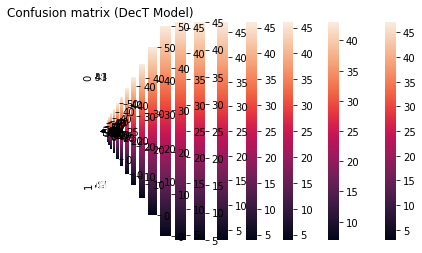

In [20]:
# Initialize variables to store results
# Clear any existing elements in the lists if they were previously initialized

shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    
    ## Creating and running our optimization

    # Creating and running our optimization

    study_dect = optuna.create_study(direction='maximize',study_name = "Dect")
    with parallel_backend('threading'):
        study_dect.optimize(objective_dect, n_trials=10, n_jobs=-1)

    # Evaluating our Optuna Trial
    print("Best trial:", study_dect.best_trial.number)
    print("Best accuracy:", study_dect.best_trial.value)
    print("Best hyperparameters:", study_dect.best_params)

    best_param_dect = study_dect.best_params
    DecT = DecisionTreeClassifier(**best_param_dect,random_state=42).fit(x_train,y_train)
    y_pred_dect = DecT.predict(x_test)


    display_results(y_test, y_pred_dect, cm_title = "Confusion matrix (DecT Model)")


    # SHAP value computation using TreeExplainer
    explainer = shap.TreeExplainer(model=DecT, data= None, model_output= 'raw', feature_perturbation= 'tree_path_dependent')
    shap_values = explainer.shap_values(x_test_)

    # Extract SHAP values for class 0
    shap_values_array = abs(shap_values[:,:,0])

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)


# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)

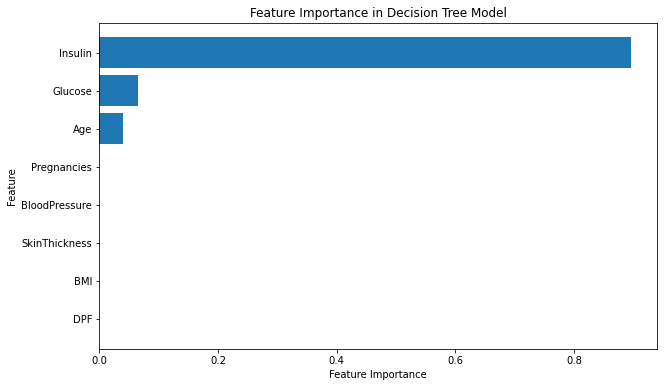

         Feature  Importance
4        Insulin    0.894604
1        Glucose    0.065321
7            Age    0.040075
0    Pregnancies    0.000000
2  BloodPressure    0.000000
3  SkinThickness    0.000000
5            BMI    0.000000
6            DPF    0.000000


In [21]:
# Get feature importances from the decision tree model
feature_importances = DecT.feature_importances_

# Get feature names
feature_names = x_train.columns

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Decision Tree Model')
plt.gca().invert_yaxis()
plt.show()

# Print the DataFrame for detailed view
print(importance_df)

In [22]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]



In [23]:
# Call the add_to_df function to populate valuestability
add_to_df()
valuestability

cv = valuestability.sum(axis=1) / valuestability.shape[1]
valuestability['CV'] = cv

# Save the DataFrame to an Excel file
valuestability.to_excel('10_dt_valuestability.xlsx', index=False)
valuestability

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,CV
0,1.918052,0.790700,3.081172,1.548788,0.367290,2.186042,1.761390,1.167777,1.602651
1,1.914758,0.732230,2.050708,1.731167,0.327445,1.931285,1.899792,1.146636,1.466752
2,1.914758,0.732230,2.050708,1.731167,0.327445,1.931285,1.899792,1.146636,1.466752
3,1.918960,0.736481,2.051206,1.720855,0.317976,2.426991,1.533817,1.144931,1.481402
4,1.776457,0.712154,2.184987,1.695749,0.422532,1.867400,1.899792,1.078453,1.454691
...,...,...,...,...,...,...,...,...,...
95,1.784372,0.712154,2.184987,1.695749,0.415259,1.867400,1.899792,1.071344,1.453882
96,1.914758,0.732230,2.050708,1.731167,0.327445,1.931285,1.899792,1.146636,1.466752
97,1.918052,0.788551,2.994154,1.566662,0.374564,2.186042,1.715093,1.157813,1.587617
98,1.916647,0.737001,2.051206,1.722653,0.317926,2.429570,1.533433,1.145371,1.481726


## 4.5 SVM (Support Vector Machine)

In [24]:
df = pd.read_csv("data_resampled_50.csv")
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)

def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))



In [25]:
# Creating an Objective Function

def objective_svm(trial):
    # Calculate class imbalance
    n_minority = y_train.sum()  # Number of minority class instances
    n_majority = len(y_train) - n_minority  # Number of majority class instances

    # Calculate class imbalance percentage
    p_minority = n_minority / len(y_train)
    p_majority = 1 - p_minority

    # Calculate class weights
    class_weight = {
        0: 1 / p_majority,  # Assume class '0' is the majority class
        1: 1 / p_minority   # Assume class '1' is the minority class
    }
    
    # Define hyperparameters
    param_svm = { 'C' : trial.suggest_loguniform('C', 1e-3, 1e3),
                'gamma' : trial.suggest_loguniform('gamma', 1e-5, 1e0),
                'class_weight': class_weight
                }

    # Create and train the model
    svm = SVC(**param_svm,random_state=rs)
    svm.fit(x_train_, y_train)

    # Evaluate the model
    score = cross_val_score(svm, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

[I 2024-08-26 18:57:39,729] A new study created in memory with name: SVM
[I 2024-08-26 18:57:40,377] Trial 1 finished with value: 0.8061408844371265 and parameters: {'C': 3.5450002758881123, 'gamma': 0.001187917955169164}. Best is trial 1 with value: 0.8061408844371265.
[I 2024-08-26 18:57:40,565] Trial 0 finished with value: 0.8162550803059981 and parameters: {'C': 36.42972347871262, 'gamma': 0.3387297002046699}. Best is trial 0 with value: 0.8162550803059981.
[I 2024-08-26 18:57:40,669] Trial 5 finished with value: 0.49613753080568207 and parameters: {'C': 0.2685631653890682, 'gamma': 0.00033194562372174607}. Best is trial 0 with value: 0.8162550803059981.
[I 2024-08-26 18:57:40,684] Trial 4 finished with value: 0.7585261587473611 and parameters: {'C': 0.9582320762256863, 'gamma': 0.7389207365937026}. Best is trial 0 with value: 0.8162550803059981.
[I 2024-08-26 18:57:40,696] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.0013619964202206203, 'gamma': 0.000834

Best trial: 7
Best accuracy: 0.8344834443713716
Best hyperparameters: {'C': 2.6667077312745833, 'gamma': 0.06994170378614549}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 18:58:04,315] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.062274  0.164583       0.004464       0.003583  0.155274  0.004774   
1      0.022274  0.140417       0.001226       0.005750  0.155750  0.000274   
2      0.002179  0.111107       0.005083       0.032702  0.338060  0.006536   
3      0.023286  0.122310       0.001857       0.022762  0.290143  0.001000   
4      0.002107  0.057440       0.009060       0.000155  0.279369  0.005012   
..          ...       ...            ...            ...       ...       ...   
95     0.040833  0.021429       0.010286       0.036048  0.256857  0.008929   
96     0.005690  0.090119       0.008048       0.153619  0.125571  0.231143   
97     0.000250  0.550917       0.008226       0.146655  0.146417  0.086631   
98     0.021595  0.032238       0.006690       0.054357  0.402143  0.009571   
99     0.019488  0.133417       0.005845       0.050726  0.271250  0.007679   

         DPF       Age  Outcome  
0   0.008345  0.0

[I 2024-08-26 18:58:04,930] Trial 5 finished with value: 0.8340975357454852 and parameters: {'C': 4.091318893193625, 'gamma': 0.05176664458414284}. Best is trial 5 with value: 0.8340975357454852.
[I 2024-08-26 18:58:04,952] Trial 2 finished with value: 0.8230886462969393 and parameters: {'C': 0.8009543068705421, 'gamma': 0.01639682101615493}. Best is trial 5 with value: 0.8340975357454852.
[I 2024-08-26 18:58:05,000] Trial 1 finished with value: 0.826036454868968 and parameters: {'C': 0.13052238332579688, 'gamma': 0.07723374867746738}. Best is trial 5 with value: 0.8340975357454852.
[I 2024-08-26 18:58:05,032] Trial 4 finished with value: 0.8013644854568439 and parameters: {'C': 0.8741192478419687, 'gamma': 0.002858734677266525}. Best is trial 5 with value: 0.8340975357454852.
[I 2024-08-26 18:58:05,307] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.005149045650512886, 'gamma': 1.3904492001416197e-05}. Best is trial 5 with value: 0.8340975357454852.
[I 2024-08-

Best trial: 5
Best accuracy: 0.8340975357454852
Best hyperparameters: {'C': 4.091318893193625, 'gamma': 0.05176664458414284}
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 18:58:17,538] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.052940  0.167940       0.002917       0.005607  0.147821  0.010488   
1      0.012917  0.141488       0.000440       0.004869  0.159060  0.001131   
2      0.003869  0.103298       0.006440       0.033321  0.347798  0.008821   
3      0.020417  0.120488       0.000774       0.028512  0.296464  0.003536   
4      0.007214  0.059619       0.001000       0.005190  0.260214  0.001000   
..          ...       ...            ...            ...       ...       ...   
95     0.022702  0.012560       0.002655       0.042298  0.244798  0.006202   
96     0.006964  0.086083       0.007369       0.162464  0.126893  0.208060   
97     0.001060  0.542155       0.006036       0.160393  0.172655  0.079988   
98     0.016155  0.036464       0.004821       0.060750  0.379702  0.016321   
99     0.014048  0.126976       0.003476       0.050952  0.319810  0.000810   

         DPF       Age  Outcome  
0   0.012583  0.0

[I 2024-08-26 18:58:18,178] Trial 4 finished with value: 0.8207016482991358 and parameters: {'C': 9.903298597373363, 'gamma': 0.0017899825444797912}. Best is trial 4 with value: 0.8207016482991358.
[I 2024-08-26 18:58:18,322] Trial 0 finished with value: 0.794159868583635 and parameters: {'C': 55.94917342428454, 'gamma': 2.0855729924129714e-05}. Best is trial 4 with value: 0.8207016482991358.
[I 2024-08-26 18:58:18,538] Trial 1 finished with value: 0.775184282374872 and parameters: {'C': 0.9248539954474359, 'gamma': 0.0002028781692540036}. Best is trial 4 with value: 0.8207016482991358.
[I 2024-08-26 18:58:18,550] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.001596065611422959, 'gamma': 1.2967264013232452e-05}. Best is trial 4 with value: 0.8207016482991358.
[I 2024-08-26 18:58:18,566] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.002689839578327976, 'gamma': 0.02239126098058279}. Best is trial 4 with value: 0.8207016482991358.
[I 2024

Best trial: 6
Best accuracy: 0.8227349657479671
Best hyperparameters: {'C': 9.962404239070384, 'gamma': 0.0036251474446052476}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 18:58:33,259] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.028869  0.192774       0.000488       0.001679  0.091679  0.048821   
1      0.058643  0.160214       0.001381       0.096143  0.147286  0.005286   
2      0.046857  0.151524       0.008738       0.040952  0.191762  0.059714   
3      0.034738  0.159905       0.004571       0.040810  0.145381  0.038119   
4      0.000857  0.114619       0.004548       0.001095  0.159833  0.029357   
..          ...       ...            ...            ...       ...       ...   
95     0.246500  0.233357       0.007929       0.088690  0.019381  0.120524   
96     0.064929  0.125929       0.000190       0.159595  0.118452  0.111071   
97     0.210726  0.350512       0.006274       0.332369  0.017964  0.057440   
98     0.015810  0.237595       0.004476       0.063048  0.231690  0.093833   
99     0.034202  0.204131       0.000179       0.051964  0.313488  0.006869   

         DPF       Age  Outcome  
0   0.036821  0.0

[I 2024-08-26 18:58:33,905] Trial 0 finished with value: 0.8130945910026901 and parameters: {'C': 14.476016875712109, 'gamma': 0.0005133103054621495}. Best is trial 0 with value: 0.8130945910026901.
[I 2024-08-26 18:58:33,918] Trial 4 finished with value: 0.8071616085402131 and parameters: {'C': 3.195844399419923, 'gamma': 0.0019377867996443637}. Best is trial 0 with value: 0.8130945910026901.
[I 2024-08-26 18:58:33,981] Trial 5 finished with value: 0.8086839596830997 and parameters: {'C': 54.771623833182545, 'gamma': 0.2716146373752706}. Best is trial 0 with value: 0.8130945910026901.
[I 2024-08-26 18:58:34,205] Trial 2 finished with value: 0.7718926954519303 and parameters: {'C': 0.041522600139140886, 'gamma': 0.006139329046180629}. Best is trial 0 with value: 0.8130945910026901.
[I 2024-08-26 18:58:34,211] Trial 1 finished with value: 0.7693718747786038 and parameters: {'C': 0.7300094810337386, 'gamma': 0.0003463520506529526}. Best is trial 0 with value: 0.8130945910026901.
[I 2024-

Best trial: 7
Best accuracy: 0.8308291476771879
Best hyperparameters: {'C': 0.14065953400154402, 'gamma': 0.10332563719497415}
              precision    recall  f1-score   support

           0       0.73      0.94      0.82        50
           1       0.92      0.66      0.77        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.83      0.80      0.80       100



[I 2024-08-26 18:58:51,483] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043048  0.197810       0.000762       0.003524  0.084667  0.037071   
1      0.061119  0.153500       0.007119       0.056429  0.138500  0.004214   
2      0.036464  0.117798       0.080440       0.031679  0.161012  0.021940   
3      0.038964  0.150512       0.032988       0.043702  0.155726  0.018036   
4      0.002488  0.114321       0.032607       0.004226  0.166107  0.014798   
..          ...       ...            ...            ...       ...       ...   
95     0.188869  0.180821       0.094869       0.109512  0.034202  0.124512   
96     0.058714  0.101595       0.002881       0.166238  0.112381  0.124381   
97     0.157976  0.279667       0.013976       0.386000  0.043429  0.031738   
98     0.016429  0.190810       0.018452       0.069905  0.265143  0.058143   
99     0.034310  0.178786       0.000452       0.066643  0.319667  0.001690   

         DPF       Age  Outcome  
0   0.025643  0.0

[I 2024-08-26 18:58:52,307] Trial 0 finished with value: 0.8314047397494494 and parameters: {'C': 0.1736908458157235, 'gamma': 0.08266629995826953}. Best is trial 0 with value: 0.8314047397494494.
[I 2024-08-26 18:58:52,422] Trial 1 finished with value: 0.7960063953607842 and parameters: {'C': 0.05040638555229191, 'gamma': 0.021511371670490508}. Best is trial 0 with value: 0.8314047397494494.
[I 2024-08-26 18:58:52,608] Trial 4 finished with value: 0.7752112735912651 and parameters: {'C': 1.0136828630212797, 'gamma': 0.00021227715197784033}. Best is trial 0 with value: 0.8314047397494494.
[I 2024-08-26 18:58:52,643] Trial 5 finished with value: 0.7303857692000579 and parameters: {'C': 0.010672106970860757, 'gamma': 0.15459241851012562}. Best is trial 0 with value: 0.8314047397494494.
[I 2024-08-26 18:58:52,657] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.006742169363067502, 'gamma': 0.008938450040293547}. Best is trial 0 with value: 0.8314047397494494.
[I 202

Best trial: 9
Best accuracy: 0.8361626437311651
Best hyperparameters: {'C': 4.962642901631811, 'gamma': 0.053665229581085605}
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.88      0.74      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 18:59:05,304] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.063083  0.166107       0.006131       0.001845  0.152131  0.003345   
1      0.016012  0.138202       0.001202       0.004774  0.160560  0.001583   
2      0.004833  0.097738       0.023095       0.031548  0.331500  0.002381   
3      0.024238  0.114405       0.004643       0.024833  0.288405  0.000690   
4      0.002036  0.053155       0.008536       0.000131  0.269202  0.005798   
..          ...       ...            ...            ...       ...       ...   
95     0.193702  0.125702       0.099393       0.129774  0.081512  0.135702   
96     0.002036  0.093202       0.011131       0.155179  0.131583  0.223774   
97     0.013036  0.553131       0.009083       0.152798  0.148202  0.080488   
98     0.027214  0.028976       0.004500       0.056738  0.401119  0.010286   
99     0.010905  0.132071       0.004024       0.053643  0.301476  0.002024   

         DPF       Age  Outcome  
0   0.008012  0.0

[I 2024-08-26 18:59:06,064] Trial 2 finished with value: 0.8221546754628143 and parameters: {'C': 82.68351540298872, 'gamma': 0.0007110539093384293}. Best is trial 2 with value: 0.8221546754628143.
[I 2024-08-26 18:59:06,150] Trial 5 finished with value: 0.8233365925823197 and parameters: {'C': 140.550711354259, 'gamma': 0.0017294800666123283}. Best is trial 5 with value: 0.8233365925823197.
[I 2024-08-26 18:59:06,425] Trial 0 finished with value: 0.7514106696269721 and parameters: {'C': 0.009319271254969149, 'gamma': 0.07585037398161625}. Best is trial 5 with value: 0.8233365925823197.
[I 2024-08-26 18:59:06,429] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.005633013886948629, 'gamma': 1.0984688644699028e-05}. Best is trial 5 with value: 0.8233365925823197.
[I 2024-08-26 18:59:06,465] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.011505147920378607, 'gamma': 1.307148531915857e-05}. Best is trial 5 with value: 0.8233365925823197.
[I 20

Best trial: 5
Best accuracy: 0.8233365925823197
Best hyperparameters: {'C': 140.550711354259, 'gamma': 0.0017294800666123283}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 18:59:20,044] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.037071  0.193690       0.001286       0.003333  0.104167  0.048762   
1      0.049083  0.155464       0.000917       0.077750  0.160321  0.001250   
2      0.042905  0.151810       0.011167       0.039048  0.212833  0.051714   
3      0.039738  0.153548       0.001405       0.041905  0.167357  0.037024   
4      0.003643  0.113857       0.003714       0.003833  0.177738  0.028000   
..          ...       ...            ...            ...       ...       ...   
95     0.209845  0.191845       0.022250       0.102440  0.034155  0.145464   
96     0.059214  0.115595       0.000952       0.172476  0.127024  0.124286   
97     0.185286  0.314381       0.001524       0.362262  0.017690  0.048143   
98     0.012440  0.203369       0.003631       0.066583  0.215631  0.079631   
99     0.028298  0.175298       0.001869       0.049845  0.325821  0.009345   

         DPF       Age  Outcome  
0   0.037571  0.0

[I 2024-08-26 18:59:20,755] Trial 4 finished with value: 0.8306362274277659 and parameters: {'C': 0.21830121498926391, 'gamma': 0.1134446074825796}. Best is trial 4 with value: 0.8306362274277659.
[I 2024-08-26 18:59:20,989] Trial 0 finished with value: 0.7741027079063434 and parameters: {'C': 0.22369040421960673, 'gamma': 0.0016570926146661296}. Best is trial 4 with value: 0.8306362274277659.
[I 2024-08-26 18:59:21,092] Trial 3 finished with value: 0.7903663021538133 and parameters: {'C': 3.1890351546338094, 'gamma': 0.5544459414117968}. Best is trial 4 with value: 0.8306362274277659.
[I 2024-08-26 18:59:21,100] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.033337814786258635, 'gamma': 3.339919497629174e-05}. Best is trial 4 with value: 0.8306362274277659.
[I 2024-08-26 18:59:21,107] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.005513503151855391, 'gamma': 2.9202233385827577e-05}. Best is trial 4 with value: 0.8306362274277659.
[I 202

Best trial: 4
Best accuracy: 0.8306362274277659
Best hyperparameters: {'C': 0.21830121498926391, 'gamma': 0.1134446074825796}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 18:59:37,841] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.041881  0.182929       0.000405       0.006643  0.104119  0.037071   
1      0.050345  0.139893       0.003607       0.051083  0.153488  0.006631   
2      0.027524  0.115214       0.078690       0.034214  0.184071  0.029429   
3      0.030476  0.136167       0.021476       0.045762  0.188310  0.017905   
4      0.000643  0.103524       0.030738       0.008595  0.183024  0.013762   
..          ...       ...            ...            ...       ...       ...   
95     0.161738  0.156857       0.148524       0.106881  0.060310  0.132833   
96     0.040155  0.095726       0.002298       0.160536  0.118845  0.143845   
97     0.164214  0.305381       0.009310       0.371238  0.072833  0.061667   
98     0.001821  0.143560       0.013012       0.065321  0.288274  0.057821   
99     0.034238  0.157476       0.001500       0.068714  0.321071  0.003762   

         DPF       Age  Outcome  
0   0.027976  0.0

[I 2024-08-26 18:59:38,625] Trial 4 finished with value: 0.8043764675965326 and parameters: {'C': 41.030215125045494, 'gamma': 0.21937308295141608}. Best is trial 4 with value: 0.8043764675965326.
[I 2024-08-26 18:59:38,664] Trial 2 finished with value: 0.7959139163048937 and parameters: {'C': 0.2403526433986139, 'gamma': 0.007262201534299563}. Best is trial 4 with value: 0.8043764675965326.
[I 2024-08-26 18:59:38,956] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.005366566150689435, 'gamma': 0.0002309559136783874}. Best is trial 4 with value: 0.8043764675965326.
[I 2024-08-26 18:59:38,968] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.003105169832070489, 'gamma': 0.00010043425102450838}. Best is trial 4 with value: 0.8043764675965326.
[I 2024-08-26 18:59:38,991] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.05906392364416726, 'gamma': 0.0002311847696416226}. Best is trial 4 with value: 0.8043764675965326.
[I 20

Best trial: 9
Best accuracy: 0.8365250232099046
Best hyperparameters: {'C': 1.0707961161900852, 'gamma': 0.04047891601982051}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 18:59:53,633] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042071  0.168667       0.001690       0.007024  0.138262  0.029381   
1      0.040786  0.144881       0.001905       0.046595  0.162905  0.004452   
2      0.025369  0.149155       0.026845       0.036369  0.220536  0.044345   
3      0.031095  0.134095       0.006500       0.037905  0.205571  0.020048   
4      0.002452  0.090833       0.017381       0.004333  0.207952  0.010905   
..          ...       ...            ...            ...       ...       ...   
95     0.028214  0.004452       0.006881       0.009143  0.226333  0.011952   
96     0.037036  0.093655       0.000631       0.162964  0.140988  0.136536   
97     0.154893  0.347655       0.055083       0.335869  0.047345  0.066250   
98     0.007821  0.114679       0.008464       0.062560  0.309440  0.046488   
99     0.027976  0.145286       0.001881       0.049143  0.338690  0.002690   

         DPF       Age  Outcome  
0   0.026690  0.0

[I 2024-08-26 18:59:54,621] Trial 3 finished with value: 0.7738937350280863 and parameters: {'C': 0.08912744518429519, 'gamma': 0.004201340103001286}. Best is trial 3 with value: 0.7738937350280863.
[I 2024-08-26 18:59:54,738] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.027104602209678696, 'gamma': 0.00022110461457177115}. Best is trial 3 with value: 0.7738937350280863.
[I 2024-08-26 18:59:54,751] Trial 2 finished with value: 0.5362594392181953 and parameters: {'C': 0.04650051869282383, 'gamma': 0.0020602848937747243}. Best is trial 3 with value: 0.7738937350280863.
[I 2024-08-26 18:59:54,761] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.0020720548184191066, 'gamma': 0.31218551667532013}. Best is trial 3 with value: 0.7738937350280863.
[I 2024-08-26 18:59:54,791] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.006296415737701423, 'gamma': 0.39751261176191116}. Best is trial 3 with value: 0.7738937350280863.
[I 

Best trial: 6
Best accuracy: 0.8294362981293615
Best hyperparameters: {'C': 3.394472371289565, 'gamma': 0.014844965129803621}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 19:00:08,857] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038524  0.187238       0.002000       0.002595  0.113476  0.042214   
1      0.041583  0.152012       0.001060       0.071774  0.164988  0.004036   
2      0.039119  0.154595       0.005881       0.042452  0.222976  0.053310   
3      0.036976  0.148833       0.002071       0.040905  0.183310  0.026976   
4      0.005833  0.108690       0.001405       0.002071  0.185762  0.018500   
..          ...       ...            ...            ...       ...       ...   
95     0.083940  0.040845       0.141274       0.001298  0.185821  0.017607   
96     0.050214  0.114762       0.002262       0.169405  0.138738  0.125405   
97     0.185595  0.330310       0.001071       0.347690  0.037048  0.063333   
98     0.011821  0.174393       0.000036       0.063250  0.267417  0.063060   
99     0.029214  0.163810       0.001952       0.046619  0.331500  0.006429   

         DPF       Age  Outcome  
0   0.035524  0.0

[I 2024-08-26 19:00:09,530] Trial 3 finished with value: 0.8266525158907798 and parameters: {'C': 4.803576446356212, 'gamma': 0.01865530511694509}. Best is trial 3 with value: 0.8266525158907798.
[I 2024-08-26 19:00:09,620] Trial 5 finished with value: 0.7998617540840991 and parameters: {'C': 23.732148575716348, 'gamma': 8.93339324092201e-05}. Best is trial 3 with value: 0.8266525158907798.
[I 2024-08-26 19:00:09,732] Trial 4 finished with value: 0.7982899726218464 and parameters: {'C': 0.03749351016750878, 'gamma': 0.05221962180410294}. Best is trial 3 with value: 0.8266525158907798.
[I 2024-08-26 19:00:09,935] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 1.2405207344852272, 'gamma': 4.016462552070888e-05}. Best is trial 3 with value: 0.8266525158907798.
[I 2024-08-26 19:00:09,944] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.026373037741750108, 'gamma': 0.00010368797084488078}. Best is trial 3 with value: 0.8266525158907798.
[I 2024-0

Best trial: 3
Best accuracy: 0.8266525158907798
Best hyperparameters: {'C': 4.803576446356212, 'gamma': 0.01865530511694509}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 19:00:23,514] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038786  0.170833       0.002333       0.011024  0.142190  0.020381   
1      0.027452  0.149048       0.000452       0.041048  0.155714  0.002405   
2      0.018726  0.145821       0.019131       0.035917  0.235702  0.040464   
3      0.028655  0.134464       0.002131       0.036345  0.215726  0.018464   
4      0.000571  0.078119       0.006952       0.005881  0.221714  0.008000   
..          ...       ...            ...            ...       ...       ...   
95     0.002488  0.013488       0.016464       0.011440  0.257869  0.017226   
96     0.032167  0.097643       0.002833       0.176595  0.139048  0.128048   
97     0.111655  0.292131       0.016179       0.383607  0.076964  0.055726   
98     0.010798  0.100417       0.002036       0.066798  0.324036  0.036702   
99     0.027548  0.138881       0.003071       0.043357  0.338095  0.000310   

         DPF       Age  Outcome  
0   0.025167  0.0

[I 2024-08-26 19:00:24,265] Trial 0 finished with value: 0.8029838200500805 and parameters: {'C': 19.938692158004287, 'gamma': 0.0001754713516584664}. Best is trial 0 with value: 0.8029838200500805.
[I 2024-08-26 19:00:24,289] Trial 1 finished with value: 0.7963262796359772 and parameters: {'C': 52.80971870061462, 'gamma': 3.214012613662563e-05}. Best is trial 0 with value: 0.8029838200500805.
[I 2024-08-26 19:00:24,350] Trial 2 finished with value: 0.7952171673234151 and parameters: {'C': 13.731060612805647, 'gamma': 7.724068983512202e-05}. Best is trial 0 with value: 0.8029838200500805.
[I 2024-08-26 19:00:24,633] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.0010267045321685295, 'gamma': 2.4100100961763482e-05}. Best is trial 0 with value: 0.8029838200500805.
[I 2024-08-26 19:00:24,645] Trial 5 finished with value: 0.29612062035851056 and parameters: {'C': 0.06260558092366061, 'gamma': 0.0009411103419225033}. Best is trial 0 with value: 0.8029838200500805.
[

Best trial: 6
Best accuracy: 0.8321270423116558
Best hyperparameters: {'C': 117.55959328137384, 'gamma': 0.027525422560581308}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 19:00:36,384] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.069560  0.189202       0.008107       0.005583  0.157655  0.003345   
1      0.003012  0.143988       0.003679       0.038298  0.149393  0.001964   
2      0.022155  0.073298       0.007631       0.022845  0.453345  0.017202   
3      0.019488  0.127512       0.017250       0.008750  0.286036  0.009536   
4      0.011940  0.046750       0.003940       0.004202  0.363536  0.013560   
..          ...       ...            ...            ...       ...       ...   
95     0.281167  0.023286       0.108810       0.103333  0.032786  0.072476   
96     0.051714  0.450167       0.078048       0.047643  0.023262  0.070476   
97     0.019929  0.641167       0.003143       0.115143  0.094548  0.032976   
98     0.030202  0.012179       0.013988       0.054774  0.428202  0.004536   
99     0.075000  0.343381       0.002643       0.041738  0.198714  0.034357   

         DPF       Age  Outcome  
0   0.009679  0.0

[I 2024-08-26 19:00:37,092] Trial 1 finished with value: 0.8268571852440009 and parameters: {'C': 5.150537957992281, 'gamma': 0.018203981505690876}. Best is trial 1 with value: 0.8268571852440009.
[I 2024-08-26 19:00:37,186] Trial 5 finished with value: 0.818323663271037 and parameters: {'C': 0.8067158038051203, 'gamma': 0.32562407136742827}. Best is trial 1 with value: 0.8268571852440009.
[I 2024-08-26 19:00:37,249] Trial 3 finished with value: 0.813919446774733 and parameters: {'C': 0.058187570291416614, 'gamma': 0.09817365396473736}. Best is trial 1 with value: 0.8268571852440009.
[I 2024-08-26 19:00:37,263] Trial 0 finished with value: 0.7946155175098722 and parameters: {'C': 2.258622799958266, 'gamma': 0.0005223460958742257}. Best is trial 1 with value: 0.8268571852440009.
[I 2024-08-26 19:00:37,295] Trial 4 finished with value: 0.8155024273477018 and parameters: {'C': 116.31396113983456, 'gamma': 0.004542476145453562}. Best is trial 1 with value: 0.8268571852440009.
[I 2024-08-26

Best trial: 1
Best accuracy: 0.8268571852440009
Best hyperparameters: {'C': 5.150537957992281, 'gamma': 0.018203981505690876}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 19:00:50,749] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038024  0.169429       0.003071       0.010976  0.142786  0.020762   
1      0.025214  0.147738       0.000000       0.039000  0.155548  0.002690   
2      0.017214  0.142762       0.018738       0.035810  0.239452  0.039262   
3      0.028262  0.133167       0.003310       0.036310  0.217167  0.019238   
4      0.000500  0.077690       0.005810       0.006333  0.222643  0.007690   
..          ...       ...            ...            ...       ...       ...   
95     0.007893  0.017869       0.016321       0.024845  0.263845  0.016202   
96     0.031167  0.096714       0.002238       0.174524  0.139976  0.129976   
97     0.110702  0.291393       0.017774       0.383321  0.079345  0.055869   
98     0.010714  0.097619       0.000976       0.067095  0.325905  0.039833   
99     0.027560  0.137607       0.003774       0.043464  0.338964  0.001464   

         DPF       Age  Outcome  
0   0.024238  0.0

[I 2024-08-26 19:00:51,494] Trial 2 finished with value: 0.8223982904456322 and parameters: {'C': 6.792275723460863, 'gamma': 0.005128603664652787}. Best is trial 2 with value: 0.8223982904456322.
[I 2024-08-26 19:00:51,708] Trial 5 finished with value: 0.7932374574840256 and parameters: {'C': 37.490605263177194, 'gamma': 0.11999079261071516}. Best is trial 2 with value: 0.8223982904456322.
[I 2024-08-26 19:00:51,900] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.02665032253596496, 'gamma': 0.00027412902548257527}. Best is trial 2 with value: 0.8223982904456322.
[I 2024-08-26 19:00:51,982] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.038094366911181156, 'gamma': 0.0012161853242642652}. Best is trial 2 with value: 0.8223982904456322.
[I 2024-08-26 19:00:52,003] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.008666177707501426, 'gamma': 0.00025857240369790306}. Best is trial 2 with value: 0.8223982904456322.
[I 20

Best trial: 2
Best accuracy: 0.8223982904456322
Best hyperparameters: {'C': 6.792275723460863, 'gamma': 0.005128603664652787}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 19:01:06,389] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029036  0.195607       0.000155       0.002298  0.092464  0.048917   
1      0.058750  0.159512       0.001679       0.089560  0.149988  0.005226   
2      0.047393  0.152298       0.011274       0.040060  0.195845  0.059845   
3      0.036905  0.157929       0.005905       0.039381  0.145929  0.039643   
4      0.002714  0.115190       0.005333       0.001667  0.160429  0.030667   
..          ...       ...            ...            ...       ...       ...   
95     0.239417  0.229512       0.004179       0.095774  0.021417  0.124417   
96     0.065667  0.121905       0.000571       0.158810  0.119095  0.116071   
97     0.211357  0.347405       0.008810       0.334881  0.015143  0.061000   
98     0.013536  0.232012       0.008464       0.063869  0.205202  0.099560   
99     0.034321  0.200250       0.000274       0.049369  0.313679  0.010655   

         DPF       Age  Outcome  
0   0.034488  0.0

[I 2024-08-26 19:01:07,144] Trial 4 finished with value: 0.8252851764024177 and parameters: {'C': 5.268317663867824, 'gamma': 0.007436363491788329}. Best is trial 4 with value: 0.8252851764024177.
[I 2024-08-26 19:01:07,210] Trial 1 finished with value: 0.8199691174264002 and parameters: {'C': 30.512346513091494, 'gamma': 0.008378915952046232}. Best is trial 4 with value: 0.8252851764024177.
[I 2024-08-26 19:01:07,545] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.002325858685798519, 'gamma': 7.186126322615408e-05}. Best is trial 4 with value: 0.8252851764024177.
[I 2024-08-26 19:01:07,582] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.0025917208386314126, 'gamma': 0.0030858330554474106}. Best is trial 4 with value: 0.8252851764024177.
[I 2024-08-26 19:01:07,589] Trial 0 finished with value: 0.4880597337830686 and parameters: {'C': 0.05323648867418607, 'gamma': 0.9082066894955007}. Best is trial 4 with value: 0.8252851764024177.
[I 2024

Best trial: 6
Best accuracy: 0.826187501524698
Best hyperparameters: {'C': 85.94295965831643, 'gamma': 0.002575355199289852}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 19:01:21,322] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039798  0.188036       0.002583       0.001774  0.109964  0.046417   
1      0.043738  0.153738       0.000976       0.068786  0.155333  0.003071   
2      0.041024  0.148476       0.009738       0.036833  0.214429  0.050357   
3      0.039560  0.152155       0.001060       0.040583  0.177988  0.030250   
4      0.004524  0.108619       0.001143       0.002071  0.182714  0.023381   
..          ...       ...            ...            ...       ...       ...   
95     0.085548  0.042714       0.150548       0.001667  0.182619  0.020024   
96     0.054226  0.115274       0.002750       0.166940  0.137917  0.128060   
97     0.175464  0.319750       0.005679       0.352440  0.025393  0.058226   
98     0.014798  0.184798       0.003393       0.058274  0.257798  0.067893   
99     0.027250  0.164036       0.001036       0.046036  0.334679  0.005845   

         DPF       Age  Outcome  
0   0.036893  0.0

[I 2024-08-26 19:01:22,031] Trial 5 finished with value: 0.8342865446126889 and parameters: {'C': 0.5941677474591534, 'gamma': 0.037411229734306835}. Best is trial 5 with value: 0.8342865446126889.
[I 2024-08-26 19:01:22,050] Trial 2 finished with value: 0.8208598735065832 and parameters: {'C': 2.086419635628341, 'gamma': 0.005834446728667579}. Best is trial 5 with value: 0.8342865446126889.
[I 2024-08-26 19:01:22,073] Trial 0 finished with value: 0.8063928010842873 and parameters: {'C': 4.476139444200647, 'gamma': 0.0012885670249451336}. Best is trial 5 with value: 0.8342865446126889.
[I 2024-08-26 19:01:22,122] Trial 4 finished with value: 0.8123640632331902 and parameters: {'C': 13.254928955824797, 'gamma': 0.2520587388365688}. Best is trial 5 with value: 0.8342865446126889.
[I 2024-08-26 19:01:22,332] Trial 3 finished with value: 0.7721371487934444 and parameters: {'C': 0.053170391427631636, 'gamma': 0.00846264470812937}. Best is trial 5 with value: 0.8342865446126889.
[I 2024-08-2

Best trial: 5
Best accuracy: 0.8342865446126889
Best hyperparameters: {'C': 0.5941677474591534, 'gamma': 0.037411229734306835}
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 19:01:37,247] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.044345  0.188345       0.001083       0.003964  0.115726  0.042345   
1      0.052762  0.150929       0.002357       0.067762  0.177214  0.000381   
2      0.046417  0.153226       0.027369       0.038393  0.205893  0.046155   
3      0.044917  0.147274       0.007131       0.039655  0.184679  0.027679   
4      0.008202  0.110774       0.012369       0.004631  0.189798  0.020702   
..          ...       ...            ...            ...       ...       ...   
95     0.189905  0.187500       0.006619       0.109952  0.038976  0.144881   
96     0.059048  0.105905       0.001143       0.176810  0.121548  0.129619   
97     0.195607  0.325988       0.005560       0.356488  0.032345  0.061488   
98     0.013048  0.172690       0.005024       0.060310  0.270738  0.059095   
99     0.029202  0.163298       0.000583       0.047607  0.323226  0.008393   

         DPF       Age  Outcome  
0   0.028250  0.0

[I 2024-08-26 19:01:37,973] Trial 3 finished with value: 0.8283604705672282 and parameters: {'C': 12.90182980365151, 'gamma': 0.00664970730380257}. Best is trial 3 with value: 0.8283604705672282.
[I 2024-08-26 19:01:38,219] Trial 0 finished with value: 0.8069687701691711 and parameters: {'C': 0.4055540715662458, 'gamma': 0.6363055749899055}. Best is trial 3 with value: 0.8283604705672282.
[I 2024-08-26 19:01:38,373] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.027673312795832117, 'gamma': 0.0008153622653278087}. Best is trial 3 with value: 0.8283604705672282.
[I 2024-08-26 19:01:38,385] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.0035183733286990766, 'gamma': 0.00143289669625777}. Best is trial 3 with value: 0.8283604705672282.
[I 2024-08-26 19:01:38,398] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.010278923379164558, 'gamma': 0.0014762767174032305}. Best is trial 3 with value: 0.8283604705672282.
[I 2024-0

Best trial: 3
Best accuracy: 0.8283604705672282
Best hyperparameters: {'C': 12.90182980365151, 'gamma': 0.00664970730380257}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 19:01:52,646] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.037429  0.190762       0.001357       0.002381  0.107833  0.048714   
1      0.043845  0.155536       0.000226       0.069345  0.150964  0.003012   
2      0.041417  0.152298       0.007679       0.037845  0.211679  0.051845   
3      0.037786  0.154381       0.000857       0.041167  0.172095  0.033857   
4      0.002417  0.113107       0.000655       0.003036  0.179583  0.025012   
..          ...       ...            ...            ...       ...       ...   
95     0.211095  0.177929       0.021500       0.104214  0.047810  0.149214   
96     0.054548  0.119095       0.001738       0.165000  0.133929  0.131929   
97     0.191119  0.330595       0.005357       0.347214  0.029476  0.059190   
98     0.013310  0.195643       0.000500       0.062619  0.223667  0.076905   
99     0.027988  0.171560       0.001393       0.047750  0.326060  0.005012   

         DPF       Age  Outcome  
0   0.039619  0.0

[I 2024-08-26 19:01:53,405] Trial 3 finished with value: 0.8053875167409352 and parameters: {'C': 2.560756730641344, 'gamma': 0.0013993920157640656}. Best is trial 3 with value: 0.8053875167409352.
[I 2024-08-26 19:01:53,459] Trial 2 finished with value: 0.7967299112578577 and parameters: {'C': 2.9491818198116104, 'gamma': 0.0005893969614759314}. Best is trial 3 with value: 0.8053875167409352.
[I 2024-08-26 19:01:53,749] Trial 1 finished with value: 0.6274316479750447 and parameters: {'C': 0.005254240622411455, 'gamma': 0.08319955945841502}. Best is trial 3 with value: 0.8053875167409352.
[I 2024-08-26 19:01:53,757] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0033478066473012634, 'gamma': 1.6855993858977552e-05}. Best is trial 3 with value: 0.8053875167409352.
[I 2024-08-26 19:01:53,762] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.045887692929663, 'gamma': 3.3935022774087784e-05}. Best is trial 3 with value: 0.8053875167409352.
[I 2

Best trial: 3
Best accuracy: 0.8053875167409352
Best hyperparameters: {'C': 2.560756730641344, 'gamma': 0.0013993920157640656}
              precision    recall  f1-score   support

           0       0.67      0.96      0.79        50
           1       0.93      0.52      0.67        50

    accuracy                           0.74       100
   macro avg       0.80      0.74      0.73       100
weighted avg       0.80      0.74      0.73       100



[I 2024-08-26 19:02:11,377] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.018452  0.157238       0.003381       0.004048  0.066738  0.043452   
1      0.042679  0.147036       0.000917       0.063798  0.120583  0.001655   
2      0.038476  0.119643       0.018167       0.031619  0.142571  0.043238   
3      0.020286  0.129476       0.011500       0.030262  0.113286  0.033048   
4      0.002857  0.101643       0.008119       0.006262  0.119238  0.027833   
..          ...       ...            ...            ...       ...       ...   
95     0.263857  0.165000       0.128048       0.092690  0.024262  0.131667   
96     0.059786  0.089857       0.002786       0.092167  0.115286  0.090048   
97     0.227036  0.333893       0.014488       0.307440  0.032107  0.072417   
98     0.013881  0.228095       0.018214       0.072000  0.192500  0.164024   
99     0.041905  0.254738       0.003476       0.051143  0.347500  0.017595   

         DPF       Age  Outcome  
0   0.017952  0.0

[I 2024-08-26 19:02:12,132] Trial 0 finished with value: 0.8017495299555852 and parameters: {'C': 3.392977916910807, 'gamma': 0.0008329692679518013}. Best is trial 0 with value: 0.8017495299555852.
[I 2024-08-26 19:02:12,143] Trial 4 finished with value: 0.8024508016970437 and parameters: {'C': 3.3129365747230684, 'gamma': 0.0008282026261605131}. Best is trial 4 with value: 0.8024508016970437.
[I 2024-08-26 19:02:12,192] Trial 3 finished with value: 0.7982166572221396 and parameters: {'C': 34.2671892224828, 'gamma': 5.301966245352051e-05}. Best is trial 4 with value: 0.8024508016970437.
[I 2024-08-26 19:02:12,463] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.2712448568312016, 'gamma': 0.00010468101521080341}. Best is trial 4 with value: 0.8024508016970437.
[I 2024-08-26 19:02:12,470] Trial 5 finished with value: 0.7669813529789647 and parameters: {'C': 0.7254089222532147, 'gamma': 0.00020168516949609582}. Best is trial 4 with value: 0.8024508016970437.
[I 2024

Best trial: 7
Best accuracy: 0.812840449041737
Best hyperparameters: {'C': 976.9403539589703, 'gamma': 0.0025487130518427846}
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 19:02:25,516] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.044762  0.172548       0.004333       0.002857  0.120119  0.014524   
1      0.001071  0.160786       0.000762       0.035595  0.156595  0.002786   
2      0.017905  0.140405       0.001119       0.025381  0.324619  0.021381   
3      0.015107  0.133893       0.003702       0.036845  0.270988  0.007631   
4      0.008952  0.066190       0.004952       0.000310  0.210476  0.006929   
..          ...       ...            ...            ...       ...       ...   
95     0.099464  0.171774       0.107917       0.108845  0.029607  0.124321   
96     0.000048  0.110738       0.006857       0.213286  0.109286  0.169857   
97     0.033190  0.308952       0.117143       0.409167  0.097381  0.020381   
98     0.023083  0.052607       0.004869       0.072893  0.341417  0.021798   
99     0.010250  0.145131       0.000655       0.046536  0.325060  0.007583   

         DPF       Age  Outcome  
0   0.014262  0.0

[I 2024-08-26 19:02:26,282] Trial 0 finished with value: 0.8195279985412586 and parameters: {'C': 0.7885471231095104, 'gamma': 0.009059912350783676}. Best is trial 0 with value: 0.8195279985412586.
[I 2024-08-26 19:02:26,426] Trial 3 finished with value: 0.796307921451739 and parameters: {'C': 90.1450977626139, 'gamma': 1.511880153263401e-05}. Best is trial 0 with value: 0.8195279985412586.
[I 2024-08-26 19:02:26,437] Trial 2 finished with value: 0.7944035141505512 and parameters: {'C': 129.70762759808144, 'gamma': 0.1501853521045875}. Best is trial 0 with value: 0.8195279985412586.
[I 2024-08-26 19:02:26,533] Trial 4 finished with value: 0.8216115765254188 and parameters: {'C': 910.4370949264674, 'gamma': 0.00044764682457944135}. Best is trial 4 with value: 0.8216115765254188.
[I 2024-08-26 19:02:26,699] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0014060365010140285, 'gamma': 0.3761794900925608}. Best is trial 4 with value: 0.8216115765254188.
[I 2024-08-26

Best trial: 4
Best accuracy: 0.8216115765254188
Best hyperparameters: {'C': 910.4370949264674, 'gamma': 0.00044764682457944135}
              precision    recall  f1-score   support

           0       0.72      0.94      0.82        50
           1       0.91      0.64      0.75        50

    accuracy                           0.79       100
   macro avg       0.82      0.79      0.79       100
weighted avg       0.82      0.79      0.79       100



[I 2024-08-26 19:02:40,506] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.030738  0.195643       0.000310       0.005595  0.090333  0.048905   
1      0.061214  0.160810       0.001952       0.097595  0.145500  0.004476   
2      0.048833  0.149690       0.013071       0.042310  0.192286  0.056405   
3      0.037595  0.158738       0.005738       0.043286  0.144429  0.037905   
4      0.002905  0.117214       0.005119       0.002762  0.158714  0.029024   
..          ...       ...            ...            ...       ...       ...   
95     0.238762  0.230810       0.001595       0.098976  0.018524  0.119286   
96     0.065345  0.128369       0.000774       0.180298  0.112702  0.111583   
97     0.210333  0.325095       0.005833       0.361476  0.008381  0.044619   
98     0.013524  0.234643       0.006310       0.074071  0.200357  0.095881   
99     0.037143  0.203119       0.000548       0.054190  0.301190  0.008452   

         DPF       Age  Outcome  
0   0.036167  0.0

[I 2024-08-26 19:02:41,265] Trial 4 finished with value: 0.8220560787632628 and parameters: {'C': 5.044217771592736, 'gamma': 0.0058816373478457465}. Best is trial 4 with value: 0.8220560787632628.
[I 2024-08-26 19:02:41,515] Trial 5 finished with value: 0.7764163946963581 and parameters: {'C': 0.03589017165647037, 'gamma': 0.015634643071040667}. Best is trial 4 with value: 0.8220560787632628.
[I 2024-08-26 19:02:41,670] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0015353972706903794, 'gamma': 0.015694650957002905}. Best is trial 4 with value: 0.8220560787632628.
[I 2024-08-26 19:02:41,678] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.0017579764126325478, 'gamma': 0.0033488950239469253}. Best is trial 4 with value: 0.8220560787632628.
[I 2024-08-26 19:02:41,717] Trial 2 finished with value: 0.7589146872710241 and parameters: {'C': 0.012705101089717305, 'gamma': 0.016072546570718164}. Best is trial 4 with value: 0.8220560787632628.
[I

Best trial: 0
Best accuracy: 0.8234685893006731
Best hyperparameters: {'C': 134.53841429861134, 'gamma': 0.02984836766968079}
              precision    recall  f1-score   support

           0       0.84      0.94      0.89        50
           1       0.93      0.82      0.87        50

    accuracy                           0.88       100
   macro avg       0.89      0.88      0.88       100
weighted avg       0.89      0.88      0.88       100



[I 2024-08-26 19:02:53,304] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.059238  0.198286       0.010476       0.001071  0.141214  0.006048   
1      0.000833  0.152905       0.004214       0.036786  0.155643  0.003619   
2      0.012298  0.061798       0.009060       0.015845  0.412060  0.005512   
3      0.018702  0.129964       0.017512       0.009060  0.287655  0.011798   
4      0.009893  0.052226       0.004893       0.000702  0.358036  0.013179   
..          ...       ...            ...            ...       ...       ...   
95     0.275440  0.034060       0.073655       0.088821  0.025417  0.087440   
96     0.046238  0.471143       0.071833       0.034857  0.020071  0.072619   
97     0.016345  0.629702       0.003179       0.090631  0.092964  0.025179   
98     0.027810  0.023238       0.011595       0.043714  0.424262  0.001738   
99     0.051929  0.314881       0.010238       0.036857  0.204357  0.024381   

         DPF       Age  Outcome  
0   0.017333  0.0

[I 2024-08-26 19:02:54,003] Trial 0 finished with value: 0.8200486691601337 and parameters: {'C': 494.9754438566451, 'gamma': 6.99911104265938e-05}. Best is trial 0 with value: 0.8200486691601337.
[I 2024-08-26 19:02:54,028] Trial 3 finished with value: 0.8222335730139604 and parameters: {'C': 99.52638585409689, 'gamma': 0.0005696609535292286}. Best is trial 3 with value: 0.8222335730139604.
[I 2024-08-26 19:02:54,204] Trial 5 finished with value: 0.7905813752149069 and parameters: {'C': 10.082457237594124, 'gamma': 6.444904868385081e-05}. Best is trial 3 with value: 0.8222335730139604.
[I 2024-08-26 19:02:54,374] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.009457409594903902, 'gamma': 0.0018494551970843361}. Best is trial 3 with value: 0.8222335730139604.
[I 2024-08-26 19:02:54,381] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.0062413717242957864, 'gamma': 0.001997181207477551}. Best is trial 3 with value: 0.8222335730139604.
[I 202

Best trial: 3
Best accuracy: 0.8222335730139604
Best hyperparameters: {'C': 99.52638585409689, 'gamma': 0.0005696609535292286}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 19:03:08,636] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029595  0.193405       0.001905       0.003524  0.095452  0.043881   
1      0.068321  0.162988       0.001726       0.110988  0.151369  0.005464   
2      0.049619  0.146667       0.010071       0.040690  0.190976  0.056738   
3      0.036250  0.160345       0.007536       0.040512  0.142036  0.036440   
4      0.001345  0.114131       0.006060       0.001845  0.168964  0.026250   
..          ...       ...            ...            ...       ...       ...   
95     0.261333  0.238952       0.013071       0.087905  0.011690  0.088071   
96     0.066714  0.127643       0.000286       0.169881  0.125167  0.095119   
97     0.226440  0.361702       0.009155       0.323488  0.015083  0.068083   
98     0.019036  0.244179       0.005750       0.063750  0.233607  0.088036   
99     0.031250  0.208893       0.001131       0.053655  0.311036  0.004393   

         DPF       Age  Outcome  
0   0.035333  0.0

[I 2024-08-26 19:03:09,312] Trial 2 finished with value: 0.8171461943115212 and parameters: {'C': 5.0710220925238465, 'gamma': 0.0019019034740376578}. Best is trial 2 with value: 0.8171461943115212.
[I 2024-08-26 19:03:09,446] Trial 3 finished with value: 0.7946785231472258 and parameters: {'C': 79.40450857840499, 'gamma': 0.15632550595750125}. Best is trial 2 with value: 0.8171461943115212.
[I 2024-08-26 19:03:09,571] Trial 4 finished with value: 0.7776812738886144 and parameters: {'C': 14.76081860176384, 'gamma': 3.0426746850042666e-05}. Best is trial 2 with value: 0.8171461943115212.
[I 2024-08-26 19:03:09,651] Trial 1 finished with value: 0.7739451711079158 and parameters: {'C': 0.3710173248352476, 'gamma': 0.9065693636473492}. Best is trial 2 with value: 0.8171461943115212.
[I 2024-08-26 19:03:09,726] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.002154461185631523, 'gamma': 9.276718325565933e-05}. Best is trial 2 with value: 0.8171461943115212.
[I 2024-08

Best trial: 8
Best accuracy: 0.8313496365208999
Best hyperparameters: {'C': 78.5048699170371, 'gamma': 0.03069376883410363}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 19:03:21,628] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.069190  0.180429       0.004095       0.005333  0.159738  0.003643   
1      0.004071  0.137786       0.007405       0.036881  0.150405  0.001952   
2      0.023560  0.076298       0.009560       0.024964  0.454631  0.016250   
3      0.019488  0.130702       0.016060       0.009274  0.284869  0.008202   
4      0.012643  0.043667       0.006500       0.003452  0.363548  0.013881   
..          ...       ...            ...            ...       ...       ...   
95     0.278119  0.024524       0.109524       0.104571  0.035595  0.073452   
96     0.071738  0.440929       0.076643       0.047381  0.027214  0.080405   
97     0.022440  0.639274       0.002655       0.114917  0.092536  0.031440   
98     0.031179  0.014393       0.013917       0.058345  0.419131  0.003607   
99     0.062643  0.303810       0.010548       0.050190  0.226167  0.034000   

         DPF       Age  Outcome  
0   0.008238  0.0

[I 2024-08-26 19:03:22,494] Trial 5 finished with value: 0.8241991904525174 and parameters: {'C': 236.67829101460813, 'gamma': 0.0014362669562820926}. Best is trial 5 with value: 0.8241991904525174.
[I 2024-08-26 19:03:22,707] Trial 2 finished with value: 0.7174931162857464 and parameters: {'C': 0.27677714274493526, 'gamma': 0.0004294106015936285}. Best is trial 5 with value: 0.8241991904525174.
[I 2024-08-26 19:03:22,717] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.01948764791115049, 'gamma': 0.0006589133304371884}. Best is trial 5 with value: 0.8241991904525174.
[I 2024-08-26 19:03:22,721] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.0322889130770286, 'gamma': 4.8560174035573824e-05}. Best is trial 5 with value: 0.8241991904525174.
[I 2024-08-26 19:03:22,730] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 1.6884026169756352, 'gamma': 1.8668495855947632e-05}. Best is trial 5 with value: 0.8241991904525174.
[I 2

Best trial: 5
Best accuracy: 0.8241991904525174
Best hyperparameters: {'C': 236.67829101460813, 'gamma': 0.0014362669562820926}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 19:03:36,575] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039143  0.188690       0.001048       0.001357  0.108929  0.047333   
1      0.046179  0.151488       0.000750       0.073964  0.162321  0.001750   
2      0.042202  0.148321       0.007655       0.037798  0.217298  0.050274   
3      0.040167  0.150333       0.000595       0.041667  0.176690  0.031714   
4      0.002393  0.110440       0.000274       0.002369  0.184607  0.026488   
..          ...       ...            ...            ...       ...       ...   
95     0.215988  0.178369       0.024774       0.102988  0.047869  0.145774   
96     0.055810  0.114095       0.001714       0.168571  0.133833  0.126238   
97     0.180095  0.310071       0.001619       0.360714  0.020881  0.049619   
98     0.016143  0.188190       0.002548       0.061143  0.251500  0.073143   
99     0.029238  0.166310       0.001452       0.047238  0.331381  0.004690   

         DPF       Age  Outcome  
0   0.038119  0.0

[I 2024-08-26 19:03:37,239] Trial 2 finished with value: 0.8362494622829298 and parameters: {'C': 0.6321206510584894, 'gamma': 0.06836655942434812}. Best is trial 2 with value: 0.8362494622829298.
[I 2024-08-26 19:03:37,325] Trial 1 finished with value: 0.8060642291547089 and parameters: {'C': 916.0125509633938, 'gamma': 0.2175608845819286}. Best is trial 2 with value: 0.8362494622829298.
[I 2024-08-26 19:03:37,354] Trial 4 finished with value: 0.8010984325444745 and parameters: {'C': 116.51618924177232, 'gamma': 0.1937633104249756}. Best is trial 2 with value: 0.8362494622829298.
[I 2024-08-26 19:03:37,701] Trial 3 finished with value: 0.779241089739581 and parameters: {'C': 45.79184209178151, 'gamma': 0.6275314132463349}. Best is trial 2 with value: 0.8362494622829298.
[I 2024-08-26 19:03:37,820] Trial 0 finished with value: 0.7891378747309723 and parameters: {'C': 169.25581664415924, 'gamma': 0.08931566528812765}. Best is trial 2 with value: 0.8362494622829298.
[I 2024-08-26 19:03:3

Best trial: 2
Best accuracy: 0.8362494622829298
Best hyperparameters: {'C': 0.6321206510584894, 'gamma': 0.06836655942434812}
              precision    recall  f1-score   support

           0       0.78      0.94      0.85        50
           1       0.93      0.74      0.82        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100



[I 2024-08-26 19:03:52,873] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.041940  0.166250       0.001345       0.004821  0.135845  0.028321   
1      0.032452  0.135738       0.001381       0.037714  0.167667  0.005405   
2      0.015595  0.144071       0.042143       0.035738  0.220238  0.038714   
3      0.029798  0.129607       0.008274       0.036845  0.215988  0.015750   
4      0.003417  0.084488       0.027464       0.005607  0.209750  0.007679   
..          ...       ...            ...            ...       ...       ...   
95     0.021357  0.001381       0.022357       0.003238  0.214857  0.004857   
96     0.028964  0.088464       0.001226       0.156202  0.138393  0.155512   
97     0.043536  0.490726       0.038012       0.190250  0.189631  0.061940   
98     0.010202  0.095155       0.008940       0.058417  0.319107  0.046607   
99     0.023298  0.134631       0.002393       0.051179  0.335845  0.001988   

         DPF       Age  Outcome  
0   0.023321  0.0

[I 2024-08-26 19:03:53,775] Trial 4 finished with value: 0.7846879740805961 and parameters: {'C': 0.20267907640666594, 'gamma': 0.0028970185663424095}. Best is trial 4 with value: 0.7846879740805961.
[I 2024-08-26 19:03:53,944] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0010676330584483986, 'gamma': 0.00025751440781365706}. Best is trial 4 with value: 0.7846879740805961.
[I 2024-08-26 19:03:53,948] Trial 5 finished with value: 0.7940543894705542 and parameters: {'C': 4.877439490377506, 'gamma': 0.5419816283339737}. Best is trial 5 with value: 0.7940543894705542.
[I 2024-08-26 19:03:53,978] Trial 2 finished with value: 0.4807860761972029 and parameters: {'C': 0.017006850990275862, 'gamma': 0.47024240405244083}. Best is trial 5 with value: 0.7940543894705542.
[I 2024-08-26 19:03:53,987] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.019394746236167774, 'gamma': 5.3571250929477005e-05}. Best is trial 5 with value: 0.7940543894705542.
[I 

Best trial: 6
Best accuracy: 0.8244650014385764
Best hyperparameters: {'C': 51.267819417593536, 'gamma': 0.004220849414069822}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 19:04:08,300] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038774  0.171750       0.000607       0.006583  0.131060  0.033536   
1      0.036024  0.145929       0.004452       0.064214  0.173500  0.001500   
2      0.031786  0.143214       0.008976       0.040000  0.234690  0.045929   
3      0.033036  0.141560       0.003536       0.040226  0.204321  0.020726   
4      0.002524  0.099143       0.002381       0.006095  0.208476  0.013905   
..          ...       ...            ...            ...       ...       ...   
95     0.080131  0.030631       0.129607       0.001083  0.200393  0.013250   
96     0.046690  0.108024       0.001833       0.177714  0.148762  0.111714   
97     0.150036  0.298060       0.010869       0.376012  0.049821  0.047131   
98     0.006440  0.143750       0.001345       0.066726  0.293583  0.048893   
99     0.030298  0.147131       0.001464       0.045988  0.346560  0.005464   

         DPF       Age  Outcome  
0   0.032393  0.0

[I 2024-08-26 19:04:09,002] Trial 2 finished with value: 0.8177545443910507 and parameters: {'C': 2.3505020947535056, 'gamma': 0.0035202983452544837}. Best is trial 2 with value: 0.8177545443910507.
[I 2024-08-26 19:04:09,315] Trial 3 finished with value: 0.7716646516874576 and parameters: {'C': 4.3173246883867895, 'gamma': 6.155492355835679e-05}. Best is trial 2 with value: 0.8177545443910507.
[I 2024-08-26 19:04:09,388] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.020327476435199273, 'gamma': 6.22494282967238e-05}. Best is trial 2 with value: 0.8177545443910507.
[I 2024-08-26 19:04:09,404] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.08988094345430095, 'gamma': 0.00010615939929124759}. Best is trial 2 with value: 0.8177545443910507.
[I 2024-08-26 19:04:09,422] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0012809277457233317, 'gamma': 2.401139770777579e-05}. Best is trial 2 with value: 0.8177545443910507.
[I

Best trial: 4
Best accuracy: 0.8347804668271638
Best hyperparameters: {'C': 205.02777433525796, 'gamma': 0.015110342680542406}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 19:04:21,340] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.074179  0.153536       0.004512       0.000988  0.167750  0.009440   
1      0.015476  0.123310       0.009357       0.013262  0.169024  0.002190   
2      0.022179  0.104226       0.038607       0.034488  0.464583  0.028679   
3      0.027274  0.108321       0.004964       0.017940  0.324060  0.005107   
4      0.010560  0.044345       0.018131       0.002893  0.335274  0.017607   
..          ...       ...            ...            ...       ...       ...   
95     0.255476  0.060762       0.115286       0.098262  0.014333  0.088690   
96     0.016452  0.155929       0.050476       0.094548  0.160905  0.270238   
97     0.080488  0.594131       0.010393       0.149750  0.103488  0.052679   
98     0.033964  0.018655       0.014512       0.071179  0.385369  0.001702   
99     0.014643  0.130524       0.001405       0.046190  0.315905  0.009690   

         DPF       Age  Outcome  
0   0.005464  0.0

[I 2024-08-26 19:04:22,067] Trial 3 finished with value: 0.8157425639533503 and parameters: {'C': 150.94312901742214, 'gamma': 5.600254557962929e-05}. Best is trial 3 with value: 0.8157425639533503.
[I 2024-08-26 19:04:22,274] Trial 2 finished with value: 0.7925171250799796 and parameters: {'C': 304.7102537295905, 'gamma': 0.12726424991425894}. Best is trial 3 with value: 0.8157425639533503.
[I 2024-08-26 19:04:22,355] Trial 1 finished with value: 0.8177504431868046 and parameters: {'C': 10.880139620935228, 'gamma': 0.35505402653172635}. Best is trial 1 with value: 0.8177504431868046.
[I 2024-08-26 19:04:22,479] Trial 5 finished with value: 0.7631823080133364 and parameters: {'C': 8.869029195049308, 'gamma': 1.6040071365961652e-05}. Best is trial 1 with value: 0.8177504431868046.
[I 2024-08-26 19:04:22,510] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.001118673306393833, 'gamma': 0.36319967640284817}. Best is trial 1 with value: 0.8177504431868046.
[I 2024-08-

Best trial: 7
Best accuracy: 0.8267164024633498
Best hyperparameters: {'C': 1.199799266890317, 'gamma': 0.01734754274260984}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 19:04:37,965] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.035226  0.196560       0.000702       0.002536  0.102036  0.046988   
1      0.054929  0.160643       0.003048       0.078810  0.156476  0.007190   
2      0.043583  0.150179       0.019964       0.038512  0.200488  0.057179   
3      0.038071  0.153952       0.006810       0.042095  0.159190  0.036000   
4      0.003917  0.114345       0.007631       0.002845  0.170964  0.027631   
..          ...       ...            ...            ...       ...       ...   
95     0.202774  0.214298       0.002036       0.103083  0.003774  0.120274   
96     0.063024  0.122214       0.002619       0.161048  0.126333  0.124143   
97     0.201679  0.353440       0.008321       0.327321  0.006964  0.071583   
98     0.013274  0.219250       0.009440       0.060417  0.215750  0.085655   
99     0.029607  0.186560       0.000869       0.045726  0.319869  0.011345   

         DPF       Age  Outcome  
0   0.035512  0.0

[I 2024-08-26 19:04:38,749] Trial 2 finished with value: 0.8220560290847255 and parameters: {'C': 41.00191805924979, 'gamma': 0.005882839701011748}. Best is trial 2 with value: 0.8220560290847255.
[I 2024-08-26 19:04:38,773] Trial 5 finished with value: 0.8018035875712761 and parameters: {'C': 0.5787729430480981, 'gamma': 0.004485287497567876}. Best is trial 2 with value: 0.8220560290847255.
[I 2024-08-26 19:04:39,124] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.045404313322649305, 'gamma': 4.418910540966809e-05}. Best is trial 2 with value: 0.8220560290847255.
[I 2024-08-26 19:04:39,135] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0053846454216385, 'gamma': 0.0019975510161653735}. Best is trial 2 with value: 0.8220560290847255.
[I 2024-08-26 19:04:39,144] Trial 3 finished with value: 0.6993234694955965 and parameters: {'C': 7.039102278501831, 'gamma': 1.589050862477539e-05}. Best is trial 2 with value: 0.8220560290847255.
[I 2024-0

Best trial: 8
Best accuracy: 0.835176543337069
Best hyperparameters: {'C': 37.42571004704257, 'gamma': 0.03058313223009159}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



[I 2024-08-26 19:04:51,327] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.068167  0.160071       0.004952       0.002238  0.173095  0.004833   
1      0.016595  0.131881       0.010000       0.016452  0.170690  0.001357   
2      0.019083  0.096821       0.023083       0.036893  0.462488  0.026845   
3      0.029798  0.107750       0.004179       0.015560  0.304964  0.002155   
4      0.002643  0.045190       0.007119       0.001714  0.348595  0.011500   
..          ...       ...            ...            ...       ...       ...   
95     0.256238  0.061310       0.108238       0.092167  0.026476  0.091381   
96     0.006476  0.131595       0.009714       0.104524  0.174119  0.292262   
97     0.032524  0.585929       0.003381       0.131405  0.112762  0.056310   
98     0.034750  0.014964       0.012512       0.058726  0.403964  0.000274   
99     0.010929  0.145357       0.002857       0.047119  0.307429  0.013667   

         DPF       Age  Outcome  
0   0.006881  0.0

[I 2024-08-26 19:04:52,144] Trial 4 finished with value: 0.8288007271831063 and parameters: {'C': 6.92375138019376, 'gamma': 0.0094250363980591}. Best is trial 4 with value: 0.8288007271831063.
[I 2024-08-26 19:04:52,223] Trial 1 finished with value: 0.8218638134643177 and parameters: {'C': 341.6941480210239, 'gamma': 0.0003509235296583908}. Best is trial 4 with value: 0.8288007271831063.
[I 2024-08-26 19:04:52,260] Trial 2 finished with value: 0.8213893256883713 and parameters: {'C': 0.11787651004508756, 'gamma': 0.2025466256961435}. Best is trial 4 with value: 0.8288007271831063.
[I 2024-08-26 19:04:52,495] Trial 3 finished with value: 0.7691302310711079 and parameters: {'C': 13.269636547390933, 'gamma': 1.9032361873383652e-05}. Best is trial 4 with value: 0.8288007271831063.
[I 2024-08-26 19:04:52,584] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.03725939257264477, 'gamma': 7.259717796394624e-05}. Best is trial 4 with value: 0.8288007271831063.
[I 2024-08-2

Best trial: 4
Best accuracy: 0.8288007271831063
Best hyperparameters: {'C': 6.92375138019376, 'gamma': 0.0094250363980591}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 19:05:06,654] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038083  0.188631       0.001131       0.002083  0.108583  0.047488   
1      0.043869  0.154155       0.001226       0.070155  0.153345  0.003488   
2      0.040940  0.155179       0.003774       0.039202  0.215464  0.052488   
3      0.039179  0.154369       0.001964       0.041369  0.174250  0.030988   
4      0.003095  0.109571       0.000548       0.002429  0.180905  0.024238   
..          ...       ...            ...            ...       ...       ...   
95     0.210833  0.177405       0.020429       0.105667  0.048024  0.146024   
96     0.052964  0.119250       0.000845       0.167345  0.133298  0.132202   
97     0.189202  0.331440       0.002702       0.347798  0.031440  0.060679   
98     0.013548  0.191905       0.001810       0.062762  0.223976  0.076429   
99     0.027762  0.171071       0.001143       0.047786  0.323405  0.004286   

         DPF       Age  Outcome  
0   0.037298  0.0

[I 2024-08-26 19:05:07,366] Trial 3 finished with value: 0.8295452969139153 and parameters: {'C': 2.0315508366682384, 'gamma': 0.04160540104494088}. Best is trial 3 with value: 0.8295452969139153.
[I 2024-08-26 19:05:07,396] Trial 0 finished with value: 0.8192072997180592 and parameters: {'C': 46.949304590574236, 'gamma': 0.0003016916010272072}. Best is trial 3 with value: 0.8295452969139153.
[I 2024-08-26 19:05:07,434] Trial 1 finished with value: 0.8214161418003033 and parameters: {'C': 0.9330732285747745, 'gamma': 0.012894687308437907}. Best is trial 3 with value: 0.8295452969139153.
[I 2024-08-26 19:05:07,511] Trial 5 finished with value: 0.8193238840491965 and parameters: {'C': 0.2487096598900755, 'gamma': 0.29231028086136146}. Best is trial 3 with value: 0.8295452969139153.
[I 2024-08-26 19:05:07,577] Trial 2 finished with value: 0.7923119406566569 and parameters: {'C': 0.038820411379964975, 'gamma': 0.14197367887642315}. Best is trial 3 with value: 0.8295452969139153.
[I 2024-08

Best trial: 3
Best accuracy: 0.8295452969139153
Best hyperparameters: {'C': 2.0315508366682384, 'gamma': 0.04160540104494088}
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        50
           1       0.90      0.72      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 19:05:21,486] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.041726  0.165607       0.003869       0.007440  0.141155  0.019179   
1      0.016000  0.142929       0.000857       0.029405  0.155548  0.000143   
2      0.002452  0.140571       0.003595       0.037905  0.298452  0.032333   
3      0.022405  0.128405       0.014119       0.040238  0.260762  0.013048   
4      0.003345  0.071345       0.000655       0.006298  0.224774  0.006060   
..          ...       ...            ...            ...       ...       ...   
95     0.023405  0.025762       0.017071       0.036310  0.277071  0.018905   
96     0.018262  0.097810       0.002500       0.164833  0.140833  0.152048   
97     0.072940  0.337464       0.115583       0.353940  0.110393  0.076036   
98     0.008048  0.068690       0.004881       0.063952  0.349262  0.035905   
99     0.023619  0.133405       0.005238       0.047810  0.328786  0.003952   

         DPF       Age  Outcome  
0   0.019083  0.0

[I 2024-08-26 19:05:22,235] Trial 0 finished with value: 0.805771134881931 and parameters: {'C': 313.55020829750936, 'gamma': 0.24372706629693403}. Best is trial 0 with value: 0.805771134881931.
[I 2024-08-26 19:05:22,459] Trial 2 finished with value: 0.7739457440629495 and parameters: {'C': 9.930819553332988, 'gamma': 3.184528800206027e-05}. Best is trial 0 with value: 0.805771134881931.
[I 2024-08-26 19:05:22,573] Trial 3 finished with value: 0.7203852834271749 and parameters: {'C': 0.013069807376118039, 'gamma': 0.18412904752007683}. Best is trial 0 with value: 0.805771134881931.
[I 2024-08-26 19:05:22,592] Trial 1 finished with value: 0.6977932125201458 and parameters: {'C': 0.607570812895021, 'gamma': 0.00018401867787560419}. Best is trial 0 with value: 0.805771134881931.
[I 2024-08-26 19:05:22,597] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.7700449432586013, 'gamma': 1.1357914372993684e-05}. Best is trial 0 with value: 0.805771134881931.
[I 2024-08-26 

Best trial: 7
Best accuracy: 0.8115915268127839
Best hyperparameters: {'C': 0.36721311121831857, 'gamma': 0.4604043438605172}
              precision    recall  f1-score   support

           0       0.59      0.96      0.73        50
           1       0.89      0.34      0.49        50

    accuracy                           0.65       100
   macro avg       0.74      0.65      0.61       100
weighted avg       0.74      0.65      0.61       100



[I 2024-08-26 19:05:43,986] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.020798  0.070274       0.021202       0.013440  0.083250  0.029702   
1      0.020476  0.023143       0.005810       0.056976  0.074310  0.005643   
2      0.015202  0.033226       0.076036       0.013774  0.076036  0.011560   
3      0.011107  0.037274       0.044940       0.021750  0.124536  0.001274   
4      0.016393  0.034607       0.072345       0.007179  0.091869  0.001345   
..          ...       ...            ...            ...       ...       ...   
95     0.010155  0.034226       0.046988       0.049964  0.195107  0.023345   
96     0.021250  0.045774       0.012917       0.123560  0.036393  0.087655   
97     0.047369  0.070917       0.004536       0.208440  0.048012  0.000679   
98     0.010726  0.136726       0.021845       0.145012  0.360607  0.028988   
99     0.014738  0.043643       0.016214       0.029214  0.181810  0.001262   

         DPF       Age  Outcome  
0   0.011798  0.0

[I 2024-08-26 19:05:44,768] Trial 1 finished with value: 0.822170697910942 and parameters: {'C': 271.41215699931547, 'gamma': 0.0009598170626324315}. Best is trial 1 with value: 0.822170697910942.
[I 2024-08-26 19:05:44,833] Trial 4 finished with value: 0.792496688719437 and parameters: {'C': 2.248841468614323, 'gamma': 0.00030800948673932645}. Best is trial 1 with value: 0.822170697910942.
[I 2024-08-26 19:05:44,988] Trial 0 finished with value: 0.7063697681063772 and parameters: {'C': 0.032546208396307306, 'gamma': 0.30309375752228657}. Best is trial 1 with value: 0.822170697910942.
[I 2024-08-26 19:05:45,049] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.020842614539519688, 'gamma': 0.001497364739005915}. Best is trial 1 with value: 0.822170697910942.
[I 2024-08-26 19:05:45,071] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.010136152905134812, 'gamma': 1.2796971593646882e-05}. Best is trial 1 with value: 0.822170697910942.
[I 2024-08

Best trial: 9
Best accuracy: 0.8275798631752561
Best hyperparameters: {'C': 0.4468471217827902, 'gamma': 0.0321743540166306}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 19:06:00,989] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.043857  0.193262       0.001667       0.000881  0.101000  0.039405   
1      0.064321  0.153583       0.002440       0.080345  0.160821  0.004893   
2      0.053202  0.151036       0.011893       0.037821  0.197917  0.046702   
3      0.049405  0.153762       0.003714       0.043619  0.162571  0.027667   
4      0.006452  0.118929       0.006000       0.002095  0.176190  0.022857   
..          ...       ...            ...            ...       ...       ...   
95     0.248774  0.206583       0.002321       0.110321  0.000083  0.110202   
96     0.073440  0.119488       0.002369       0.175107  0.122036  0.109940   
97     0.214107  0.330893       0.006274       0.350964  0.018702  0.044917   
98     0.021940  0.210488       0.005798       0.067369  0.251012  0.064774   
99     0.038869  0.186988       0.000440       0.050702  0.313893  0.006917   

         DPF       Age  Outcome  
0   0.029095  0.0

[I 2024-08-26 19:06:01,662] Trial 2 finished with value: 0.8230243285288245 and parameters: {'C': 1.678074778805719, 'gamma': 0.012823255201831639}. Best is trial 2 with value: 0.8230243285288245.
[I 2024-08-26 19:06:01,686] Trial 1 finished with value: 0.821256903632522 and parameters: {'C': 42.79379275190015, 'gamma': 0.0006823724063195163}. Best is trial 2 with value: 0.8230243285288245.
[I 2024-08-26 19:06:01,841] Trial 4 finished with value: 0.8167539068422346 and parameters: {'C': 62.939773530882476, 'gamma': 0.30945901258899755}. Best is trial 2 with value: 0.8230243285288245.
[I 2024-08-26 19:06:01,964] Trial 5 finished with value: 0.753609527520914 and parameters: {'C': 0.0513230517993563, 'gamma': 0.3139594328202401}. Best is trial 2 with value: 0.8230243285288245.
[I 2024-08-26 19:06:02,107] Trial 3 finished with value: 0.5394552388118569 and parameters: {'C': 0.015551876062441235, 'gamma': 0.4137393504288142}. Best is trial 2 with value: 0.8230243285288245.
[I 2024-08-26 19

Best trial: 6
Best accuracy: 0.8245520094027871
Best hyperparameters: {'C': 2.370019503800389, 'gamma': 0.050759117439192585}
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 19:06:15,675] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042583  0.166464       0.004202       0.005202  0.131583  0.021488   
1      0.011238  0.147071       0.001452       0.015000  0.144381  0.002071   
2      0.001321  0.129988       0.007988       0.032226  0.322250  0.020155   
3      0.021821  0.133845       0.012274       0.034845  0.265821  0.010607   
4      0.004333  0.068548       0.001786       0.008333  0.237000  0.004810   
..          ...       ...            ...            ...       ...       ...   
95     0.030310  0.025905       0.016381       0.036167  0.266714  0.011262   
96     0.008500  0.096476       0.003595       0.157452  0.129595  0.202286   
97     0.009833  0.510071       0.001905       0.190095  0.208405  0.067286   
98     0.005774  0.050179       0.006988       0.057179  0.362298  0.028869   
99     0.022631  0.136036       0.004869       0.048821  0.299012  0.002012   

         DPF       Age  Outcome  
0   0.015036  0.0

[I 2024-08-26 19:06:16,365] Trial 1 finished with value: 0.8122355121859886 and parameters: {'C': 89.71589294643762, 'gamma': 8.101164869013015e-05}. Best is trial 1 with value: 0.8122355121859886.
[I 2024-08-26 19:06:16,371] Trial 5 finished with value: 0.8212959167962316 and parameters: {'C': 15.65120639494826, 'gamma': 0.001657996480169583}. Best is trial 5 with value: 0.8212959167962316.
[I 2024-08-26 19:06:16,396] Trial 2 finished with value: 0.8210321814360984 and parameters: {'C': 248.85039954386622, 'gamma': 0.0001467805990636982}. Best is trial 5 with value: 0.8212959167962316.
[I 2024-08-26 19:06:16,782] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.0015240047681119191, 'gamma': 0.000243917446463865}. Best is trial 5 with value: 0.8212959167962316.
[I 2024-08-26 19:06:16,799] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.004084099039340484, 'gamma': 1.3592313907611808e-05}. Best is trial 5 with value: 0.8212959167962316.
[I 20

Best trial: 9
Best accuracy: 0.8227413461107368
Best hyperparameters: {'C': 11.757157095489678, 'gamma': 0.0033602479171588296}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 19:06:31,388] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029262  0.192619       0.000857       0.001333  0.091595  0.048548   
1      0.058881  0.159976       0.001429       0.096405  0.147524  0.005119   
2      0.047893  0.149798       0.009988       0.040798  0.191012  0.059679   
3      0.034798  0.160012       0.004893       0.041012  0.145083  0.037393   
4      0.001274  0.113393       0.004464       0.001560  0.159012  0.029607   
..          ...       ...            ...            ...       ...       ...   
95     0.247214  0.232214       0.008786       0.088810  0.019190  0.120048   
96     0.066143  0.126714       0.000143       0.160786  0.117548  0.110429   
97     0.211643  0.349738       0.008024       0.334381  0.017333  0.058071   
98     0.016250  0.237464       0.005512       0.063631  0.230798  0.093845   
99     0.034762  0.204405       0.000071       0.052619  0.312405  0.006762   

         DPF       Age  Outcome  
0   0.036738  0.0

[I 2024-08-26 19:06:32,158] Trial 0 finished with value: 0.8029056403572525 and parameters: {'C': 0.13419949013336757, 'gamma': 0.015954989663286415}. Best is trial 0 with value: 0.8029056403572525.
[I 2024-08-26 19:06:32,204] Trial 1 finished with value: 0.8124311921860543 and parameters: {'C': 0.06671471899188086, 'gamma': 0.12605150659812833}. Best is trial 1 with value: 0.8124311921860543.
[I 2024-08-26 19:06:32,453] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.003697223689969847, 'gamma': 1.5908432476768265e-05}. Best is trial 1 with value: 0.8124311921860543.
[I 2024-08-26 19:06:32,468] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.0036627668752048526, 'gamma': 0.007205675112893284}. Best is trial 1 with value: 0.8124311921860543.
[I 2024-08-26 19:06:32,475] Trial 3 finished with value: 0.6684357781953296 and parameters: {'C': 0.011484532028498433, 'gamma': 0.27224773084242454}. Best is trial 1 with value: 0.8124311921860543.
[I 

Best trial: 7
Best accuracy: 0.8216534576412458
Best hyperparameters: {'C': 71.81722153322902, 'gamma': 0.008900986335593962}
              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 19:06:45,089] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.044893  0.175226       0.000774       0.005893  0.122964  0.017798   
1      0.006833  0.161857       0.000833       0.033452  0.156905  0.000071   
2      0.011429  0.133310       0.001262       0.025190  0.327143  0.019143   
3      0.020929  0.141595       0.002238       0.030905  0.229857  0.011738   
4      0.010238  0.067548       0.002381       0.002786  0.213857  0.008881   
..          ...       ...            ...            ...       ...       ...   
95     0.132679  0.154845       0.121631       0.109488  0.056155  0.130607   
96     0.011000  0.100595       0.003476       0.199738  0.115476  0.159262   
97     0.054595  0.323476       0.127214       0.387238  0.108690  0.049833   
98     0.020595  0.053238       0.003833       0.074405  0.345405  0.028571   
99     0.012488  0.143536       0.000988       0.043631  0.329393  0.007107   

         DPF       Age  Outcome  
0   0.012107  0.0

[I 2024-08-26 19:06:45,806] Trial 2 finished with value: 0.8057139190167404 and parameters: {'C': 49.582509289411064, 'gamma': 7.786083603766719e-05}. Best is trial 2 with value: 0.8057139190167404.
[I 2024-08-26 19:06:45,819] Trial 5 finished with value: 0.8031681299539281 and parameters: {'C': 2.4187792141933384, 'gamma': 0.0013564872991948004}. Best is trial 2 with value: 0.8057139190167404.
[I 2024-08-26 19:06:46,146] Trial 0 finished with value: 0.7897053711198373 and parameters: {'C': 287.06743694951734, 'gamma': 0.5586078797677576}. Best is trial 2 with value: 0.8057139190167404.
[I 2024-08-26 19:06:46,179] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0014899293904334573, 'gamma': 0.0014812646295945132}. Best is trial 2 with value: 0.8057139190167404.
[I 2024-08-26 19:06:46,185] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.057162317575118075, 'gamma': 0.000583730354841546}. Best is trial 2 with value: 0.8057139190167404.
[I 202

Best trial: 7
Best accuracy: 0.8226418577128561
Best hyperparameters: {'C': 0.771202074162079, 'gamma': 0.017240768631162914}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 19:07:01,621] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.031774  0.197274       0.001107       0.001631  0.091893  0.042012   
1      0.056869  0.154679       0.002226       0.083655  0.146488  0.008440   
2      0.043667  0.146976       0.018214       0.038548  0.182095  0.055690   
3      0.036869  0.154845       0.009964       0.041655  0.146512  0.029512   
4      0.000345  0.113202       0.007631       0.000060  0.158012  0.025036   
..          ...       ...            ...            ...       ...       ...   
95     0.239655  0.227298       0.017750       0.095202  0.017155  0.120512   
96     0.069048  0.127690       0.002643       0.162381  0.121429  0.106833   
97     0.211036  0.354369       0.016274       0.327845  0.007607  0.057036   
98     0.018083  0.233155       0.011631       0.063060  0.239774  0.080107   
99     0.035548  0.202357       0.001000       0.050548  0.314952  0.010810   

         DPF       Age  Outcome  
0   0.036012  0.0

[I 2024-08-26 19:07:02,356] Trial 1 finished with value: 0.8052508115983907 and parameters: {'C': 6.583307044815865, 'gamma': 0.0007035480296337918}. Best is trial 1 with value: 0.8052508115983907.
[I 2024-08-26 19:07:02,365] Trial 3 finished with value: 0.8221215411996647 and parameters: {'C': 85.9661538820631, 'gamma': 0.000841832959221844}. Best is trial 3 with value: 0.8221215411996647.
[I 2024-08-26 19:07:02,407] Trial 5 finished with value: 0.8226336061230982 and parameters: {'C': 99.5128958465807, 'gamma': 0.0009839218531442285}. Best is trial 5 with value: 0.8226336061230982.
[I 2024-08-26 19:07:02,414] Trial 4 finished with value: 0.8214841684969695 and parameters: {'C': 532.3227805877773, 'gamma': 0.000297834997290633}. Best is trial 5 with value: 0.8226336061230982.
[I 2024-08-26 19:07:02,682] Trial 2 finished with value: 0.7706057407769434 and parameters: {'C': 23.09309130292084, 'gamma': 1.1434938043586862e-05}. Best is trial 5 with value: 0.8226336061230982.
[I 2024-08-26

Best trial: 5
Best accuracy: 0.8226336061230982
Best hyperparameters: {'C': 99.5128958465807, 'gamma': 0.0009839218531442285}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 19:07:16,670] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.029286  0.192810       0.000857       0.002571  0.091310  0.048000   
1      0.063500  0.163238       0.001667       0.100786  0.142500  0.002357   
2      0.050929  0.149524       0.011643       0.040762  0.186048  0.059095   
3      0.036929  0.159500       0.006000       0.041667  0.141238  0.037810   
4      0.000869  0.115536       0.006655       0.002155  0.156345  0.028298   
..          ...       ...            ...            ...       ...       ...   
95     0.254452  0.235262       0.008643       0.087000  0.014452  0.105357   
96     0.068345  0.127298       0.000560       0.165345  0.118083  0.103917   
97     0.215667  0.347571       0.009286       0.338238  0.022000  0.051786   
98     0.017607  0.242369       0.005774       0.063702  0.229202  0.093845   
99     0.035202  0.207750       0.000250       0.052679  0.308583  0.006560   

         DPF       Age  Outcome  
0   0.036476  0.0

[I 2024-08-26 19:07:17,346] Trial 0 finished with value: 0.8212027664037982 and parameters: {'C': 27.81422487940646, 'gamma': 0.0008192779861852565}. Best is trial 0 with value: 0.8212027664037982.
[I 2024-08-26 19:07:17,445] Trial 1 finished with value: 0.8189986079510437 and parameters: {'C': 0.10072855874202481, 'gamma': 0.03815587330308339}. Best is trial 0 with value: 0.8212027664037982.
[I 2024-08-26 19:07:17,469] Trial 5 finished with value: 0.8121752925885297 and parameters: {'C': 65.53042113769541, 'gamma': 0.28671429205491883}. Best is trial 0 with value: 0.8212027664037982.
[I 2024-08-26 19:07:17,749] Trial 4 finished with value: 0.7430718129783357 and parameters: {'C': 0.007337447238543661, 'gamma': 0.05280109361048806}. Best is trial 0 with value: 0.8212027664037982.
[I 2024-08-26 19:07:17,767] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.002660545604947563, 'gamma': 2.5859482680042353e-05}. Best is trial 0 with value: 0.8212027664037982.
[I 2024-

Best trial: 6
Best accuracy: 0.8224213902668599
Best hyperparameters: {'C': 4.257689008487624, 'gamma': 0.12807303249497706}
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100



[I 2024-08-26 19:07:31,074] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.039631  0.160012       0.016321       0.002179  0.196298  0.004440   
1      0.006964  0.134774       0.005036       0.026560  0.144107  0.005631   
2      0.012000  0.077095       0.016667       0.036548  0.403881  0.017976   
3      0.016881  0.116976       0.020333       0.014810  0.273786  0.005405   
4      0.003738  0.052238       0.014476       0.001690  0.343619  0.016357   
..          ...       ...            ...            ...       ...       ...   
95     0.221857  0.116143       0.025714       0.120738  0.075452  0.109929   
96     0.107393  0.392893       0.092655       0.082250  0.069798  0.110107   
97     0.006714  0.617690       0.012762       0.101167  0.100714  0.043286   
98     0.030571  0.013333       0.015190       0.069071  0.416643  0.001619   
99     0.058417  0.350060       0.009369       0.030821  0.164060  0.011107   

         DPF       Age  Outcome  
0   0.006560  0.0

[I 2024-08-26 19:07:31,815] Trial 5 finished with value: 0.827442501195773 and parameters: {'C': 9.219430038411186, 'gamma': 0.01016390180974358}. Best is trial 5 with value: 0.827442501195773.
[I 2024-08-26 19:07:31,828] Trial 3 finished with value: 0.8055466659392185 and parameters: {'C': 109.30668190812308, 'gamma': 5.041148609738511e-05}. Best is trial 5 with value: 0.827442501195773.
[I 2024-08-26 19:07:32,132] Trial 0 finished with value: 0.7716646516874576 and parameters: {'C': 0.3623489672659699, 'gamma': 0.0007496970356359687}. Best is trial 5 with value: 0.827442501195773.
[I 2024-08-26 19:07:32,180] Trial 4 finished with value: 0.7925485908814289 and parameters: {'C': 55.36945565443046, 'gamma': 0.07757671905894624}. Best is trial 5 with value: 0.827442501195773.
[I 2024-08-26 19:07:32,222] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.13120144268399536, 'gamma': 0.0002700895103720738}. Best is trial 5 with value: 0.827442501195773.
[I 2024-08-26 19:

Best trial: 9
Best accuracy: 0.8288469022065587
Best hyperparameters: {'C': 2.6169738160510283, 'gamma': 0.014838792089766076}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100



[I 2024-08-26 19:07:46,413] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.040393  0.190940       0.001131       0.003298  0.109774  0.048940   
1      0.049714  0.155238       0.000357       0.074524  0.163905  0.003905   
2      0.043655  0.155298       0.009440       0.039179  0.220321  0.052940   
3      0.041274  0.151893       0.002274       0.040750  0.174845  0.033679   
4      0.004905  0.111952       0.002571       0.004452  0.183667  0.026333   
..          ...       ...            ...            ...       ...       ...   
95     0.195298  0.193226       0.017536       0.107702  0.028964  0.134036   
96     0.054952  0.118429       0.000952       0.170810  0.134929  0.131595   
97     0.193143  0.344310       0.000214       0.336905  0.000833  0.069357   
98     0.011690  0.192976       0.002095       0.059619  0.223952  0.077762   
99     0.026357  0.172429       0.001095       0.045405  0.321167  0.005262   

         DPF       Age  Outcome  
0   0.036679  0.0

[I 2024-08-26 19:07:47,163] Trial 3 finished with value: 0.8164877655110422 and parameters: {'C': 501.9090468964547, 'gamma': 2.18299966650942e-05}. Best is trial 3 with value: 0.8164877655110422.
[I 2024-08-26 19:07:47,312] Trial 5 finished with value: 0.8324220358332903 and parameters: {'C': 23.483380547140335, 'gamma': 0.029522669153687554}. Best is trial 5 with value: 0.8324220358332903.
[I 2024-08-26 19:07:47,443] Trial 2 finished with value: 0.7744059987002264 and parameters: {'C': 0.579629417931912, 'gamma': 0.0006885901959845681}. Best is trial 5 with value: 0.8324220358332903.
[I 2024-08-26 19:07:47,568] Trial 1 finished with value: 0.34953849396548553 and parameters: {'C': 0.03314644205577777, 'gamma': 0.0023457134517511783}. Best is trial 5 with value: 0.8324220358332903.
[I 2024-08-26 19:07:47,582] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.08977655616106017, 'gamma': 0.00018821181849977298}. Best is trial 5 with value: 0.8324220358332903.
[I 202

Best trial: 5
Best accuracy: 0.8324220358332903
Best hyperparameters: {'C': 23.483380547140335, 'gamma': 0.029522669153687554}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100



[I 2024-08-26 19:08:00,038] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.070976  0.163619       0.000262       0.007357  0.160524  0.001667   
1      0.012560  0.138607       0.002726       0.005845  0.167940  0.001631   
2      0.012905  0.097214       0.011881       0.027405  0.371452  0.007214   
3      0.026464  0.111988       0.000940       0.016036  0.299131  0.000345   
4      0.010833  0.047857       0.003048       0.005214  0.295119  0.011310   
..          ...       ...            ...            ...       ...       ...   
95     0.224881  0.119452       0.095714       0.113929  0.051238  0.110548   
96     0.016583  0.101726       0.010869       0.124798  0.174060  0.249536   
97     0.099417  0.540036       0.006083       0.164298  0.131107  0.075083   
98     0.031369  0.025107       0.007774       0.057655  0.383893  0.011869   
99     0.001190  0.131667       0.005286       0.042762  0.322286  0.006524   

         DPF       Age  Outcome  
0   0.007452  0.0

[I 2024-08-26 19:08:00,830] Trial 2 finished with value: 0.8193058286136251 and parameters: {'C': 62.504238590150905, 'gamma': 0.0048415959435214664}. Best is trial 2 with value: 0.8193058286136251.
[I 2024-08-26 19:08:01,116] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.00837373011386292, 'gamma': 4.860702950426882e-05}. Best is trial 2 with value: 0.8193058286136251.
[I 2024-08-26 19:08:01,124] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.03589997952650792, 'gamma': 0.0013393594529488785}. Best is trial 2 with value: 0.8193058286136251.
[I 2024-08-26 19:08:01,143] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.0012065372158239947, 'gamma': 3.3668912210854586e-05}. Best is trial 2 with value: 0.8193058286136251.
[I 2024-08-26 19:08:01,362] Trial 3 finished with value: 0.8207002659716557 and parameters: {'C': 211.053891340264, 'gamma': 0.007451851618450393}. Best is trial 3 with value: 0.8207002659716557.
[I 20

Best trial: 4
Best accuracy: 0.8313024108684641
Best hyperparameters: {'C': 147.81922909274718, 'gamma': 0.01503710418725083}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 19:08:13,330] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.071726  0.166940       0.005726       0.005560  0.156679  0.003440   
1      0.003060  0.136107       0.008940       0.013250  0.161821  0.001798   
2      0.026619  0.116048       0.035857       0.036952  0.457405  0.027595   
3      0.028274  0.119655       0.004012       0.017488  0.305631  0.001821   
4      0.015857  0.051286       0.015143       0.001024  0.300405  0.015357   
..          ...       ...            ...            ...       ...       ...   
95     0.221310  0.106095       0.109429       0.102429  0.023571  0.086762   
96     0.015060  0.121512       0.005821       0.126321  0.179107  0.273845   
97     0.124071  0.564214       0.019000       0.170429  0.115595  0.052167   
98     0.035667  0.024238       0.014405       0.067095  0.376333  0.001095   
99     0.014381  0.128833       0.002310       0.043762  0.319524  0.003167   

         DPF       Age  Outcome  
0   0.005369  0.0

[I 2024-08-26 19:08:14,032] Trial 4 finished with value: 0.8220952983321753 and parameters: {'C': 3.4304774107267857, 'gamma': 0.007284793240492474}. Best is trial 4 with value: 0.8220952983321753.
[I 2024-08-26 19:08:14,116] Trial 2 finished with value: 0.8044219375604541 and parameters: {'C': 53.321261443013775, 'gamma': 0.23133958501437202}. Best is trial 4 with value: 0.8220952983321753.
[I 2024-08-26 19:08:14,123] Trial 1 finished with value: 0.8281334535989537 and parameters: {'C': 0.11325326982228187, 'gamma': 0.12226909256063632}. Best is trial 1 with value: 0.8281334535989537.
[I 2024-08-26 19:08:14,438] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.010290655708269753, 'gamma': 1.6698770979674293e-05}. Best is trial 1 with value: 0.8281334535989537.
[I 2024-08-26 19:08:14,479] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.10716849951285388, 'gamma': 7.9472374070375e-05}. Best is trial 1 with value: 0.8281334535989537.
[I 2024-0

Best trial: 1
Best accuracy: 0.8281334535989537
Best hyperparameters: {'C': 0.11325326982228187, 'gamma': 0.12226909256063632}
              precision    recall  f1-score   support

           0       0.71      0.94      0.81        50
           1       0.91      0.62      0.74        50

    accuracy                           0.78       100
   macro avg       0.81      0.78      0.77       100
weighted avg       0.81      0.78      0.77       100



[I 2024-08-26 19:08:33,297] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038012  0.199226       0.001417       0.009488  0.076893  0.037274   
1      0.055929  0.155667       0.004452       0.046238  0.118929  0.007810   
2      0.031560  0.106583       0.095702       0.029655  0.137274  0.018726   
3      0.036869  0.149726       0.039369       0.041417  0.126012  0.022845   
4      0.000321  0.116536       0.036583       0.005702  0.147583  0.015369   
..          ...       ...            ...            ...       ...       ...   
95     0.063595  0.011690       0.009881       0.000643  0.209000  0.007619   
96     0.050405  0.092357       0.007619       0.167333  0.103476  0.123524   
97     0.093750  0.229179       0.008155       0.439226  0.021869  0.017012   
98     0.017071  0.201762       0.016905       0.072000  0.256238  0.070119   
99     0.031774  0.192488       0.009512       0.090464  0.304726  0.001250   

         DPF       Age  Outcome  
0   0.025440  0.0

[I 2024-08-26 19:08:34,221] Trial 0 finished with value: 0.797451477930587 and parameters: {'C': 160.61078294549077, 'gamma': 1.0900620111333946e-05}. Best is trial 0 with value: 0.797451477930587.
[I 2024-08-26 19:08:34,333] Trial 5 finished with value: 0.825727418997215 and parameters: {'C': 201.7605731761354, 'gamma': 0.0018137460376617448}. Best is trial 5 with value: 0.825727418997215.
[I 2024-08-26 19:08:34,614] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.03221766993957754, 'gamma': 0.0004443328289500076}. Best is trial 5 with value: 0.825727418997215.
[I 2024-08-26 19:08:34,644] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.4633096298573519, 'gamma': 6.949619166808151e-05}. Best is trial 5 with value: 0.825727418997215.
[I 2024-08-26 19:08:34,656] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.06811755852506175, 'gamma': 0.00030085130150871636}. Best is trial 5 with value: 0.825727418997215.
[I 2024-08-2

Best trial: 8
Best accuracy: 0.8330641550221821
Best hyperparameters: {'C': 693.6671663857121, 'gamma': 0.009812686137514152}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100



[I 2024-08-26 19:08:47,594] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.086083  0.152655       0.008274       0.000536  0.164083  0.010893   
1      0.014298  0.118345       0.011940       0.017726  0.168369  0.005964   
2      0.023452  0.105548       0.041143       0.028857  0.471690  0.028524   
3      0.029238  0.110095       0.003452       0.015952  0.325214  0.004405   
4      0.017048  0.040524       0.022857       0.006119  0.331690  0.013786   
..          ...       ...            ...            ...       ...       ...   
95     0.274298  0.047321       0.135345       0.103893  0.044869  0.077893   
96     0.099262  0.333167       0.057476       0.034500  0.003214  0.108833   
97     0.095429  0.606238       0.010714       0.154071  0.092619  0.042667   
98     0.036369  0.010940       0.018655       0.074821  0.375917  0.005512   
99     0.018238  0.126524       0.000143       0.037000  0.307262  0.005738   

         DPF       Age  Outcome  
0   0.005560  0.0

[I 2024-08-26 19:08:48,333] Trial 4 finished with value: 0.8320764902068329 and parameters: {'C': 0.23693550282658912, 'gamma': 0.08128709510867824}. Best is trial 4 with value: 0.8320764902068329.
[I 2024-08-26 19:08:48,460] Trial 3 finished with value: 0.7984400186312576 and parameters: {'C': 194.64875423580818, 'gamma': 1.0278015956366312e-05}. Best is trial 4 with value: 0.8320764902068329.
[I 2024-08-26 19:08:48,520] Trial 2 finished with value: 0.8173164510142159 and parameters: {'C': 77.8533827687319, 'gamma': 0.005153193378639493}. Best is trial 4 with value: 0.8320764902068329.
[I 2024-08-26 19:08:48,787] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0014555278476213215, 'gamma': 0.003071696442201984}. Best is trial 4 with value: 0.8320764902068329.
[I 2024-08-26 19:08:48,816] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0034933174504231342, 'gamma': 1.1845886691288365e-05}. Best is trial 4 with value: 0.8320764902068329.
[I 2

Best trial: 4
Best accuracy: 0.8320764902068329
Best hyperparameters: {'C': 0.23693550282658912, 'gamma': 0.08128709510867824}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 19:09:05,602] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.045869  0.182012       0.000774       0.000679  0.101750  0.038607   
1      0.052119  0.137881       0.008119       0.059143  0.171190  0.004738   
2      0.035571  0.118738       0.062738       0.035119  0.187643  0.034381   
3      0.038571  0.132595       0.023643       0.043476  0.179738  0.021071   
4      0.001298  0.107464       0.026536       0.005488  0.182488  0.016774   
..          ...       ...            ...            ...       ...       ...   
95     0.197833  0.176738       0.077429       0.105762  0.039524  0.132619   
96     0.049845  0.098798       0.001321       0.152917  0.123631  0.135274   
97     0.176036  0.316750       0.010964       0.358226  0.059988  0.062845   
98     0.008774  0.168107       0.017369       0.062798  0.278988  0.061155   
99     0.032952  0.162405       0.000381       0.058190  0.333333  0.005381   

         DPF       Age  Outcome  
0   0.029036  0.0

[I 2024-08-26 19:09:06,415] Trial 2 finished with value: 0.8151603242506625 and parameters: {'C': 87.98253486120139, 'gamma': 9.210845563215538e-05}. Best is trial 2 with value: 0.8151603242506625.
[I 2024-08-26 19:09:06,428] Trial 5 finished with value: 0.8053316413850381 and parameters: {'C': 0.6377881408835192, 'gamma': 0.0051079821604522475}. Best is trial 2 with value: 0.8151603242506625.
[I 2024-08-26 19:09:06,444] Trial 4 finished with value: 0.8270576747655654 and parameters: {'C': 0.1947586579819195, 'gamma': 0.058427305594377976}. Best is trial 4 with value: 0.8270576747655654.
[I 2024-08-26 19:09:06,535] Trial 3 finished with value: 0.7956809021890352 and parameters: {'C': 2.7826530118629558, 'gamma': 0.0004782904533222429}. Best is trial 4 with value: 0.8270576747655654.
[I 2024-08-26 19:09:06,880] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.006562492617012, 'gamma': 0.00011381626759397409}. Best is trial 4 with value: 0.8270576747655654.
[I 2024-

Best trial: 7
Best accuracy: 0.8299447804052168
Best hyperparameters: {'C': 0.2721451249821827, 'gamma': 0.0524226783879764}
              precision    recall  f1-score   support

           0       0.73      0.94      0.82        50
           1       0.92      0.66      0.77        50

    accuracy                           0.80       100
   macro avg       0.83      0.80      0.80       100
weighted avg       0.83      0.80      0.80       100



[I 2024-08-26 19:09:23,757] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.041393  0.191345       0.001274       0.002321  0.103821  0.036917   
1      0.057238  0.148476       0.006333       0.071524  0.168619  0.007119   
2      0.042786  0.143714       0.039167       0.038119  0.183500  0.047667   
3      0.044893  0.144226       0.015036       0.044750  0.166917  0.022917   
4      0.000095  0.114071       0.016690       0.002476  0.174381  0.021024   
..          ...       ...            ...            ...       ...       ...   
95     0.231893  0.204274       0.020131       0.110536  0.005321  0.121821   
96     0.064417  0.115607       0.004583       0.153964  0.130083  0.119821   
97     0.203298  0.336155       0.013869       0.339298  0.031869  0.058440   
98     0.017774  0.202655       0.012964       0.063821  0.261679  0.063012   
99     0.037655  0.179202       0.000940       0.054440  0.330274  0.006417   

         DPF       Age  Outcome  
0   0.030345  0.0

[I 2024-08-26 19:09:24,551] Trial 1 finished with value: 0.8062066540221225 and parameters: {'C': 344.2213397446213, 'gamma': 1.692114337838616e-05}. Best is trial 1 with value: 0.8062066540221225.
[I 2024-08-26 19:09:24,562] Trial 3 finished with value: 0.8120318387087384 and parameters: {'C': 149.97914848734592, 'gamma': 4.94585719278119e-05}. Best is trial 3 with value: 0.8120318387087384.
[I 2024-08-26 19:09:24,593] Trial 2 finished with value: 0.8224969854667957 and parameters: {'C': 475.8646235314744, 'gamma': 0.00014849817699272915}. Best is trial 2 with value: 0.8224969854667957.
[I 2024-08-26 19:09:24,808] Trial 5 finished with value: 0.7796771043967442 and parameters: {'C': 0.359075853130367, 'gamma': 0.0013411619428165583}. Best is trial 2 with value: 0.8224969854667957.
[I 2024-08-26 19:09:24,845] Trial 0 finished with value: 0.771140394122683 and parameters: {'C': 0.7068097010596953, 'gamma': 0.0003980708465315768}. Best is trial 2 with value: 0.8224969854667957.
[I 2024-0

Best trial: 7
Best accuracy: 0.8302154134006281
Best hyperparameters: {'C': 27.908031054926045, 'gamma': 0.02392158869361238}
              precision    recall  f1-score   support

           0       0.78      0.90      0.83        50
           1       0.88      0.74      0.80        50

    accuracy                           0.82       100
   macro avg       0.83      0.82      0.82       100
weighted avg       0.83      0.82      0.82       100



[I 2024-08-26 19:09:38,056] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.067702  0.168393       0.002417       0.007893  0.149345  0.003631   
1      0.004107  0.140417       0.001393       0.002869  0.159679  0.000988   
2      0.024060  0.100417       0.041274       0.024274  0.325488  0.001607   
3      0.023917  0.117083       0.004298       0.017179  0.285845  0.002393   
4      0.020833  0.053238       0.008167       0.005667  0.232524  0.000238   
..          ...       ...            ...            ...       ...       ...   
95     0.193762  0.133714       0.102476       0.124690  0.063810  0.123643   
96     0.005524  0.102167       0.003405       0.148143  0.135190  0.230738   
97     0.095702  0.502417       0.023107       0.198417  0.162440  0.063250   
98     0.032417  0.034012       0.004250       0.063726  0.370155  0.008179   
99     0.003726  0.133345       0.006274       0.040345  0.319274  0.000726   

         DPF       Age  Outcome  
0   0.015274  0.0

[I 2024-08-26 19:09:38,708] Trial 0 finished with value: 0.825098873443085 and parameters: {'C': 9.969556183357348, 'gamma': 0.005260905767018113}. Best is trial 0 with value: 0.825098873443085.
[I 2024-08-26 19:09:38,732] Trial 4 finished with value: 0.8206833761573339 and parameters: {'C': 8.808531333120952, 'gamma': 0.001796733666657251}. Best is trial 0 with value: 0.825098873443085.
[I 2024-08-26 19:09:38,812] Trial 3 finished with value: 0.8072272364679169 and parameters: {'C': 81.0352269118789, 'gamma': 0.24991937663252603}. Best is trial 0 with value: 0.825098873443085.
[I 2024-08-26 19:09:38,928] Trial 5 finished with value: 0.794113733071168 and parameters: {'C': 0.2128705555046634, 'gamma': 0.004416813269774183}. Best is trial 0 with value: 0.825098873443085.
[I 2024-08-26 19:09:39,172] Trial 1 finished with value: 0.295619565857456 and parameters: {'C': 0.0014170763403435894, 'gamma': 0.001066913091061845}. Best is trial 0 with value: 0.825098873443085.
[I 2024-08-26 19:09:

Best trial: 9
Best accuracy: 0.8305892095971792
Best hyperparameters: {'C': 29.15207146795719, 'gamma': 0.04821720237224792}
              precision    recall  f1-score   support

           0       0.85      0.94      0.90        50
           1       0.93      0.84      0.88        50

    accuracy                           0.89       100
   macro avg       0.89      0.89      0.89       100
weighted avg       0.89      0.89      0.89       100



[I 2024-08-26 19:09:51,751] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.055976  0.181952       0.005286       0.002595  0.160571  0.005714   
1      0.000452  0.150095       0.007119       0.038619  0.149238  0.003548   
2      0.015083  0.074226       0.001250       0.025155  0.442631  0.013583   
3      0.023107  0.131083       0.017988       0.010131  0.280607  0.007464   
4      0.013548  0.050690       0.005381       0.004238  0.365667  0.010405   
..          ...       ...            ...            ...       ...       ...   
95     0.245238  0.046738       0.053357       0.099429  0.055762  0.089405   
96     0.104655  0.433798       0.081345       0.046345  0.032750  0.092583   
97     0.018833  0.629048       0.002619       0.099595  0.090714  0.028119   
98     0.029298  0.013440       0.013155       0.048655  0.424393  0.001964   
99     0.067310  0.375262       0.002214       0.048048  0.192857  0.028500   

         DPF       Age  Outcome  
0   0.014619  0.0

[I 2024-08-26 19:09:52,455] Trial 2 finished with value: 0.8178927240871132 and parameters: {'C': 7.552517445949691, 'gamma': 0.0011957692611313173}. Best is trial 2 with value: 0.8178927240871132.
[I 2024-08-26 19:09:52,516] Trial 4 finished with value: 0.8031023688268758 and parameters: {'C': 10.973187703603912, 'gamma': 0.0002921475218620215}. Best is trial 2 with value: 0.8178927240871132.
[I 2024-08-26 19:09:52,845] Trial 0 finished with value: 0.7877121201835157 and parameters: {'C': 732.9306298290772, 'gamma': 0.10415532428751005}. Best is trial 2 with value: 0.8178927240871132.
[I 2024-08-26 19:09:52,885] Trial 3 finished with value: 0.295619565857456 and parameters: {'C': 0.15753819045190998, 'gamma': 2.1496182401172758e-05}. Best is trial 2 with value: 0.8178927240871132.
[I 2024-08-26 19:09:52,890] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.23984637141308104, 'gamma': 3.5610557995103234e-05}. Best is trial 2 with value: 0.8178927240871132.
[I 2024

Best trial: 6
Best accuracy: 0.8283603136585164
Best hyperparameters: {'C': 6.098333203581605, 'gamma': 0.0102334786443871}
              precision    recall  f1-score   support

           0       0.76      0.94      0.84        50
           1       0.92      0.70      0.80        50

    accuracy                           0.82       100
   macro avg       0.84      0.82      0.82       100
weighted avg       0.84      0.82      0.82       100



[I 2024-08-26 19:10:07,544] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.038226  0.189012       0.002464       0.002036  0.108679  0.047417   
1      0.043238  0.154286       0.000929       0.070310  0.154429  0.003929   
2      0.040488  0.157488       0.002869       0.039869  0.216274  0.053083   
3      0.039179  0.154393       0.001726       0.041560  0.175060  0.029488   
4      0.003131  0.109226       0.000202       0.003060  0.181274  0.023702   
..          ...       ...            ...            ...       ...       ...   
95     0.084321  0.046774       0.149226       0.000250  0.178726  0.017917   
96     0.052119  0.119571       0.002429       0.169690  0.133786  0.132310   
97     0.187786  0.330976       0.003810       0.347357  0.033190  0.060595   
98     0.012714  0.191762       0.000262       0.063524  0.228095  0.073548   
99     0.026952  0.169452       0.000667       0.047881  0.323619  0.004000   

         DPF       Age  Outcome  
0   0.036798  0.0

[I 2024-08-26 19:10:08,296] Trial 3 finished with value: 0.8088872864594495 and parameters: {'C': 5.219615737358911, 'gamma': 0.24826480771174192}. Best is trial 3 with value: 0.8088872864594495.
[I 2024-08-26 19:10:08,455] Trial 4 finished with value: 0.788802121026204 and parameters: {'C': 34.43612805379444, 'gamma': 0.11474592985051947}. Best is trial 3 with value: 0.8088872864594495.
[I 2024-08-26 19:10:08,627] Trial 2 finished with value: 0.295619565857456 and parameters: {'C': 0.0034156612587415004, 'gamma': 5.5036032432438896e-05}. Best is trial 3 with value: 0.8088872864594495.
[I 2024-08-26 19:10:08,649] Trial 5 finished with value: 0.295619565857456 and parameters: {'C': 0.004949168887095607, 'gamma': 0.016628582076774055}. Best is trial 3 with value: 0.8088872864594495.
[I 2024-08-26 19:10:08,662] Trial 0 finished with value: 0.295619565857456 and parameters: {'C': 0.0013371791962277103, 'gamma': 0.1382019326154227}. Best is trial 3 with value: 0.8088872864594495.
[I 2024-08

Best trial: 8
Best accuracy: 0.8320383894694889
Best hyperparameters: {'C': 0.25741927503998546, 'gamma': 0.05966585170867914}
              precision    recall  f1-score   support

           0       0.75      0.94      0.83        50
           1       0.92      0.68      0.78        50

    accuracy                           0.81       100
   macro avg       0.83      0.81      0.81       100
weighted avg       0.83      0.81      0.81       100



[I 2024-08-26 19:10:25,236] A new study created in memory with name: SVM


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.044107  0.185560       0.000774       0.001155  0.109250  0.040655   
1      0.055286  0.147071       0.004667       0.070619  0.172762  0.005643   
2      0.040595  0.134619       0.049429       0.036952  0.188119  0.045667   
3      0.044214  0.138190       0.019881       0.042833  0.171119  0.025262   
4      0.001845  0.112083       0.021869       0.002583  0.176012  0.022012   
..          ...       ...            ...            ...       ...       ...   
95     0.217226  0.197274       0.037821       0.109417  0.016036  0.129536   
96     0.061321  0.105798       0.003036       0.154179  0.122679  0.124131   
97     0.197905  0.333762       0.013714       0.340595  0.036500  0.062738   
98     0.016607  0.191012       0.013464       0.059798  0.267274  0.063321   
99     0.033583  0.170726       0.000321       0.053583  0.329893  0.003583   

         DPF       Age  Outcome  
0   0.030702  0.0

[I 2024-08-26 19:10:25,939] Trial 5 finished with value: 0.8195138989904074 and parameters: {'C': 502.95644972753985, 'gamma': 3.1556449845656365e-05}. Best is trial 5 with value: 0.8195138989904074.
[I 2024-08-26 19:10:25,949] Trial 1 finished with value: 0.8148637690194712 and parameters: {'C': 0.6414553560300632, 'gamma': 0.009614996015313688}. Best is trial 5 with value: 0.8195138989904074.
[I 2024-08-26 19:10:26,215] Trial 0 finished with value: 0.7296250627903512 and parameters: {'C': 0.07235527376989828, 'gamma': 0.450594300012218}. Best is trial 5 with value: 0.8195138989904074.
[I 2024-08-26 19:10:26,284] Trial 2 finished with value: 0.7693025322038607 and parameters: {'C': 9.153609856034258, 'gamma': 1.743402361662484e-05}. Best is trial 5 with value: 0.8195138989904074.
[I 2024-08-26 19:10:26,324] Trial 4 finished with value: 0.295619565857456 and parameters: {'C': 0.003921928115386892, 'gamma': 0.00021826698271518755}. Best is trial 5 with value: 0.8195138989904074.
[I 2024

Best trial: 9
Best accuracy: 0.8265614180616229
Best hyperparameters: {'C': 981.4300147158807, 'gamma': 0.0007962833284144252}
              precision    recall  f1-score   support

           0       0.77      0.94      0.85        50
           1       0.92      0.72      0.81        50

    accuracy                           0.83       100
   macro avg       0.85      0.83      0.83       100
weighted avg       0.85      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.040762  0.186000       0.002643       0.003286  0.116548  0.043452   
1      0.042845  0.154012       0.000702       0.067202  0.156012  0.000917   
2      0.041929  0.149143       0.008857       0.036929  0.218190  0.049643   
3      0.038524  0.151143       0.002524       0.038667  0.185214  0.029000   
4      0.007357  0.109071       0.000238       0.004190  0.188762  0.021524   
..          ...       ...            ...            ...       ...       

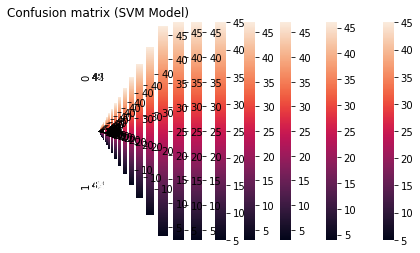

In [26]:
# Initialize variables to store results
shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50

for i in range(n_iterations):
    # Step 2: Initial sampling
    
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])
    sampled_df

    #test
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # train
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train= remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    #Modelling 
    # Creating and running our optimization

    study_svm = optuna.create_study(direction='maximize',study_name ="SVM")

    with parallel_backend('threading'):
        study_svm.optimize(objective_svm, n_trials=10, n_jobs=-1)
    # Evaluating our Optuna Trial
    print("Best trial:", study_svm.best_trial.number)
    print("Best accuracy:", study_svm.best_trial.value)
    print("Best hyperparameters:", study_svm.best_params)
    best_param_svm = study_svm.best_params
    SVM = SVC(**best_param_svm,random_state=rs).fit(x_train_,y_train)
    y_pred_svm = SVM.predict(x_test_)


    display_results(y_test, y_pred_svm, cm_title = "Confusion matrix (SVM Model)")

    
    
    # SHAP value computation using parallel processing
    num_cores = -1  # Use all available cores
    shap_values = compute_shap_values(SVM, x_test_, num_cores)


    # Extract SHAP values
    shap_values_array = abs(shap_values)

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)



In [27]:
all_shap_values_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,Outcome
0,0.062274,0.164583,0.004464,0.003583,0.155274,0.004774,0.008345,0.059488,0
1,0.022274,0.140417,0.001226,0.005750,0.155750,0.000274,0.021798,0.094560,0
2,0.002179,0.111107,0.005083,0.032702,0.338060,0.006536,0.023798,0.010988,0
3,0.023286,0.122310,0.001857,0.022762,0.290143,0.001000,0.009714,0.004452,0
4,0.002107,0.057440,0.009060,0.000155,0.279369,0.005012,0.014917,0.076179,0
...,...,...,...,...,...,...,...,...,...
4995,0.080667,0.036810,0.153167,0.000571,0.188214,0.014524,0.178048,0.003143,1
4996,0.054560,0.109560,0.003226,0.170155,0.141726,0.122750,0.013298,0.000298,1
4997,0.176321,0.316512,0.008655,0.358083,0.027131,0.055012,0.047417,0.182988,1
4998,0.014976,0.175476,0.004048,0.059048,0.262762,0.061048,0.037667,0.033024,1


In [28]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]
        



In [29]:
# Call the add_to_df function to populate valuestability
add_to_df()
valuestability

cv = valuestability.sum(axis=1) / valuestability.shape[1]
valuestability['CV'] = cv

# Save the DataFrame to an Excel file
valuestability.to_excel('10_svm_valuestability.xlsx', index=False)
valuestability

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,CV
0,0.328783,0.115908,1.229359,0.721051,0.239616,0.600189,0.486688,0.453966,0.521945
1,0.626388,0.139741,0.955888,0.555938,0.105917,0.622137,0.433508,0.389356,0.478609
2,0.511471,0.235494,1.026032,0.190369,0.390119,0.510129,0.495848,0.721263,0.510091
3,0.286638,0.155481,1.083299,0.352726,0.296787,0.646152,0.745303,0.637049,0.525429
4,0.944957,0.331730,1.233484,0.603633,0.322372,0.516912,0.337922,0.553474,0.605561
...,...,...,...,...,...,...,...,...,...
95,0.536011,0.715241,0.903703,0.542638,1.011641,0.594934,0.650304,0.689655,0.705516
96,0.570214,0.715614,1.903202,0.292041,0.334859,0.375079,0.658801,1.929881,0.847461
97,0.603813,0.328698,1.700848,0.360743,0.790070,0.314889,0.768296,0.338978,0.650792
98,0.484244,0.648899,0.691735,0.202459,0.241700,0.725567,0.536403,0.728043,0.532381


## Xgboost

In [30]:
df = pd.read_csv("data_resampled_50.csv")
#from sklearn.model_selection import RepeatedKFold
rs=123

cv = RepeatedKFold(n_splits=10 , n_repeats=5, random_state=rs)

def display_results(y_test, y_pred, cm_title):
        cm = confusion_matrix(y_test,y_pred)
        sns.heatmap(cm, annot=True, fmt='d').set_title(cm_title)
        print(classification_report(y_test,y_pred))



In [31]:
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score

def objective_xgb(trial: optuna.Trial):
    # Assume the data is already split into x_train_ and y_train_
    n_minority = y_train.sum()  # Number of minority class instances (assume minority class is '1')
    n_majority = len(y_train) - n_minority  # Number of majority class instances (assume majority class is '0')
    
    # Calculate scale_pos_weight
    scale_pos_weight = n_majority / n_minority
    
    # Define hyperparameters
    param_xgb = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': 0.1,  # Fixed at 0.1 as per your instructions
        'n_estimators': 200,  # Fixed at 200
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 1e1),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 1e1),
        'scale_pos_weight': scale_pos_weight  # Calculated to handle class imbalance
    }

    # Create and evaluate the XGBoost model
    xgb_model = xgb.XGBClassifier(**param_xgb, use_label_encoder=False, eval_metric='logloss', random_state=123)
    score = cross_val_score(xgb_model, x_train_, y_train, cv=cv, scoring="f1_macro").mean()

    return score

# Example usage:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective_xgb, n_trials=100)


[I 2024-08-26 19:10:41,821] A new study created in memory with name: XGBoost
[I 2024-08-26 19:10:47,954] Trial 4 finished with value: 0.8736756988441394 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.5334103071667609, 'colsample_bytree': 0.7787478390770404, 'reg_alpha': 0.0230300205508535, 'reg_lambda': 0.013057140942838805}. Best is trial 4 with value: 0.8736756988441394.
[I 2024-08-26 19:10:48,331] Trial 3 finished with value: 0.8716365794142417 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.7037284743101997, 'colsample_bytree': 0.6554203960088099, 'reg_alpha': 0.0017869960294353315, 'reg_lambda': 0.01243651344526991}. Best is trial 4 with value: 0.8736756988441394.
[I 2024-08-26 19:10:49,808] Trial 5 finished with value: 0.8842717147906097 and parameters: {'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.7711610968693797, 'colsample_bytree': 0.9508949880477252, 'reg_alpha': 0.004268189420419941, 'reg_lambda': 9.583892315754031}. B

Best trial: 2
Best accuracy: 0.887684088933015
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.719144408777395, 'colsample_bytree': 0.8894983187795273, 'reg_alpha': 0.006798844473961072, 'reg_lambda': 0.13619886669422784}
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.433377  1.337453       0.233112       0.636709  0.087021  0.107608   
1      0.136425  0.782286       0.160086       0.237020  3.831046  0.665742   
2      0.015051  0.974023       0.037098       0.224732  2.005308  0.746261   
3      0.190248  0.494419       0.022477       0.802828  4.551458  0.842426   
4      0.187981  2.055376  

[I 2024-08-26 19:11:02,603] Trial 4 finished with value: 0.8695570459212916 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.5250716689490688, 'colsample_bytree': 0.8029152181741324, 'reg_alpha': 3.906968408085969e-05, 'reg_lambda': 0.002584474219257309}. Best is trial 4 with value: 0.8695570459212916.
[I 2024-08-26 19:11:02,874] Trial 2 finished with value: 0.8742581680200171 and parameters: {'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.6713536696570366, 'colsample_bytree': 0.7809954387706819, 'reg_alpha': 0.9536840606422334, 'reg_lambda': 0.005786069529477744}. Best is trial 2 with value: 0.8742581680200171.
[I 2024-08-26 19:11:03,387] Trial 0 finished with value: 0.8746008832751387 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.7349126064786622, 'colsample_bytree': 0.6391426078187328, 'reg_alpha': 0.039162659647558586, 'reg_lambda': 0.02427808351829299}. Best is trial 0 with value: 0.8746008832751387.
[I 2024-08-26 19:11:03,835]

Best trial: 6
Best accuracy: 0.8886479465245186
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.9626469274535103, 'colsample_bytree': 0.5488912152656134, 'reg_alpha': 1.449934380565027, 'reg_lambda': 0.05693659179878162}
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.012279  0.919413       0.002824       0.344611  0.246763  0.418099   
1      0.067809  0.758495       0.126685       0.143993  3.030345  0.851916   
2      0.093526  1.251065       0.056053       0.141035  1.633745  0.338143   
3      0.233153  0.300890       0.299211       0.355084  3.499871  0.545841   
4      0.038570  1.603563   

[I 2024-08-26 19:11:16,250] Trial 5 finished with value: 0.8749336328933426 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.531001446842511, 'colsample_bytree': 0.8867505898659908, 'reg_alpha': 0.00529844014593472, 'reg_lambda': 0.47101976944777824}. Best is trial 5 with value: 0.8749336328933426.
[I 2024-08-26 19:11:16,537] Trial 4 finished with value: 0.8771747235385857 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.8499355376302651, 'colsample_bytree': 0.6450068052772118, 'reg_alpha': 0.04325096081272238, 'reg_lambda': 4.646843171246251e-05}. Best is trial 4 with value: 0.8771747235385857.
[I 2024-08-26 19:11:16,726] Trial 1 finished with value: 0.8809981717847581 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8510011932159194, 'colsample_bytree': 0.8119526627328248, 'reg_alpha': 8.830585032124537e-05, 'reg_lambda': 0.40762739663043285}. Best is trial 1 with value: 0.8809981717847581.
[I 2024-08-26 19:11:16,842] 

Best trial: 6
Best accuracy: 0.887303636536534
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.9545181443915679, 'colsample_bytree': 0.8335158624942526, 'reg_alpha': 0.0024651431888908135, 'reg_lambda': 0.0029756587535007756}
              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.054533  0.732138       0.007115       0.567551  0.251087  0.430539   
1      0.242610  0.949272       0.020212       0.264639  3.183949  0.767087   
2      0.301429  0.901203       0.255126       0.653763  0.779413  0.459586   
3      0.072669  0.840387       0.256637       0.659318  3.346934  0.307592   
4      0.099794  1.2240

[I 2024-08-26 19:11:30,695] Trial 3 finished with value: 0.8751678009364813 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.7074654994175467, 'colsample_bytree': 0.772127641831321, 'reg_alpha': 1.839011200431274e-05, 'reg_lambda': 3.010223611264055}. Best is trial 3 with value: 0.8751678009364813.
[I 2024-08-26 19:11:31,999] Trial 2 finished with value: 0.8756118285856707 and parameters: {'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.5805190855171503, 'colsample_bytree': 0.5622739873818718, 'reg_alpha': 1.86240830215185e-05, 'reg_lambda': 0.0293091904767771}. Best is trial 2 with value: 0.8756118285856707.
[I 2024-08-26 19:11:32,045] Trial 0 finished with value: 0.8836141289860987 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.8156878747052274, 'colsample_bytree': 0.6217550978766693, 'reg_alpha': 0.19733305633995615, 'reg_lambda': 0.0005295374961108004}. Best is trial 0 with value: 0.8836141289860987.
[I 2024-08-26 19:11:32,361] T

Best trial: 4
Best accuracy: 0.8900037581201764
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.8702031043439644, 'colsample_bytree': 0.9339270429850934, 'reg_alpha': 0.7478715351762417, 'reg_lambda': 0.0001559113084802518}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.398048  0.891979       0.086772       0.593963  0.011092  0.584664   
1      0.070246  0.805127       0.203614       0.593599  3.639811  0.477723   
2      0.173682  1.042526       0.256071       0.525971  1.473204  1.088692   
3      0.080447  0.397682       0.048995       0.878143  3.954553  0.445833   
4      0.206425  1.613874

[I 2024-08-26 19:11:46,251] Trial 0 finished with value: 0.8779528027296503 and parameters: {'max_depth': 9, 'min_child_weight': 8, 'subsample': 0.6924190620026709, 'colsample_bytree': 0.8309042685619538, 'reg_alpha': 3.2669562113126593, 'reg_lambda': 8.413017365929077e-05}. Best is trial 0 with value: 0.8779528027296503.
[I 2024-08-26 19:11:46,291] Trial 1 finished with value: 0.8775279679839965 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.6920028191656695, 'colsample_bytree': 0.7626925779563747, 'reg_alpha': 0.023192507616894068, 'reg_lambda': 3.1085038110173984e-05}. Best is trial 0 with value: 0.8779528027296503.
[I 2024-08-26 19:11:47,232] Trial 5 finished with value: 0.8822097844382261 and parameters: {'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.9487851477766625, 'colsample_bytree': 0.5718243933172972, 'reg_alpha': 1.1607756415302521e-05, 'reg_lambda': 1.1299932297836617}. Best is trial 5 with value: 0.8822097844382261.
[I 2024-08-26 19:11:47,3

Best trial: 8
Best accuracy: 0.8871407984605656
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.9957740877021717, 'colsample_bytree': 0.6884656768696171, 'reg_alpha': 0.00017775547730448582, 'reg_lambda': 0.0071409858597838724}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.021043  0.806279       0.136310       0.550443  0.152676  0.298713   
1      0.190655  0.756635       0.097992       0.212159  3.326391  0.934185   
2      0.352913  0.850153       0.197478       0.423538  0.721705  0.816208   
3      0.300839  0.830272       0.205691       0.365189  3.460219  0.487155   
4      0.053219  1.49

[I 2024-08-26 19:12:00,433] Trial 5 finished with value: 0.8793537720027529 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.7363473200421549, 'colsample_bytree': 0.9423285840838438, 'reg_alpha': 1.070889398237742e-05, 'reg_lambda': 2.9812698795888433}. Best is trial 5 with value: 0.8793537720027529.
[I 2024-08-26 19:12:00,662] Trial 0 finished with value: 0.8777672849499599 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.6552015881703316, 'colsample_bytree': 0.7976664948331802, 'reg_alpha': 0.0018266839284533064, 'reg_lambda': 7.750822931698805}. Best is trial 5 with value: 0.8793537720027529.
[I 2024-08-26 19:12:01,196] Trial 3 finished with value: 0.8744298353522224 and parameters: {'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.6048613953571194, 'colsample_bytree': 0.9191608926912573, 'reg_alpha': 1.689304346357976e-05, 'reg_lambda': 9.413892781422305e-05}. Best is trial 5 with value: 0.8793537720027529.
[I 2024-08-26 19:12:02,6

Best trial: 2
Best accuracy: 0.8888962620971465
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.8380988856106649, 'colsample_bytree': 0.7688125653152338, 'reg_alpha': 0.5914660119116201, 'reg_lambda': 0.00038633406647689463}
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.585802  0.705908       0.019204       0.771194  0.566198  0.459765   
1      0.180204  0.935663       0.184666       0.195648  3.419509  0.905157   
2      0.109357  0.817737       0.344413       0.495216  1.767904  1.059491   
3      0.563871  0.475656       0.219962       0.522116  3.815979  0.671907   
4      0.113880  1.50914

[I 2024-08-26 19:12:14,763] Trial 1 finished with value: 0.8760319999887739 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.6661309052885338, 'colsample_bytree': 0.709019534531383, 'reg_alpha': 7.661983313939507e-05, 'reg_lambda': 0.0009264167320455602}. Best is trial 1 with value: 0.8760319999887739.
[I 2024-08-26 19:12:14,879] Trial 4 finished with value: 0.8724184882461996 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.665300409109479, 'colsample_bytree': 0.6236491727215443, 'reg_alpha': 0.0003792069396978737, 'reg_lambda': 0.0002968488430475283}. Best is trial 1 with value: 0.8760319999887739.
[I 2024-08-26 19:12:14,952] Trial 0 finished with value: 0.8743568481140426 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.6530781984288663, 'colsample_bytree': 0.7218007120478173, 'reg_alpha': 0.7255965019999912, 'reg_lambda': 2.3171977486530383e-05}. Best is trial 1 with value: 0.8760319999887739.
[I 2024-08-26 19:12:15

Best trial: 7
Best accuracy: 0.8877126623123579
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 2, 'subsample': 0.7266346934342731, 'colsample_bytree': 0.8922795721901595, 'reg_alpha': 1.2080039548271977, 'reg_lambda': 0.5720679196826417}
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        50
           1       0.91      0.84      0.87        50

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.328692  1.278065       0.088122       0.390541  0.110667  0.485971   
1      0.020430  0.766737       0.007749       0.358609  2.972405  0.782484   
2      0.131918  1.317010       0.159423       0.504536  1.543723  1.040818   
3      0.017663  0.350671       0.173482       0.800105  3.521392  0.275773   
4      0.090598  1.378617   

[I 2024-08-26 19:12:28,444] Trial 4 finished with value: 0.8742697057430341 and parameters: {'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.5145681346296848, 'colsample_bytree': 0.9483721226899466, 'reg_alpha': 0.00010191407088368465, 'reg_lambda': 9.790265245686836}. Best is trial 4 with value: 0.8742697057430341.
[I 2024-08-26 19:12:28,914] Trial 1 finished with value: 0.8701765456736097 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.5508421815680524, 'colsample_bytree': 0.5927682698330619, 'reg_alpha': 0.08983643671540568, 'reg_lambda': 1.2768514738612162}. Best is trial 4 with value: 0.8742697057430341.
[I 2024-08-26 19:12:29,403] Trial 0 finished with value: 0.8796920823843964 and parameters: {'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.6528154580912969, 'colsample_bytree': 0.6922018121558496, 'reg_alpha': 0.5119251693995396, 'reg_lambda': 3.9819682490509845}. Best is trial 0 with value: 0.8796920823843964.
[I 2024-08-26 19:12:30,169] Trial

Best trial: 8
Best accuracy: 0.8842592531454021
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.768945783264843, 'colsample_bytree': 0.5445319330099022, 'reg_alpha': 1.3200516321360223, 'reg_lambda': 3.401764672018022e-05}
              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.139747  0.871070       0.047872       0.572348  0.379230  0.520146   
1      0.114977  0.781179       0.014036       0.215510  2.942905  0.581924   
2      0.002886  0.746134       0.024462       0.357222  1.380538  0.364610   
3      0.212970  0.331734       0.214333       0.663445  3.251016  0.446152   
4      0.196329  1.827161

[I 2024-08-26 19:12:43,148] Trial 2 finished with value: 0.8727587986611691 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.5041314969816912, 'colsample_bytree': 0.6339009223037146, 'reg_alpha': 0.013098106816840097, 'reg_lambda': 5.891202154303875}. Best is trial 2 with value: 0.8727587986611691.
[I 2024-08-26 19:12:43,462] Trial 3 finished with value: 0.8723526470641642 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.5054197466791588, 'colsample_bytree': 0.6218582441353584, 'reg_alpha': 0.06865831267203672, 'reg_lambda': 0.010196846088929207}. Best is trial 2 with value: 0.8727587986611691.
[I 2024-08-26 19:12:43,772] Trial 5 finished with value: 0.8817868720887596 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.9283185522414961, 'colsample_bytree': 0.7988630911182091, 'reg_alpha': 0.08238440914759163, 'reg_lambda': 0.0036559183099131687}. Best is trial 5 with value: 0.8817868720887596.
[I 2024-08-26 19:12:44,161] 

Best trial: 6
Best accuracy: 0.890290571551112
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.7217536466920481, 'colsample_bytree': 0.9715499846711667, 'reg_alpha': 0.00039410900330501296, 'reg_lambda': 0.2050262986548938}
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        50
           1       0.91      0.84      0.87        50

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.734286  1.240098       0.185464       0.597262  0.294245  0.062268   
1      0.194648  1.158405       0.379983       0.323818  4.075018  1.345782   
2      0.055413  1.358799       0.026866       0.565558  2.266825  0.809571   
3      0.401639  0.569203       0.064451       0.939329  4.463626  0.502349   
4      0.312705  1.856165

[I 2024-08-26 19:12:57,606] Trial 4 finished with value: 0.8796811872485314 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.7452270703477339, 'colsample_bytree': 0.8250795812092931, 'reg_alpha': 6.054612261866393e-05, 'reg_lambda': 0.024102209701390712}. Best is trial 4 with value: 0.8796811872485314.
[I 2024-08-26 19:12:57,782] Trial 3 finished with value: 0.8748230167726996 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.6516949261925531, 'colsample_bytree': 0.8569828800247434, 'reg_alpha': 1.6075186826355972, 'reg_lambda': 1.1292072099752705e-05}. Best is trial 4 with value: 0.8796811872485314.
[I 2024-08-26 19:12:58,723] Trial 5 finished with value: 0.8812661463353676 and parameters: {'max_depth': 6, 'min_child_weight': 9, 'subsample': 0.9393467046300077, 'colsample_bytree': 0.9844173388269003, 'reg_alpha': 0.0062272128773129334, 'reg_lambda': 2.3916133048451154}. Best is trial 5 with value: 0.8812661463353676.
[I 2024-08-26 19:12:58,93

Best trial: 9
Best accuracy: 0.8846315538129578
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.869318149588861, 'colsample_bytree': 0.8947059347600214, 'reg_alpha': 1.1103824857335784e-05, 'reg_lambda': 0.14804002445659908}
              precision    recall  f1-score   support

           0       0.79      0.90      0.84        50
           1       0.88      0.76      0.82        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.308588  0.910510       0.077352       0.472025  0.199321  0.132103   
1      0.000739  1.157037       0.173778       0.654149  3.538514  0.634797   
2      0.103592  1.301197       0.260609       0.246945  1.080740  0.815888   
3      0.171361  0.923945       0.048341       0.469018  3.837967  0.312842   
4      0.123928  1.53355

[I 2024-08-26 19:13:11,803] Trial 1 finished with value: 0.8709637632489462 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.5491735333495815, 'colsample_bytree': 0.5600925813221187, 'reg_alpha': 0.23756979857862606, 'reg_lambda': 0.000635670248536874}. Best is trial 1 with value: 0.8709637632489462.
[I 2024-08-26 19:13:11,884] Trial 3 finished with value: 0.8722475582651502 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.5353495842885987, 'colsample_bytree': 0.63619510504967, 'reg_alpha': 4.585959136681817, 'reg_lambda': 0.0075838195339108525}. Best is trial 3 with value: 0.8722475582651502.
[I 2024-08-26 19:13:12,080] Trial 2 finished with value: 0.8741800989684775 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.6658557142219762, 'colsample_bytree': 0.5759908216626897, 'reg_alpha': 0.02446319408589607, 'reg_lambda': 0.35075758266608165}. Best is trial 2 with value: 0.8741800989684775.
[I 2024-08-26 19:13:12,283] Tr

Best trial: 5
Best accuracy: 0.8862129429035486
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.9861309846366624, 'colsample_bytree': 0.8201061826827591, 'reg_alpha': 0.27768062655198733, 'reg_lambda': 0.6009141289692564}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.297451  0.893153       0.047829       0.587323  0.292288  0.019766   
1      0.179016  0.975103       0.161087       0.385336  3.350816  0.834510   
2      0.344390  1.017426       0.254249       0.383741  0.742838  0.674218   
3      0.037188  0.798647       0.223694       0.470846  3.617219  0.282882   
4      0.071616  1.365362  

[I 2024-08-26 19:13:24,819] Trial 5 finished with value: 0.8737179296347132 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.5225591120650233, 'colsample_bytree': 0.9222314979616044, 'reg_alpha': 1.19741360744131e-05, 'reg_lambda': 0.004072541411709924}. Best is trial 5 with value: 0.8737179296347132.
[I 2024-08-26 19:13:25,425] Trial 4 finished with value: 0.874883233062512 and parameters: {'max_depth': 7, 'min_child_weight': 8, 'subsample': 0.5146303686791149, 'colsample_bytree': 0.8818501962393042, 'reg_alpha': 4.87732541286682, 'reg_lambda': 0.00028141262518730474}. Best is trial 4 with value: 0.874883233062512.
[I 2024-08-26 19:13:26,285] Trial 3 finished with value: 0.8717859056090786 and parameters: {'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.5297510880613816, 'colsample_bytree': 0.5159361424666493, 'reg_alpha': 1.4096100930909186, 'reg_lambda': 0.13846820454999817}. Best is trial 4 with value: 0.874883233062512.
[I 2024-08-26 19:13:26,966] Tria

Best trial: 8
Best accuracy: 0.8878654982612773
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.9530130884387704, 'colsample_bytree': 0.9981679248240962, 'reg_alpha': 0.8934751089618791, 'reg_lambda': 0.0016169537893369937}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.119177  0.965407       0.007250       0.709787  0.471433  0.162976   
1      0.024225  0.566950       0.065318       0.223889  3.034822  0.747103   
2      0.088657  1.239603       0.274129       0.487381  1.166144  0.753322   
3      0.062069  0.258808       0.187065       0.685188  3.367188  0.232802   
4      0.151153  1.422068

[I 2024-08-26 19:13:32,604] A new study created in memory with name: XGBoost
[I 2024-08-26 19:13:38,932] Trial 1 finished with value: 0.8691683787311854 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.5225585977430914, 'colsample_bytree': 0.6492163372667638, 'reg_alpha': 0.12913309099838335, 'reg_lambda': 0.0065334310420825685}. Best is trial 1 with value: 0.8691683787311854.
[I 2024-08-26 19:13:40,133] Trial 4 finished with value: 0.8734420515971775 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.6714561647886033, 'colsample_bytree': 0.8098356771968973, 'reg_alpha': 0.5793589338764636, 'reg_lambda': 0.012254651865502307}. Best is trial 4 with value: 0.8734420515971775.
[I 2024-08-26 19:13:41,120] Trial 0 finished with value: 0.8909913121391747 and parameters: {'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.8567287783182658, 'colsample_bytree': 0.9609393069452484, 'reg_alpha': 0.00038646651639535814, 'reg_lambda': 1.5667074761128716}

Best trial: 0
Best accuracy: 0.8909913121391747
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 2, 'subsample': 0.8567287783182658, 'colsample_bytree': 0.9609393069452484, 'reg_alpha': 0.00038646651639535814, 'reg_lambda': 1.5667074761128716}
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.535271  1.067138       0.030793       0.466394  0.414548  0.418742   
1      0.084778  0.804416       0.201422       0.562384  3.352880  0.815058   
2      0.066659  1.171257       0.254759       0.547054  2.376291  0.687719   
3      0.130769  0.470277       0.191331       0.782262  4.277126  0.827535   
4      0.078576  1.98031

[I 2024-08-26 19:13:53,878] Trial 0 finished with value: 0.8727516396197692 and parameters: {'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.5351942361863483, 'colsample_bytree': 0.8244417062489062, 'reg_alpha': 0.06593011770470891, 'reg_lambda': 0.7358456115997887}. Best is trial 0 with value: 0.8727516396197692.
[I 2024-08-26 19:13:54,057] Trial 4 finished with value: 0.886331451248757 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.7597786846815351, 'colsample_bytree': 0.8569559582159789, 'reg_alpha': 5.451694714075276, 'reg_lambda': 0.0064520955832026656}. Best is trial 4 with value: 0.886331451248757.
[I 2024-08-26 19:13:54,212] Trial 3 finished with value: 0.8770279567105903 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.7316322960997566, 'colsample_bytree': 0.9972831969324317, 'reg_alpha': 0.004685102903350843, 'reg_lambda': 0.015609096364001955}. Best is trial 4 with value: 0.886331451248757.
[I 2024-08-26 19:13:54,343] Trial

Best trial: 4
Best accuracy: 0.886331451248757
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.7597786846815351, 'colsample_bytree': 0.8569559582159789, 'reg_alpha': 5.451694714075276, 'reg_lambda': 0.0064520955832026656}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.042445  0.767863       0.015409       0.239746  0.199357  0.434479   
1      0.015291  0.674739       0.000682       0.462858  2.059648  0.236616   
2      0.009188  0.812439       0.032570       0.353570  0.731689  0.318673   
3      0.071975  0.502953       0.036452       0.359332  2.166280  0.365128   
4      0.046983  0.909346  

[I 2024-08-26 19:14:07,377] Trial 1 finished with value: 0.8701289042820874 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.5987870682433734, 'colsample_bytree': 0.514490207070913, 'reg_alpha': 0.45681846120952396, 'reg_lambda': 3.5187495201899696e-05}. Best is trial 1 with value: 0.8701289042820874.
[I 2024-08-26 19:14:07,565] Trial 0 finished with value: 0.8734403443740042 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.5738832914362944, 'colsample_bytree': 0.5078147202297874, 'reg_alpha': 0.38669002801436847, 'reg_lambda': 0.15027785679857802}. Best is trial 0 with value: 0.8734403443740042.
[I 2024-08-26 19:14:07,760] Trial 3 finished with value: 0.8766556656983708 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.6401370824880299, 'colsample_bytree': 0.8147318174624614, 'reg_alpha': 4.653327474089594, 'reg_lambda': 0.000778559167321113}. Best is trial 3 with value: 0.8766556656983708.
[I 2024-08-26 19:14:08,802] T

Best trial: 9
Best accuracy: 0.8874728983739537
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.9911059715555979, 'colsample_bytree': 0.9182617765400486, 'reg_alpha': 0.07235873018261982, 'reg_lambda': 0.00046307864409445807}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 19:14:14,900] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.270392  1.177780       0.136044       0.828043  0.011021  0.197987   
1      0.195227  0.757294       0.129894       0.245860  3.602824  0.756054   
2      0.428614  1.003592       0.219329       0.344192  1.448810  1.127130   
3      0.175905  0.380057       0.287616       0.592325  4.123027  0.480267   
4      0.294172  1.370861       0.512301       0.717394  1.571004  0.523272   
..          ...       ...            ...            ...       ...       ...   
95     0.282224  0.690851       0.907644       0.235818  0.537300  0.767258   
96     0.162936  2.896888       0.290470       0.037286  2.611325  1.468075   
97     0.016695  2.294977       0.017782       0.480872  1.506526  0.227878   
98     0.246949  0.490637       0.556194       0.183490  5.410278  0.190562   
99     0.007481  2.647205       0.128632       0.349847  0.572406  0.055938   

         DPF       Age  Outcome  
0   0.656752  0.7

[I 2024-08-26 19:14:21,511] Trial 0 finished with value: 0.8753710225644745 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.7541555063567906, 'colsample_bytree': 0.9849453258237691, 'reg_alpha': 0.10282571918547427, 'reg_lambda': 0.0014114882445209606}. Best is trial 0 with value: 0.8753710225644745.
[I 2024-08-26 19:14:22,214] Trial 2 finished with value: 0.8772671693124372 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.8637931494090185, 'colsample_bytree': 0.8971115185460982, 'reg_alpha': 0.02225244702949427, 'reg_lambda': 0.0007849158039810209}. Best is trial 2 with value: 0.8772671693124372.
[I 2024-08-26 19:14:23,683] Trial 4 finished with value: 0.881481482584688 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.6478148567260447, 'colsample_bytree': 0.881019227929746, 'reg_alpha': 0.9097855669092062, 'reg_lambda': 0.00018933036100838533}. Best is trial 4 with value: 0.881481482584688.
[I 2024-08-26 19:14:24,491]

Best trial: 5
Best accuracy: 0.8850770270972855
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.812145497538082, 'colsample_bytree': 0.9048995959757122, 'reg_alpha': 3.5418755085554867, 'reg_lambda': 0.002123867029930021}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.096689  1.003696       0.039320       0.348419  0.032745  0.301501   
1      0.064430  0.657620       0.011698       0.034317  2.278004  0.669068   
2      0.007646  0.900783       0.030400       0.301634  1.241294  0.882089   
3      0.165155  0.539035       0.133503       0.444128  2.652952  0.295433   
4      0.160724  1.255740  

[I 2024-08-26 19:14:29,824] A new study created in memory with name: XGBoost
[I 2024-08-26 19:14:35,920] Trial 1 finished with value: 0.8740165994747008 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.6200168638639698, 'colsample_bytree': 0.8139761443038138, 'reg_alpha': 6.647516524238134, 'reg_lambda': 0.00990833194821542}. Best is trial 1 with value: 0.8740165994747008.
[I 2024-08-26 19:14:37,108] Trial 2 finished with value: 0.8745615446154215 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.8263327857328323, 'colsample_bytree': 0.8099600498383472, 'reg_alpha': 0.00023683070911684868, 'reg_lambda': 0.6438272026929909}. Best is trial 2 with value: 0.8745615446154215.
[I 2024-08-26 19:14:37,335] Trial 4 finished with value: 0.8815288723540258 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.9708772360862976, 'colsample_bytree': 0.6574692464338261, 'reg_alpha': 1.0707731711027322e-05, 'reg_lambda': 0.8647560310056915}.

Best trial: 9
Best accuracy: 0.8878777092148001
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.9630511198547329, 'colsample_bytree': 0.916304857955039, 'reg_alpha': 1.0222398829632406, 'reg_lambda': 0.0024719193046948674}
              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.011863  0.888616       0.048270       0.553582  0.197372  0.367809   
1      0.195141  1.013617       0.001612       0.229650  3.097748  0.493196   
2      0.252012  1.085333       0.338710       0.317545  0.769592  0.551377   
3      0.115675  0.774517       0.257559       0.518848  3.154258  0.270512   
4      0.020458  1.173213 

[I 2024-08-26 19:14:50,396] Trial 4 finished with value: 0.8752514485810364 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.5588033087346214, 'colsample_bytree': 0.6801293670735513, 'reg_alpha': 0.03666678983049205, 'reg_lambda': 0.0007447939894655798}. Best is trial 4 with value: 0.8752514485810364.
[I 2024-08-26 19:14:51,091] Trial 2 finished with value: 0.8801161224727345 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8988585481998685, 'colsample_bytree': 0.641685546240297, 'reg_alpha': 2.610051159498963e-05, 'reg_lambda': 1.2676128931720572e-05}. Best is trial 2 with value: 0.8801161224727345.
[I 2024-08-26 19:14:52,096] Trial 5 finished with value: 0.8708401101848472 and parameters: {'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.5360296232781593, 'colsample_bytree': 0.9209102307396551, 'reg_alpha': 0.0013911987265220606, 'reg_lambda': 0.021698526536311304}. Best is trial 2 with value: 0.8801161224727345.
[I 2024-08-26 19:14:5

Best trial: 7
Best accuracy: 0.8935915552598126
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 3, 'subsample': 0.9604675396264941, 'colsample_bytree': 0.9097158845524693, 'reg_alpha': 2.208397720118253, 'reg_lambda': 0.0010910619915281714}
              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 19:14:58,859] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.074612  0.822721       0.091437       0.331730  0.697699  0.331263   
1      0.031827  0.877523       0.121008       0.349869  2.550610  0.779899   
2      0.085405  1.021776       0.092430       0.328047  0.804447  1.203932   
3      0.216981  0.373080       0.066093       0.503538  2.927538  0.378146   
4      0.061546  1.369704       0.136971       0.392650  1.033237  0.566998   
..          ...       ...            ...            ...       ...       ...   
95     0.425749  0.410808       0.337911       0.389728  0.135557  0.262249   
96     0.098180  2.528944       0.089466       0.329742  1.641804  1.231855   
97     0.069420  2.213223       0.019652       0.804964  0.806373  0.266736   
98     0.212591  0.426174       0.063005       0.107877  4.227307  0.137836   
99     0.129146  2.119131       0.047599       0.269955  0.052109  0.275523   

         DPF       Age  Outcome  
0   0.390940  0.6

[I 2024-08-26 19:15:05,346] Trial 0 finished with value: 0.8731955383364887 and parameters: {'max_depth': 6, 'min_child_weight': 10, 'subsample': 0.5071264688264208, 'colsample_bytree': 0.7658048698224644, 'reg_alpha': 0.004735951093457912, 'reg_lambda': 0.0010980974806583147}. Best is trial 0 with value: 0.8731955383364887.
[I 2024-08-26 19:15:05,881] Trial 1 finished with value: 0.8738410474076268 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.6621742961508401, 'colsample_bytree': 0.9824561856174286, 'reg_alpha': 0.00013951005208904678, 'reg_lambda': 3.6647928841502264e-05}. Best is trial 1 with value: 0.8738410474076268.
[I 2024-08-26 19:15:05,986] Trial 2 finished with value: 0.8743876919693563 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.7007763864972052, 'colsample_bytree': 0.8965144410084399, 'reg_alpha': 1.1774189038691303, 'reg_lambda': 0.015520165392154516}. Best is trial 2 with value: 0.8743876919693563.
[I 2024-08-26 19:15

Best trial: 7
Best accuracy: 0.8871515248887551
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 3, 'subsample': 0.9155908869186486, 'colsample_bytree': 0.7253873515420031, 'reg_alpha': 0.0001362918522851094, 'reg_lambda': 3.911406385330019}
              precision    recall  f1-score   support

           0       0.83      0.90      0.87        50
           1       0.89      0.82      0.85        50

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100



[I 2024-08-26 19:15:13,961] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.182292  0.980012       0.146274       0.674864  0.562563  0.601785   
1      0.123516  0.600316       0.240399       0.037258  3.366487  0.958541   
2      0.151899  0.750259       0.173411       0.334272  1.360185  1.166995   
3      0.116814  0.319559       0.130976       0.498936  3.723371  0.392168   
4      0.251747  1.795551       0.388165       0.685022  1.261984  0.669117   
..          ...       ...            ...            ...       ...       ...   
95     0.302065  0.544249       0.550099       0.624416  0.341213  0.745104   
96     0.036580  2.906907       0.185100       0.027954  2.392129  1.573453   
97     0.018382  2.595747       0.045560       0.247279  1.007787  0.269684   
98     0.147395  0.690249       0.263108       0.171861  4.496367  0.187505   
99     0.209994  2.432225       0.169973       0.303001  0.152104  0.050851   

         DPF       Age  Outcome  
0   0.609268  0.6

[I 2024-08-26 19:15:20,422] Trial 3 finished with value: 0.8733273234527998 and parameters: {'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.5148072938560552, 'colsample_bytree': 0.7004957327277275, 'reg_alpha': 0.032142717500427874, 'reg_lambda': 0.0006613423332740329}. Best is trial 3 with value: 0.8733273234527998.
[I 2024-08-26 19:15:20,722] Trial 5 finished with value: 0.8782401115208487 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.7145807305109839, 'colsample_bytree': 0.59590690939675, 'reg_alpha': 0.0018852180754647691, 'reg_lambda': 0.012428299150624102}. Best is trial 5 with value: 0.8782401115208487.
[I 2024-08-26 19:15:22,800] Trial 2 finished with value: 0.8844312800114719 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.8589544153675959, 'colsample_bytree': 0.5451048135658068, 'reg_alpha': 0.009826193131057533, 'reg_lambda': 0.007851870165435192}. Best is trial 2 with value: 0.8844312800114719.
[I 2024-08-26 19:15:22,8

Best trial: 0
Best accuracy: 0.8913703315403366
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.9486838286824975, 'colsample_bytree': 0.7991226058961788, 'reg_alpha': 6.63230248805347e-05, 'reg_lambda': 0.25580051831623596}
              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100



[I 2024-08-26 19:15:28,653] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.397876  1.426470       0.032212       0.559373  0.346582  0.164831   
1      0.154637  0.937463       0.285525       0.101278  4.777860  0.744772   
2      0.195531  1.542807       0.033143       0.715548  2.635046  1.078295   
3      0.026670  0.112220       0.553588       0.843525  5.310739  0.401685   
4      0.499963  2.594789       0.040428       0.952948  1.487346  0.892083   
..          ...       ...            ...            ...       ...       ...   
95     0.171992  0.496462       0.437856       0.537945  0.608602  0.585836   
96     0.110555  4.205557       0.216928       0.545023  2.962384  1.732500   
97     0.325917  3.351623       0.138262       1.622705  1.350675  0.375567   
98     0.362120  0.357598       0.231480       0.197679  6.007593  0.447412   
99     0.101008  3.525379       0.054097       0.498885  0.571928  0.402340   

         DPF       Age  Outcome  
0   0.503028  0.3

[I 2024-08-26 19:15:35,555] Trial 1 finished with value: 0.8737038244700019 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.6880418309870173, 'colsample_bytree': 0.9842138643407461, 'reg_alpha': 2.9824134703322015e-05, 'reg_lambda': 7.897698346040481e-05}. Best is trial 1 with value: 0.8737038244700019.
[I 2024-08-26 19:15:35,639] Trial 3 finished with value: 0.8833233616535969 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.9472459500822519, 'colsample_bytree': 0.8245681267131437, 'reg_alpha': 0.002450485205538897, 'reg_lambda': 1.982950818331775e-05}. Best is trial 3 with value: 0.8833233616535969.
[I 2024-08-26 19:15:35,971] Trial 4 finished with value: 0.8802615998619647 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.8729116929168321, 'colsample_bytree': 0.6315084970246755, 'reg_alpha': 0.04440201201091969, 'reg_lambda': 0.33062495610929504}. Best is trial 3 with value: 0.8833233616535969.
[I 2024-08-26 19:15:

Best trial: 9
Best accuracy: 0.8862556912003912
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 8, 'subsample': 0.9559735197136184, 'colsample_bytree': 0.9096829956408661, 'reg_alpha': 0.0001071050160457386, 'reg_lambda': 0.02185328888199306}
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



[I 2024-08-26 19:15:42,775] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.176175  0.901758       0.079908       0.508042  0.363440  0.005140   
1      0.094608  0.992902       0.194930       0.462281  3.409025  0.814198   
2      0.318831  1.152988       0.348941       0.447278  0.955705  0.719979   
3      0.070384  0.870113       0.468333       0.574136  3.605270  0.256001   
4      0.084831  1.267355       0.504136       0.616302  0.928843  0.444652   
..          ...       ...            ...            ...       ...       ...   
95     0.147345  0.849424       0.597547       0.315857  0.431187  0.542463   
96     0.003119  2.619946       0.223561       0.089354  2.731424  0.768833   
97     0.059272  2.238246       0.195322       0.326740  0.869388  0.357636   
98     0.119477  0.402568       0.426867       0.269713  4.001417  0.020172   
99     0.166153  2.199734       0.061751       0.474057  0.584501  0.103128   

         DPF       Age  Outcome  
0   0.592926  0.7

[I 2024-08-26 19:15:49,343] Trial 4 finished with value: 0.870553462969644 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.5858228364771514, 'colsample_bytree': 0.5290247935947745, 'reg_alpha': 6.983959174104725, 'reg_lambda': 0.0007796552620683892}. Best is trial 4 with value: 0.870553462969644.
[I 2024-08-26 19:15:49,722] Trial 3 finished with value: 0.880955029543218 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.7908051168928946, 'colsample_bytree': 0.9167284457716047, 'reg_alpha': 0.000395403660228728, 'reg_lambda': 0.0003324791178947508}. Best is trial 3 with value: 0.880955029543218.
[I 2024-08-26 19:15:49,995] Trial 5 finished with value: 0.8765229192600742 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.6884460558528763, 'colsample_bytree': 0.8534558666331287, 'reg_alpha': 3.918185525095694e-05, 'reg_lambda': 0.09024737853839496}. Best is trial 3 with value: 0.880955029543218.
[I 2024-08-26 19:15:50,947] Tr

Best trial: 0
Best accuracy: 0.8869351554197179
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.7141555538410369, 'colsample_bytree': 0.6689982513769922, 'reg_alpha': 1.5638263972994508, 'reg_lambda': 0.09856393184224259}
              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100



[I 2024-08-26 19:15:56,454] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.134720  0.572954       0.005049       0.363983  0.387568  0.471271   
1      0.120095  0.485285       0.047662       0.074778  2.744832  0.783128   
2      0.041238  0.726748       0.390576       0.691380  1.363122  0.607623   
3      0.216231  0.206571       0.238175       0.569740  3.375753  0.337687   
4      0.268517  1.534022       0.084322       0.557134  1.194024  0.717122   
..          ...       ...            ...            ...       ...       ...   
95     0.438810  0.243065       0.073201       0.680848  0.250664  0.624495   
96     0.013555  2.599770       0.020371       0.013672  1.235546  1.621871   
97     0.166115  2.305284       0.029900       0.439911  0.929053  0.282973   
98     0.227498  0.539198       0.121315       0.106496  4.050290  0.463041   
99     0.113017  2.622607       0.144826       0.630828  0.087635  0.376366   

         DPF       Age  Outcome  
0   0.669290  0.5

[I 2024-08-26 19:16:03,971] Trial 3 finished with value: 0.8791178609604896 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7313505449099541, 'colsample_bytree': 0.9300834839966964, 'reg_alpha': 1.498842749541687, 'reg_lambda': 0.013403949201559417}. Best is trial 3 with value: 0.8791178609604896.
[I 2024-08-26 19:16:04,240] Trial 4 finished with value: 0.8804469558680691 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.6851361453127787, 'colsample_bytree': 0.6359642661200833, 'reg_alpha': 2.923144132028657, 'reg_lambda': 4.723228147378591e-05}. Best is trial 4 with value: 0.8804469558680691.
[I 2024-08-26 19:16:04,412] Trial 1 finished with value: 0.8835662711643671 and parameters: {'max_depth': 7, 'min_child_weight': 9, 'subsample': 0.9694529955568689, 'colsample_bytree': 0.744090565477092, 'reg_alpha': 0.00010597095148560374, 'reg_lambda': 0.0002099560311625275}. Best is trial 1 with value: 0.8835662711643671.
[I 2024-08-26 19:16:04,885] 

Best trial: 0
Best accuracy: 0.886886847794034
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.7087544425638297, 'colsample_bytree': 0.7986345293954173, 'reg_alpha': 2.8072503289767403, 'reg_lambda': 0.1990655675765669}
              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100



[I 2024-08-26 19:16:12,310] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.145430  0.793612       0.045836       0.545085  0.011364  0.340095   
1      0.194870  0.754220       0.088828       0.331965  2.314263  0.522719   
2      0.054314  0.907921       0.251246       0.428463  1.478681  0.454967   
3      0.170664  0.435673       0.368881       0.608773  2.676046  0.259926   
4      0.241881  1.414647       0.302775       0.499113  1.260635  0.459959   
..          ...       ...            ...            ...       ...       ...   
95     0.515766  0.415141       0.011755       0.557470  0.367662  0.354086   
96     0.108600  2.524613       0.012452       0.315912  1.369493  1.326038   
97     0.139992  1.780207       0.034317       0.403706  0.838271  0.075973   
98     0.199503  0.413473       0.034346       0.061362  3.865160  0.000907   
99     0.153545  1.933489       0.077620       0.550852  0.139929  0.148799   

         DPF       Age  Outcome  
0   0.277595  0.5

[I 2024-08-26 19:16:18,799] Trial 3 finished with value: 0.8815217460876107 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8530634737223683, 'colsample_bytree': 0.6063906933419939, 'reg_alpha': 6.0404787064346905, 'reg_lambda': 0.005276141969938139}. Best is trial 3 with value: 0.8815217460876107.
[I 2024-08-26 19:16:19,336] Trial 5 finished with value: 0.8739199105722022 and parameters: {'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.6680605880902609, 'colsample_bytree': 0.6970030365807648, 'reg_alpha': 0.07294818529687838, 'reg_lambda': 0.0008465840934118975}. Best is trial 3 with value: 0.8815217460876107.
[I 2024-08-26 19:16:19,584] Trial 4 finished with value: 0.877518330963035 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.6334881042891001, 'colsample_bytree': 0.9591401724245172, 'reg_alpha': 0.2438841573942887, 'reg_lambda': 3.25317879009804e-05}. Best is trial 3 with value: 0.8815217460876107.
[I 2024-08-26 19:16:20,872] T

Best trial: 9
Best accuracy: 0.8836946866098355
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.9579391173486373, 'colsample_bytree': 0.8572642518948012, 'reg_alpha': 0.0006748252453544081, 'reg_lambda': 1.689270724717171}
              precision    recall  f1-score   support

           0       0.81      0.88      0.85        50
           1       0.87      0.80      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100



[I 2024-08-26 19:16:26,623] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.005579  0.859518       0.035971       0.426923  0.233455  0.349357   
1      0.252564  0.907376       0.137157       0.436381  3.206194  0.638125   
2      0.284842  1.171496       0.292318       0.268133  0.772646  0.328031   
3      0.083819  0.818771       0.233931       0.544471  3.428750  0.440477   
4      0.081510  1.074127       0.318012       0.439318  0.758358  0.616810   
..          ...       ...            ...            ...       ...       ...   
95     0.101657  0.765924       0.500072       0.445347  0.058471  0.541954   
96     0.162320  2.003234       0.295142       0.294974  2.121283  0.719220   
97     0.140038  2.038378       0.166653       0.370572  1.192534  0.315046   
98     0.080816  0.571891       0.280478       0.323262  3.782135  0.103618   
99     0.096994  1.584952       0.040853       0.375200  0.372291  0.222433   

         DPF       Age  Outcome  
0   0.488493  0.6

[I 2024-08-26 19:16:33,396] Trial 5 finished with value: 0.8705424776103914 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.5940383701346668, 'colsample_bytree': 0.533148201559851, 'reg_alpha': 3.2542155845709684, 'reg_lambda': 0.0007517065689359841}. Best is trial 5 with value: 0.8705424776103914.
[I 2024-08-26 19:16:35,305] Trial 3 finished with value: 0.8874136562208207 and parameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7256186129710964, 'colsample_bytree': 0.6497428685418709, 'reg_alpha': 6.9796726052375e-05, 'reg_lambda': 2.1480165164902063}. Best is trial 3 with value: 0.8874136562208207.
[I 2024-08-26 19:16:35,776] Trial 0 finished with value: 0.8830466359156723 and parameters: {'max_depth': 5, 'min_child_weight': 3, 'subsample': 0.7744418290172488, 'colsample_bytree': 0.7928850236893643, 'reg_alpha': 0.3609523406994817, 'reg_lambda': 0.09910827961533193}. Best is trial 3 with value: 0.8874136562208207.
[I 2024-08-26 19:16:35,846] Tria

Best trial: 3
Best accuracy: 0.8874136562208207
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.7256186129710964, 'colsample_bytree': 0.6497428685418709, 'reg_alpha': 6.9796726052375e-05, 'reg_lambda': 2.1480165164902063}
              precision    recall  f1-score   support

           0       0.85      0.90      0.87        50
           1       0.89      0.84      0.87        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100



[I 2024-08-26 19:16:43,020] A new study created in memory with name: XGBoost


    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.175073  0.881572       0.097137       0.242499  0.265261  0.691812   
1      0.387287  0.666245       0.349759       0.392337  3.447990  0.764096   
2      0.074471  0.961146       0.282908       0.196967  1.956041  0.464059   
3      0.003762  0.274003       0.094575       0.420417  3.762747  0.706725   
4      0.403270  2.057607       0.105101       0.563818  1.954893  0.886533   
..          ...       ...            ...            ...       ...       ...   
95     0.420399  0.100872       0.253418       0.735274  0.162768  0.705394   
96     0.062813  3.319235       0.104238       0.313529  0.644408  2.079383   
97     0.291143  2.891384       0.029076       0.862478  0.414237  0.450060   
98     0.270483  0.824107       0.077652       0.220859  4.841787  0.188362   
99     0.015930  3.094816       0.296760       0.299032  0.552269  0.315149   

         DPF       Age  Outcome  
0   0.553279  0.8

[I 2024-08-26 19:16:50,289] Trial 0 finished with value: 0.8734133319237982 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.6461031222559395, 'colsample_bytree': 0.7062305202489363, 'reg_alpha': 0.6958091536635178, 'reg_lambda': 0.0002737272399271819}. Best is trial 0 with value: 0.8734133319237982.
[I 2024-08-26 19:16:50,428] Trial 5 finished with value: 0.8741747387878211 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.5968821818497325, 'colsample_bytree': 0.9000902348342095, 'reg_alpha': 0.006958041721163605, 'reg_lambda': 2.1634711423528143}. Best is trial 5 with value: 0.8741747387878211.
[I 2024-08-26 19:16:51,824] Trial 3 finished with value: 0.8878938634615328 and parameters: {'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.9525076187078958, 'colsample_bytree': 0.7190941881590116, 'reg_alpha': 4.978741820236022, 'reg_lambda': 0.18097050294307973}. Best is trial 3 with value: 0.8878938634615328.
[I 2024-08-26 19:16:52,404] Tria

Best trial: 3
Best accuracy: 0.8878938634615328
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.9525076187078958, 'colsample_bytree': 0.7190941881590116, 'reg_alpha': 4.978741820236022, 'reg_lambda': 0.18097050294307973}


[I 2024-08-26 19:16:59,601] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.103948  0.773969       0.032040       0.274626  0.074601  0.322270   
1      0.034015  0.651665       0.060776       0.113315  1.930055  0.340813   
2      0.000209  0.765627       0.124964       0.394834  1.079406  0.564821   
3      0.101314  0.525445       0.074452       0.391798  2.168953  0.350077   
4      0.107982  0.850966       0.131630       0.306258  0.942738  0.332252   
..          ...       ...            ...            ...       ...       ...   
95     0.207148  0.350493       0.140981       0.345611  0.481911  0.329493   
96     0.010735  1.978887       0.004649 

[I 2024-08-26 19:17:06,763] Trial 4 finished with value: 0.8731688110540843 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'subsample': 0.5118436515985781, 'colsample_bytree': 0.721034846623017, 'reg_alpha': 0.17131715234593167, 'reg_lambda': 4.512849232027913}. Best is trial 4 with value: 0.8731688110540843.
[I 2024-08-26 19:17:08,004] Trial 2 finished with value: 0.8823465528822857 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.846183241560658, 'colsample_bytree': 0.7161495645317921, 'reg_alpha': 0.009206560020450465, 'reg_lambda': 2.4783483075534596}. Best is trial 2 with value: 0.8823465528822857.
[I 2024-08-26 19:17:08,529] Trial 5 finished with value: 0.8803023420878262 and parameters: {'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.7578689160025491, 'colsample_bytree': 0.5959366394506976, 'reg_alpha': 0.10495166546681267, 'reg_lambda': 0.8400112245671946}. Best is trial 2 with value: 0.8823465528822857.
[I 2024-08-26 19:17:08,660] Trial 0

Best trial: 8
Best accuracy: 0.8860386692509534
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 3, 'subsample': 0.970992425898458, 'colsample_bytree': 0.5683697813047095, 'reg_alpha': 3.008495510656316e-05, 'reg_lambda': 2.0121219491053637}


[I 2024-08-26 19:17:16,499] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.079610  0.758246       0.087656       0.496211  0.458903  0.394640   
1      0.072023  0.793993       0.240485       0.164470  3.285277  1.076999   
2      0.085597  1.035154       0.131589       0.245458  1.375491  1.027129   
3      0.211745  0.455531       0.029878       0.543136  3.652851  0.593102   
4      0.019281  1.749058       0.372911       0.595785  1.179304  0.465311   
..          ...       ...            ...            ...       ...       ...   
95     0.217373  0.261552       0.383300       0.675833  0.358626  0.690293   
96     0.119546  2.909883       0.166440 

[I 2024-08-26 19:17:23,667] Trial 4 finished with value: 0.8680338601778278 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.660059490820934, 'colsample_bytree': 0.8425159608162125, 'reg_alpha': 9.230118922525119, 'reg_lambda': 0.00022438471646504948}. Best is trial 4 with value: 0.8680338601778278.
[I 2024-08-26 19:17:24,398] Trial 0 finished with value: 0.8857870363508124 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.8638972427638247, 'colsample_bytree': 0.6331183548791404, 'reg_alpha': 4.086479532644211, 'reg_lambda': 1.3364890304348397e-05}. Best is trial 0 with value: 0.8857870363508124.
[I 2024-08-26 19:17:25,262] Trial 2 finished with value: 0.8787425959092379 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.7872065540627063, 'colsample_bytree': 0.5406671570013463, 'reg_alpha': 0.0009124225249024511, 'reg_lambda': 0.00025207001406917314}. Best is trial 0 with value: 0.8857870363508124.
[I 2024-08-26 19:17:25,2

Best trial: 8
Best accuracy: 0.8931807705357148
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.994777513565547, 'colsample_bytree': 0.9417004982474131, 'reg_alpha': 0.4489743209859538, 'reg_lambda': 6.840299185370725e-05}


[I 2024-08-26 19:17:32,731] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.94      0.88        50
           1       0.93      0.80      0.86        50

    accuracy                           0.87       100
   macro avg       0.88      0.87      0.87       100
weighted avg       0.88      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.335533  1.291071       0.020901       0.477606  0.548330  0.371341   
1      0.120799  0.771345       0.086097       0.255151  3.594999  0.605880   
2      0.166456  1.044716       0.001339       0.333828  1.268410  0.880386   
3      0.023793  0.019955       0.241220       0.910604  4.156490  0.342854   
4      0.170234  1.816626       0.157867       0.638848  1.797617  0.865738   
..          ...       ...            ...            ...       ...       ...   
95     0.143940  0.562446       0.575976       0.343235  0.164985  0.521636   
96     0.003536  3.179325       0.111933 

[I 2024-08-26 19:17:40,631] Trial 0 finished with value: 0.8793581875659529 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.8471093447810094, 'colsample_bytree': 0.7256621871995297, 'reg_alpha': 0.016607291250874744, 'reg_lambda': 0.0004786708990293527}. Best is trial 0 with value: 0.8793581875659529.
[I 2024-08-26 19:17:41,121] Trial 3 finished with value: 0.8851431181950441 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.9924246839534223, 'colsample_bytree': 0.6240755379045875, 'reg_alpha': 4.707145782693791e-05, 'reg_lambda': 0.9162237616990689}. Best is trial 3 with value: 0.8851431181950441.
[I 2024-08-26 19:17:41,694] Trial 5 finished with value: 0.8742642796784666 and parameters: {'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.5659416465574021, 'colsample_bytree': 0.6183946440212902, 'reg_alpha': 0.88505399003929, 'reg_lambda': 0.014501302784424509}. Best is trial 3 with value: 0.8851431181950441.
[I 2024-08-26 19:17:42,024] T

Best trial: 1
Best accuracy: 0.8859850153480298
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.9206459300485625, 'colsample_bytree': 0.7771521559879172, 'reg_alpha': 0.0006375922151341068, 'reg_lambda': 9.778930868342318}


[I 2024-08-26 19:17:47,950] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.008233  0.885011       0.020907       0.268586  0.026364  0.412217   
1      0.224981  1.026087       0.044895       0.296077  2.935422  0.513225   
2      0.243915  1.045869       0.167095       0.523121  0.774572  0.481275   
3      0.047444  0.843896       0.179558       0.594833  3.277398  0.514890   
4      0.205908  1.067672       0.257248       0.305604  0.717170  0.505035   
..          ...       ...            ...            ...       ...       ...   
95     0.076467  0.681514       0.397130       0.312359  0.075938  0.537667   
96     0.079403  2.322848       0.182942 

[I 2024-08-26 19:17:54,343] Trial 2 finished with value: 0.8720313409130618 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.5096695185184833, 'colsample_bytree': 0.7579077568139825, 'reg_alpha': 4.622838326800063e-05, 'reg_lambda': 0.0016643306323672288}. Best is trial 2 with value: 0.8720313409130618.
[I 2024-08-26 19:17:55,027] Trial 1 finished with value: 0.8760569254316917 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.6812593209440695, 'colsample_bytree': 0.6508473525848508, 'reg_alpha': 3.092741728805098e-05, 'reg_lambda': 0.0014632337209642232}. Best is trial 1 with value: 0.8760569254316917.
[I 2024-08-26 19:17:55,785] Trial 3 finished with value: 0.8798587633939279 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.8883609965402133, 'colsample_bytree': 0.6034193699418868, 'reg_alpha': 0.3360226810848002, 'reg_lambda': 1.7475664703591551}. Best is trial 3 with value: 0.8798587633939279.
[I 2024-08-26 19:17:5

Best trial: 3
Best accuracy: 0.8798587633939279
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.8883609965402133, 'colsample_bytree': 0.6034193699418868, 'reg_alpha': 0.3360226810848002, 'reg_lambda': 1.7475664703591551}


[I 2024-08-26 19:18:02,159] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.90      0.85        50
           1       0.89      0.78      0.83        50

    accuracy                           0.84       100
   macro avg       0.84      0.84      0.84       100
weighted avg       0.84      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.046068  0.656856       0.098411       0.397811  0.374170  0.543960   
1      0.184021  0.879053       0.052922       0.246090  2.778282  0.627082   
2      0.363402  0.983514       0.236702       0.068716  0.787541  0.406964   
3      0.138632  0.695162       0.191675       0.314313  2.813189  0.495923   
4      0.002538  1.029086       0.271534       0.481640  0.927628  0.623839   
..          ...       ...            ...            ...       ...       ...   
95     0.010294  0.459788       0.253036       0.712494  0.078221  0.431643   
96     0.121793  1.929922       0.146673 

[I 2024-08-26 19:18:09,132] Trial 3 finished with value: 0.8780586843090452 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.7538430837635113, 'colsample_bytree': 0.6623766656688288, 'reg_alpha': 0.14418994666444254, 'reg_lambda': 2.8450190047323245}. Best is trial 3 with value: 0.8780586843090452.
[I 2024-08-26 19:18:09,233] Trial 4 finished with value: 0.8698061230551194 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.6507908592617232, 'colsample_bytree': 0.7341133402418375, 'reg_alpha': 1.0880299109143113e-05, 'reg_lambda': 0.0028836035510760075}. Best is trial 3 with value: 0.8780586843090452.
[I 2024-08-26 19:18:10,374] Trial 2 finished with value: 0.8813898479183885 and parameters: {'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.7780975052863104, 'colsample_bytree': 0.5245265219813338, 'reg_alpha': 0.21840174711317317, 'reg_lambda': 1.3602671672569891e-05}. Best is trial 2 with value: 0.8813898479183885.
[I 2024-08-26 19:18:11,2

Best trial: 6
Best accuracy: 0.8892686440223181
Best hyperparameters: {'max_depth': 7, 'min_child_weight': 1, 'subsample': 0.9806901996158846, 'colsample_bytree': 0.8795255828695187, 'reg_alpha': 0.07709129195849844, 'reg_lambda': 7.979534458133945e-05}


[I 2024-08-26 19:18:16,969] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.94      0.87        50
           1       0.93      0.78      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.461788  1.423175       0.064102       0.934611  0.285164  0.554863   
1      0.095696  1.149089       0.125686       0.071888  4.542277  0.322400   
2      0.258856  1.442103       0.314384       0.474964  2.255640  0.587429   
3      0.010947  0.396195       0.316494       0.683589  5.059060  0.539520   
4      0.362045  1.840567       0.451710       0.831660  1.623877  1.100100   
..          ...       ...            ...            ...       ...       ...   
95     0.162908  0.684036       0.566543       0.102149  0.725317  0.819343   
96     0.130480  3.785098       0.221158 

[I 2024-08-26 19:18:24,182] Trial 3 finished with value: 0.8706285697013201 and parameters: {'max_depth': 7, 'min_child_weight': 5, 'subsample': 0.5778109459007252, 'colsample_bytree': 0.5381242588387812, 'reg_alpha': 5.795075445639579, 'reg_lambda': 7.544987053582102}. Best is trial 3 with value: 0.8706285697013201.
[I 2024-08-26 19:18:25,455] Trial 5 finished with value: 0.883063240044312 and parameters: {'max_depth': 10, 'min_child_weight': 6, 'subsample': 0.9473255659825746, 'colsample_bytree': 0.7280233912396952, 'reg_alpha': 0.0003469921339658558, 'reg_lambda': 0.8470827297385598}. Best is trial 5 with value: 0.883063240044312.
[I 2024-08-26 19:18:25,599] Trial 2 finished with value: 0.8756831206005466 and parameters: {'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.6804383758079584, 'colsample_bytree': 0.753576647008283, 'reg_alpha': 0.0002570970976931718, 'reg_lambda': 0.0018794046227046635}. Best is trial 5 with value: 0.883063240044312.
[I 2024-08-26 19:18:25,736] Trial

Best trial: 6
Best accuracy: 0.8845995935753822
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 3, 'subsample': 0.7743040983958043, 'colsample_bytree': 0.938329312025298, 'reg_alpha': 0.12820859289741734, 'reg_lambda': 0.37377128815290583}


[I 2024-08-26 19:18:32,598] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.85      0.92      0.88        50
           1       0.91      0.84      0.87        50

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.268713  1.294745       0.121467       0.571997  0.198255  0.185828   
1      0.093382  0.771499       0.177729       0.256069  3.826442  1.089809   
2      0.284604  1.267627       0.399619       0.257019  1.656023  0.991119   
3      0.036687  0.562246       0.252398       0.342875  4.524099  0.569956   
4      0.343933  1.809438       0.484278       0.650158  1.293769  0.509013   
..          ...       ...            ...            ...       ...       ...   
95     0.678905  0.675529       0.687073       0.230156  0.720806  0.768572   
96     0.274451  2.527471       0.444396 

[I 2024-08-26 19:18:40,052] Trial 2 finished with value: 0.887202780827222 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.9825899788952004, 'colsample_bytree': 0.8534336751146414, 'reg_alpha': 0.2235805487633521, 'reg_lambda': 0.23328342397653057}. Best is trial 2 with value: 0.887202780827222.
[I 2024-08-26 19:18:40,792] Trial 1 finished with value: 0.8725562305146597 and parameters: {'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.628143706971024, 'colsample_bytree': 0.526540790666601, 'reg_alpha': 0.01712105932213017, 'reg_lambda': 0.0006959925970453598}. Best is trial 2 with value: 0.887202780827222.
[I 2024-08-26 19:18:40,834] Trial 5 finished with value: 0.8830842581423677 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.9776007202993857, 'colsample_bytree': 0.6822265796080644, 'reg_alpha': 1.424685268222675, 'reg_lambda': 7.003126872392581e-05}. Best is trial 2 with value: 0.887202780827222.
[I 2024-08-26 19:18:41,584] Trial 0 

Best trial: 0
Best accuracy: 0.8887852297570106
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 1, 'subsample': 0.908929787956229, 'colsample_bytree': 0.7950447750420901, 'reg_alpha': 0.07120958326260782, 'reg_lambda': 0.12698755282409846}


[I 2024-08-26 19:18:47,521] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.294101  1.271486       0.051544       0.863281  0.016525  0.486510   
1      0.126790  0.740409       0.103143       0.306343  3.997991  0.696396   
2      0.044575  1.352556       0.496151       0.544220  2.770134  1.000860   
3      0.107991  0.268449       0.526553       0.677809  4.852567  0.150480   
4      0.454775  2.579205       0.097607       0.979277  1.991808  0.537749   
..          ...       ...            ...            ...       ...       ...   
95     0.161731  0.651170       0.862564       0.556779  0.239086  1.063307   
96     0.287416  4.195175       0.282800 

[I 2024-08-26 19:18:54,432] Trial 4 finished with value: 0.869726854523863 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.5278500911434738, 'colsample_bytree': 0.5478657427758449, 'reg_alpha': 0.0005093081026037586, 'reg_lambda': 0.002895136525792299}. Best is trial 4 with value: 0.869726854523863.
[I 2024-08-26 19:18:54,522] Trial 1 finished with value: 0.8847022633910617 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7505237997250536, 'colsample_bytree': 0.5726621907598122, 'reg_alpha': 3.4356073172614243, 'reg_lambda': 0.0011503229916743102}. Best is trial 1 with value: 0.8847022633910617.
[I 2024-08-26 19:18:56,271] Trial 5 finished with value: 0.8863161818711093 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.9889181134141207, 'colsample_bytree': 0.8512592451176239, 'reg_alpha': 0.07154123887056815, 'reg_lambda': 2.1868333691356083e-05}. Best is trial 5 with value: 0.8863161818711093.
[I 2024-08-26 19:18:56,94

Best trial: 3
Best accuracy: 0.8868466444174712
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 4, 'subsample': 0.9722612855557005, 'colsample_bytree': 0.7834964257047993, 'reg_alpha': 0.00030824771130159796, 'reg_lambda': 6.593164482905338e-05}


[I 2024-08-26 19:19:03,222] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.78      0.92      0.84        50
           1       0.90      0.74      0.81        50

    accuracy                           0.83       100
   macro avg       0.84      0.83      0.83       100
weighted avg       0.84      0.83      0.83       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.270051  0.782635       0.254249       1.008418  0.305952  0.108355   
1      0.070552  0.605957       0.217273       0.049106  3.732612  1.070575   
2      0.039011  0.938679       0.281090       0.740528  1.121951  1.017599   
3      0.292565  0.165713       0.085709       0.814819  4.197069  0.305852   
4      0.074183  1.543339       0.339404       0.918346  1.455864  0.366361   
..          ...       ...            ...            ...       ...       ...   
95     0.666098  0.680609       1.046420       0.319187  0.748422  1.080415   
96     0.436132  3.296973       0.218088 

[I 2024-08-26 19:19:10,528] Trial 1 finished with value: 0.8760737595807501 and parameters: {'max_depth': 6, 'min_child_weight': 8, 'subsample': 0.6305388316419868, 'colsample_bytree': 0.9218791166077214, 'reg_alpha': 0.0005963502509770488, 'reg_lambda': 0.000303009631519188}. Best is trial 1 with value: 0.8760737595807501.
[I 2024-08-26 19:19:10,633] Trial 5 finished with value: 0.8828191201960186 and parameters: {'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.8110259842745484, 'colsample_bytree': 0.7071004711645834, 'reg_alpha': 1.6663056177270255, 'reg_lambda': 3.9937164891650065e-05}. Best is trial 5 with value: 0.8828191201960186.
[I 2024-08-26 19:19:10,720] Trial 2 finished with value: 0.8770490847305904 and parameters: {'max_depth': 4, 'min_child_weight': 8, 'subsample': 0.7576640949122526, 'colsample_bytree': 0.7946838767158626, 'reg_alpha': 0.006259211903961697, 'reg_lambda': 0.00870495801989253}. Best is trial 5 with value: 0.8828191201960186.
[I 2024-08-26 19:19:10,87

Best trial: 5
Best accuracy: 0.8828191201960186
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.8110259842745484, 'colsample_bytree': 0.7071004711645834, 'reg_alpha': 1.6663056177270255, 'reg_lambda': 3.9937164891650065e-05}


[I 2024-08-26 19:19:16,666] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.014185  0.734643       0.003275       0.354037  0.432821  0.246438   
1      0.246594  0.873079       0.038967       0.274170  2.677306  0.840345   
2      0.249688  0.868213       0.176703       0.114786  0.536153  0.477776   
3      0.045481  0.811082       0.217890       0.257818  2.870764  0.363557   
4      0.122598  1.143355       0.227076       0.341127  0.473402  0.483010   
..          ...       ...            ...            ...       ...       ...   
95     0.118169  0.622935       0.069074       0.771105  0.040596  0.488533   
96     0.163406  2.170363       0.065432 

[I 2024-08-26 19:19:23,402] Trial 4 finished with value: 0.8713827413584897 and parameters: {'max_depth': 5, 'min_child_weight': 9, 'subsample': 0.5576831765227954, 'colsample_bytree': 0.504581858878832, 'reg_alpha': 1.6432791470858394, 'reg_lambda': 0.015674965491103657}. Best is trial 4 with value: 0.8713827413584897.
[I 2024-08-26 19:19:23,814] Trial 0 finished with value: 0.8859879810400991 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.9738485495369249, 'colsample_bytree': 0.6015517088951958, 'reg_alpha': 0.06226200802910341, 'reg_lambda': 0.08052540807808198}. Best is trial 0 with value: 0.8859879810400991.
[I 2024-08-26 19:19:23,852] Trial 2 finished with value: 0.8757746318931726 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.6492222095518886, 'colsample_bytree': 0.7445027857343122, 'reg_alpha': 0.048009189778626525, 'reg_lambda': 5.955211849129215}. Best is trial 0 with value: 0.8859879810400991.
[I 2024-08-26 19:19:25,155] Trial

Best trial: 9
Best accuracy: 0.8861770806417429
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 2, 'subsample': 0.9023719099959021, 'colsample_bytree': 0.7360353037258798, 'reg_alpha': 0.12914381426032187, 'reg_lambda': 0.0001955779974881712}


[I 2024-08-26 19:19:31,997] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.720255  0.975231       0.082208       0.745719  0.107764  0.659527   
1      0.194667  1.083657       0.575147       0.059081  4.085775  0.740837   
2      0.088001  1.139210       0.047013       0.799041  1.892748  1.370651   
3      0.328479  0.526773       0.042353       0.386894  4.707496  0.547230   
4      0.355831  1.857810       0.189917       0.877686  1.108888  0.560977   
..          ...       ...            ...            ...       ...       ...   
95     0.140637  0.018235       0.272109       0.534318  0.091224  0.798520   
96     0.387741  3.174976       0.274338 

[I 2024-08-26 19:19:38,885] Trial 3 finished with value: 0.8760133025084993 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.7559431254907737, 'colsample_bytree': 0.6954672829436847, 'reg_alpha': 0.0005095533506677004, 'reg_lambda': 0.0002051793559954114}. Best is trial 3 with value: 0.8760133025084993.
[I 2024-08-26 19:19:39,593] Trial 5 finished with value: 0.8833352835429583 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.8490163656678269, 'colsample_bytree': 0.7911224557788201, 'reg_alpha': 0.00037062635568318997, 'reg_lambda': 5.950121246642018}. Best is trial 5 with value: 0.8833352835429583.
[I 2024-08-26 19:19:40,563] Trial 2 finished with value: 0.8869525494796834 and parameters: {'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.9471532421521226, 'colsample_bytree': 0.946954209159493, 'reg_alpha': 0.0004463915075867699, 'reg_lambda': 1.8393359444298927}. Best is trial 2 with value: 0.8869525494796834.
[I 2024-08-26 19:19:41,0

Best trial: 7
Best accuracy: 0.8920692494022692
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.8802594454878708, 'colsample_bytree': 0.9602590267230899, 'reg_alpha': 0.021530885005078115, 'reg_lambda': 2.7953697019073753}


[I 2024-08-26 19:19:46,476] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.84      0.92      0.88        50
           1       0.91      0.82      0.86        50

    accuracy                           0.87       100
   macro avg       0.87      0.87      0.87       100
weighted avg       0.87      0.87      0.87       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.298036  0.607698       0.045577       0.714539  0.080117  0.796793   
1      0.156064  0.782283       0.180361       0.374405  3.397649  0.838149   
2      0.010724  1.109863       0.092583       0.191355  2.180734  1.129845   
3      0.038759  0.308809       0.030028       0.758217  3.950696  0.494793   
4      0.180117  1.880626       0.136096       0.826035  0.972587  0.740357   
..          ...       ...            ...            ...       ...       ...   
95     0.452871  0.414856       0.518931       0.339704  0.025383  0.697259   
96     0.127268  3.223841       0.258470 

[I 2024-08-26 19:19:54,844] Trial 2 finished with value: 0.8779017708051774 and parameters: {'max_depth': 9, 'min_child_weight': 5, 'subsample': 0.6150306081654773, 'colsample_bytree': 0.722243573310088, 'reg_alpha': 0.07566409104959704, 'reg_lambda': 3.1990904566300995}. Best is trial 2 with value: 0.8779017708051774.
[I 2024-08-26 19:19:54,907] Trial 4 finished with value: 0.8830783506605238 and parameters: {'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.9600578425652915, 'colsample_bytree': 0.9703266968989568, 'reg_alpha': 0.5167803498884043, 'reg_lambda': 0.14197831391081547}. Best is trial 4 with value: 0.8830783506605238.
[I 2024-08-26 19:19:55,216] Trial 5 finished with value: 0.8825065567877992 and parameters: {'max_depth': 5, 'min_child_weight': 5, 'subsample': 0.8733041124502166, 'colsample_bytree': 0.8837054245783227, 'reg_alpha': 0.00036149741129576916, 'reg_lambda': 0.00011768877663292702}. Best is trial 4 with value: 0.8830783506605238.
[I 2024-08-26 19:19:55,543]

Best trial: 3
Best accuracy: 0.8872147913999585
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 5, 'subsample': 0.9958538890186162, 'colsample_bytree': 0.9842536564713757, 'reg_alpha': 3.319648381709051e-05, 'reg_lambda': 3.5388059223601074e-05}


[I 2024-08-26 19:20:01,682] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.250830  1.143473       0.169690       0.800033  0.049942  0.454427   
1      0.075026  0.680024       0.194796       0.318070  3.178739  1.042602   
2      0.269530  1.012002       0.117844       0.381189  1.257738  0.980103   
3      0.106810  0.487301       0.250535       0.509321  3.631354  0.340474   
4      0.054901  1.429472       0.424830       0.686524  1.241043  0.767856   
..          ...       ...            ...            ...       ...       ...   
95     0.196702  0.644049       0.873991       0.278777  0.603211  0.762325   
96     0.257104  2.932768       0.238806 

[I 2024-08-26 19:20:08,471] Trial 3 finished with value: 0.873308312760909 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.546441522601071, 'colsample_bytree': 0.7621097906889216, 'reg_alpha': 8.414877811386674e-05, 'reg_lambda': 0.0009217426891702281}. Best is trial 3 with value: 0.873308312760909.
[I 2024-08-26 19:20:08,616] Trial 1 finished with value: 0.8757471025032422 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.5549476365951356, 'colsample_bytree': 0.982247732673079, 'reg_alpha': 0.00012630726085512335, 'reg_lambda': 3.6923224598808813}. Best is trial 1 with value: 0.8757471025032422.
[I 2024-08-26 19:20:08,960] Trial 0 finished with value: 0.8727299021915212 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'subsample': 0.6291971318223208, 'colsample_bytree': 0.727456851026939, 'reg_alpha': 7.64432800873639e-05, 'reg_lambda': 0.03275019747909428}. Best is trial 1 with value: 0.8757471025032422.
[I 2024-08-26 19:20:10,009] 

Best trial: 8
Best accuracy: 0.8841710417659498
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.7485452992397352, 'colsample_bytree': 0.5220504115265678, 'reg_alpha': 0.00023533737874291866, 'reg_lambda': 0.0021100751791152646}


[I 2024-08-26 19:20:15,627] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.79      0.84      0.82        50
           1       0.83      0.78      0.80        50

    accuracy                           0.81       100
   macro avg       0.81      0.81      0.81       100
weighted avg       0.81      0.81      0.81       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.752140  1.114861       0.049994       0.633328  0.120523  0.592439   
1      0.320096  0.356195       0.011990       0.059876  3.670534  0.736077   
2      0.136904  0.828488       0.070055       0.311523  1.086043  1.232157   
3      0.447960  0.050031       0.090994       0.602391  3.883487  0.280549   
4      0.141293  1.637464       0.326943       0.710424  1.093556  0.297273   
..          ...       ...            ...            ...       ...       ...   
95     0.297694  0.098082       0.428807       0.795519  0.467947  0.697465   
96     0.353458  3.276423       0.157432 

[I 2024-08-26 19:20:22,489] Trial 4 finished with value: 0.8713814722912785 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'subsample': 0.5366325816446642, 'colsample_bytree': 0.696441496907404, 'reg_alpha': 0.00042587018759849806, 'reg_lambda': 0.014969352073031437}. Best is trial 4 with value: 0.8713814722912785.
[I 2024-08-26 19:20:23,461] Trial 3 finished with value: 0.876773565918784 and parameters: {'max_depth': 7, 'min_child_weight': 6, 'subsample': 0.6498552998366582, 'colsample_bytree': 0.8111598310159369, 'reg_alpha': 2.149167276283341e-05, 'reg_lambda': 0.028832530279808276}. Best is trial 3 with value: 0.876773565918784.
[I 2024-08-26 19:20:24,231] Trial 0 finished with value: 0.8835270412365955 and parameters: {'max_depth': 6, 'min_child_weight': 6, 'subsample': 0.929109423466408, 'colsample_bytree': 0.9286069043057169, 'reg_alpha': 0.0014270080966086154, 'reg_lambda': 0.02709520949151948}. Best is trial 0 with value: 0.8835270412365955.
[I 2024-08-26 19:20:24,363

Best trial: 1
Best accuracy: 0.8871295403753393
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.9995262054479622, 'colsample_bytree': 0.8247284394392548, 'reg_alpha': 0.00020648136471752894, 'reg_lambda': 0.22293087615280535}


[I 2024-08-26 19:20:29,920] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.316259  0.946379       0.034126       0.588050  0.101505  0.090721   
1      0.041490  0.992522       0.263946       0.265320  3.523020  0.779453   
2      0.248083  0.738918       0.235983       0.358007  0.874672  0.475153   
3      0.125437  0.671279       0.247952       0.716786  4.009597  0.257539   
4      0.190770  1.520300       0.442342       0.610424  0.757666  0.310697   
..          ...       ...            ...            ...       ...       ...   
95     0.123264  0.525678       0.698974       0.566396  0.524974  0.499075   
96     0.160184  2.639210       0.300770 

[I 2024-08-26 19:20:36,654] Trial 2 finished with value: 0.8692188952225708 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.5858046371204515, 'colsample_bytree': 0.5342513858684246, 'reg_alpha': 0.15065386269695014, 'reg_lambda': 0.001193541966627342}. Best is trial 2 with value: 0.8692188952225708.
[I 2024-08-26 19:20:37,060] Trial 1 finished with value: 0.8711589346353007 and parameters: {'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.5822240764466584, 'colsample_bytree': 0.8942133613491172, 'reg_alpha': 0.1765040026376922, 'reg_lambda': 0.07632592591365221}. Best is trial 1 with value: 0.8711589346353007.
[I 2024-08-26 19:20:37,246] Trial 3 finished with value: 0.885547910441195 and parameters: {'max_depth': 8, 'min_child_weight': 10, 'subsample': 0.8193988321127177, 'colsample_bytree': 0.8136473323529072, 'reg_alpha': 2.2822918938520496, 'reg_lambda': 0.005308346983291318}. Best is trial 3 with value: 0.885547910441195.
[I 2024-08-26 19:20:37,382] Tria

Best trial: 0
Best accuracy: 0.887797365622426
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 4, 'subsample': 0.8616210464178427, 'colsample_bytree': 0.9132395411824583, 'reg_alpha': 0.05098186257520837, 'reg_lambda': 0.0014516941038292188}


[I 2024-08-26 19:20:43,374] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.81      0.92      0.86        50
           1       0.91      0.78      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.435978  1.477744       0.070175       0.794678  0.706675  1.028111   
1      0.020379  0.706416       0.036240       0.352394  3.554614  1.186906   
2      0.225284  1.350880       0.463947       0.414146  1.655749  1.219461   
3      0.038210  0.507097       0.257216       0.988932  4.003906  0.359283   
4      0.299852  1.932055       0.564415       0.794388  1.371333  0.795286   
..          ...       ...            ...            ...       ...       ...   
95     0.376401  0.411421       1.029921       0.421810  0.378387  0.982532   
96     0.274859  2.574061       0.547406 

[I 2024-08-26 19:20:50,200] Trial 5 finished with value: 0.8780298134087124 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.7945989447002066, 'colsample_bytree': 0.6969002518315248, 'reg_alpha': 0.007395040852506829, 'reg_lambda': 0.000522610994699003}. Best is trial 5 with value: 0.8780298134087124.
[I 2024-08-26 19:20:50,923] Trial 4 finished with value: 0.8727196387442671 and parameters: {'max_depth': 8, 'min_child_weight': 9, 'subsample': 0.8015484261677588, 'colsample_bytree': 0.8660849719026749, 'reg_alpha': 0.0015575208663878377, 'reg_lambda': 0.020705380982687246}. Best is trial 5 with value: 0.8780298134087124.
[I 2024-08-26 19:20:51,072] Trial 3 finished with value: 0.8798759557407254 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.7805911285110334, 'colsample_bytree': 0.5477165394538819, 'reg_alpha': 0.00016036673788896982, 'reg_lambda': 2.014253025294115}. Best is trial 3 with value: 0.8798759557407254.
[I 2024-08-26 19:20:51,2

Best trial: 8
Best accuracy: 0.8812099102298859
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 7, 'subsample': 0.7113888583204229, 'colsample_bytree': 0.6654349191521226, 'reg_alpha': 0.6300222098442974, 'reg_lambda': 8.324041981638906}


[I 2024-08-26 19:20:57,537] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.90      0.86        50
           1       0.89      0.80      0.84        50

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.85      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.089796  1.034735       0.025639       0.464918  0.377109  0.502616   
1      0.064012  0.955832       0.025827       0.258769  2.626358  0.596587   
2      0.107885  0.917669       0.166222       0.189905  0.682293  0.233265   
3      0.151101  0.870137       0.109803       0.286470  2.742319  0.351393   
4      0.100525  1.163581       0.140231       0.505797  0.786576  0.570853   
..          ...       ...            ...            ...       ...       ...   
95     0.037448  0.955521       0.262794       0.491551  0.286540  0.604326   
96     0.018170  2.102555       0.092342 

[I 2024-08-26 19:21:04,396] Trial 1 finished with value: 0.8819980712482459 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.9748808276374075, 'colsample_bytree': 0.6093861943972171, 'reg_alpha': 0.20191975416939068, 'reg_lambda': 0.00017887719652733035}. Best is trial 1 with value: 0.8819980712482459.
[I 2024-08-26 19:21:04,457] Trial 0 finished with value: 0.8750540183745505 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.5016815458724446, 'colsample_bytree': 0.5908673741446389, 'reg_alpha': 0.005608882785121895, 'reg_lambda': 0.0024423308819413415}. Best is trial 1 with value: 0.8819980712482459.
[I 2024-08-26 19:21:04,953] Trial 2 finished with value: 0.8767717846756479 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'subsample': 0.6264008222515478, 'colsample_bytree': 0.9688471720224322, 'reg_alpha': 2.7544844789100047, 'reg_lambda': 8.521044370814768e-05}. Best is trial 1 with value: 0.8819980712482459.
[I 2024-08-26 19:21:05,8

Best trial: 6
Best accuracy: 0.8901019838976475
Best hyperparameters: {'max_depth': 9, 'min_child_weight': 1, 'subsample': 0.8323490287918347, 'colsample_bytree': 0.8864370029207127, 'reg_alpha': 2.465699319990058, 'reg_lambda': 0.0013893827420121125}


[I 2024-08-26 19:21:12,088] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.94      0.86        50
           1       0.93      0.76      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.143764  1.078441       0.022030       0.417664  0.090085  0.568282   
1      0.149167  0.717043       0.011469       0.252615  2.514822  0.615108   
2      0.092606  0.777025       0.054839       0.395743  1.502979  0.419036   
3      0.159814  0.298097       0.358920       0.643389  2.950007  0.335845   
4      0.162692  1.403717       0.010396       0.494526  1.036694  0.485082   
..          ...       ...            ...            ...       ...       ...   
95     0.182891  0.232745       0.248592       0.551815  0.181384  0.480670   
96     0.039745  2.589514       0.001919 

[I 2024-08-26 19:21:18,715] Trial 4 finished with value: 0.874719626941289 and parameters: {'max_depth': 7, 'min_child_weight': 10, 'subsample': 0.5788480094393023, 'colsample_bytree': 0.9185387404242125, 'reg_alpha': 0.07906204333750481, 'reg_lambda': 1.0012650158011665e-05}. Best is trial 4 with value: 0.874719626941289.
[I 2024-08-26 19:21:18,940] Trial 1 finished with value: 0.8705716923043751 and parameters: {'max_depth': 3, 'min_child_weight': 6, 'subsample': 0.6515271369568243, 'colsample_bytree': 0.5542182232931819, 'reg_alpha': 0.004204295476147142, 'reg_lambda': 0.004974723855481979}. Best is trial 4 with value: 0.874719626941289.
[I 2024-08-26 19:21:19,212] Trial 5 finished with value: 0.8819483666945299 and parameters: {'max_depth': 3, 'min_child_weight': 2, 'subsample': 0.635695324761768, 'colsample_bytree': 0.7520841280955387, 'reg_alpha': 2.776208730503058, 'reg_lambda': 0.4847027479209521}. Best is trial 5 with value: 0.8819483666945299.
[I 2024-08-26 19:21:19,261] Tria

Best trial: 3
Best accuracy: 0.8854913564273543
Best hyperparameters: {'max_depth': 6, 'min_child_weight': 1, 'subsample': 0.6059839333541445, 'colsample_bytree': 0.9400725070736595, 'reg_alpha': 2.8858173937924034, 'reg_lambda': 9.630490337043791e-05}


[I 2024-08-26 19:21:26,311] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.80      0.94      0.86        50
           1       0.93      0.76      0.84        50

    accuracy                           0.85       100
   macro avg       0.86      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.135727  0.954363       0.042160       0.272568  0.617317  0.341499   
1      0.268397  0.623261       0.047370       0.256070  2.462330  0.601835   
2      0.182022  1.029961       0.112623       0.322356  1.059003  0.518905   
3      0.166870  0.536266       0.168300       0.488544  2.916572  0.187624   
4      0.295162  1.702738       0.082025       0.284861  1.092124  0.424035   
..          ...       ...            ...            ...       ...       ...   
95     0.341370  0.417118       0.067228       0.287658  0.454611  0.163406   
96     0.185130  2.644003       0.195329 

[I 2024-08-26 19:21:32,555] Trial 1 finished with value: 0.8737302534838978 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'subsample': 0.5826583129258613, 'colsample_bytree': 0.6155536693472262, 'reg_alpha': 6.179366329869004, 'reg_lambda': 4.065077429206287}. Best is trial 1 with value: 0.8737302534838978.
[I 2024-08-26 19:21:33,390] Trial 3 finished with value: 0.8684191233834738 and parameters: {'max_depth': 5, 'min_child_weight': 8, 'subsample': 0.5719755396754345, 'colsample_bytree': 0.512896954654317, 'reg_alpha': 0.2174479823819994, 'reg_lambda': 1.1882847307971933e-05}. Best is trial 1 with value: 0.8737302534838978.
[I 2024-08-26 19:21:33,877] Trial 5 finished with value: 0.8835969036184786 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'subsample': 0.8116120117117849, 'colsample_bytree': 0.8151491603546612, 'reg_alpha': 2.837755794610338, 'reg_lambda': 0.003757884962528861}. Best is trial 5 with value: 0.8835969036184786.
[I 2024-08-26 19:21:34,315] Trial

Best trial: 8
Best accuracy: 0.8858776641433811
Best hyperparameters: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6963506024275379, 'colsample_bytree': 0.9481958109604358, 'reg_alpha': 2.129781488873347, 'reg_lambda': 0.16649287744327326}


[I 2024-08-26 19:21:39,771] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.058581  0.831337       0.004301       0.335136  0.272610  0.460082   
1      0.110723  0.799919       0.053500       0.187821  2.599190  0.569924   
2      0.008280  1.236405       0.183772       0.407339  1.237502  0.656506   
3      0.043691  0.508770       0.207297       0.580910  2.957802  0.371405   
4      0.285771  1.415616       0.059106       0.510512  1.258512  0.619658   
..          ...       ...            ...            ...       ...       ...   
95     0.371947  0.570002       0.230630       0.439492  0.163217  0.337089   
96     0.111670  2.441883       0.102104 

[I 2024-08-26 19:21:45,974] Trial 1 finished with value: 0.8726977001796143 and parameters: {'max_depth': 9, 'min_child_weight': 10, 'subsample': 0.5492371922588153, 'colsample_bytree': 0.980668320794568, 'reg_alpha': 0.000441770014434699, 'reg_lambda': 0.0027736170392322554}. Best is trial 1 with value: 0.8726977001796143.
[I 2024-08-26 19:21:47,187] Trial 2 finished with value: 0.8828597431138019 and parameters: {'max_depth': 4, 'min_child_weight': 10, 'subsample': 0.9580272316562952, 'colsample_bytree': 0.6823386372382868, 'reg_alpha': 0.30296362068657523, 'reg_lambda': 0.2136808884627814}. Best is trial 2 with value: 0.8828597431138019.
[I 2024-08-26 19:21:48,038] Trial 4 finished with value: 0.8850185007430801 and parameters: {'max_depth': 4, 'min_child_weight': 3, 'subsample': 0.8154631819402565, 'colsample_bytree': 0.7095833495971196, 'reg_alpha': 4.964689520909507e-05, 'reg_lambda': 5.924215853015699}. Best is trial 4 with value: 0.8850185007430801.
[I 2024-08-26 19:21:48,074] 

Best trial: 5
Best accuracy: 0.8869615914993918
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.9888744555886897, 'colsample_bytree': 0.6671369517318761, 'reg_alpha': 8.489114312546956e-05, 'reg_lambda': 1.958112792046134}


[I 2024-08-26 19:21:55,367] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.79      0.92      0.85        50
           1       0.90      0.76      0.83        50

    accuracy                           0.84       100
   macro avg       0.85      0.84      0.84       100
weighted avg       0.85      0.84      0.84       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.058969  0.823983       0.040456       0.556685  0.611300  0.125732   
1      0.042427  0.813807       0.081481       0.256075  3.422657  0.790128   
2      0.249824  1.074966       0.194686       0.351509  1.007164  0.566477   
3      0.018527  0.784267       0.172185       0.602602  3.669286  0.358610   
4      0.160412  1.301171       0.361301       0.491767  0.950946  0.594193   
..          ...       ...            ...            ...       ...       ...   
95     0.129433  0.891790       0.666384       0.550831  0.192839  0.769311   
96     0.104692  2.850764       0.330619 

[I 2024-08-26 19:22:02,188] Trial 2 finished with value: 0.8729367854825233 and parameters: {'max_depth': 3, 'min_child_weight': 8, 'subsample': 0.6838255217994893, 'colsample_bytree': 0.523501553683869, 'reg_alpha': 0.00020596160549492994, 'reg_lambda': 0.00014180561183708103}. Best is trial 2 with value: 0.8729367854825233.
[I 2024-08-26 19:22:02,568] Trial 0 finished with value: 0.8825004500661783 and parameters: {'max_depth': 3, 'min_child_weight': 5, 'subsample': 0.9066465996313665, 'colsample_bytree': 0.6367000150345681, 'reg_alpha': 0.5476884738176524, 'reg_lambda': 0.995493389676922}. Best is trial 0 with value: 0.8825004500661783.
[I 2024-08-26 19:22:02,678] Trial 1 finished with value: 0.8712398865413873 and parameters: {'max_depth': 5, 'min_child_weight': 7, 'subsample': 0.5615597771126462, 'colsample_bytree': 0.7029197395884058, 'reg_alpha': 0.01849577135340124, 'reg_lambda': 1.983072235745634e-05}. Best is trial 0 with value: 0.8825004500661783.
[I 2024-08-26 19:22:02,912]

Best trial: 5
Best accuracy: 0.8918088698916583
Best hyperparameters: {'max_depth': 8, 'min_child_weight': 1, 'subsample': 0.963406867696962, 'colsample_bytree': 0.9030208651861817, 'reg_alpha': 0.027103159942705454, 'reg_lambda': 0.03896857217499363}


[I 2024-08-26 19:22:09,989] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.757026  1.573361       0.124760       0.520116  0.727232  0.234934   
1      0.123340  1.164823       0.449163       0.084248  4.572114  0.794382   
2      0.447567  1.488852       0.238519       0.591021  2.617516  0.612009   
3      0.130694  0.718158       0.203959       0.504957  5.243194  0.642986   
4      0.371463  2.059998       0.363057       0.611118  1.858088  0.993825   
..          ...       ...            ...            ...       ...       ...   
95     0.099001  0.565180       0.728342       0.454580  0.859820  0.696810   
96     0.103487  3.621769       0.398394 

[I 2024-08-26 19:22:16,452] Trial 3 finished with value: 0.8779885156930576 and parameters: {'max_depth': 3, 'min_child_weight': 7, 'subsample': 0.6983461378040037, 'colsample_bytree': 0.7897623119059303, 'reg_alpha': 1.2513134622911775e-05, 'reg_lambda': 0.0009669172795213991}. Best is trial 3 with value: 0.8779885156930576.
[I 2024-08-26 19:22:16,908] Trial 2 finished with value: 0.8697253399053128 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.57119461640318, 'colsample_bytree': 0.5310555144822522, 'reg_alpha': 0.01350146392765982, 'reg_lambda': 0.00027569565557314575}. Best is trial 3 with value: 0.8779885156930576.
[I 2024-08-26 19:22:17,670] Trial 0 finished with value: 0.8783413843788042 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.9167137096119795, 'colsample_bytree': 0.5567786199276097, 'reg_alpha': 0.000265421862796393, 'reg_lambda': 0.6122854730871778}. Best is trial 0 with value: 0.8783413843788042.
[I 2024-08-26 19:22:17,9

Best trial: 5
Best accuracy: 0.887710332395989
Best hyperparameters: {'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.9624873160855658, 'colsample_bytree': 0.9015305362085411, 'reg_alpha': 0.0008694684254420614, 'reg_lambda': 0.0008080825632710601}


[I 2024-08-26 19:22:23,904] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.82      0.92      0.87        50
           1       0.91      0.80      0.85        50

    accuracy                           0.86       100
   macro avg       0.87      0.86      0.86       100
weighted avg       0.87      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.163513  1.126174       0.152036       0.873546  0.088117  0.083326   
1      0.188834  0.831351       0.201526       0.336213  3.108938  0.908599   
2      0.325359  1.293964       0.218746       0.342436  0.921211  0.832777   
3      0.172220  0.556249       0.063439       0.577311  3.680670  0.121907   
4      0.252824  1.560024       0.368850       0.800560  0.969071  0.330958   
..          ...       ...            ...            ...       ...       ...   
95     0.022090  0.458128       0.652711       0.228597  0.576436  0.833853   
96     0.055128  2.934274       0.466536 

[I 2024-08-26 19:22:30,580] Trial 4 finished with value: 0.8787470253146056 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.9007304266919791, 'colsample_bytree': 0.5898976676981093, 'reg_alpha': 0.7239037845850342, 'reg_lambda': 0.04361402422391558}. Best is trial 4 with value: 0.8787470253146056.
[I 2024-08-26 19:22:31,768] Trial 1 finished with value: 0.8779151760832145 and parameters: {'max_depth': 4, 'min_child_weight': 4, 'subsample': 0.7513178262262374, 'colsample_bytree': 0.72460230879572, 'reg_alpha': 0.22894284174996982, 'reg_lambda': 0.04107581853926007}. Best is trial 4 with value: 0.8787470253146056.
[I 2024-08-26 19:22:32,366] Trial 2 finished with value: 0.8837550262804151 and parameters: {'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.8315377185875417, 'colsample_bytree': 0.9310257081569255, 'reg_alpha': 0.004839924287851346, 'reg_lambda': 1.060834386206664e-05}. Best is trial 2 with value: 0.8837550262804151.
[I 2024-08-26 19:22:33,159] Tri

Best trial: 5
Best accuracy: 0.8841085692022722
Best hyperparameters: {'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.787522749008803, 'colsample_bytree': 0.6649238009629939, 'reg_alpha': 3.3109563907287894e-05, 'reg_lambda': 0.00020478789604172625}


[I 2024-08-26 19:22:38,942] A new study created in memory with name: XGBoost


              precision    recall  f1-score   support

           0       0.85      0.88      0.86        50
           1       0.88      0.84      0.86        50

    accuracy                           0.86       100
   macro avg       0.86      0.86      0.86       100
weighted avg       0.86      0.86      0.86       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.436632  1.384361       0.264961       0.593948  0.294846  0.501829   
1      0.193788  0.591246       0.084799       0.034512  4.308471  0.801807   
2      0.201933  1.643243       0.125544       0.460525  2.741024  0.748447   
3      0.055168  0.638147       0.138645       0.704943  5.083548  0.604923   
4      0.416732  2.094583       0.001295       1.082454  1.906970  0.739024   
..          ...       ...            ...            ...       ...       ...   
95     0.184897  0.590798       0.014261       0.602160  0.203849  0.806932   
96     0.388378  3.225831       0.066330 

[I 2024-08-26 19:22:44,978] Trial 3 finished with value: 0.8785495479491736 and parameters: {'max_depth': 3, 'min_child_weight': 9, 'subsample': 0.8299234077810311, 'colsample_bytree': 0.9856233190534331, 'reg_alpha': 8.364993423722526, 'reg_lambda': 0.7487849089347811}. Best is trial 3 with value: 0.8785495479491736.
[I 2024-08-26 19:22:45,373] Trial 2 finished with value: 0.8757697551872033 and parameters: {'max_depth': 4, 'min_child_weight': 9, 'subsample': 0.5571547237360261, 'colsample_bytree': 0.7982008494369539, 'reg_alpha': 2.871624782567991, 'reg_lambda': 0.12809052042093333}. Best is trial 3 with value: 0.8785495479491736.
[I 2024-08-26 19:22:46,108] Trial 0 finished with value: 0.8750696965868525 and parameters: {'max_depth': 4, 'min_child_weight': 6, 'subsample': 0.5465638796729888, 'colsample_bytree': 0.9325630520552034, 'reg_alpha': 0.026976922044658094, 'reg_lambda': 0.000320081007353803}. Best is trial 3 with value: 0.8785495479491736.
[I 2024-08-26 19:22:46,397] Trial 

Best trial: 7
Best accuracy: 0.8887750783156833
Best hyperparameters: {'max_depth': 5, 'min_child_weight': 2, 'subsample': 0.8463857474094925, 'colsample_bytree': 0.8047701462442853, 'reg_alpha': 0.6101677072392988, 'reg_lambda': 0.0010864721655261078}
              precision    recall  f1-score   support

           0       0.85      0.92      0.88        50
           1       0.91      0.84      0.87        50

    accuracy                           0.88       100
   macro avg       0.88      0.88      0.88       100
weighted avg       0.88      0.88      0.88       100

    Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0      0.662426  0.533018       0.109372       0.767789  0.227456  0.531987   
1      0.001050  0.893536       0.220695       0.139839  3.634379  0.646615   
2      0.165375  0.979209       0.247686       0.522233  1.976740  1.134302   
3      0.467242  0.378796       0.143768       0.529940  4.095391  0.865835   
4      0.190413  1.628390

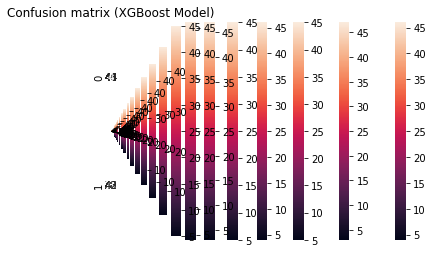

In [32]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import optuna
import shap
import xgboost as xgb

# Initialize variables to store results
shap_values_list = []
shap_dfs = []

# Number of iterations
n_iterations = 50


for i in range(n_iterations):
    # Step 2: Initial sampling
    majority_class = df[df['Outcome'] == 0]
    minority_class = df[df['Outcome'] == 1]

    # Define the number of samples to select
    n_samples = 50

    # Perform random sampling
    sampled_majority = majority_class.sample(n_samples, random_state=123)
    sampled_minority = minority_class.sample(n_samples, random_state=123)

    # Combine sampled data
    sampled_df = pd.concat([sampled_majority, sampled_minority])

    # Test data
    y_test = sampled_df['Outcome']
    x_test = sampled_df.drop(columns='Outcome')

    # Train data
    # Separate remaining data for training
    remaining_df = df.drop(sampled_df.index)
    y_train = remaining_df['Outcome']
    x_train = remaining_df.drop(columns='Outcome')
    
    scaler = StandardScaler()
    scaler.fit(x_train)

    x_train_ = scaler.transform(x_train)
    x_test_ = scaler.transform(x_test)
    
    # Modelling 
    # Creating and running our optimization
    study_xgb = optuna.create_study(direction='maximize', study_name="XGBoost")
    with parallel_backend('threading'):
        study_xgb.optimize(objective_xgb, n_trials=10, n_jobs=-1)

    # Evaluating our Optuna Trial
    print("Best trial:", study_xgb.best_trial.number)
    print("Best accuracy:", study_xgb.best_trial.value)
    print("Best hyperparameters:", study_xgb.best_params)

    # Train the best model
    best_param_xgb = study_xgb.best_params
    XGB = xgb.XGBClassifier(**best_param_xgb, random_state=42, use_label_encoder=False, eval_metric='logloss')
    
    XGB.fit(x_train_, y_train)
    y_pred_xgb = XGB.predict(x_test_)

    # Display results
    display_results(y_test, y_pred_xgb, cm_title="Confusion matrix (XGBoost Model)")

    # SHAP value computation using TreeExplainer
    explainer = shap.TreeExplainer(XGB)
    shap_values = explainer.shap_values(x_test_)

    # Extract SHAP values for class 1 (assuming binary classification)
    shap_values_array = abs(shap_values)  # Use index 1 for the minority class

    # Store the SHAP values for stability analysis
    shap_values_list.append(shap_values_array)

    # Create DataFrame with SHAP values
    shap_values_df = pd.DataFrame(shap_values_array, columns=x_test.columns)
    shap_values_df['Outcome'] = y_test.values

    # Append DataFrame to the list
    shap_dfs.append(shap_values_df)

    print(shap_values_df)

# Concatenate all SHAP DataFrames row-wise
all_shap_values_df = pd.concat(shap_dfs, ignore_index=True)

# Print the combined DataFrame
print(all_shap_values_df)

In [33]:
# Create an valuestability DataFrame
valuestability = pd.DataFrame()

def calc_val(col_name, df, row_id):
    # Calculate the sum and mean
    summ = 0
    for i in range(n_iterations):
        summ += df[col_name].iloc[row_id]
        
        row_id += n_samples*2
        

    mean = summ / n_iterations
    row_id -= n_iterations*n_samples*2
    

    # Calculate the variance
    diff = 0
    for i in range(n_iterations):
        diff += (df[col_name].iloc[row_id] - mean) ** 2
        row_id += n_samples*2

    numerator = (diff / (n_iterations - 1)) ** 0.5
    denominator = mean

    final = numerator / denominator

    return final

def add_to_df():
    arr =[]
    col = x_test.columns
    for c in col:
        print(c)
        for i in range(n_samples*2):
            arr.append(calc_val(c,all_shap_values_df, i))
 
        
        valuestability[c] = arr
        arr =[]



In [34]:
# Call the add_to_df function to populate valuestability
add_to_df()
valuestability

cv = valuestability.sum(axis=1) / valuestability.shape[1]
valuestability['CV'] = cv

# Save the DataFrame to an Excel file
valuestability.to_excel('10_xg_valuestability.xlsx', index=False)
valuestability

Pregnancies
Glucose
BloodPressure
SkinThickness
Insulin
BMI
DPF
Age


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DPF,Age,CV
0,0.846025,0.253777,0.866640,0.344484,0.722410,0.555374,0.300452,0.377532,0.533337
1,0.655954,0.216489,0.866269,0.569936,0.191517,0.284433,0.419293,0.474158,0.459756
2,0.736657,0.211688,0.616425,0.403576,0.425002,0.389467,0.501289,0.298485,0.447824
3,0.849950,0.457166,0.633966,0.300746,0.202065,0.404103,0.362002,0.282483,0.436560
4,0.657636,0.238546,0.577581,0.310979,0.304311,0.332125,0.407148,0.418075,0.405800
...,...,...,...,...,...,...,...,...,...
95,0.683296,0.437870,0.578457,0.413429,0.655433,0.325984,0.549322,0.413808,0.507200
96,0.846570,0.184135,0.701924,0.714013,0.293661,0.306608,0.760073,0.260175,0.508395
97,0.712540,0.198150,0.767370,0.671725,0.280382,0.576051,0.570564,0.219762,0.499568
98,0.494656,0.479817,0.651191,0.573733,0.191814,0.975387,0.416783,0.321411,0.513099
